# Vehicle Detection & Tracking Using Computer Vision And Machine Learning

When we drive, we constantly pay attention to our environment, as our safety and that of many other people are at stake. We particularly look out for position of potential _obstacles_, whether they be other cars, pedestrians, or object on the road. Similarly, as we develop the intelligence and sensors necessary to power an autonomous vehicle, it is of the utmost importance that such a vehicle can detect obstacles as well, as it reinforces the car's understanding of its environment. One of the most important types of ostacles to detect is other vehicles on the road, as they would most likely be the in our lane or neighbouring ones and therefore constitute a potential hazard.

A number of techniques for obstacle detection have been developed throughout the literature, from traditional computer vision techniques to deep learning ones, and more. In this exercise, we build a vehicle detector by employing a conventional computer vision technique called _Histogram of Oriented Gradients (HOG)_, combined with a machine learning algorithm called _Support Vector Machines (SVM)_.

In [1]:
# Main imports
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from importlib import reload
import utils; reload(utils)
from utils import *

In [3]:
test_imgs_dir = "test_images"
output_imgs_dir = "output_images"
output_videos_dir = "output_videos"

project_dataset_dir = "project_dataset"
project_dataset_vehicles_dir = "project_dataset/vehicles"
project_dataset_non_vehicles_dir = "project_dataset/non-vehicles"

# Dataset exploration

Udacity generously provided a _balanced_ dataset with the following characteristics:
* ~ 9K images of vehicles
* ~ 9K images of non-vehicles
* all images are 64x64
The dataset comes from the [GTI Vehicle Image Database](http://www.gti.ssr.upm.es/data/Vehicle_database.html), [KITTI Vision Benchmark Suite](http://www.cvlibs.net/datasets/kitti/), and examples extracted from the project video itself. The latter is much larger and was not used for this project. However, it would be a great addition in the future, especially as we plan to build a classifier using deep learning.

In [4]:
# Let's fetch the paths of training images
project_vehicle_img_paths = glob.glob(project_dataset_vehicles_dir + "/**/*.png", recursive=True)
len(project_vehicle_img_paths)

8792

In [5]:
project_non_vehicle_img_paths = glob.glob(project_dataset_non_vehicles_dir + "/**/*.png", recursive=True)
len(project_non_vehicle_img_paths)

8968

In [6]:
example_vehicle_imgs= np.asarray(list(map(lambda path: load_image(path),  np.asarray(project_vehicle_img_paths)[np.random.randint(0, high=len(project_vehicle_img_paths), size=5)]))) 
example_non_vehicle_imgs= np.asarray(list(map(lambda path: load_image(path),  np.asarray(project_non_vehicle_img_paths)[np.random.randint(0, high=len(project_non_vehicle_img_paths), size=5)]))) 


In [7]:
show_image_list([example_vehicle_imgs, example_non_vehicle_imgs], [np.repeat("vehicle", 5), np.repeat("non-vehicle", 5)], 
                "Vehicles And Non Vehicle Sample Images", cols=5, fig_size=(13, 5))


We can clearly see both vehicle and non-vehicle images. Non-vehicle images tend to be other elements of the road such as the asphalt, road signs or pavement. The distinction is very clear. Most images also display the vehicle in the center, but in different orientations, which is good. 

The concern however would be that because the vehicle is the central object of these images, we may be suffering from _translation_ invariance in the dataset (e.g. non image where we see half or less of the vehicle on the side, etc.).

It seems we will have to make sure to feed to our classifier an image where the vehicle is at the center.

# Feature Extraction

In this section, we apply Histogram of Oriented Gradients and Color bins to our input image to create our features, which will then be fed to a classifier. But before we employ these techniques, we must first define a function to subsample our input.

In [8]:
def subsample_image(img, new_size=(32,32), single_vector=True):
    """
    Resizes the image to the new size and returns either a 1-D vector or multi-dimensional matrix depending
    on the value of single_vector
    """
    features = cv2.resize(img, new_size)
    return features.ravel() if single_vector else features

In [9]:
def color_histogram(img, nbins=32, bins_range=(0, 256)):
    """
    Returns the histograms of the color image across all channels, as a concatenanted feature vector
    """
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [10]:
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler

In [11]:
def pick_features(feat_sub_sample, feat_color_hist, feat_hog, 
                  use_sub_sample=False, use_color_hist=True, use_hog=True):
    """
    Returns a feature vector where the different individual features were retained (or not)
    """
    feature_vec = []
    if use_sub_sample:
        feature_vec = feat_sub_sample
    if use_color_hist:
        feature_vec = feat_color_hist if len(feature_vec) == 0 else np.hstack((feature_vec, feat_color_hist))
    if use_hog:
        feature_vec = feat_hog if len(feature_vec) == 0 else np.hstack((feature_vec, feat_hog))
    
    return feature_vec

In [12]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True, b_norm="L2-Hys"):
    """
    Returns a feature matrix (or vector) that contains the result of the Histogram of Oriented gradients computation.
    If feature_vec is set to True, the resulting image is also returned.
    """
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec, block_norm="L2-Hys")
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec, block_norm="L2-Hys")
        return features

In [13]:
def compute_features(img, color_space="YCrCb", subsample_size=(32, 32), hist_bins=32, hist_range=(0, 256), 
                    hog_orient=9, hog_pix_per_cell=8, hog_cells_per_block=2, hog_block_norm="L2-Hys",
                    hog_color_channels=[0, 1, 2], hog_grayscale=False):
    """
    Computes the features of the given image, by using a combination of:
    - image subsampling
    - color histogram
    - histogram of gradients
    The vector contains all concatenated (and unscaled) features computed
    """
    img_cspace = change_color_space(img, cspace=color_space)
    img_sub_sample = subsample_image(img_cspace, new_size=subsample_size)
    img_color_hist = color_histogram(img_cspace, nbins=hist_bins, bins_range=hist_range)

    hog_features = []
    if hog_color_channels == None:            
        hog_features, img_hog = hog(to_grayscale(img),  orientations=hog_orient,
                      pixels_per_cell=(hog_pix_per_cell, hog_pix_per_cell), 
                     cells_per_block=(hog_cells_per_block, hog_cells_per_block),
                     block_norm=hog_block_norm, visualise=True, feature_vector=True)
    else:
        for ch in hog_color_channels:
            hf, img_hog = hog(img_cspace[:,:,ch], orientations=hog_orient,
                      pixels_per_cell=(hog_pix_per_cell, hog_pix_per_cell), 
                     cells_per_block=(hog_cells_per_block, hog_cells_per_block),
                     block_norm=hog_block_norm, visualise=True, feature_vector=True)
            hog_features = hf if len(hog_features) == 0 else np.concatenate((hog_features, hf))
        
    return pick_features(img_sub_sample, img_color_hist, hog_features)

In [14]:
def normalise_features(features, normaliser=None):
    """
    Returns the tuple (normalised_features, normaliser), 
    where normaliser can normalise feature data by applying the function normaliser.transform(data).
    The function can accept a default normaliser. If None is provided, one will be created and returned
    """
    stacked_features = np.vstack(features).astype(np.float64)
    if normaliser == None:        
        normaliser = StandardScaler().fit(stacked_features)
    normed_features = normaliser.transform(stacked_features)
    
    return normed_features, normaliser

# Exploration Of Features

Let's explore the result of our HOG operations. The algorithm is well explained by Satya Mallick on this [post](https://www.learnopencv.com/histogram-of-oriented-gradients/). 

In [15]:
class FeatureConfig:
    """
    Stores feature configuration
    """
    def __init__(self, color_space, hog_orientations, hog_pixels_per_cell, hog_cells_per_block, hog_block_norm, hog_color_channels=[0,1,2]):
        self.color_space = color_space
        self.hog_orientations = hog_orientations
        self.hog_pixels_per_cell = hog_pixels_per_cell
        self.hog_cells_per_block = hog_cells_per_block
        self.hog_block_norm = hog_block_norm
        self.hog_color_channels = hog_color_channels

In [16]:
test_configs = [
    FeatureConfig("RGB", 9, 8, 2, "L2-Hys"),
    FeatureConfig("RGB", 9, 10, 2, "L2-Hys"),
    FeatureConfig("RGB", 9, 12, 2, "L2-Hys"),
    FeatureConfig("RGB", 9, 14, 2, "L2-Hys"),
    FeatureConfig("RGB", 9, 16, 2, "L2-Hys"),
    FeatureConfig("RGB", 11, 8, 2, "L2-Hys"),    
    FeatureConfig("RGB", 11, 10, 2, "L2-Hys"),
    FeatureConfig("RGB", 11, 12, 2, "L2-Hys"),
    FeatureConfig("RGB", 11, 14, 2, "L2-Hys"),
    FeatureConfig("RGB", 11, 16, 2, "L2-Hys")
]

In [17]:
def get_features_from_config(img, config):
    """
    Returns the tuple of the image in the configured color space, and a list of hog visualisations for each color channel
    """
    hog_visualisations = []
    cspace_img = change_color_space(img, config.color_space)
    for ch in [0, 1, 2]:
        _, hog_vis = get_hog_features(cspace_img[:,:,ch], config.hog_orientations, config.hog_pixels_per_cell, 
                         config.hog_cells_per_block, b_norm=config.hog_block_norm, vis=True)
        hog_visualisations.append(hog_vis)
    
    return (cspace_img, hog_visualisations)

In [18]:
def get_hog_features_from_multiple_configs(img, configs):
    """
    Returns the tuple (features, labels) resulting from the extraction of hog features for the passed configs
    """
    features = []
    labels = []
    for config in configs:
        cspace_img, hog_imgs = get_features_from_config(img, config)    
        features.append([cspace_img, hog_imgs[0], hog_imgs[1], hog_imgs[2]])
        hog_config_str = "o={0}, px/c={1}, c/bk={2}".format(config.hog_orientations, 
                                                          config.hog_pixels_per_cell, 
                                                          config.hog_cells_per_block)
        labels.append([config.color_space, 
                        "[1]: {0}".format(hog_config_str),
                        "[2]: {0}".format(hog_config_str),
                        "[3]: {0}".format(hog_config_str)])
    
    return (features, labels)

In [19]:
sample_vehicle_img = example_vehicle_imgs[np.random.randint(0, len(example_vehicle_imgs))]
sample_non_vehicle_img = example_non_vehicle_imgs[np.random.randint(0, len(example_non_vehicle_imgs))]

In [20]:
vehicle_imgs_hog, vehicle_imgs_hog_labels = get_hog_features_from_multiple_configs(sample_vehicle_img, test_configs)

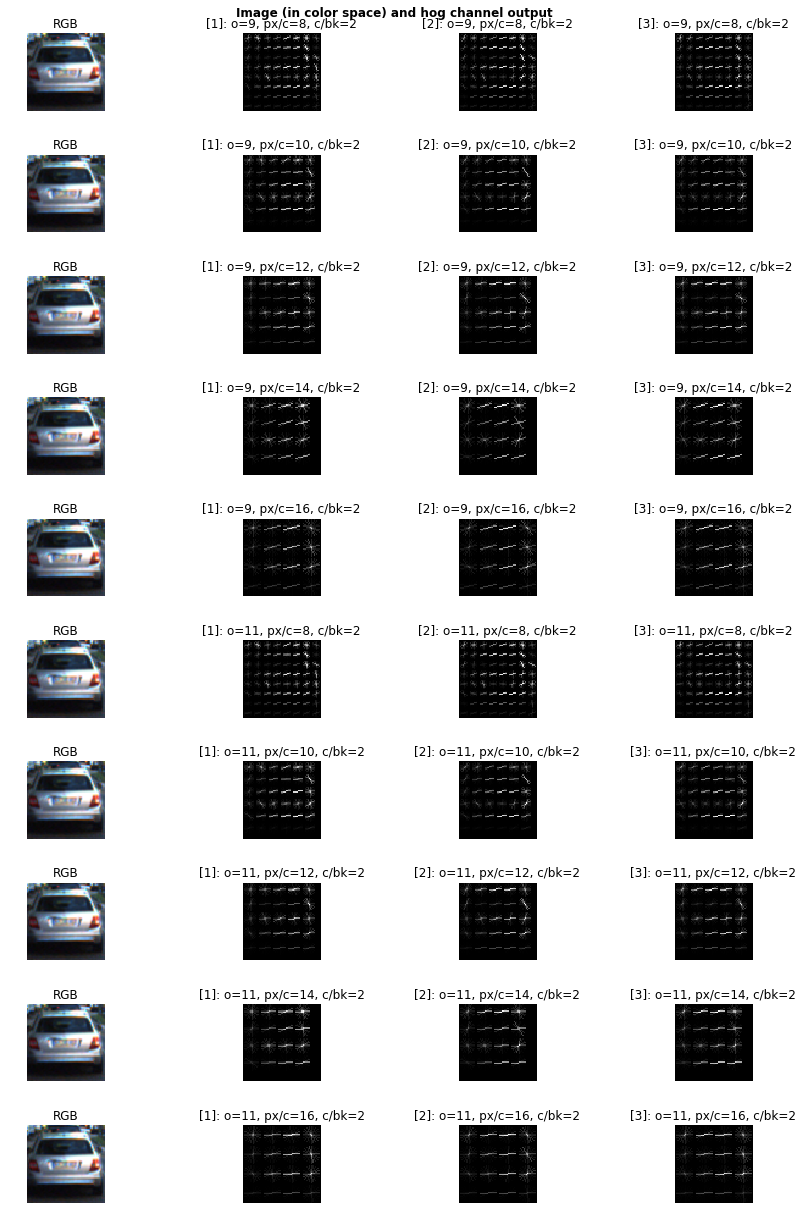

In [21]:
show_image_list(vehicle_imgs_hog, vehicle_imgs_hog_labels, 
                "Image (in color space) and hog channel output", cols=4, fig_size=(12, 17), show_ticks=False)

From pure observation, it looks like a HOG configuration with:
* 11 orientations
* 14 pixels per cell
* 2 cells per blocks 
produce the most distinctive gradients of a vehicle. We have not experimented with different blocks per cells so let us try now.

In [22]:
test_configs = [
    FeatureConfig("RGB", 11, 14, 2, "L2-Hys"),
    FeatureConfig("RGB", 11, 14, 3, "L2-Hys"),
    FeatureConfig("RGB", 11, 14, 4, "L2-Hys")
]

In [23]:
vehicle_imgs_hog, vehicle_imgs_hog_labels = get_hog_features_from_multiple_configs(sample_vehicle_img, test_configs)

In [24]:
show_image_list(vehicle_imgs_hog, vehicle_imgs_hog_labels, 
                "Hog results for different cells per block", cols=4, fig_size=(12, 8), show_ticks=False)

To the human eye, there is no significant difference that we notice visually. We would ideally like to reduce the feature space for faster computation. But for now, we will settle for now on 2 cells per block as it is commonly used in the literature.

We must now explore the most suitable color space for our configuration, as it seems our hog features across the 3 RGB channels are too similar, therefore it feels we are not generating features with enough variations.

## Finding Suitable Color Space

In [25]:
test_configs = [
    FeatureConfig("RGB", 11, 14, 2, "L2-Hys"),
    FeatureConfig("HSV", 11, 14, 2, "L2-Hys"),
    FeatureConfig("HLS", 11, 14, 2, "L2-Hys"),
    FeatureConfig("YUV", 11, 14, 2, "L2-Hys"),
    FeatureConfig("YCrCb", 11, 14, 2, "L2-Hys"),
    FeatureConfig("LAB", 11, 14, 2, "L2-Hys")
]

In [26]:
# TODO Put into a function
vehicle_imgs_hog, vehicle_imgs_hog_labels = get_hog_features_from_multiple_configs(sample_vehicle_img, test_configs)

In [27]:
show_image_list(vehicle_imgs_hog, vehicle_imgs_hog_labels, 
                "HOG results for different color spaces", cols=4, fig_size=(12, 12), show_ticks=False)

For some color channels, it is difficult to interpret the result of HOG. Interestingly, it seems the first color channel in YUV, YCrCb, and LAB could be enough to capture the gradients we are looking for. In HSV and HLS it is respectively on the _Value_ and _Lightness_ that HOG captures the most significant features for the vehicle.

To confirm our hypothesis, let us try with a different image of vehicle.

In [28]:
sample_vehicle_img = example_vehicle_imgs[np.random.randint(0, len(example_vehicle_imgs))]

In [29]:
hog_features, hog_labels = get_hog_features_from_multiple_configs(sample_vehicle_img, test_configs)

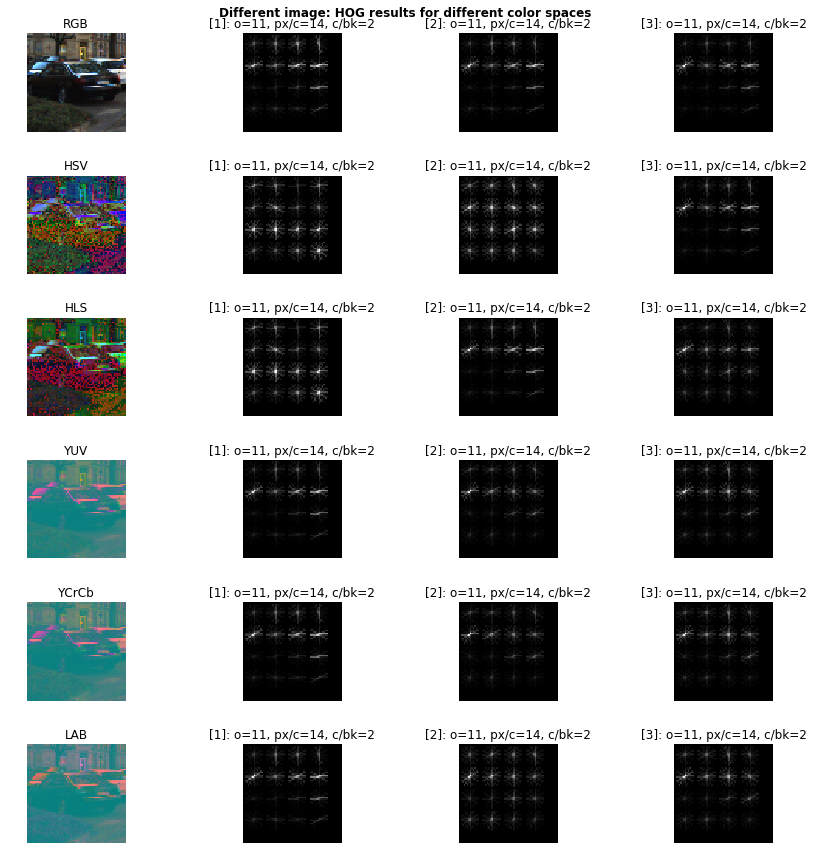

In [30]:
show_image_list(hog_features, hog_labels, 
                "Different image: HOG results for different color spaces", cols=4, fig_size=(12, 12), show_ticks=False)

On a dark image such as the one above, we can observe that HOG on the channel that carries the most light information produces bad results. **We must therefore take into account all color channel to capture the most features.**
In the end, our configuration looks as follows:
* **ALL channels of YCrCb color space**
* **HOG orientations of 11**
* **HOG pixels per cell of 14**
* **HOG cells per cell of 2**

We will also be adding color information to strengthen our feature set.

# Classification

In [31]:
def extract_dataset_features(classes_imgs, labels, config):
    """
    Extract features from labeled dataset
    The list (normalised_features, labels, normaliser) is returned
    """
    all_features = []
    all_labels = []
    for i, class_imgs in enumerate(classes_imgs):
        class_features = []
        class_labels = np.repeat(labels[i], len(class_imgs))
        all_labels = class_labels if len(all_labels) == 0 else np.concatenate((all_labels, class_labels))
        for class_img_path in class_imgs:
            img = load_image(class_img_path)
            img_features = compute_features(img, color_space=config.color_space, 
                                            hog_orient=config.hog_orientations, 
                                            hog_pix_per_cell=config.hog_pixels_per_cell,
                                            hog_cells_per_block=config.hog_cells_per_block,
                                            hog_color_channels=config.hog_color_channels)
            class_features.append(img_features)

        all_features.append(class_features)
    
    normed_features, normaliser = normalise_features(all_features)    
    return normed_features, all_labels, normaliser    

In [32]:
feature_config = FeatureConfig("YCrCb", 11, 14, 2, "L2-Hys", hog_color_channels=[0,1,2])

In [35]:
data_features, data_labels, normaliser = extract_dataset_features([project_vehicle_img_paths, project_non_vehicle_img_paths], ["vehicle", "non_vehicle"], feature_config)

In [36]:
save_as_pickle(data_features, "features_Hist_ALL_HOG-11-14-2_YCrCb.p")

In [37]:
save_as_pickle(data_labels, "data_labels_Hist_ALL_HOG-11-14-2_YCrCb.p")
save_as_pickle(normaliser, "normaliser_Hist_ALL_HOG-11-14-2_YCrCb.p")

In [33]:
normaliser = load_as_pickle("normaliser_Hist_ALL_HOG-11-14-2_YCrCb.p")
data_features = load_as_pickle("features_Hist_ALL_HOG-11-14-2_YCrCb.p")
data_labels = load_as_pickle("data_labels_Hist_ALL_HOG-11-14-2_YCrCb.p")

In [23]:
len(data_labels)

17760

In [34]:
data_features.shape

(17760, 1284)

In [35]:
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [36]:
def split_dataset(data, labels, test_pct=0.2):
    """
    Splits the dataset into with training having a proportion of 1 - test_pct, and the test set with propotion test_pct 
    Returns the tuple (X_train, y_train), (X_test, y_test)
    """
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=test_pct)
    return (X_train, y_train), (X_test, y_test)

In [39]:
def train_classifier(data, labels, method="LinearSVC"):
    """
    Train a classifier on the data and labels and returns the trained classifier
    The classifier itself can be chosen from a variety of options. The default is SVM    
    """
    cfier = None
    if method == "LinearSVC":
        cfier = LinearSVC(C=100)
    elif method == "RBFSVC":
        cfier = SVC(C=100)
    elif method == "DecisionTree":
        cfier = DecisionTreeClassifier()        
    
    cfier.fit(data, labels)

    return cfier

In [40]:
def train_classifier_grid_search(data, labels, method="SVM"):
    parameters = {}
    cfier = None
    if method == "SVM":    
        parameters = {'kernel':('linear', 'rbf'), 'C':[1, 100, 1000, 10000], "gamma":["auto", 0.01, 0.1, 1]}
        cfier = SVC()
    
    cfier_gs = GridSearchCV(cfier, parameters, n_jobs=2, verbose=5)
    cfier_gs.fit(data, labels)
    
    return cfier_gs

In [42]:
training_dataset, test_dataset = split_dataset(data_features, data_labels)

In [45]:
print(training_dataset[0].shape, training_dataset[1].shape)

(14208, 1284) (14208,)


In [46]:
print(test_dataset[0].shape, test_dataset[1].shape)

(3552, 1284) (3552,)


In [ ]:
# TODO experiment with cross validation
classifier_grid_search = train_classifier_grid_search(training_dataset[0], training_dataset[1])

Fitting 3 folds for each of 40 candidates, totalling 120 fits
[CV] gamma=auto, kernel=linear, C=1 ..................................
[CV] gamma=auto, kernel=linear, C=1 ..................................
[CV] ... gamma=auto, kernel=linear, C=1, score=0.979519, total=   7.0s
[CV] gamma=auto, kernel=linear, C=1 ..................................
[CV] ... gamma=auto, kernel=linear, C=1, score=0.980790, total=   8.2s
[CV] gamma=auto, kernel=rbf, C=1 .....................................
[CV] ... gamma=auto, kernel=linear, C=1, score=0.974657, total=   7.3s
[CV] gamma=auto, kernel=rbf, C=1 .....................................
[CV] ...... gamma=auto, kernel=rbf, C=1, score=0.985223, total=  12.0s
[CV] gamma=auto, kernel=rbf, C=1 .....................................
[CV] ...... gamma=auto, kernel=rbf, C=1, score=0.982052, total=  12.9s
[CV] gamma=0.01, kernel=linear, C=1 ..................................
[CV] ... gamma=0.01, kernel=linear, C=1, score=0.980790, total=   8.0s
[CV] gamma=0.01

[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:  2.3min


[CV] ...... gamma=0.01, kernel=rbf, C=1, score=0.984794, total=  26.0s
[CV] gamma=0.1, kernel=rbf, C=1 ......................................
[CV] ....... gamma=0.1, kernel=rbf, C=1, score=0.841672, total= 1.8min
[CV] gamma=0.1, kernel=rbf, C=1 ......................................
[CV] ....... gamma=0.1, kernel=rbf, C=1, score=0.845861, total= 2.0min
[CV] gamma=1, kernel=linear, C=1 .....................................
[CV] ...... gamma=1, kernel=linear, C=1, score=0.980790, total=   7.8s
[CV] gamma=1, kernel=linear, C=1 .....................................
[CV] ...... gamma=1, kernel=linear, C=1, score=0.979519, total=   6.7s
[CV] gamma=1, kernel=linear, C=1 .....................................
[CV] ...... gamma=1, kernel=linear, C=1, score=0.974657, total=   7.1s
[CV] gamma=1, kernel=rbf, C=1 ........................................
[CV] ....... gamma=0.1, kernel=rbf, C=1, score=0.843295, total= 2.0min
[CV] gamma=1, kernel=rbf, C=1 ........................................
[CV] .

[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed: 386.0min


[CV] ... gamma=0.01, kernel=rbf, C=1000, score=0.984589, total=  23.9s
[CV] gamma=0.01, kernel=rbf, C=1000 ..................................
[CV] ... gamma=0.01, kernel=rbf, C=1000, score=0.987542, total=  23.8s
[CV] gamma=0.01, kernel=rbf, C=1000 ..................................
[CV] ...... gamma=10, kernel=rbf, C=100, score=0.509820, total=13.0min
[CV] gamma=0.1, kernel=linear, C=1000 ................................
[CV] ... gamma=0.01, kernel=rbf, C=1000, score=0.988384, total=  24.1s
[CV] gamma=0.1, kernel=linear, C=1000 ................................
[CV] . gamma=0.1, kernel=linear, C=1000, score=0.970439, total=  14.8s
[CV] gamma=0.1, kernel=linear, C=1000 ................................
[CV] . gamma=0.1, kernel=linear, C=1000, score=0.971501, total=  22.4s
[CV] gamma=0.1, kernel=rbf, C=1000 ...................................
[CV] . gamma=0.1, kernel=linear, C=1000, score=0.965153, total=  12.7s
[CV] gamma=0.1, kernel=rbf, C=1000 ...................................
[CV] .

[Parallel(n_jobs=2)]: Done 120 out of 120 | elapsed: 516.4min finished


In [305]:
classifier_grid_search.best_params_

{'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}

In [304]:
save_as_pickle(classifier_grid_search, "classifier_Grid_Search_SVC_Hist_ch0_HOG-11-14-2_YCrCb.p")

In [306]:
classifier = classifier_grid_search

In [43]:
simple_classifier = train_classifier(training_dataset[0], training_dataset[1], method="LinearSVC")
better_classifier = train_classifier(training_dataset[0], training_dataset[1], method="RBFSVC")

In [248]:
save_as_pickle(classifier, "classifier_SVC-RBF_Hist_ALL_HOG-11-14-2_YCrCb.p")

In [30]:
classifier = load_as_pickle("classifier_SVC-RBF_Hist_ALL_HOG-11-14-2_YCrCb.p")
#classifier = load_as_pickle("classifier_SVC-RBF_Hist_HOG_YCrCb.p")

In [44]:
simple_preds = simple_classifier.predict(test_dataset[0])
better_preds = better_classifier.predict(test_dataset[0])

In [45]:
print("Simple classifier accuracy={0} - Better classifier accuracy={1}".format(
    accuracy_score(test_dataset[1], simple_preds),
    accuracy_score(test_dataset[1], better_preds)))

Simple classifier accuracy=0.9836711711711712 - Better classifier accuracy=0.9921171171171171


# Pipeline

In [46]:
test_imgs_paths = glob.glob(test_imgs_dir + "/*.jpg", recursive=True)

In [47]:
test_imgs = np.asarray(list(map(lambda img_path: load_image(img_path), test_imgs_paths)))

## Multi Scale Sliding Windows

In [48]:
import math
def multi_scale_pipeline(img, x_start, x_stop, y_start, y_stop, scale, cfier, normaliser, 
                         orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,
                         window=64, color_space="YCrCb", correct_label="vehicle", overlap_cells=4):
    draw_img = np.copy(img)
    # Normalise our input image
    img = change_color_space(img, cspace=color_space).astype(np.float32)
        
    # Define the image portion we are interested in
    img_tosearch = img[y_start:y_stop, x_start:x_stop, :]
    ctrans_tosearch = img_tosearch
    
    # Subsample this search section if needed
    if scale != 1:
        imshape = ctrans_tosearch.shape 
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    # Define the total number of cells in a given direction (x, y) 
    # This is equivalent to the number of convolutions per axis in deep learning (c.f. cs231n)
    # nxblock = [(axis_size - block_size) / stride] + 1 
    #  -> [(axis_size - pix_per_cell * cells_per_block) / pix_per_cell] + 1
    #  -> [(axis_size / pix_per_cell) - cells_per_block] + 1
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1
    # Each cell within a block is normalised and produces a histogram of oriented features
    nfeat_per_block = orient*cell_per_block
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    # TODO - make this a parameter    
    # Same here - we use the convolution formula to figure out the number of blocks in the window
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    
    # Instead of overlap, define how many cells to step
    # TODO - make this a parameter
    # TODO add a '+1' to nxsteps and nysteps formulas
    #cells_per_step = int(pix_per_cell * (1 - overlap_pct))
    #cells_per_step = int(math.ceil(cell_per_block * (1 - overlap_pct)))
    cells_per_step = overlap_cells

    #print("Cells per step = ", cells_per_step)
    #print("nxblocks={0}, nblocks_per_window={1}, nx_steps={2}".format(nxblocks, nblocks_per_window, (nxblocks - nblocks_per_window) // cells_per_step))
    #print("nyblocks={0}, nblocks_per_window={1}, ny_steps={2}".format(nyblocks, nblocks_per_window, (nyblocks - nblocks_per_window) // cells_per_step))
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    #nxsteps = nxblocks // nblocks_per_window
    #nysteps = nyblocks // nblocks_per_window

    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    bounding_boxes = []
    all_windows = []
    for xb in range(nxsteps):
        xpos = xb*cells_per_step
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            #hog_features = hog_feat1
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (window,window))
          
            # Get color features
            spatial_features = subsample_image(subimg, new_size=spatial_size)
            hist_features = color_histogram(subimg, nbins=hist_bins)
            
            # Scale features and make a prediction
            #test_features = normaliser.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            picked_features = pick_features(spatial_features, hist_features, hog_features)

            if len(picked_features.shape) == 1:
                picked_features = picked_features.reshape(1, -1)
            test_features = normaliser.transform(picked_features)
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = cfier.predict(test_features)
            
            # Compute our window's actual size
            xbox_left = np.int(xleft*scale)
            ytop_draw = np.int(ytop*scale)
            win_draw = np.int(window*scale)
            
            top_left = (xbox_left + x_start, ytop_draw+y_start)
            bottom_right = (xbox_left+win_draw + x_start,ytop_draw+win_draw+y_start)
            
            all_windows.append((top_left, bottom_right))
            #print("Window dimensions ({0}, {1}), scale={2}".format(bottom_right[0] - top_left[0], bottom_right[1] - top_left[1], scale))
            #print(test_prediction)
            if test_prediction == correct_label:
                #print("****")
                bounding_boxes.append((top_left, bottom_right))
                #cv2.rectangle(draw_img,(xbox_left + x_start, ytop_draw+y_start), (xbox_left+win_draw + x_start,ytop_draw+win_draw+y_start),(0,0,255),6) 
    
    #print("total windows=", len(all_windows))
    return bounding_boxes, all_windows

In [49]:
mc_bboxes, wins = multi_scale_pipeline(test_imgs[5], 64, 1280, 400, 656, 4, simple_classifier, normaliser, 11, 14, 2, (32, 32), 32, color_space="YCrCb", window=64, overlap_cells=4)
#print(mc_bboxes)
new_img_boxes = draw_boxes(test_imgs[5], mc_bboxes)
new_img_all_windows = draw_boxes(test_imgs[5], wins, alternating_bbox_color=(255, 153, 0))
plt.figure(figsize=(12,8))
plt.imshow(new_img_all_windows)

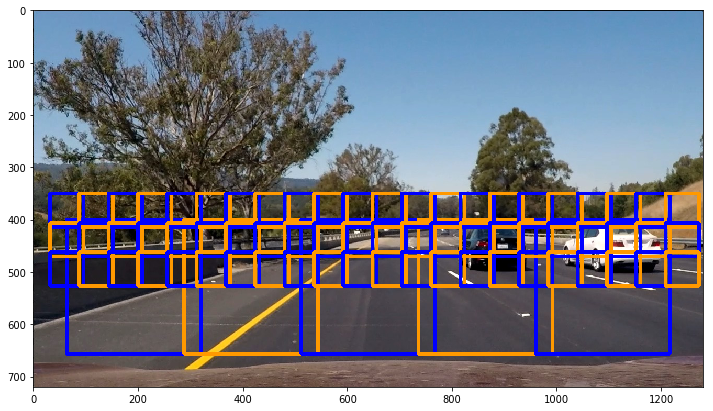

In [50]:
mc_bboxes, wins = multi_scale_pipeline(test_imgs[5], 32, 1280, 350, 550, 1, simple_classifier, normaliser, 11, 14, 2, (32, 32), 32, color_space="YCrCb", window=64, overlap_cells=4)
#print(mc_bboxes)
new_img_all_windows_2 = draw_boxes(new_img_all_windows, wins, alternating_bbox_color=(255, 153, 0))
plt.figure(figsize=(12,8))
plt.imshow(new_img_all_windows_2)

## Heatmap Thresholding

In [51]:
from scipy.ndimage.measurements import label

In [52]:
def create_heatmap(img, bbox_list):
    """
    Returns a new heatmap where the regions of the image captured by the bounding boxes are "heated-up"
    """
    heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    
    heatmap = np.clip(heatmap, 0, 255)

    return heatmap

In [53]:
def threshold_heatmap(heatmap, threshold=2):
    """
    Updates the heatmap by only retaining hot sections whose values are strictly above the threshold.
    All other values are "cooled" down
    """
    heatmap_copy = np.copy(heatmap)
    # Zero out pixels below the threshold
    heatmap_copy[heatmap_copy < threshold] = 0
    # Return thresholded map
    return heatmap_copy

In [54]:
def label_heatmap(heatmap):
    """
    Returns a slice with labels over the original heatmap, as well as the total count of labels found
    """
    return label(heatmap)

In [55]:
def find_smoothed_boxes(img, labels, duplicate=True, min_area_filter=32*32):
    """
    Returns a set of bounding boxes where each bounding box is the aggregations of neibhouring boxes for the same label
    """
    aggregate_bboxes = []
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        top_left = (np.min(nonzerox), np.min(nonzeroy))
        bottom_right = (np.max(nonzerox), np.max(nonzeroy))
        
        if (bottom_right[0] - top_left[0]) * (bottom_right[1] - top_left[1]) < min_area_filter:
            continue
        
        # Define a bounding box based on min/max x and y
        aggregate_bboxes.append(((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy))))
    # Return the image
    
    return aggregate_bboxes

In [56]:
def smoothen_bounding_boxes(img, bboxes, thres=2):
    
    heat = create_heatmap(img, bboxes)
    heat_thresholded = threshold_heatmap(heat, threshold=thres)
    heat_labels = label_heatmap(heat_thresholded)
    smoothed_bboxes = find_smoothed_boxes(img, heat_labels)
    
    return heat, heat_thresholded, heat_labels, smoothed_bboxes

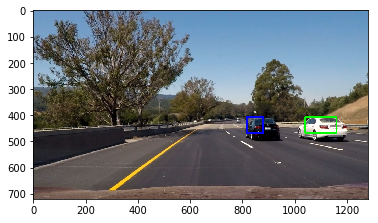

In [57]:
heatmap, heatmap_thres, heatmap_lbs, smoothed_bboxes = smoothen_bounding_boxes(test_imgs[5], mc_bboxes, thres=1)
plt.imshow(draw_boxes(test_imgs[5], smoothed_bboxes))

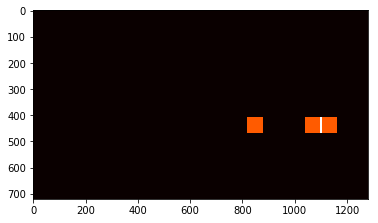

In [58]:
plt.imshow(heatmap * 255, cmap="hot")

In [59]:
sc = np.max(heatmap) / 255
hm_color = cv2.applyColorMap(heatmap / sc, cv2.COLORMAP_HOT)
hm_color.shape

(720, 1280)

In [60]:
def create_heatmap_rgb_img(hmap):
    """
    Create a heatmap from a binary image
    """
    scale = np.max(hmap) / 255
    if scale == 0:
        # Handle the zero case. We could also add an epsilon
        scale = 1
    z = np.zeros_like(hmap).astype(np.uint8)
    hm_scaled = (hmap / scale).astype(np.uint8)
    return np.dstack((hm_scaled, z, z))
    


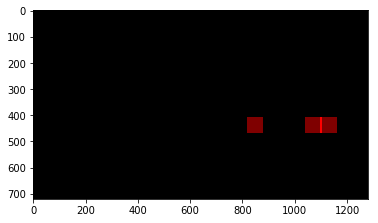

In [61]:
hm_scaled = create_heatmap_rgb_img(heatmap)
plt.imshow(hm_scaled)

# Putting It All Together

In [62]:
def draw_boxes_np(img, bboxes, color=(0, 0, 255), thick=6):
    """
    Returns a new image the bounding boxes have been overlaid in the chosen color
    """
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, (bbox[0][0], bbox[0][1]), (bbox[1][0], bbox[1][1]), color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [63]:
def combine_images(img, overlay_imgs, small_img_size, x_offset, y_offset):
    """
    Returns an image that combines the original image with a set of overlaid images
    The overlaid images are resized to the supplied dimensions and overlaid onto the original image.
    Note that the returned image is a modification of the original image.
    """
    
    for i, overlay_img in enumerate(overlay_imgs):        
        sc = i + 1
        small_overlay_img = cv2.resize(overlay_img, small_img_size)
        overlay_color = small_overlay_img
        if len(overlay_color.shape) < 3:
            #overlay_zero = np.zeros_like(small_overlay_img).astype(np.uint8)
            #overlay_color = np.dstack((small_overlay_img, overlay_zero, overlay_zero))
            overlay_color = create_heatmap_rgb_img(overlay_color)
        new_y_offset = y_offset
        new_x_offset = sc * x_offset + i * small_img_size[0]
        img[new_y_offset: new_y_offset + small_img_size[1], new_x_offset: new_x_offset + small_img_size[0]] = overlay_color
    
    return img
        

In [64]:
import math
class DetectedObject:
    """
    The DetectedObject class encapsulates information about an object identified by our detector
    """
    def __init__(self, bounding_box, img_patch, frame_nb):
        self.bounding_box = bounding_box
        self.img_patch = img_patch 
        self.frame_nb = frame_nb
        self.centroid = (int((bounding_box[0][0] + bounding_box[1][0]) / 2), int((bounding_box[0][1] + bounding_box[1][1]) / 2))
        self.similar_objects = []
            
    def bounding_box_area(self):
        """
        Returns the area of the bounding box
        """
        return (self.bounding_box[1][0] - self.bounding_box[0][0]) * (self.bounding_box[1][1] - self.bounding_box[0][1])
    
    def same_object(self, detected_object):
        """
        Returns whether the current detected object is the same as the newly detected one passed as argument
        """
        # The distance between the centroids
        dist = math.hypot(detected_object.centroid[0] - self.centroid[0], detected_object.centroid[1] - self.centroid[1])
        
        if dist <= 60.0:
            return True
        
        return False
    
    def smoothe_bounding_box(self, same_object):
        """
        Smoothes the bounding boxes between the current object and the same one from another frame
        """
        print("old centroid=", self.centroid)
        self.centroid = (int((same_object.centroid[0] + self.centroid[0]) / 2), int((same_object.centroid[1] + self.centroid[1]) / 2))
        print("new centroid=", self.centroid)
        
        print("old bbox=", self.bounding_box)
        # Ideally, we want to keep the biggest possible bounding box
        current_width = self.bounding_box[1][0] - self.bounding_box[0][0]
        current_height = self.bounding_box[1][1] - self.bounding_box[0][1]

        obj_width = same_object.bounding_box[1][0] - same_object.bounding_box[0][0]
        obj_height = same_object.bounding_box[1][1] - same_object.bounding_box[0][1]
        
        max_width = max(current_width, obj_width)
        max_height = max(current_height, obj_height)
        
        half_width = int(max_width / 2)
        half_height = int(max_height / 2)
        
        new_bounding_box = np.asarray(((self.centroid[0] - half_width, self.centroid[1] - half_height),
                                       (self.centroid[0] + half_width, self.centroid[1] + half_height)))
        
        self.bounding_box = new_bounding_box
        #self.bounding_box = ((self.bounding_box + same_object.bounding_box) / 2).astype(np.int32)
        print("new bbox=", self.bounding_box)
    
    def add_similar_object(self, similar_object):
        """
        Accumulates a similar object
        """
        self.similar_objects.append(similar_object)
    
    def similar_objects_count(self):
        """
        Returns the number of similar objects
        """
        return len(self.similar_objects)

In [65]:
class SlidingWindowConfiguration:
    """
    Represents configuration details for a set of sliding windows
    """
    def __init__(self, xstart, xstop, ystart, ystop, scale):
        self.xstart = xstart
        self.xstop = xstop
        self.ystart = ystart
        self.ystop = ystop
        self.scale = scale

In [66]:
class VehicleDetectorWithMemory:
    """
    The VehicleDetectorWithMemory is a class that is capable drawing bounding boxes around vehicles in a video
    """
    def __init__(self, simple_classifier, final_classifier, normaliser, color_space="RGB", frame_sampling_rate=5, save_frame=False, 
                 threshold=5, min_detection_count=8, debug_imgs = False, cell_overlap=4):
        self.simple_classifier = simple_classifier
        self.final_classifier = final_classifier
        self.normaliser = normaliser
        self.color_space = color_space 
        
        self.current_frame_nb = 0
        self.frame_sampling_rate = frame_sampling_rate
        self.previous_detected_objects = []
        self.current_detected_objects = []
        self.save_frame = save_frame
        self.threshold = threshold
        self.min_detection_count = min_detection_count
        self.debug_imgs = debug_imgs
        self.cell_overlap = cell_overlap
        
        # Add extra parameters such as [(ystart, ystop), (x_start, x_stop), scale] 
        # Maybe create a config object that has those and also classifier config?
        
    def process_image(self, img):
        """
        Returns a new image where the vehicles detected on the original image have been highlighted via a bounding box
        """
        
        # Save the frame for testing
        if self.save_frame and self.frame_sampling_rate > 0 and self.current_frame_nb % self.frame_sampling_rate == 0:
            cv2.imwrite("video_images/frame_{0}.png".format(self.current_frame_nb), cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
            
        sw_configs =[
            SlidingWindowConfiguration(0, 1280, 400, 656, 2.5),
            SlidingWindowConfiguration(0, 1280, 400, 656, 1.8),
            #SlidingWindowConfiguration(0, 1280, 350, 656, 1.8),
            SlidingWindowConfiguration(0, 1280, 350, 500, 1.5),
            SlidingWindowConfiguration(0, 1280, 350, 500, 1.2),
            #SlidingWindowConfiguration(0, 1280, 350, 656, 1.1),
            SlidingWindowConfiguration(0, 1280, 350, 500, 1)
        ]
        
        bboxes = []
        all_windows = []
        for sw_config in sw_configs:
            box, all_s_wins = multi_scale_pipeline(img, sw_config.xstart, sw_config.xstop, 
                                                   sw_config.ystart, sw_config.ystop, sw_config.scale,
                                                  self.simple_classifier, self.normaliser,
                                                  11, 14, 2, (32, 32), 32, color_space=self.color_space,
                                                  window=64, overlap_cells=self.cell_overlap)
            bboxes.append(box)
            all_windows.append(all_s_wins)
        
#        bboxes_sc1, all_wins1 = multi_scale_pipeline(img, 64, 1280, 400, 656, 4, self.classifier, self.normaliser, 11, 14, 2, (32, 32), 32, color_space=self.color_space, window=64, overlap_pct=o_pct)
 #       bboxes_sc2, all_wins2 = multi_scale_pipeline(img, 0, 1280, 350, 656, 3.5, self.classifier, self.normaliser, 11, 14, 2, (32, 32), 32, color_space=self.color_space, window=64, overlap_pct=o_pct)
  #      bboxes_sc3, all_wins3 = multi_scale_pipeline(img, 0, 1280, 350, 656, 3.0, self.classifier, self.normaliser, 11, 14, 2, (32, 32), 32, color_space=self.color_space, window=64, overlap_pct=o_pct)
   #     bboxes_sc4, all_wins4 = multi_scale_pipeline(img, 0, 1280, 350, 656, 2.5, self.classifier, self.normaliser, 11, 14, 2, (32, 32), 32, color_space=self.color_space, window=64, overlap_pct=o_pct)
    #    bboxes_sc5, all_wins5 = multi_scale_pipeline(img, 0, 1280, 350, 656, 1.5, self.classifier, self.normaliser, 11, 14, 2, (32, 32), 32, color_space=self.color_space, window=64, overlap_pct=o_pct)
     #   bboxes_sc6, all_wins6 = multi_scale_pipeline(img, 0, 1280, 350, 656, 1.0, self.classifier, self.normaliser, 11, 14, 2, (32, 32), 32, color_space=self.color_space, window=64, overlap_pct=o_pct)
        
        combined_boxes = []
        #for i, bboxes in enumerate([bboxes_sc1, bboxes_sc2, bboxes_sc3, bboxes_sc4, bboxes_sc5, bboxes_sc6]):
        for i, bboxes in enumerate(bboxes):
            if len(bboxes) == 0:
                continue
            combined_boxes = np.asarray(bboxes) if len(combined_boxes) == 0 else np.concatenate((combined_boxes, np.asarray(bboxes)), axis=0)
        
        if self.debug_imgs and self.frame_sampling_rate == 0:
            #for all_wins in [all_wins1, all_wins2, all_wins3, all_wins4, all_wins5, all_wins6]:
            for all_wins in all_windows:
                all_wins_img = draw_boxes(img, all_wins)
                plt.figure(figsize=(12,7))
                plt.imshow(all_wins_img)
                plt.show()
        
        
        all_bboxes_drawn = draw_boxes_np(img, combined_boxes)
        heatmap, heatmap_thres, heatmap_lbs, smoothed_bboxes = smoothen_bounding_boxes(img, combined_boxes, thres=self.threshold)
        
        if self.frame_sampling_rate == 0:
            drawn_smoothed_bboxes = draw_boxes(img, smoothed_bboxes)
            combined_img = combine_images(drawn_smoothed_bboxes, [heatmap, heatmap_thres, all_bboxes_drawn], (320, 200), 20, 10)
            return combined_img

        print("Found {0} bounding boxes, {1} smooted ones and {2} labels".format(len(combined_boxes), len(smoothed_bboxes), heatmap_lbs[1]))
        
        new_detected_objects = []
        for smoothed_bbox in smoothed_bboxes:
            # create a detected object
            patch = img[smoothed_bbox[0][1]:smoothed_bbox[1][1],smoothed_bbox[0][0]:smoothed_bbox[1][0]]
            do = DetectedObject(np.asarray(smoothed_bbox), patch, self.current_frame_nb)
            if do.bounding_box_area() < 32 * 32:
                print("Skipping bounding box")
                continue
                
            #if self.current_frame_nb == 0:        
             #   self.previous_detected_objects.append(do)
            #else:
            to_append = True
            for pdo in self.current_detected_objects:
                if pdo.same_object(do):
                    print("**Found a match**")
                    pdo.smoothe_bounding_box(do)
                    pdo.add_similar_object(do)
                    to_append = False
                    #new_detected_objects.append(do)

                    break
            if to_append:
                print("Appending new object with centroid:", do.centroid)
                self.current_detected_objects.append(do)
        
        print("previously detected objects=", len(self.previous_detected_objects))
        if self.current_frame_nb > 0 and self.current_frame_nb % self.frame_sampling_rate == 0:
            retained_detected_objects = []
            # Take all detected objects in previous frames and only retain those that have more than 2 matches
            for pdo in self.current_detected_objects:
                print("number of times detected object appeared: ", pdo.similar_objects_count())
                if pdo.similar_objects_count() >= self.min_detection_count:
                    print("** ADDING **")
                    retained_detected_objects.append(pdo)
            
            self.previous_detected_objects = retained_detected_objects
            self.current_detected_objects = []
            print("Refresh at frame n {0}: newly detected objects {1}".format(self.current_frame_nb, len(self.previous_detected_objects)))
        else:
            print("so far newly detected objects=", len(self.current_detected_objects))
        
        
        self.current_frame_nb += 1
        if len(self.previous_detected_objects) > 0:
            bounding_boxes = []
            for ro in self.previous_detected_objects:
                bounding_boxes.append(((ro.bounding_box[0][0], ro.bounding_box[0][1]), (ro.bounding_box[1][0], ro.bounding_box[1][1])))

            smoothed_cars_bboxes = draw_boxes_np(img, bounding_boxes)
            
            combined_img = combine_images(smoothed_cars_bboxes, [heatmap, heatmap_thres, all_bboxes_drawn], (320, 200), 20, 10)
            if self.debug_imgs and (self.current_frame_nb -1)  % self.frame_sampling_rate == 0:
                plt.imshow(combined_img)
                plt.show()
                
            return smoothed_cars_bboxes
        else:
            combined_img = combine_images(img, [heatmap, heatmap_thres, all_bboxes_drawn], (320, 200), 20, 10)
            if self.debug_imgs and (self.current_frame_nb -1)  % self.frame_sampling_rate == 0:
                plt.imshow(combined_img)
                plt.show()

            return combined_img                    

## Testing with a few sample images

In [67]:
video_sample_imgs_paths = glob.glob("video_images/*.png", recursive=False)
print(video_sample_imgs_paths)

['video_images/frame_0.png', 'video_images/frame_10.png', 'video_images/frame_15.png', 'video_images/frame_20.png', 'video_images/frame_25.png', 'video_images/frame_30.png', 'video_images/frame_35.png', 'video_images/frame_40.png', 'video_images/frame_45.png', 'video_images/frame_5.png', 'video_images/frame_50.png', 'video_images/frame_55.png', 'video_images/frame_60.png', 'video_images/frame_65.png', 'video_images/frame_70.png', 'video_images/frame_75.png']


In [68]:
video_sample_imgs = np.asarray(list(map(lambda img_path: load_image(img_path), video_sample_imgs_paths)))
plt.imshow(video_sample_imgs[0])

In [ ]:
detector = VehicleDetectorWithMemory(classifier, normaliser, color_space="YCrCb", 
                                     frame_sampling_rate=8, threshold=5, min_detection_count=5)
for video_sample_img in video_sample_imgs:    
    detected_cars_img = detector.process_image(video_sample_img)
    plt.figure(figsize=(12,7))
#plt.imshow(detected_cars_img, cmap="hot")
    plt.imshow(detected_cars_img)
    plt.show()


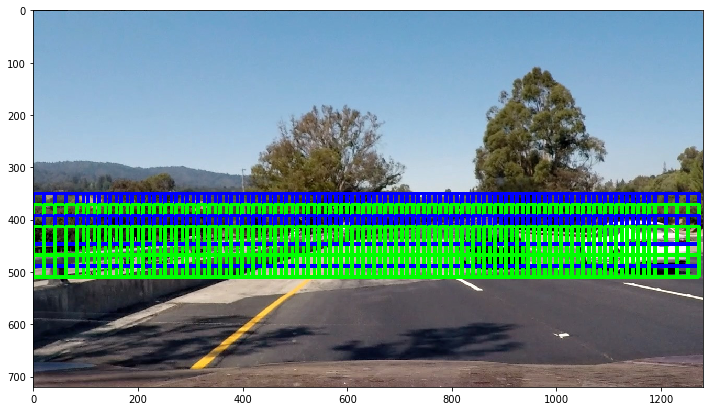

In [ ]:
detector = VehicleDetectorWithMemory(simple_classifier, better_classifier, normaliser, color_space="YCrCb", 
                                     frame_sampling_rate=0, threshold=3, debug_imgs=True, cell_overlap=1)
detected_cars_img = detector.process_image(test_imgs[3])
plt.figure(figsize=(12,8))
#plt.imshow(detected_cars_img, cmap="hot")
plt.imshow(detected_cars_img)

# Results

In [79]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [80]:
project_video_path = "project_video.mp4"
project_video_output_path = 'output_videos/project_video.mp4'

project_video_sample_path = 'project_video_sample.mp4'
project_video_sample_output_path = 'output_videos/project_video_sample.mp4'

## Sample Of Project Video

In [91]:
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
ffmpeg_extract_subclip(project_video_path, 5, 12, targetname=project_video_sample_path)


[MoviePy] Running:
>>> /Users/eddieforson/Library/Application Support/imageio/ffmpeg/ffmpeg.osx -y -i project_video.mp4 -ss 5.00 -t 7.00 -vcodec copy -acodec copy project_video_sample.mp4
... command successful.


Found 12 bounding boxes, 1 smooted ones and 1 labels
Appending new object with centroid: (1244, 434)
previously detected objects= 0
so far newly detected objects= 1


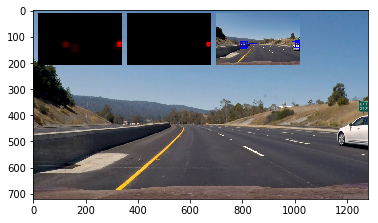

[MoviePy] >>>> Building video output_videos/project_video_sample.mp4
[MoviePy] Writing video output_videos/project_video_sample.mp4



  1%|          | 1/176 [00:06<17:37,  6.04s/it]

Found 12 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1244, 434)
new centroid= (1244, 434)
old bbox= [[1209  400]
 [1279  469]]
new bbox= [[1209  400]
 [1279  468]]
previously detected objects= 0
so far newly detected objects= 1



  1%|          | 2/176 [00:12<17:45,  6.13s/it]

Found 12 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1244, 434)
new centroid= (1244, 434)
old bbox= [[1209  400]
 [1279  468]]
new bbox= [[1209  400]
 [1279  468]]
previously detected objects= 0
so far newly detected objects= 1



  2%|▏         | 3/176 [00:18<17:48,  6.17s/it]

Found 12 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1244, 434)
new centroid= (1244, 434)
old bbox= [[1209  400]
 [1279  468]]
new bbox= [[1209  400]
 [1279  468]]
previously detected objects= 0
so far newly detected objects= 1



  2%|▏         | 4/176 [00:24<17:32,  6.12s/it]

Found 12 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1244, 434)
new centroid= (1244, 434)
old bbox= [[1209  400]
 [1279  468]]
new bbox= [[1209  400]
 [1279  468]]
previously detected objects= 0
so far newly detected objects= 1



  3%|▎         | 5/176 [00:30<17:18,  6.07s/it]

Found 12 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1244, 434)
new centroid= (1244, 434)
old bbox= [[1209  400]
 [1279  468]]
new bbox= [[1209  400]
 [1279  468]]
previously detected objects= 0
so far newly detected objects= 1



  3%|▎         | 6/176 [00:36<17:06,  6.04s/it]

Found 12 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1244, 434)
new centroid= (1244, 434)
old bbox= [[1209  400]
 [1279  468]]
new bbox= [[1209  400]
 [1279  468]]
previously detected objects= 0
so far newly detected objects= 1



  4%|▍         | 7/176 [00:42<16:56,  6.01s/it]

Found 12 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1244, 434)
new centroid= (1244, 434)
old bbox= [[1209  400]
 [1279  468]]
new bbox= [[1209  400]
 [1279  468]]
previously detected objects= 0
so far newly detected objects= 1



  5%|▍         | 8/176 [00:48<16:41,  5.96s/it]

Found 12 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1244, 434)
new centroid= (1244, 434)
old bbox= [[1209  400]
 [1279  468]]
new bbox= [[1209  400]
 [1279  468]]
previously detected objects= 0
so far newly detected objects= 1



  5%|▌         | 9/176 [00:54<16:31,  5.94s/it]

Found 12 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1244, 434)
new centroid= (1244, 434)
old bbox= [[1209  400]
 [1279  468]]
new bbox= [[1209  400]
 [1279  468]]
previously detected objects= 0
so far newly detected objects= 1


Found 12 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1244, 434)
new centroid= (1244, 434)
old bbox= [[1209  400]
 [1279  468]]
new bbox= [[1209  400]
 [1279  468]]
previously detected objects= 0
number of times detected object appeared:  10
** ADDING **
Refresh at frame n 10: newly detected objects 1



  6%|▋         | 11/176 [01:06<16:31,  6.01s/it]

Found 12 bounding boxes, 1 smooted ones and 1 labels
Appending new object with centroid: (1244, 434)
previously detected objects= 1
so far newly detected objects= 1



  7%|▋         | 12/176 [01:12<16:21,  5.98s/it]

Found 12 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1244, 434)
new centroid= (1244, 434)
old bbox= [[1209  400]
 [1279  469]]
new bbox= [[1209  400]
 [1279  468]]
previously detected objects= 1
so far newly detected objects= 1



  7%|▋         | 13/176 [01:18<16:18,  6.00s/it]

Found 12 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1244, 434)
new centroid= (1244, 434)
old bbox= [[1209  400]
 [1279  468]]
new bbox= [[1209  400]
 [1279  468]]
previously detected objects= 1
so far newly detected objects= 1



  8%|▊         | 14/176 [01:24<16:19,  6.05s/it]

Found 12 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1244, 434)
new centroid= (1244, 434)
old bbox= [[1209  400]
 [1279  468]]
new bbox= [[1209  400]
 [1279  468]]
previously detected objects= 1
so far newly detected objects= 1



  9%|▊         | 15/176 [01:30<16:05,  6.00s/it]

Found 12 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1244, 434)
new centroid= (1244, 434)
old bbox= [[1209  400]
 [1279  468]]
new bbox= [[1209  400]
 [1279  468]]
previously detected objects= 1
so far newly detected objects= 1



  9%|▉         | 16/176 [01:36<15:52,  5.96s/it]

Found 12 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1244, 434)
new centroid= (1244, 434)
old bbox= [[1209  400]
 [1279  468]]
new bbox= [[1209  400]
 [1279  468]]
previously detected objects= 1
so far newly detected objects= 1



 10%|▉         | 17/176 [01:42<15:42,  5.93s/it]

Found 12 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1244, 434)
new centroid= (1244, 434)
old bbox= [[1209  400]
 [1279  468]]
new bbox= [[1209  400]
 [1279  468]]
previously detected objects= 1
so far newly detected objects= 1



 10%|█         | 18/176 [01:48<15:35,  5.92s/it]

Found 12 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1244, 434)
new centroid= (1244, 434)
old bbox= [[1209  400]
 [1279  468]]
new bbox= [[1209  400]
 [1279  468]]
previously detected objects= 1
so far newly detected objects= 1



 11%|█         | 19/176 [01:53<15:28,  5.91s/it]

Found 12 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1244, 434)
new centroid= (1244, 434)
old bbox= [[1209  400]
 [1279  468]]
new bbox= [[1209  400]
 [1279  468]]
previously detected objects= 1
so far newly detected objects= 1


Found 12 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1244, 434)
new centroid= (1244, 434)
old bbox= [[1209  400]
 [1279  468]]
new bbox= [[1209  400]
 [1279  468]]
previously detected objects= 1
number of times detected object appeared:  9
** ADDING **
Refresh at frame n 20: newly detected objects 1



 12%|█▏        | 21/176 [02:06<15:35,  6.04s/it]

Found 12 bounding boxes, 1 smooted ones and 1 labels
Appending new object with centroid: (1244, 434)
previously detected objects= 1
so far newly detected objects= 1



 12%|█▎        | 22/176 [02:12<15:36,  6.08s/it]

Found 12 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1244, 434)
new centroid= (1244, 434)
old bbox= [[1209  400]
 [1279  469]]
new bbox= [[1209  400]
 [1279  468]]
previously detected objects= 1
so far newly detected objects= 1



 13%|█▎        | 23/176 [02:18<15:31,  6.09s/it]

Found 12 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1244, 434)
new centroid= (1244, 434)
old bbox= [[1209  400]
 [1279  468]]
new bbox= [[1209  400]
 [1279  468]]
previously detected objects= 1
so far newly detected objects= 1



 14%|█▎        | 24/176 [02:24<15:21,  6.06s/it]

Found 12 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1244, 434)
new centroid= (1244, 434)
old bbox= [[1209  400]
 [1279  468]]
new bbox= [[1209  400]
 [1279  468]]
previously detected objects= 1
so far newly detected objects= 1



 14%|█▍        | 25/176 [02:30<15:10,  6.03s/it]

Found 12 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1244, 434)
new centroid= (1244, 434)
old bbox= [[1209  400]
 [1279  468]]
new bbox= [[1209  400]
 [1279  468]]
previously detected objects= 1
so far newly detected objects= 1



 15%|█▍        | 26/176 [02:36<15:00,  6.00s/it]

Found 12 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1244, 434)
new centroid= (1244, 434)
old bbox= [[1209  400]
 [1279  468]]
new bbox= [[1209  400]
 [1279  468]]
previously detected objects= 1
so far newly detected objects= 1



 15%|█▌        | 27/176 [02:42<14:53,  6.00s/it]

Found 9 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1244, 434)
new centroid= (1241, 435)
old bbox= [[1209  400]
 [1279  468]]
new bbox= [[1206  401]
 [1276  469]]
previously detected objects= 1
so far newly detected objects= 1



 16%|█▌        | 28/176 [02:48<14:45,  5.98s/it]

Found 7 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1241, 435)
new centroid= (1241, 433)
old bbox= [[1206  401]
 [1276  469]]
new bbox= [[1206  399]
 [1276  467]]
previously detected objects= 1
so far newly detected objects= 1



 16%|█▋        | 29/176 [02:54<14:39,  5.98s/it]

Found 10 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1241, 433)
new centroid= (1239, 433)
old bbox= [[1206  399]
 [1276  467]]
new bbox= [[1204  399]
 [1274  467]]
previously detected objects= 1
so far newly detected objects= 1


Found 9 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1239, 433)
new centroid= (1238, 433)
old bbox= [[1204  399]
 [1274  467]]
new bbox= [[1203  399]
 [1273  467]]
previously detected objects= 1
number of times detected object appeared:  9
** ADDING **
Refresh at frame n 30: newly detected objects 1


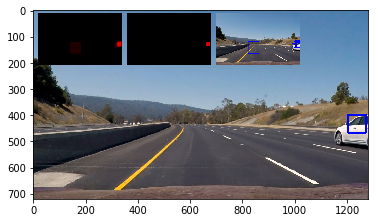


 18%|█▊        | 31/176 [03:06<14:34,  6.03s/it]

Found 6 bounding boxes, 1 smooted ones and 1 labels
Appending new object with centroid: (1242, 432)
previously detected objects= 1
so far newly detected objects= 1



 18%|█▊        | 32/176 [03:12<14:23,  6.00s/it]

Found 10 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1242, 432)
new centroid= (1239, 433)
old bbox= [[1218  406]
 [1267  458]]
new bbox= [[1206  399]
 [1272  467]]
previously detected objects= 1
so far newly detected objects= 1



 19%|█▉        | 33/176 [03:18<14:17,  6.00s/it]

Found 12 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1239, 433)
new centroid= (1235, 433)
old bbox= [[1206  399]
 [1272  467]]
new bbox= [[1196  399]
 [1274  467]]
previously detected objects= 1
so far newly detected objects= 1



 19%|█▉        | 34/176 [03:24<14:14,  6.02s/it]

Found 13 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1235, 433)
new centroid= (1234, 435)
old bbox= [[1196  399]
 [1274  467]]
new bbox= [[1190  398]
 [1278  472]]
previously detected objects= 1
so far newly detected objects= 1



 20%|█▉        | 35/176 [03:30<14:04,  5.99s/it]

Found 9 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1234, 435)
new centroid= (1235, 434)
old bbox= [[1190  398]
 [1278  472]]
new bbox= [[1191  397]
 [1279  471]]
previously detected objects= 1
so far newly detected objects= 1



 20%|██        | 36/176 [03:36<14:06,  6.04s/it]

Found 15 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1235, 434)
new centroid= (1231, 436)
old bbox= [[1191  397]
 [1279  471]]
new bbox= [[1180  389]
 [1282  483]]
previously detected objects= 1
so far newly detected objects= 1



 21%|██        | 37/176 [03:42<13:58,  6.03s/it]

Found 14 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1231, 436)
new centroid= (1229, 434)
old bbox= [[1180  389]
 [1282  483]]
new bbox= [[1178  387]
 [1280  481]]
previously detected objects= 1
so far newly detected objects= 1



 22%|██▏       | 38/176 [03:48<13:52,  6.03s/it]

Found 18 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1229, 434)
new centroid= (1228, 436)
old bbox= [[1178  387]
 [1280  481]]
new bbox= [[1177  389]
 [1279  483]]
previously detected objects= 1
so far newly detected objects= 1



 22%|██▏       | 39/176 [03:54<13:41,  6.00s/it]

Found 19 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1228, 436)
new centroid= (1227, 437)
old bbox= [[1177  389]
 [1279  483]]
new bbox= [[1176  390]
 [1278  484]]
previously detected objects= 1
so far newly detected objects= 1


Found 22 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1227, 437)
new centroid= (1223, 438)
old bbox= [[1176  390]
 [1278  484]]
new bbox= [[1163  391]
 [1283  485]]
previously detected objects= 1
number of times detected object appeared:  9
** ADDING **
Refresh at frame n 40: newly detected objects 1


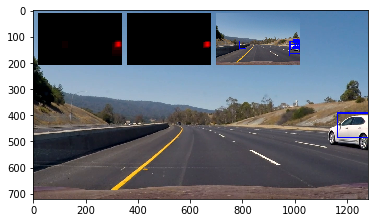


 23%|██▎       | 41/176 [04:06<13:33,  6.02s/it]

Found 23 bounding boxes, 1 smooted ones and 1 labels
Appending new object with centroid: (1217, 450)
previously detected objects= 1
so far newly detected objects= 1



 24%|██▍       | 42/176 [04:12<13:32,  6.06s/it]

Found 23 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1217, 450)
new centroid= (1217, 447)
old bbox= [[1155  392]
 [1279  508]]
new bbox= [[1155  385]
 [1279  509]]
previously detected objects= 1
so far newly detected objects= 1



 24%|██▍       | 43/176 [04:19<13:30,  6.09s/it]

Found 21 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1217, 447)
new centroid= (1215, 448)
old bbox= [[1155  385]
 [1279  509]]
new bbox= [[1153  386]
 [1277  510]]
previously detected objects= 1
so far newly detected objects= 1



 25%|██▌       | 44/176 [04:25<13:26,  6.11s/it]

Found 22 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1215, 448)
new centroid= (1214, 449)
old bbox= [[1153  386]
 [1277  510]]
new bbox= [[1152  387]
 [1276  511]]
previously detected objects= 1
so far newly detected objects= 1



 26%|██▌       | 45/176 [04:31<13:09,  6.02s/it]

Found 16 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1214, 449)
new centroid= (1207, 451)
old bbox= [[1152  387]
 [1276  511]]
new bbox= [[1141  389]
 [1273  513]]
previously detected objects= 1
so far newly detected objects= 1



 26%|██▌       | 46/176 [04:36<12:52,  5.94s/it]

Found 19 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1207, 451)
new centroid= (1203, 452)
old bbox= [[1141  389]
 [1273  513]]
new bbox= [[1137  390]
 [1269  514]]
previously detected objects= 1
so far newly detected objects= 1



 27%|██▋       | 47/176 [04:42<12:42,  5.91s/it]

Found 19 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1203, 452)
new centroid= (1203, 450)
old bbox= [[1137  390]
 [1269  514]]
new bbox= [[1137  385]
 [1269  515]]
previously detected objects= 1
so far newly detected objects= 1



 27%|██▋       | 48/176 [04:48<12:33,  5.88s/it]

Found 19 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1203, 450)
new centroid= (1198, 442)
old bbox= [[1137  385]
 [1269  515]]
new bbox= [[1132  377]
 [1264  507]]
previously detected objects= 1
so far newly detected objects= 1



 28%|██▊       | 49/176 [04:54<12:24,  5.86s/it]

Found 19 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1198, 442)
new centroid= (1197, 440)
old bbox= [[1132  377]
 [1264  507]]
new bbox= [[1131  375]
 [1263  505]]
previously detected objects= 1
so far newly detected objects= 1


Found 20 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1197, 440)
new centroid= (1194, 437)
old bbox= [[1131  375]
 [1263  505]]
new bbox= [[1128  372]
 [1260  502]]
previously detected objects= 1
number of times detected object appeared:  9
** ADDING **
Refresh at frame n 50: newly detected objects 1



 29%|██▉       | 51/176 [05:08<13:13,  6.35s/it]

Found 24 bounding boxes, 1 smooted ones and 1 labels
Appending new object with centroid: (1185, 448)
previously detected objects= 1
so far newly detected objects= 1



 30%|██▉       | 52/176 [05:14<13:16,  6.42s/it]

Found 23 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1185, 448)
new centroid= (1188, 441)
old bbox= [[1120  383]
 [1250  514]]
new bbox= [[1123  376]
 [1253  506]]
previously detected objects= 1
so far newly detected objects= 1



 30%|███       | 53/176 [05:21<13:05,  6.39s/it]

Found 19 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1188, 441)
new centroid= (1188, 437)
old bbox= [[1123  376]
 [1253  506]]
new bbox= [[1123  372]
 [1253  502]]
previously detected objects= 1
so far newly detected objects= 1



 31%|███       | 54/176 [05:27<12:57,  6.37s/it]

Found 19 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1188, 437)
new centroid= (1190, 437)
old bbox= [[1123  372]
 [1253  502]]
new bbox= [[1125  372]
 [1255  502]]
previously detected objects= 1
so far newly detected objects= 1



 31%|███▏      | 55/176 [05:34<13:03,  6.48s/it]

Found 20 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1190, 437)
new centroid= (1191, 433)
old bbox= [[1125  372]
 [1255  502]]
new bbox= [[1126  368]
 [1256  498]]
previously detected objects= 1
so far newly detected objects= 1



 32%|███▏      | 56/176 [05:40<12:51,  6.43s/it]

Found 36 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1191, 433)
new centroid= (1192, 439)
old bbox= [[1126  368]
 [1256  498]]
new bbox= [[1119  371]
 [1265  507]]
previously detected objects= 1
so far newly detected objects= 1



 32%|███▏      | 57/176 [05:46<12:45,  6.43s/it]

Found 35 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1192, 439)
new centroid= (1194, 443)
old bbox= [[1119  371]
 [1265  507]]
new bbox= [[1111  375]
 [1277  511]]
previously detected objects= 1
so far newly detected objects= 1



 33%|███▎      | 58/176 [05:53<12:40,  6.44s/it]

Found 32 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1194, 443)
new centroid= (1195, 439)
old bbox= [[1111  375]
 [1277  511]]
new bbox= [[1112  371]
 [1278  507]]
previously detected objects= 1
so far newly detected objects= 1



 34%|███▎      | 59/176 [05:59<12:36,  6.47s/it]

Found 35 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1195, 439)
new centroid= (1195, 443)
old bbox= [[1112  371]
 [1278  507]]
new bbox= [[1112  375]
 [1278  511]]
previously detected objects= 1
so far newly detected objects= 1


Found 30 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1195, 443)
new centroid= (1188, 445)
old bbox= [[1112  375]
 [1278  511]]
new bbox= [[1105  377]
 [1271  513]]
previously detected objects= 1
number of times detected object appeared:  9
** ADDING **
Refresh at frame n 60: newly detected objects 1



 35%|███▍      | 61/176 [06:13<12:30,  6.53s/it]

Found 33 bounding boxes, 1 smooted ones and 1 labels
Appending new object with centroid: (1190, 445)
previously detected objects= 1
so far newly detected objects= 1



 35%|███▌      | 62/176 [06:19<12:28,  6.57s/it]

Found 30 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1190, 445)
new centroid= (1190, 446)
old bbox= [[1113  383]
 [1267  508]]
new bbox= [[1108  381]
 [1272  511]]
previously detected objects= 1
so far newly detected objects= 1



 36%|███▌      | 63/176 [06:26<12:15,  6.51s/it]

Found 27 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1190, 446)
new centroid= (1188, 447)
old bbox= [[1108  381]
 [1272  511]]
new bbox= [[1106  382]
 [1270  512]]
previously detected objects= 1
so far newly detected objects= 1



 36%|███▋      | 64/176 [06:32<11:59,  6.43s/it]

Found 35 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1188, 447)
new centroid= (1185, 454)
old bbox= [[1106  382]
 [1270  512]]
new bbox= [[1095  376]
 [1275  532]]
previously detected objects= 1
so far newly detected objects= 1



 37%|███▋      | 65/176 [06:38<12:00,  6.49s/it]

Found 33 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1185, 454)
new centroid= (1189, 451)
old bbox= [[1095  376]
 [1275  532]]
new bbox= [[1099  373]
 [1279  529]]
previously detected objects= 1
so far newly detected objects= 1



 38%|███▊      | 66/176 [06:45<11:47,  6.43s/it]

Found 34 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1189, 451)
new centroid= (1191, 449)
old bbox= [[1099  373]
 [1279  529]]
new bbox= [[1101  371]
 [1281  527]]
previously detected objects= 1
so far newly detected objects= 1



 38%|███▊      | 67/176 [06:51<11:34,  6.37s/it]

Found 32 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1191, 449)
new centroid= (1192, 448)
old bbox= [[1101  371]
 [1281  527]]
new bbox= [[1102  370]
 [1282  526]]
previously detected objects= 1
so far newly detected objects= 1



 39%|███▊      | 68/176 [06:57<11:24,  6.34s/it]

Found 36 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1192, 448)
new centroid= (1192, 446)
old bbox= [[1102  370]
 [1282  526]]
new bbox= [[1102  368]
 [1282  524]]
previously detected objects= 1
so far newly detected objects= 1



 39%|███▉      | 69/176 [07:04<11:26,  6.42s/it]

Found 36 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1192, 446)
new centroid= (1194, 442)
old bbox= [[1102  368]
 [1282  524]]
new bbox= [[1104  364]
 [1284  520]]
previously detected objects= 1
so far newly detected objects= 1


Found 39 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1194, 442)
new centroid= (1193, 445)
old bbox= [[1104  364]
 [1284  520]]
new bbox= [[1103  367]
 [1283  523]]
previously detected objects= 1
number of times detected object appeared:  9
** ADDING **
Refresh at frame n 70: newly detected objects 1


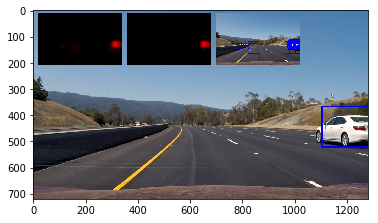


 40%|████      | 71/176 [07:17<11:09,  6.38s/it]

Found 32 bounding boxes, 1 smooted ones and 1 labels
Appending new object with centroid: (1193, 448)
previously detected objects= 1
so far newly detected objects= 1



 41%|████      | 72/176 [07:23<11:07,  6.42s/it]

Found 32 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1193, 448)
new centroid= (1194, 448)
old bbox= [[1108  383]
 [1279  514]]
new bbox= [[1109  383]
 [1279  513]]
previously detected objects= 1
so far newly detected objects= 1



 41%|████▏     | 73/176 [07:30<11:03,  6.44s/it]

Found 31 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1194, 448)
new centroid= (1193, 448)
old bbox= [[1109  383]
 [1279  513]]
new bbox= [[1108  383]
 [1278  513]]
previously detected objects= 1
so far newly detected objects= 1



 42%|████▏     | 74/176 [07:36<10:50,  6.38s/it]

Found 30 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1193, 448)
new centroid= (1194, 444)
old bbox= [[1108  383]
 [1278  513]]
new bbox= [[1109  379]
 [1279  509]]
previously detected objects= 1
so far newly detected objects= 1



 43%|████▎     | 75/176 [07:42<10:40,  6.34s/it]

Found 33 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1194, 444)
new centroid= (1193, 446)
old bbox= [[1109  379]
 [1279  509]]
new bbox= [[1108  381]
 [1278  511]]
previously detected objects= 1
so far newly detected objects= 1



 43%|████▎     | 76/176 [07:49<10:44,  6.44s/it]

Found 37 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1193, 446)
new centroid= (1189, 446)
old bbox= [[1108  381]
 [1278  511]]
new bbox= [[1096  378]
 [1282  514]]
previously detected objects= 1
so far newly detected objects= 1



 44%|████▍     | 77/176 [07:55<10:29,  6.36s/it]

Found 37 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1189, 446)
new centroid= (1191, 447)
old bbox= [[1096  378]
 [1282  514]]
new bbox= [[1098  379]
 [1284  515]]
previously detected objects= 1
so far newly detected objects= 1



 44%|████▍     | 78/176 [08:01<10:20,  6.34s/it]

Found 44 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1191, 447)
new centroid= (1192, 447)
old bbox= [[1098  379]
 [1284  515]]
new bbox= [[1099  379]
 [1285  515]]
previously detected objects= 1
so far newly detected objects= 1



 45%|████▍     | 79/176 [08:08<10:17,  6.37s/it]

Found 49 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1192, 447)
new centroid= (1188, 444)
old bbox= [[1099  379]
 [1285  515]]
new bbox= [[1095  373]
 [1281  515]]
previously detected objects= 1
so far newly detected objects= 1


Found 43 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1188, 444)
new centroid= (1190, 446)
old bbox= [[1095  373]
 [1281  515]]
new bbox= [[1097  375]
 [1283  517]]
previously detected objects= 1
number of times detected object appeared:  9
** ADDING **
Refresh at frame n 80: newly detected objects 1


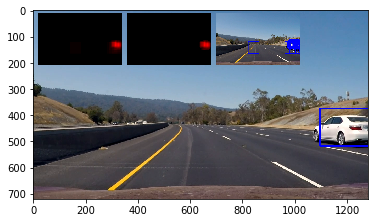


 46%|████▌     | 81/176 [08:21<10:14,  6.47s/it]

Found 48 bounding boxes, 1 smooted ones and 1 labels
Appending new object with centroid: (1181, 455)
previously detected objects= 1
so far newly detected objects= 1



 47%|████▋     | 82/176 [08:27<10:04,  6.43s/it]

Found 47 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1181, 455)
new centroid= (1181, 455)
old bbox= [[1083  371]
 [1279  539]]
new bbox= [[1083  371]
 [1279  539]]
previously detected objects= 1
so far newly detected objects= 1



 47%|████▋     | 83/176 [08:34<10:02,  6.48s/it]

Found 49 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1181, 455)
new centroid= (1181, 455)
old bbox= [[1083  371]
 [1279  539]]
new bbox= [[1083  371]
 [1279  539]]
previously detected objects= 1
so far newly detected objects= 1



 48%|████▊     | 84/176 [08:40<09:50,  6.42s/it]

Found 48 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1181, 455)
new centroid= (1181, 455)
old bbox= [[1083  371]
 [1279  539]]
new bbox= [[1083  371]
 [1279  539]]
previously detected objects= 1
so far newly detected objects= 1



 48%|████▊     | 85/176 [08:46<09:38,  6.36s/it]

Found 50 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1181, 455)
new centroid= (1181, 455)
old bbox= [[1083  371]
 [1279  539]]
new bbox= [[1083  371]
 [1279  539]]
previously detected objects= 1
so far newly detected objects= 1



 49%|████▉     | 86/176 [08:53<09:31,  6.34s/it]

Found 60 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1181, 455)
new centroid= (1181, 460)
old bbox= [[1083  371]
 [1279  539]]
new bbox= [[1083  366]
 [1279  554]]
previously detected objects= 1
so far newly detected objects= 1



 49%|████▉     | 87/176 [08:59<09:29,  6.40s/it]

Found 52 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1181, 460)
new centroid= (1181, 451)
old bbox= [[1083  366]
 [1279  554]]
new bbox= [[1083  357]
 [1279  545]]
previously detected objects= 1
so far newly detected objects= 1



 50%|█████     | 88/176 [09:05<09:17,  6.33s/it]

Found 45 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1181, 451)
new centroid= (1181, 453)
old bbox= [[1083  357]
 [1279  545]]
new bbox= [[1083  359]
 [1279  547]]
previously detected objects= 1
so far newly detected objects= 1



 51%|█████     | 89/176 [09:12<09:07,  6.30s/it]

Found 51 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1181, 453)
new centroid= (1178, 454)
old bbox= [[1083  359]
 [1279  547]]
new bbox= [[1074  360]
 [1282  548]]
previously detected objects= 1
so far newly detected objects= 1


Found 57 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1178, 454)
new centroid= (1179, 454)
old bbox= [[1074  360]
 [1282  548]]
new bbox= [[1075  360]
 [1283  548]]
previously detected objects= 1
number of times detected object appeared:  9
** ADDING **
Refresh at frame n 90: newly detected objects 1


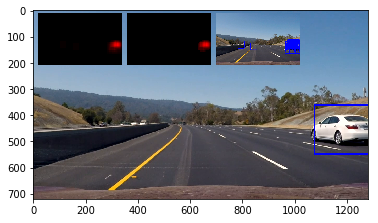


 52%|█████▏    | 91/176 [09:25<09:09,  6.46s/it]

Found 55 bounding boxes, 1 smooted ones and 1 labels
Appending new object with centroid: (1181, 455)
previously detected objects= 1
so far newly detected objects= 1



 52%|█████▏    | 92/176 [09:31<08:55,  6.38s/it]

Found 61 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1181, 455)
new centroid= (1178, 455)
old bbox= [[1083  371]
 [1279  539]]
new bbox= [[1074  371]
 [1282  539]]
previously detected objects= 1
so far newly detected objects= 1



 53%|█████▎    | 93/176 [09:37<08:48,  6.36s/it]

Found 53 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1178, 455)
new centroid= (1175, 458)
old bbox= [[1074  371]
 [1282  539]]
new bbox= [[1071  374]
 [1279  542]]
previously detected objects= 1
so far newly detected objects= 1



 53%|█████▎    | 94/176 [09:44<08:48,  6.45s/it]

Found 44 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1175, 458)
new centroid= (1173, 459)
old bbox= [[1071  374]
 [1279  542]]
new bbox= [[1069  375]
 [1277  543]]
previously detected objects= 1
so far newly detected objects= 1



 54%|█████▍    | 95/176 [09:50<08:37,  6.39s/it]

Found 52 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1173, 459)
new centroid= (1172, 457)
old bbox= [[1069  375]
 [1277  543]]
new bbox= [[1068  373]
 [1276  541]]
previously detected objects= 1
so far newly detected objects= 1



 55%|█████▍    | 96/176 [09:57<08:28,  6.36s/it]

Found 50 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1172, 457)
new centroid= (1171, 459)
old bbox= [[1068  373]
 [1276  541]]
new bbox= [[1067  375]
 [1275  543]]
previously detected objects= 1
so far newly detected objects= 1



 55%|█████▌    | 97/176 [10:03<08:25,  6.40s/it]

Found 46 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1171, 459)
new centroid= (1171, 457)
old bbox= [[1067  375]
 [1275  543]]
new bbox= [[1067  373]
 [1275  541]]
previously detected objects= 1
so far newly detected objects= 1



 56%|█████▌    | 98/176 [10:09<08:12,  6.32s/it]

Found 53 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1171, 457)
new centroid= (1167, 461)
old bbox= [[1067  373]
 [1275  541]]
new bbox= [[1061  367]
 [1273  555]]
previously detected objects= 1
so far newly detected objects= 1



 56%|█████▋    | 99/176 [10:15<07:52,  6.14s/it]

Found 54 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1167, 461)
new centroid= (1165, 466)
old bbox= [[1061  367]
 [1273  555]]
new bbox= [[1059  372]
 [1271  560]]
Appending new object with centroid: (250, 449)
previously detected objects= 1
so far newly detected objects= 2


Found 75 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1165, 466)
new centroid= (1171, 463)
old bbox= [[1059  372]
 [1271  560]]
new bbox= [[1065  369]
 [1277  557]]
**Found a match**
old centroid= (250, 449)
new centroid= (238, 451)
old bbox= [[210 406]
 [290 492]]
new bbox= [[163 397]
 [313 505]]
previously detected objects= 1
number of times detected object appeared:  9
** ADDING **
number of times detected object appeared:  1
Refresh at frame n 100: newly detected objects 1


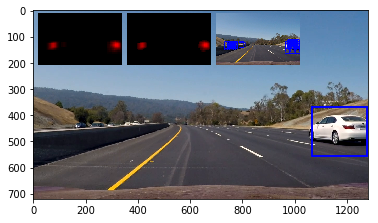


 57%|█████▋    | 101/176 [10:26<07:22,  5.90s/it]

Found 72 bounding boxes, 2 smooted ones and 2 labels
Appending new object with centroid: (1165, 448)
Appending new object with centroid: (230, 454)
previously detected objects= 1
so far newly detected objects= 2



 58%|█████▊    | 102/176 [10:32<07:07,  5.77s/it]

Found 77 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1165, 448)
new centroid= (1165, 451)
old bbox= [[1058  383]
 [1273  514]]
new bbox= [[1058  367]
 [1272  535]]
**Found a match**
old centroid= (230, 454)
new centroid= (222, 452)
old bbox= [[168 400]
 [293 508]]
new bbox= [[154 394]
 [290 510]]
previously detected objects= 1
so far newly detected objects= 2



 59%|█████▊    | 103/176 [10:38<07:05,  5.82s/it]

Found 79 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1165, 451)
new centroid= (1168, 453)
old bbox= [[1058  367]
 [1272  535]]
new bbox= [[1061  369]
 [1275  537]]
**Found a match**
old centroid= (222, 452)
new centroid= (201, 454)
old bbox= [[154 394]
 [290 510]]
new bbox= [[133 396]
 [269 512]]
previously detected objects= 1
so far newly detected objects= 2



 59%|█████▉    | 104/176 [10:43<06:54,  5.75s/it]

Found 62 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1168, 453)
new centroid= (1166, 457)
old bbox= [[1061  369]
 [1275  537]]
new bbox= [[1059  373]
 [1273  541]]
**Found a match**
old centroid= (201, 454)
new centroid= (177, 455)
old bbox= [[133 396]
 [269 512]]
new bbox= [[109 397]
 [245 513]]
previously detected objects= 1
so far newly detected objects= 2



 60%|█████▉    | 105/176 [10:49<06:42,  5.67s/it]

Found 67 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1166, 457)
new centroid= (1163, 459)
old bbox= [[1059  373]
 [1273  541]]
new bbox= [[1053  375]
 [1273  543]]
Appending new object with centroid: (113, 460)
previously detected objects= 1
so far newly detected objects= 3



 60%|██████    | 106/176 [14:06<1:13:30, 63.01s/it]

Found 58 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1163, 459)
new centroid= (1163, 460)
old bbox= [[1053  375]
 [1273  543]]
new bbox= [[1053  376]
 [1273  544]]
**Found a match**
old centroid= (113, 460)
new centroid= (91, 458)
old bbox= [[ 67 413]
 [159 508]]
new bbox= [[ 45 411]
 [137 505]]
previously detected objects= 1
so far newly detected objects= 3



 61%|██████    | 107/176 [14:11<52:39, 45.78s/it]  

Found 58 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1163, 460)
new centroid= (1163, 460)
old bbox= [[1053  376]
 [1273  544]]
new bbox= [[1053  376]
 [1273  544]]
**Found a match**
old centroid= (91, 458)
new centroid= (71, 454)
old bbox= [[ 45 411]
 [137 505]]
new bbox= [[ 25 407]
 [117 501]]
previously detected objects= 1
so far newly detected objects= 3



 61%|██████▏   | 108/176 [14:22<39:53, 35.20s/it]

Found 63 bounding boxes, 1 smooted ones and 2 labels
**Found a match**
old centroid= (1163, 460)
new centroid= (1163, 460)
old bbox= [[1053  376]
 [1273  544]]
new bbox= [[1053  376]
 [1273  544]]
previously detected objects= 1
so far newly detected objects= 3



 62%|██████▏   | 109/176 [14:29<29:52, 26.76s/it]

Found 55 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1163, 460)
new centroid= (1166, 460)
old bbox= [[1053  376]
 [1273  544]]
new bbox= [[1056  376]
 [1276  544]]
previously detected objects= 1
so far newly detected objects= 3


Found 55 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1166, 460)
new centroid= (1165, 457)
old bbox= [[1056  376]
 [1276  544]]
new bbox= [[1055  373]
 [1275  541]]
previously detected objects= 1
number of times detected object appeared:  9
** ADDING **
number of times detected object appeared:  3
number of times detected object appeared:  2
Refresh at frame n 110: newly detected objects 1


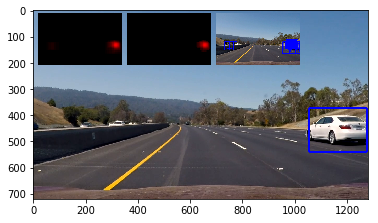


 63%|██████▎   | 111/176 [14:42<17:48, 16.44s/it]

Found 61 bounding boxes, 2 smooted ones and 2 labels
Appending new object with centroid: (1160, 461)
Appending new object with centroid: (318, 443)
previously detected objects= 1
so far newly detected objects= 2



 64%|██████▎   | 112/176 [14:48<14:16, 13.38s/it]

Found 70 bounding boxes, 3 smooted ones and 3 labels
**Found a match**
old centroid= (1160, 461)
new centroid= (1160, 461)
old bbox= [[1050  383]
 [1271  539]]
new bbox= [[1050  383]
 [1270  539]]
**Found a match**
old centroid= (318, 443)
new centroid= (307, 444)
old bbox= [[294 417]
 [343 469]]
new bbox= [[262 398]
 [352 490]]
Appending new object with centroid: (195, 460)
previously detected objects= 1
so far newly detected objects= 3



 64%|██████▍   | 113/176 [14:54<11:48, 11.24s/it]

Found 70 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1160, 461)
new centroid= (1160, 458)
old bbox= [[1050  383]
 [1270  539]]
new bbox= [[1050  374]
 [1270  542]]
previously detected objects= 1
so far newly detected objects= 3



 65%|██████▍   | 114/176 [15:01<10:02,  9.71s/it]

Found 83 bounding boxes, 3 smooted ones and 3 labels
**Found a match**
old centroid= (1160, 458)
new centroid= (1160, 459)
old bbox= [[1050  374]
 [1270  542]]
new bbox= [[1050  375]
 [1270  543]]
**Found a match**
old centroid= (195, 460)
new centroid= (182, 458)
old bbox= [[176 413]
 [214 508]]
new bbox= [[138 401]
 [226 515]]
**Found a match**
old centroid= (307, 444)
new centroid= (290, 445)
old bbox= [[262 398]
 [352 490]]
new bbox= [[245 399]
 [335 491]]
previously detected objects= 1
so far newly detected objects= 3



 65%|██████▌   | 115/176 [15:07<08:45,  8.62s/it]

Found 77 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1160, 459)
new centroid= (1162, 460)
old bbox= [[1050  375]
 [1270  543]]
new bbox= [[1052  376]
 [1272  544]]
**Found a match**
old centroid= (182, 458)
new centroid= (195, 456)
old bbox= [[138 401]
 [226 515]]
new bbox= [[112 399]
 [278 513]]
previously detected objects= 1
so far newly detected objects= 3



 66%|██████▌   | 116/176 [15:13<07:50,  7.85s/it]

Found 109 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1162, 460)
new centroid= (1161, 460)
old bbox= [[1052  376]
 [1272  544]]
new bbox= [[1051  376]
 [1271  544]]
**Found a match**
old centroid= (195, 456)
new centroid= (184, 456)
old bbox= [[112 399]
 [278 513]]
new bbox= [[ 66 399]
 [302 513]]
previously detected objects= 1
so far newly detected objects= 3



 66%|██████▋   | 117/176 [15:19<07:12,  7.33s/it]

Found 103 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1161, 460)
new centroid= (1152, 460)
old bbox= [[1051  376]
 [1271  544]]
new bbox= [[1042  376]
 [1262  544]]
**Found a match**
old centroid= (184, 456)
new centroid= (166, 455)
old bbox= [[ 66 399]
 [302 513]]
new bbox= [[ 39 398]
 [293 512]]
previously detected objects= 1
so far newly detected objects= 3



 67%|██████▋   | 118/176 [15:25<06:49,  7.05s/it]

Found 80 bounding boxes, 4 smooted ones and 4 labels
**Found a match**
old centroid= (1152, 460)
new centroid= (1147, 460)
old bbox= [[1042  376]
 [1262  544]]
new bbox= [[1037  376]
 [1257  544]]
**Found a match**
old centroid= (166, 455)
new centroid= (179, 456)
old bbox= [[ 39 398]
 [293 512]]
new bbox= [[ 52 399]
 [306 513]]
Appending new object with centroid: (55, 460)
**Found a match**
old centroid= (55, 460)
new centroid= (81, 460)
old bbox= [[ 16 413]
 [ 95 508]]
new bbox= [[ 42 413]
 [120 507]]
previously detected objects= 1
so far newly detected objects= 4



 68%|██████▊   | 119/176 [15:31<06:25,  6.76s/it]

Found 94 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1147, 460)
new centroid= (1149, 460)
old bbox= [[1037  376]
 [1257  544]]
new bbox= [[1030  376]
 [1268  544]]
**Found a match**
old centroid= (179, 456)
new centroid= (180, 456)
old bbox= [[ 52 399]
 [306 513]]
new bbox= [[ 53 399]
 [307 513]]
previously detected objects= 1
so far newly detected objects= 4


Found 90 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1149, 460)
new centroid= (1150, 460)
old bbox= [[1030  376]
 [1268  544]]
new bbox= [[1031  376]
 [1269  544]]
**Found a match**
old centroid= (180, 456)
new centroid= (169, 456)
old bbox= [[ 53 399]
 [307 513]]
new bbox= [[ 42 399]
 [296 513]]
previously detected objects= 1
number of times detected object appeared:  9
** ADDING **
number of times detected object appeared:  2
number of times detected object appeared:  7
number of times detected object appeared:  1
Refresh at frame n 120: newly detected objects 1


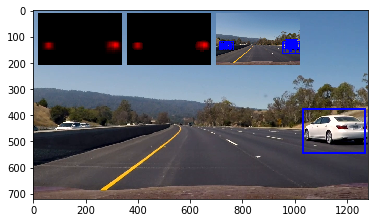


 69%|██████▉   | 121/176 [15:44<05:54,  6.45s/it]

Found 101 bounding boxes, 2 smooted ones and 2 labels
Appending new object with centroid: (1153, 455)
Appending new object with centroid: (135, 453)
previously detected objects= 1
so far newly detected objects= 2



 69%|██████▉   | 122/176 [15:50<05:41,  6.33s/it]

Found 105 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1153, 455)
new centroid= (1153, 458)
old bbox= [[1033  371]
 [1273  539]]
new bbox= [[1033  374]
 [1273  542]]
**Found a match**
old centroid= (135, 453)
new centroid= (119, 453)
old bbox= [[ 50 392]
 [221 514]]
new bbox= [[ 15 392]
 [223 514]]
previously detected objects= 1
so far newly detected objects= 2



 70%|██████▉   | 123/176 [15:56<05:37,  6.36s/it]

Found 96 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1153, 458)
new centroid= (1153, 459)
old bbox= [[1033  374]
 [1273  542]]
new bbox= [[1033  375]
 [1273  543]]
**Found a match**
old centroid= (119, 453)
new centroid= (113, 455)
old bbox= [[ 15 392]
 [223 514]]
new bbox= [[  9 394]
 [217 516]]
previously detected objects= 1
so far newly detected objects= 2



 70%|███████   | 124/176 [16:02<05:25,  6.27s/it]

Found 85 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1153, 459)
new centroid= (1153, 462)
old bbox= [[1033  375]
 [1273  543]]
new bbox= [[1033  378]
 [1273  546]]
**Found a match**
old centroid= (113, 455)
new centroid= (109, 456)
old bbox= [[  9 394]
 [217 516]]
new bbox= [[  5 395]
 [213 517]]
previously detected objects= 1
so far newly detected objects= 2



 71%|███████   | 125/176 [16:08<05:15,  6.19s/it]

Found 80 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1153, 462)
new centroid= (1151, 463)
old bbox= [[1033  378]
 [1273  546]]
new bbox= [[1030  379]
 [1272  547]]
**Found a match**
old centroid= (109, 456)
new centroid= (92, 456)
old bbox= [[  5 395]
 [213 517]]
new bbox= [[-12 395]
 [196 517]]
previously detected objects= 1
so far newly detected objects= 2



 72%|███████▏  | 126/176 [16:14<05:07,  6.16s/it]

Found 63 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1151, 463)
new centroid= (1151, 464)
old bbox= [[1030  379]
 [1272  547]]
new bbox= [[1029  380]
 [1273  548]]
**Found a match**
old centroid= (92, 456)
new centroid= (68, 457)
old bbox= [[-12 395]
 [196 517]]
new bbox= [[-36 396]
 [172 518]]
previously detected objects= 1
so far newly detected objects= 2



 72%|███████▏  | 127/176 [16:20<05:00,  6.13s/it]

Found 55 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1151, 464)
new centroid= (1150, 462)
old bbox= [[1029  380]
 [1273  548]]
new bbox= [[1028  378]
 [1272  546]]
previously detected objects= 1
so far newly detected objects= 2



 73%|███████▎  | 128/176 [16:27<04:54,  6.13s/it]

Found 63 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1150, 462)
new centroid= (1150, 461)
old bbox= [[1028  378]
 [1272  546]]
new bbox= [[1028  377]
 [1272  545]]
previously detected objects= 1
so far newly detected objects= 2



 73%|███████▎  | 129/176 [16:33<04:47,  6.11s/it]

Found 60 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1150, 461)
new centroid= (1150, 461)
old bbox= [[1028  377]
 [1272  545]]
new bbox= [[1028  377]
 [1272  545]]
previously detected objects= 1
so far newly detected objects= 2


Found 64 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1150, 461)
new centroid= (1151, 461)
old bbox= [[1028  377]
 [1272  545]]
new bbox= [[1029  377]
 [1273  545]]
previously detected objects= 1
number of times detected object appeared:  9
** ADDING **
number of times detected object appeared:  5
Refresh at frame n 130: newly detected objects 1


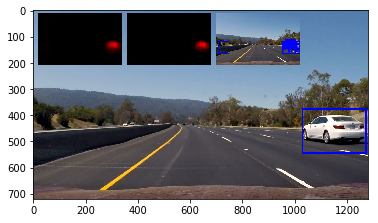


 74%|███████▍  | 131/176 [16:45<04:36,  6.15s/it]

Found 65 bounding boxes, 1 smooted ones and 1 labels
Appending new object with centroid: (1152, 461)
previously detected objects= 1
so far newly detected objects= 1



 75%|███████▌  | 132/176 [16:51<04:28,  6.10s/it]

Found 69 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1152, 461)
new centroid= (1151, 466)
old bbox= [[1033  383]
 [1271  539]]
new bbox= [[1030  378]
 [1272  554]]
previously detected objects= 1
so far newly detected objects= 1



 76%|███████▌  | 133/176 [16:57<04:21,  6.08s/it]

Found 63 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1151, 466)
new centroid= (1143, 463)
old bbox= [[1030  378]
 [1272  554]]
new bbox= [[1022  375]
 [1264  551]]
previously detected objects= 1
so far newly detected objects= 1



 76%|███████▌  | 134/176 [17:03<04:15,  6.08s/it]

Found 68 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1143, 463)
new centroid= (1144, 462)
old bbox= [[1022  375]
 [1264  551]]
new bbox= [[1020  374]
 [1268  550]]
previously detected objects= 1
so far newly detected objects= 1



 77%|███████▋  | 135/176 [17:09<04:08,  6.06s/it]

Found 66 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1144, 462)
new centroid= (1140, 461)
old bbox= [[1020  374]
 [1268  550]]
new bbox= [[1016  373]
 [1264  549]]
previously detected objects= 1
so far newly detected objects= 1



 77%|███████▋  | 136/176 [17:15<04:02,  6.06s/it]

Found 65 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1140, 461)
new centroid= (1145, 461)
old bbox= [[1016  373]
 [1264  549]]
new bbox= [[1021  373]
 [1269  549]]
previously detected objects= 1
so far newly detected objects= 1



 78%|███████▊  | 137/176 [17:21<03:58,  6.11s/it]

Found 61 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1145, 461)
new centroid= (1147, 466)
old bbox= [[1021  373]
 [1269  549]]
new bbox= [[1023  378]
 [1271  554]]
previously detected objects= 1
so far newly detected objects= 1



 78%|███████▊  | 138/176 [17:28<03:53,  6.14s/it]

Found 63 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1147, 466)
new centroid= (1149, 463)
old bbox= [[1023  378]
 [1271  554]]
new bbox= [[1025  375]
 [1273  551]]
previously detected objects= 1
so far newly detected objects= 1



 79%|███████▉  | 139/176 [17:34<03:46,  6.12s/it]

Found 64 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1149, 463)
new centroid= (1152, 467)
old bbox= [[1025  375]
 [1273  551]]
new bbox= [[1028  379]
 [1276  555]]
previously detected objects= 1
so far newly detected objects= 1


Found 58 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1152, 467)
new centroid= (1152, 464)
old bbox= [[1028  379]
 [1276  555]]
new bbox= [[1028  376]
 [1276  552]]
previously detected objects= 1
number of times detected object appeared:  9
** ADDING **
Refresh at frame n 140: newly detected objects 1


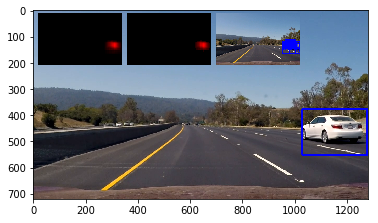


 80%|████████  | 141/176 [17:46<03:34,  6.13s/it]

Found 51 bounding boxes, 1 smooted ones and 1 labels
Appending new object with centroid: (1150, 448)
previously detected objects= 1
so far newly detected objects= 1



 81%|████████  | 142/176 [17:52<03:27,  6.10s/it]

Found 52 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1150, 448)
new centroid= (1147, 454)
old bbox= [[1050  383]
 [1250  514]]
new bbox= [[1043  376]
 [1251  532]]
previously detected objects= 1
so far newly detected objects= 1



 81%|████████▏ | 143/176 [17:58<03:21,  6.09s/it]

Found 54 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1147, 454)
new centroid= (1144, 457)
old bbox= [[1043  376]
 [1251  532]]
new bbox= [[1036  379]
 [1252  535]]
previously detected objects= 1
so far newly detected objects= 1



 82%|████████▏ | 144/176 [18:04<03:14,  6.08s/it]

Found 52 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1144, 457)
new centroid= (1140, 461)
old bbox= [[1036  379]
 [1252  535]]
new bbox= [[1026  383]
 [1254  539]]
previously detected objects= 1
so far newly detected objects= 1



 82%|████████▏ | 145/176 [18:10<03:08,  6.08s/it]

Found 51 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1140, 461)
new centroid= (1138, 463)
old bbox= [[1026  383]
 [1254  539]]
new bbox= [[1024  385]
 [1252  541]]
previously detected objects= 1
so far newly detected objects= 1



 83%|████████▎ | 146/176 [18:17<03:10,  6.34s/it]

Found 85 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1138, 463)
new centroid= (1137, 469)
old bbox= [[1024  385]
 [1252  541]]
new bbox= [[1008  386]
 [1266  552]]
Appending new object with centroid: (192, 460)
previously detected objects= 1
so far newly detected objects= 2



 84%|████████▎ | 147/176 [18:25<03:20,  6.91s/it]

Found 75 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1137, 469)
new centroid= (1137, 470)
old bbox= [[1008  386]
 [1266  552]]
new bbox= [[1008  382]
 [1266  558]]
**Found a match**
old centroid= (192, 460)
new centroid= (172, 460)
old bbox= [[126 413]
 [259 508]]
new bbox= [[106 413]
 [238 507]]
previously detected objects= 1
so far newly detected objects= 2



 84%|████████▍ | 148/176 [18:32<03:11,  6.83s/it]

Found 67 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1137, 470)
new centroid= (1135, 472)
old bbox= [[1008  382]
 [1266  558]]
new bbox= [[1006  384]
 [1264  560]]
Appending new object with centroid: (111, 454)
previously detected objects= 1
so far newly detected objects= 3



 85%|████████▍ | 149/176 [18:40<03:12,  7.14s/it]

Found 60 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1135, 472)
new centroid= (1141, 473)
old bbox= [[1006  384]
 [1264  560]]
new bbox= [[1012  385]
 [1270  561]]
previously detected objects= 1
so far newly detected objects= 3


Found 59 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1141, 473)
new centroid= (1144, 474)
old bbox= [[1012  385]
 [1270  561]]
new bbox= [[1015  386]
 [1273  562]]
previously detected objects= 1
number of times detected object appeared:  9
** ADDING **
number of times detected object appeared:  1
number of times detected object appeared:  0
Refresh at frame n 150: newly detected objects 1


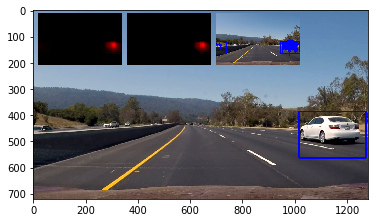


 86%|████████▌ | 151/176 [18:58<03:20,  8.01s/it]

Found 61 bounding boxes, 1 smooted ones and 1 labels
Appending new object with centroid: (1147, 475)
previously detected objects= 1
so far newly detected objects= 1



 86%|████████▋ | 152/176 [19:06<03:17,  8.22s/it]

Found 58 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1147, 475)
new centroid= (1143, 475)
old bbox= [[1022  392]
 [1273  559]]
new bbox= [[1018  392]
 [1268  558]]
previously detected objects= 1
so far newly detected objects= 1



 87%|████████▋ | 153/176 [19:15<03:10,  8.30s/it]

Found 60 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1143, 475)
new centroid= (1141, 473)
old bbox= [[1018  392]
 [1268  558]]
new bbox= [[1016  385]
 [1266  561]]
previously detected objects= 1
so far newly detected objects= 1



 88%|████████▊ | 154/176 [19:24<03:04,  8.40s/it]

Found 57 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1141, 473)
new centroid= (1140, 474)
old bbox= [[1016  385]
 [1266  561]]
new bbox= [[1015  386]
 [1265  562]]
previously detected objects= 1
so far newly detected objects= 1



 88%|████████▊ | 155/176 [19:33<02:59,  8.56s/it]

Found 55 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1140, 474)
new centroid= (1139, 469)
old bbox= [[1015  386]
 [1265  562]]
new bbox= [[1014  381]
 [1264  557]]
previously detected objects= 1
so far newly detected objects= 1



 89%|████████▊ | 156/176 [19:40<02:45,  8.30s/it]

Found 53 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1139, 469)
new centroid= (1134, 472)
old bbox= [[1014  381]
 [1264  557]]
new bbox= [[1009  384]
 [1259  560]]
previously detected objects= 1
so far newly detected objects= 1



 89%|████████▉ | 157/176 [19:46<02:24,  7.60s/it]

Found 53 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1134, 472)
new centroid= (1136, 473)
old bbox= [[1009  384]
 [1259  560]]
new bbox= [[1011  385]
 [1261  561]]
previously detected objects= 1
so far newly detected objects= 1



 90%|████████▉ | 158/176 [19:52<02:08,  7.13s/it]

Found 52 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1136, 473)
new centroid= (1133, 474)
old bbox= [[1011  385]
 [1261  561]]
new bbox= [[1008  386]
 [1258  562]]
previously detected objects= 1
so far newly detected objects= 1



 90%|█████████ | 159/176 [19:58<01:55,  6.80s/it]

Found 51 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1133, 474)
new centroid= (1131, 469)
old bbox= [[1008  386]
 [1258  562]]
new bbox= [[1006  381]
 [1256  557]]
previously detected objects= 1
so far newly detected objects= 1


Found 56 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1131, 469)
new centroid= (1131, 472)
old bbox= [[1006  381]
 [1256  557]]
new bbox= [[1006  384]
 [1256  560]]
previously detected objects= 1
number of times detected object appeared:  9
** ADDING **
Refresh at frame n 160: newly detected objects 1


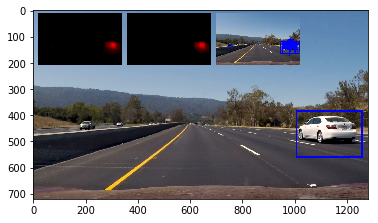


 91%|█████████▏| 161/176 [20:11<01:36,  6.46s/it]

Found 44 bounding boxes, 1 smooted ones and 1 labels
Appending new object with centroid: (1138, 475)
previously detected objects= 1
so far newly detected objects= 1



 92%|█████████▏| 162/176 [20:17<01:28,  6.31s/it]

Found 54 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1138, 475)
new centroid= (1134, 475)
old bbox= [[1029  392]
 [1248  559]]
new bbox= [[1018  392]
 [1250  558]]
previously detected objects= 1
so far newly detected objects= 1



 93%|█████████▎| 163/176 [20:23<01:20,  6.21s/it]

Found 53 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1134, 475)
new centroid= (1132, 470)
old bbox= [[1018  392]
 [1250  558]]
new bbox= [[1016  387]
 [1248  553]]
previously detected objects= 1
so far newly detected objects= 1



 93%|█████████▎| 164/176 [20:29<01:14,  6.17s/it]

Found 49 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1132, 470)
new centroid= (1133, 472)
old bbox= [[1016  387]
 [1248  553]]
new bbox= [[1017  389]
 [1249  555]]
previously detected objects= 1
so far newly detected objects= 1



 94%|█████████▍| 165/176 [20:35<01:07,  6.15s/it]

Found 52 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1133, 472)
new centroid= (1133, 473)
old bbox= [[1017  389]
 [1249  555]]
new bbox= [[1017  390]
 [1249  556]]
Appending new object with centroid: (124, 457)
previously detected objects= 1
so far newly detected objects= 2



 94%|█████████▍| 166/176 [20:41<01:01,  6.12s/it]

Found 66 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1133, 473)
new centroid= (1129, 474)
old bbox= [[1017  390]
 [1249  556]]
new bbox= [[1011  391]
 [1247  557]]
**Found a match**
old centroid= (124, 457)
new centroid= (114, 457)
old bbox= [[ 84 406]
 [164 508]]
new bbox= [[ 60 400]
 [168 514]]
previously detected objects= 1
so far newly detected objects= 2



 95%|█████████▍| 167/176 [20:47<00:54,  6.08s/it]

Found 77 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1129, 474)
new centroid= (1129, 474)
old bbox= [[1011  391]
 [1247  557]]
new bbox= [[1011  391]
 [1247  557]]
**Found a match**
old centroid= (114, 457)
new centroid= (95, 457)
old bbox= [[ 60 400]
 [168 514]]
new bbox= [[ 34 400]
 [156 514]]
previously detected objects= 1
so far newly detected objects= 2



 95%|█████████▌| 168/176 [20:53<00:48,  6.05s/it]

Found 66 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1129, 474)
new centroid= (1128, 474)
old bbox= [[1011  391]
 [1247  557]]
new bbox= [[1008  391]
 [1248  557]]
**Found a match**
old centroid= (95, 457)
new centroid= (71, 450)
old bbox= [[ 34 400]
 [156 514]]
new bbox= [[ 10 393]
 [132 507]]
previously detected objects= 1
so far newly detected objects= 2



 96%|█████████▌| 169/176 [20:59<00:42,  6.04s/it]

Found 63 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1128, 474)
new centroid= (1127, 474)
old bbox= [[1008  391]
 [1248  557]]
new bbox= [[1007  391]
 [1247  557]]
**Found a match**
old centroid= (71, 450)
new centroid= (70, 455)
old bbox= [[ 10 393]
 [132 507]]
new bbox= [[  9 398]
 [131 512]]
previously detected objects= 1
so far newly detected objects= 2


Found 62 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1127, 474)
new centroid= (1126, 474)
old bbox= [[1007  391]
 [1247  557]]
new bbox= [[1006  391]
 [1246  557]]
previously detected objects= 1
number of times detected object appeared:  9
** ADDING **
number of times detected object appeared:  4
Refresh at frame n 170: newly detected objects 1


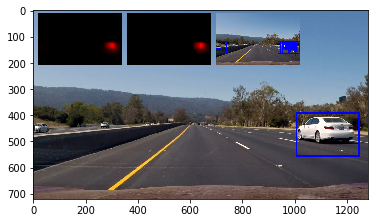


 97%|█████████▋| 171/176 [21:11<00:30,  6.08s/it]

Found 61 bounding boxes, 1 smooted ones and 1 labels
Appending new object with centroid: (1126, 475)
previously detected objects= 1
so far newly detected objects= 1



 98%|█████████▊| 172/176 [21:17<00:24,  6.08s/it]

Found 62 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1126, 475)
new centroid= (1119, 475)
old bbox= [[1008  392]
 [1244  559]]
new bbox= [[ 988  392]
 [1250  558]]
previously detected objects= 1
so far newly detected objects= 1



 98%|█████████▊| 173/176 [21:23<00:18,  6.11s/it]

Found 64 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1119, 475)
new centroid= (1114, 475)
old bbox= [[ 988  392]
 [1250  558]]
new bbox= [[ 983  392]
 [1245  558]]
previously detected objects= 1
so far newly detected objects= 1



 99%|█████████▉| 174/176 [21:29<00:12,  6.08s/it]

Found 65 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1114, 475)
new centroid= (1113, 475)
old bbox= [[ 983  392]
 [1245  558]]
new bbox= [[ 982  392]
 [1244  558]]
previously detected objects= 1
so far newly detected objects= 1



 99%|█████████▉| 175/176 [21:35<00:06,  6.08s/it]

Found 59 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1113, 475)
new centroid= (1108, 475)
old bbox= [[ 982  392]
 [1244  558]]
new bbox= [[ 977  392]
 [1239  558]]
previously detected objects= 1
so far newly detected objects= 1


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video_sample.mp4 

CPU times: user 17min 40s, sys: 20.7 s, total: 18min 1s
Wall time: 21min 37s


In [93]:
detector = VehicleDetectorWithMemory(classifier, normaliser, color_space="YCrCb", save_frame=False, 
                                     frame_sampling_rate=10, threshold=5, min_detection_count=8, 
                                     debug_imgs=True, cell_overlap=1)

clip1 = VideoFileClip(project_video_sample_path)
project_video_clip = clip1.fl_image(detector.process_image) #NOTE: this function expects color images!!
%time project_video_clip.write_videofile(project_video_sample_output_path, audio=False)

In [94]:
HTML("""
<video width="900" height="600" controls>
  <source src="{0}">
</video>
""".format(project_video_sample_output_path))

In [87]:
my_gif = VideoFileClip(project_video_sample_output_path).resize(width=480)
my_gif.subclip(0,6).write_gif("media/two_cars_detected.gif", fps=15)


[MoviePy] Building file media/two_cars_detected.gif with imageio


 99%|█████████▉| 90/91 [00:17<00:00,  4.72it/s]


In [90]:
my_saved_img_clip = VideoFileClip(project_video_sample_output_path)
my_saved_img_clip.save_frame("media/saved_detection.png", t='00:00:5')  # saves frame at time t

In [95]:
detector = VehicleDetectorWithMemory(classifier, normaliser, color_space="YCrCb", save_frame=False, 
                                     frame_sampling_rate=10, threshold=5, 
                                     min_detection_count=8, cell_overlap=1)

clip1 = VideoFileClip(project_video_path)
project_video_clip = clip1.fl_image(detector.process_image) #NOTE: this function expects color images!!
%time project_video_clip.write_videofile(project_video_output_path, audio=False)

Found 41 bounding boxes, 1 smooted ones and 1 labels
Appending new object with centroid: (150, 457)
previously detected objects= 0
so far newly detected objects= 1
[MoviePy] >>>> Building video output_videos/project_video.mp4
[MoviePy] Writing video output_videos/project_video.mp4



  0%|          | 1/1261 [00:10<3:37:06, 10.34s/it]

Found 41 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (150, 457)
new centroid= (150, 457)
old bbox= [[ 70 400]
 [231 514]]
new bbox= [[ 70 400]
 [230 514]]
previously detected objects= 0
so far newly detected objects= 1



  0%|          | 2/1261 [00:18<3:20:33,  9.56s/it]

Found 30 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (150, 457)
new centroid= (135, 455)
old bbox= [[ 70 400]
 [230 514]]
new bbox= [[ 55 394]
 [215 516]]
previously detected objects= 0
so far newly detected objects= 1



  0%|          | 3/1261 [00:26<3:16:15,  9.36s/it]

Found 28 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (135, 455)
new centroid= (112, 454)
old bbox= [[ 55 394]
 [215 516]]
new bbox= [[ 32 393]
 [192 515]]
previously detected objects= 0
so far newly detected objects= 1



  0%|          | 4/1261 [00:34<3:04:53,  8.83s/it]

Found 13 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (112, 454)
new centroid= (89, 454)
old bbox= [[ 32 393]
 [192 515]]
new bbox= [[  9 393]
 [169 515]]
previously detected objects= 0
so far newly detected objects= 1



  0%|          | 5/1261 [00:40<2:49:10,  8.08s/it]

Found 6 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 1



  0%|          | 6/1261 [00:46<2:35:40,  7.44s/it]

Found 0 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 1



  1%|          | 7/1261 [00:52<2:25:39,  6.97s/it]

Found 0 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 1



  1%|          | 8/1261 [00:58<2:19:31,  6.68s/it]

Found 0 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 1



  1%|          | 9/1261 [01:04<2:14:14,  6.43s/it]

Found 0 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 1



  1%|          | 10/1261 [01:10<2:12:36,  6.36s/it]

Found 1 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
number of times detected object appeared:  4
Refresh at frame n 10: newly detected objects 0



  1%|          | 11/1261 [01:16<2:08:50,  6.18s/it]

Found 0 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



  1%|          | 12/1261 [01:22<2:06:57,  6.10s/it]

Found 1 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



  1%|          | 13/1261 [01:28<2:04:48,  6.00s/it]

Found 0 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



  1%|          | 14/1261 [01:33<2:02:26,  5.89s/it]

Found 1 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



  1%|          | 15/1261 [01:39<2:00:46,  5.82s/it]

Found 0 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



  1%|▏         | 16/1261 [01:45<1:59:52,  5.78s/it]

Found 0 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



  1%|▏         | 17/1261 [01:51<2:00:40,  5.82s/it]

Found 0 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



  1%|▏         | 18/1261 [01:56<2:00:05,  5.80s/it]

Found 0 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



  2%|▏         | 19/1261 [02:02<1:59:15,  5.76s/it]

Found 0 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



  2%|▏         | 20/1261 [02:08<1:58:46,  5.74s/it]

Found 0 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
Refresh at frame n 20: newly detected objects 0



  2%|▏         | 21/1261 [02:13<1:58:11,  5.72s/it]

Found 0 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



  2%|▏         | 22/1261 [02:19<1:57:29,  5.69s/it]

Found 0 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



  2%|▏         | 23/1261 [02:25<1:57:09,  5.68s/it]

Found 0 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



  2%|▏         | 24/1261 [02:30<1:57:12,  5.68s/it]

Found 0 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



  2%|▏         | 25/1261 [02:36<1:56:59,  5.68s/it]

Found 0 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



  2%|▏         | 26/1261 [02:42<1:56:32,  5.66s/it]

Found 1 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



  2%|▏         | 27/1261 [02:47<1:56:37,  5.67s/it]

Found 1 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



  2%|▏         | 28/1261 [02:53<1:56:27,  5.67s/it]

Found 0 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



  2%|▏         | 29/1261 [02:59<1:56:13,  5.66s/it]

Found 0 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



  2%|▏         | 30/1261 [03:04<1:56:06,  5.66s/it]

Found 0 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
Refresh at frame n 30: newly detected objects 0



  2%|▏         | 31/1261 [03:10<1:55:46,  5.65s/it]

Found 1 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



  3%|▎         | 32/1261 [03:16<1:55:45,  5.65s/it]

Found 1 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



  3%|▎         | 33/1261 [03:21<1:55:16,  5.63s/it]

Found 0 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



  3%|▎         | 34/1261 [03:27<1:55:43,  5.66s/it]

Found 0 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



  3%|▎         | 35/1261 [03:33<1:55:47,  5.67s/it]

Found 0 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



  3%|▎         | 36/1261 [03:38<1:55:55,  5.68s/it]

Found 0 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



  3%|▎         | 37/1261 [03:44<1:55:56,  5.68s/it]

Found 0 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



  3%|▎         | 38/1261 [03:50<1:57:06,  5.74s/it]

Found 0 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



  3%|▎         | 39/1261 [03:56<1:56:54,  5.74s/it]

Found 1 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



  3%|▎         | 40/1261 [04:01<1:56:15,  5.71s/it]

Found 0 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
Refresh at frame n 40: newly detected objects 0



  3%|▎         | 41/1261 [04:07<1:55:28,  5.68s/it]

Found 0 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



  3%|▎         | 42/1261 [04:12<1:55:01,  5.66s/it]

Found 0 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



  3%|▎         | 43/1261 [04:18<1:55:36,  5.69s/it]

Found 0 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



  3%|▎         | 44/1261 [04:24<1:55:19,  5.69s/it]

Found 0 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



  4%|▎         | 45/1261 [04:30<1:55:17,  5.69s/it]

Found 1 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



  4%|▎         | 46/1261 [04:35<1:55:05,  5.68s/it]

Found 0 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



  4%|▎         | 47/1261 [04:41<1:55:02,  5.69s/it]

Found 0 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



  4%|▍         | 48/1261 [04:47<1:55:09,  5.70s/it]

Found 0 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



  4%|▍         | 49/1261 [04:52<1:55:29,  5.72s/it]

Found 0 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



  4%|▍         | 50/1261 [04:58<1:55:36,  5.73s/it]

Found 0 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
Refresh at frame n 50: newly detected objects 0



  4%|▍         | 51/1261 [05:04<1:55:14,  5.71s/it]

Found 1 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



  4%|▍         | 52/1261 [05:09<1:54:36,  5.69s/it]

Found 0 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



  4%|▍         | 53/1261 [05:15<1:54:24,  5.68s/it]

Found 0 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



  4%|▍         | 54/1261 [05:21<1:54:07,  5.67s/it]

Found 0 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



  4%|▍         | 55/1261 [05:27<1:54:16,  5.69s/it]

Found 0 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



  4%|▍         | 56/1261 [05:32<1:54:16,  5.69s/it]

Found 0 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



  5%|▍         | 57/1261 [05:38<1:54:05,  5.69s/it]

Found 0 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



  5%|▍         | 58/1261 [05:44<1:54:02,  5.69s/it]

Found 0 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



  5%|▍         | 59/1261 [05:50<1:55:43,  5.78s/it]

Found 1 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



  5%|▍         | 60/1261 [05:55<1:55:16,  5.76s/it]

Found 1 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
Refresh at frame n 60: newly detected objects 0



  5%|▍         | 61/1261 [06:01<1:55:09,  5.76s/it]

Found 1 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



  5%|▍         | 62/1261 [06:07<1:54:15,  5.72s/it]

Found 2 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



  5%|▍         | 63/1261 [06:14<2:01:45,  6.10s/it]

Found 1 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



  5%|▌         | 64/1261 [06:20<2:02:39,  6.15s/it]

Found 1 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



  5%|▌         | 65/1261 [06:26<2:01:52,  6.11s/it]

Found 1 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



  5%|▌         | 66/1261 [06:32<2:01:30,  6.10s/it]

Found 2 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



  5%|▌         | 67/1261 [06:38<2:03:33,  6.21s/it]

Found 1 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



  5%|▌         | 68/1261 [06:44<2:02:09,  6.14s/it]

Found 2 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



  5%|▌         | 69/1261 [06:50<2:00:17,  6.05s/it]

Found 0 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



  6%|▌         | 70/1261 [06:56<1:59:29,  6.02s/it]

Found 0 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
Refresh at frame n 70: newly detected objects 0



  6%|▌         | 71/1261 [07:02<1:58:15,  5.96s/it]

Found 2 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



  6%|▌         | 72/1261 [07:08<1:58:19,  5.97s/it]

Found 0 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



  6%|▌         | 73/1261 [07:14<1:58:15,  5.97s/it]

Found 0 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



  6%|▌         | 74/1261 [07:20<1:57:18,  5.93s/it]

Found 0 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



  6%|▌         | 75/1261 [07:26<1:56:53,  5.91s/it]

Found 0 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



  6%|▌         | 76/1261 [07:32<1:56:31,  5.90s/it]

Found 0 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



  6%|▌         | 77/1261 [07:37<1:55:57,  5.88s/it]

Found 0 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



  6%|▌         | 78/1261 [07:43<1:55:24,  5.85s/it]

Found 0 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



  6%|▋         | 79/1261 [07:49<1:56:34,  5.92s/it]

Found 0 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



  6%|▋         | 80/1261 [07:55<1:56:15,  5.91s/it]

Found 0 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
Refresh at frame n 80: newly detected objects 0



  6%|▋         | 81/1261 [08:01<1:55:45,  5.89s/it]

Found 0 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



  7%|▋         | 82/1261 [08:07<1:55:07,  5.86s/it]

Found 0 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



  7%|▋         | 83/1261 [08:13<1:54:39,  5.84s/it]

Found 1 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



  7%|▋         | 84/1261 [08:18<1:54:27,  5.84s/it]

Found 1 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



  7%|▋         | 85/1261 [08:24<1:54:29,  5.84s/it]

Found 0 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



  7%|▋         | 86/1261 [08:30<1:54:13,  5.83s/it]

Found 0 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



  7%|▋         | 87/1261 [08:36<1:54:00,  5.83s/it]

Found 1 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



  7%|▋         | 88/1261 [08:42<1:54:01,  5.83s/it]

Found 1 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



  7%|▋         | 89/1261 [08:48<1:53:39,  5.82s/it]

Found 0 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



  7%|▋         | 90/1261 [08:53<1:53:52,  5.83s/it]

Found 0 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
Refresh at frame n 90: newly detected objects 0



  7%|▋         | 91/1261 [08:59<1:53:41,  5.83s/it]

Found 8 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



  7%|▋         | 92/1261 [09:05<1:53:30,  5.83s/it]

Found 3 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



  7%|▋         | 93/1261 [09:11<1:53:07,  5.81s/it]

Found 1 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



  7%|▋         | 94/1261 [09:17<1:54:25,  5.88s/it]

Found 0 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



  8%|▊         | 95/1261 [09:23<1:54:39,  5.90s/it]

Found 1 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



  8%|▊         | 96/1261 [09:29<1:54:05,  5.88s/it]

Found 2 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



  8%|▊         | 97/1261 [09:35<1:53:46,  5.86s/it]

Found 5 bounding boxes, 1 smooted ones and 1 labels
Appending new object with centroid: (387, 437)
previously detected objects= 0
so far newly detected objects= 1



  8%|▊         | 98/1261 [09:40<1:53:21,  5.85s/it]

Found 2 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 1



  8%|▊         | 99/1261 [09:46<1:53:33,  5.86s/it]

Found 2 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 1



  8%|▊         | 100/1261 [09:52<1:54:10,  5.90s/it]

Found 4 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
number of times detected object appeared:  0
Refresh at frame n 100: newly detected objects 0



  8%|▊         | 101/1261 [09:58<1:53:52,  5.89s/it]

Found 4 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



  8%|▊         | 102/1261 [10:04<1:53:29,  5.87s/it]

Found 2 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



  8%|▊         | 103/1261 [10:10<1:53:00,  5.86s/it]

Found 3 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



  8%|▊         | 104/1261 [10:16<1:52:58,  5.86s/it]

Found 4 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



  8%|▊         | 105/1261 [10:21<1:52:30,  5.84s/it]

Found 3 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



  8%|▊         | 106/1261 [10:27<1:52:16,  5.83s/it]

Found 2 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



  8%|▊         | 107/1261 [10:33<1:52:15,  5.84s/it]

Found 1 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



  9%|▊         | 108/1261 [10:39<1:51:47,  5.82s/it]

Found 2 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



  9%|▊         | 109/1261 [10:45<1:51:56,  5.83s/it]

Found 0 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



  9%|▊         | 110/1261 [10:50<1:51:39,  5.82s/it]

Found 3 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
Refresh at frame n 110: newly detected objects 0



  9%|▉         | 111/1261 [10:56<1:51:20,  5.81s/it]

Found 4 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



  9%|▉         | 112/1261 [11:02<1:51:09,  5.80s/it]

Found 6 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



  9%|▉         | 113/1261 [11:08<1:50:47,  5.79s/it]

Found 3 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



  9%|▉         | 114/1261 [11:14<1:50:50,  5.80s/it]

Found 4 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



  9%|▉         | 115/1261 [11:19<1:50:43,  5.80s/it]

Found 3 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



  9%|▉         | 116/1261 [11:25<1:51:26,  5.84s/it]

Found 4 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



  9%|▉         | 117/1261 [11:31<1:52:15,  5.89s/it]

Found 5 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



  9%|▉         | 118/1261 [11:37<1:52:08,  5.89s/it]

Found 2 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



  9%|▉         | 119/1261 [11:44<1:58:44,  6.24s/it]

Found 1 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 0



 10%|▉         | 120/1261 [11:51<1:58:57,  6.26s/it]

Found 1 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
Refresh at frame n 120: newly detected objects 0



 10%|▉         | 121/1261 [11:57<2:01:16,  6.38s/it]

Found 27 bounding boxes, 2 smooted ones and 2 labels
Appending new object with centroid: (338, 446)
Appending new object with centroid: (146, 460)
previously detected objects= 0
so far newly detected objects= 2



 10%|▉         | 122/1261 [12:04<2:01:30,  6.40s/it]

Found 16 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (338, 446)
new centroid= (332, 442)
old bbox= [[266 400]
 [410 492]]
new bbox= [[260 395]
 [404 489]]
previously detected objects= 0
so far newly detected objects= 2



 10%|▉         | 123/1261 [12:10<2:01:01,  6.38s/it]

Found 7 bounding boxes, 0 smooted ones and 1 labels
previously detected objects= 0
so far newly detected objects= 2



 10%|▉         | 124/1261 [12:17<2:01:39,  6.42s/it]

Found 6 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (332, 442)
new centroid= (320, 442)
old bbox= [[260 395]
 [404 489]]
new bbox= [[248 395]
 [392 489]]
previously detected objects= 0
so far newly detected objects= 2



 10%|▉         | 125/1261 [12:23<2:02:19,  6.46s/it]

Found 2 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 2



 10%|▉         | 126/1261 [12:29<2:01:10,  6.41s/it]

Found 3 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 2



 10%|█         | 127/1261 [12:36<2:00:11,  6.36s/it]

Found 5 bounding boxes, 1 smooted ones and 1 labels
Appending new object with centroid: (249, 437)
previously detected objects= 0
so far newly detected objects= 3



 10%|█         | 128/1261 [12:42<2:01:52,  6.45s/it]

Found 6 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (249, 437)
new centroid= (241, 437)
old bbox= [[226 406]
 [273 469]]
new bbox= [[217 406]
 [265 468]]
previously detected objects= 0
so far newly detected objects= 3



 10%|█         | 129/1261 [12:49<2:00:57,  6.41s/it]

Found 7 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (241, 437)
new centroid= (231, 438)
old bbox= [[217 406]
 [265 468]]
new bbox= [[194 404]
 [268 472]]
previously detected objects= 0
so far newly detected objects= 3



 10%|█         | 130/1261 [12:55<2:00:01,  6.37s/it]

Found 11 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (231, 438)
new centroid= (218, 440)
old bbox= [[194 404]
 [268 472]]
new bbox= [[180 397]
 [256 483]]
previously detected objects= 0
number of times detected object appeared:  2
number of times detected object appeared:  0
number of times detected object appeared:  3
Refresh at frame n 130: newly detected objects 0



 10%|█         | 131/1261 [13:01<2:00:04,  6.38s/it]

Found 12 bounding boxes, 1 smooted ones and 1 labels
Appending new object with centroid: (195, 448)
previously detected objects= 0
so far newly detected objects= 1



 10%|█         | 132/1261 [13:08<2:01:34,  6.46s/it]

Found 16 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (195, 448)
new centroid= (184, 448)
old bbox= [[151 400]
 [240 497]]
new bbox= [[137 400]
 [231 496]]
previously detected objects= 0
so far newly detected objects= 1



 11%|█         | 133/1261 [13:14<2:00:10,  6.39s/it]

Found 15 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (184, 448)
new centroid= (170, 448)
old bbox= [[137 400]
 [231 496]]
new bbox= [[123 400]
 [217 496]]
previously detected objects= 0
so far newly detected objects= 1



 11%|█         | 134/1261 [13:21<1:59:43,  6.37s/it]

Found 14 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (170, 448)
new centroid= (150, 451)
old bbox= [[123 400]
 [217 496]]
new bbox= [[103 397]
 [197 505]]
previously detected objects= 0
so far newly detected objects= 1



 11%|█         | 135/1261 [13:27<2:00:38,  6.43s/it]

Found 22 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (150, 451)
new centroid= (136, 452)
old bbox= [[103 397]
 [197 505]]
new bbox= [[ 80 398]
 [192 506]]
previously detected objects= 0
so far newly detected objects= 1



 11%|█         | 136/1261 [13:34<2:00:56,  6.45s/it]

Found 21 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (136, 452)
new centroid= (114, 449)
old bbox= [[ 80 398]
 [192 506]]
new bbox= [[ 58 395]
 [170 503]]
previously detected objects= 0
so far newly detected objects= 1



 11%|█         | 137/1261 [13:40<1:59:44,  6.39s/it]

Found 24 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (114, 449)
new centroid= (91, 451)
old bbox= [[ 58 395]
 [170 503]]
new bbox= [[ 35 397]
 [147 505]]
previously detected objects= 0
so far newly detected objects= 1



 11%|█         | 138/1261 [13:46<1:59:49,  6.40s/it]

Found 27 bounding boxes, 2 smooted ones and 2 labels
Appending new object with centroid: (1053, 388)
**Found a match**
old centroid= (91, 451)
new centroid= (69, 446)
old bbox= [[ 35 397]
 [147 505]]
new bbox= [[ 13 392]
 [125 500]]
previously detected objects= 0
so far newly detected objects= 2



 11%|█         | 139/1261 [13:53<2:01:37,  6.50s/it]

Found 10 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 0
so far newly detected objects= 2



 11%|█         | 140/1261 [13:59<2:00:06,  6.43s/it]

Found 11 bounding boxes, 1 smooted ones and 1 labels
Appending new object with centroid: (164, 454)
previously detected objects= 0
number of times detected object appeared:  7
number of times detected object appeared:  0
number of times detected object appeared:  0
Refresh at frame n 140: newly detected objects 0



 11%|█         | 141/1261 [14:06<1:59:10,  6.38s/it]

Found 12 bounding boxes, 1 smooted ones and 1 labels
Appending new object with centroid: (136, 454)
previously detected objects= 0
so far newly detected objects= 1



 11%|█▏        | 142/1261 [14:12<1:59:50,  6.43s/it]

Found 15 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (136, 454)
new centroid= (116, 457)
old bbox= [[ 98 417]
 [175 492]]
new bbox= [[ 70 410]
 [162 504]]
previously detected objects= 0
so far newly detected objects= 1



 11%|█▏        | 143/1261 [14:19<1:59:55,  6.44s/it]

Found 16 bounding boxes, 2 smooted ones and 2 labels
Appending new object with centroid: (1116, 388)
**Found a match**
old centroid= (116, 457)
new centroid= (93, 458)
old bbox= [[ 70 410]
 [162 504]]
new bbox= [[ 44 411]
 [142 505]]
previously detected objects= 0
so far newly detected objects= 2



 11%|█▏        | 144/1261 [14:25<1:58:42,  6.38s/it]

Found 10 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1116, 388)
new centroid= (1126, 384)
old bbox= [[1092  364]
 [1141  413]]
new bbox= [[1097  353]
 [1155  415]]
previously detected objects= 0
so far newly detected objects= 2



 11%|█▏        | 145/1261 [14:31<1:58:09,  6.35s/it]

Found 10 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1126, 384)
new centroid= (1138, 382)
old bbox= [[1097  353]
 [1155  415]]
new bbox= [[1107  351]
 [1169  413]]
previously detected objects= 0
so far newly detected objects= 2



 12%|█▏        | 146/1261 [14:38<1:59:41,  6.44s/it]

Found 9 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1138, 382)
new centroid= (1151, 381)
old bbox= [[1107  351]
 [1169  413]]
new bbox= [[1120  350]
 [1182  412]]
previously detected objects= 0
so far newly detected objects= 2



 12%|█▏        | 147/1261 [14:44<1:58:45,  6.40s/it]

Found 10 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1151, 381)
new centroid= (1170, 384)
old bbox= [[1120  350]
 [1182  412]]
new bbox= [[1135  347]
 [1205  421]]
previously detected objects= 0
so far newly detected objects= 2



 12%|█▏        | 148/1261 [14:50<1:58:11,  6.37s/it]

Found 11 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1170, 384)
new centroid= (1191, 390)
old bbox= [[1135  347]
 [1205  421]]
new bbox= [[1154  343]
 [1228  437]]
previously detected objects= 0
so far newly detected objects= 2



 12%|█▏        | 149/1261 [14:57<1:58:47,  6.41s/it]

Found 14 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1191, 390)
new centroid= (1210, 397)
old bbox= [[1154  343]
 [1228  437]]
new bbox= [[1170  343]
 [1250  451]]
previously detected objects= 0
so far newly detected objects= 2



 12%|█▏        | 150/1261 [15:03<1:59:15,  6.44s/it]

Found 11 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1210, 397)
new centroid= (1227, 403)
old bbox= [[1170  343]
 [1250  451]]
new bbox= [[1187  349]
 [1267  457]]
previously detected objects= 0
number of times detected object appeared:  2
number of times detected object appeared:  7
Refresh at frame n 150: newly detected objects 0



 12%|█▏        | 151/1261 [15:10<1:58:10,  6.39s/it]

Found 12 bounding boxes, 1 smooted ones and 1 labels
Appending new object with centroid: (1244, 434)
previously detected objects= 0
so far newly detected objects= 1



 12%|█▏        | 152/1261 [15:16<1:57:22,  6.35s/it]

Found 9 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1244, 434)
new centroid= (1241, 435)
old bbox= [[1209  400]
 [1279  469]]
new bbox= [[1206  401]
 [1276  469]]
previously detected objects= 0
so far newly detected objects= 1



 12%|█▏        | 153/1261 [15:22<1:58:38,  6.42s/it]

Found 7 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1241, 435)
new centroid= (1241, 433)
old bbox= [[1206  401]
 [1276  469]]
new bbox= [[1206  399]
 [1276  467]]
previously detected objects= 0
so far newly detected objects= 1



 12%|█▏        | 154/1261 [15:29<1:57:57,  6.39s/it]

Found 10 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1241, 433)
new centroid= (1239, 433)
old bbox= [[1206  399]
 [1276  467]]
new bbox= [[1204  399]
 [1274  467]]
previously detected objects= 0
so far newly detected objects= 1



 12%|█▏        | 155/1261 [15:35<1:57:12,  6.36s/it]

Found 9 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1239, 433)
new centroid= (1238, 433)
old bbox= [[1204  399]
 [1274  467]]
new bbox= [[1203  399]
 [1273  467]]
previously detected objects= 0
so far newly detected objects= 1



 12%|█▏        | 156/1261 [15:41<1:57:21,  6.37s/it]

Found 6 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1238, 433)
new centroid= (1240, 432)
old bbox= [[1203  399]
 [1273  467]]
new bbox= [[1205  398]
 [1275  466]]
previously detected objects= 0
so far newly detected objects= 1



 12%|█▏        | 157/1261 [15:48<1:58:50,  6.46s/it]

Found 10 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1240, 432)
new centroid= (1238, 433)
old bbox= [[1205  398]
 [1275  466]]
new bbox= [[1203  399]
 [1273  467]]
previously detected objects= 0
so far newly detected objects= 1



 13%|█▎        | 158/1261 [15:54<1:57:53,  6.41s/it]

Found 12 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1238, 433)
new centroid= (1234, 433)
old bbox= [[1203  399]
 [1273  467]]
new bbox= [[1195  399]
 [1273  467]]
previously detected objects= 0
so far newly detected objects= 1



 13%|█▎        | 159/1261 [16:01<1:56:59,  6.37s/it]

Found 13 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1234, 433)
new centroid= (1234, 435)
old bbox= [[1195  399]
 [1273  467]]
new bbox= [[1190  398]
 [1278  472]]
previously detected objects= 0
so far newly detected objects= 1



 13%|█▎        | 160/1261 [16:07<1:58:06,  6.44s/it]

Found 9 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1234, 435)
new centroid= (1235, 434)
old bbox= [[1190  398]
 [1278  472]]
new bbox= [[1191  397]
 [1279  471]]
previously detected objects= 0
number of times detected object appeared:  9
** ADDING **
Refresh at frame n 160: newly detected objects 1



 13%|█▎        | 161/1261 [16:14<1:57:38,  6.42s/it]

Found 15 bounding boxes, 1 smooted ones and 1 labels
Appending new object with centroid: (1227, 439)
previously detected objects= 1
so far newly detected objects= 1



 13%|█▎        | 162/1261 [16:20<1:56:30,  6.36s/it]

Found 14 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1227, 439)
new centroid= (1227, 436)
old bbox= [[1176  392]
 [1279  487]]
new bbox= [[1176  389]
 [1278  483]]
previously detected objects= 1
so far newly detected objects= 1



 13%|█▎        | 163/1261 [16:26<1:56:06,  6.35s/it]

Found 18 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1227, 436)
new centroid= (1227, 437)
old bbox= [[1176  389]
 [1278  483]]
new bbox= [[1176  390]
 [1278  484]]
previously detected objects= 1
so far newly detected objects= 1



 13%|█▎        | 164/1261 [16:33<1:57:38,  6.43s/it]

Found 19 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1227, 437)
new centroid= (1227, 438)
old bbox= [[1176  390]
 [1278  484]]
new bbox= [[1176  391]
 [1278  485]]
previously detected objects= 1
so far newly detected objects= 1



 13%|█▎        | 165/1261 [16:39<1:56:36,  6.38s/it]

Found 22 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1227, 438)
new centroid= (1223, 438)
old bbox= [[1176  391]
 [1278  485]]
new bbox= [[1163  391]
 [1283  485]]
previously detected objects= 1
so far newly detected objects= 1



 13%|█▎        | 166/1261 [16:45<1:56:15,  6.37s/it]

Found 23 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1223, 438)
new centroid= (1220, 444)
old bbox= [[1163  391]
 [1283  485]]
new bbox= [[1158  386]
 [1282  502]]
previously detected objects= 1
so far newly detected objects= 1



 13%|█▎        | 167/1261 [16:51<1:50:13,  6.05s/it]

Found 23 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1220, 444)
new centroid= (1218, 444)
old bbox= [[1158  386]
 [1282  502]]
new bbox= [[1156  382]
 [1280  506]]
previously detected objects= 1
so far newly detected objects= 1



 13%|█▎        | 168/1261 [16:56<1:48:38,  5.96s/it]

Found 21 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1218, 444)
new centroid= (1215, 447)
old bbox= [[1156  382]
 [1280  506]]
new bbox= [[1153  385]
 [1277  509]]
previously detected objects= 1
so far newly detected objects= 1



 13%|█▎        | 169/1261 [17:02<1:46:51,  5.87s/it]

Found 22 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1215, 447)
new centroid= (1214, 448)
old bbox= [[1153  385]
 [1277  509]]
new bbox= [[1152  386]
 [1276  510]]
previously detected objects= 1
so far newly detected objects= 1



 13%|█▎        | 170/1261 [17:08<1:45:13,  5.79s/it]

Found 16 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1214, 448)
new centroid= (1207, 450)
old bbox= [[1152  386]
 [1276  510]]
new bbox= [[1141  388]
 [1273  512]]
previously detected objects= 1
number of times detected object appeared:  9
** ADDING **
Refresh at frame n 170: newly detected objects 1



 14%|█▎        | 171/1261 [17:13<1:44:23,  5.75s/it]

Found 19 bounding boxes, 1 smooted ones and 1 labels
Appending new object with centroid: (1200, 453)
previously detected objects= 1
so far newly detected objects= 1



 14%|█▎        | 172/1261 [17:19<1:43:37,  5.71s/it]

Found 19 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1200, 453)
new centroid= (1202, 450)
old bbox= [[1134  392]
 [1267  514]]
new bbox= [[1136  385]
 [1268  515]]
previously detected objects= 1
so far newly detected objects= 1



 14%|█▎        | 173/1261 [17:25<1:43:01,  5.68s/it]

Found 19 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1202, 450)
new centroid= (1197, 442)
old bbox= [[1136  385]
 [1268  515]]
new bbox= [[1131  377]
 [1263  507]]
previously detected objects= 1
so far newly detected objects= 1



 14%|█▍        | 174/1261 [17:30<1:42:39,  5.67s/it]

Found 19 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1197, 442)
new centroid= (1197, 440)
old bbox= [[1131  377]
 [1263  507]]
new bbox= [[1131  375]
 [1263  505]]
previously detected objects= 1
so far newly detected objects= 1



 14%|█▍        | 175/1261 [17:36<1:42:05,  5.64s/it]

Found 20 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1197, 440)
new centroid= (1194, 437)
old bbox= [[1131  375]
 [1263  505]]
new bbox= [[1128  372]
 [1260  502]]
previously detected objects= 1
so far newly detected objects= 1



 14%|█▍        | 176/1261 [17:41<1:41:40,  5.62s/it]

Found 24 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1194, 437)
new centroid= (1189, 442)
old bbox= [[1128  372]
 [1260  502]]
new bbox= [[1123  377]
 [1255  507]]
previously detected objects= 1
so far newly detected objects= 1



 14%|█▍        | 177/1261 [17:47<1:41:38,  5.63s/it]

Found 23 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1189, 442)
new centroid= (1190, 438)
old bbox= [[1123  377]
 [1255  507]]
new bbox= [[1124  373]
 [1256  503]]
previously detected objects= 1
so far newly detected objects= 1



 14%|█▍        | 178/1261 [17:53<1:41:30,  5.62s/it]

Found 19 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1190, 438)
new centroid= (1189, 435)
old bbox= [[1124  373]
 [1256  503]]
new bbox= [[1123  370]
 [1255  500]]
previously detected objects= 1
so far newly detected objects= 1



 14%|█▍        | 179/1261 [17:58<1:41:21,  5.62s/it]

Found 19 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1189, 435)
new centroid= (1190, 436)
old bbox= [[1123  370]
 [1255  500]]
new bbox= [[1124  371]
 [1256  501]]
previously detected objects= 1
so far newly detected objects= 1



 14%|█▍        | 180/1261 [18:04<1:40:52,  5.60s/it]

Found 20 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1190, 436)
new centroid= (1191, 432)
old bbox= [[1124  371]
 [1256  501]]
new bbox= [[1125  367]
 [1257  497]]
previously detected objects= 1
number of times detected object appeared:  9
** ADDING **
Refresh at frame n 180: newly detected objects 1



 14%|█▍        | 181/1261 [18:09<1:40:53,  5.61s/it]

Found 36 bounding boxes, 1 smooted ones and 1 labels
Appending new object with centroid: (1193, 446)
previously detected objects= 1
so far newly detected objects= 1



 14%|█▍        | 182/1261 [18:15<1:40:50,  5.61s/it]

Found 35 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1193, 446)
new centroid= (1194, 447)
old bbox= [[1120  378]
 [1267  514]]
new bbox= [[1111  379]
 [1277  515]]
previously detected objects= 1
so far newly detected objects= 1



 15%|█▍        | 183/1261 [18:21<1:40:33,  5.60s/it]

Found 32 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1194, 447)
new centroid= (1195, 441)
old bbox= [[1111  379]
 [1277  515]]
new bbox= [[1112  373]
 [1278  509]]
previously detected objects= 1
so far newly detected objects= 1



 15%|█▍        | 184/1261 [18:27<1:42:06,  5.69s/it]

Found 35 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1195, 441)
new centroid= (1195, 444)
old bbox= [[1112  373]
 [1278  509]]
new bbox= [[1112  376]
 [1278  512]]
previously detected objects= 1
so far newly detected objects= 1



 15%|█▍        | 185/1261 [18:32<1:41:24,  5.65s/it]

Found 30 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1195, 444)
new centroid= (1188, 446)
old bbox= [[1112  376]
 [1278  512]]
new bbox= [[1105  378]
 [1271  514]]
previously detected objects= 1
so far newly detected objects= 1



 15%|█▍        | 186/1261 [18:38<1:40:49,  5.63s/it]

Found 33 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1188, 446)
new centroid= (1189, 445)
old bbox= [[1105  378]
 [1271  514]]
new bbox= [[1106  377]
 [1272  513]]
previously detected objects= 1
so far newly detected objects= 1



 15%|█▍        | 187/1261 [18:43<1:40:46,  5.63s/it]

Found 30 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1189, 445)
new centroid= (1189, 446)
old bbox= [[1106  377]
 [1272  513]]
new bbox= [[1106  378]
 [1272  514]]
previously detected objects= 1
so far newly detected objects= 1



 15%|█▍        | 188/1261 [18:49<1:40:23,  5.61s/it]

Found 27 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1189, 446)
new centroid= (1188, 447)
old bbox= [[1106  378]
 [1272  514]]
new bbox= [[1105  379]
 [1271  515]]
previously detected objects= 1
so far newly detected objects= 1



 15%|█▍        | 189/1261 [18:55<1:40:19,  5.61s/it]

Found 35 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1188, 447)
new centroid= (1185, 454)
old bbox= [[1105  379]
 [1271  515]]
new bbox= [[1095  376]
 [1275  532]]
previously detected objects= 1
so far newly detected objects= 1



 15%|█▌        | 190/1261 [19:00<1:40:10,  5.61s/it]

Found 33 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1185, 454)
new centroid= (1189, 451)
old bbox= [[1095  376]
 [1275  532]]
new bbox= [[1099  373]
 [1279  529]]
previously detected objects= 1
number of times detected object appeared:  9
** ADDING **
Refresh at frame n 190: newly detected objects 1



 15%|█▌        | 191/1261 [19:06<1:39:53,  5.60s/it]

Found 34 bounding boxes, 1 smooted ones and 1 labels
Appending new object with centroid: (1193, 448)
previously detected objects= 1
so far newly detected objects= 1



 15%|█▌        | 192/1261 [19:11<1:39:42,  5.60s/it]

Found 32 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1193, 448)
new centroid= (1193, 448)
old bbox= [[1108  383]
 [1279  514]]
new bbox= [[1108  383]
 [1278  513]]
previously detected objects= 1
so far newly detected objects= 1



 15%|█▌        | 193/1261 [19:17<1:39:47,  5.61s/it]

Found 36 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1193, 448)
new centroid= (1192, 446)
old bbox= [[1108  383]
 [1278  513]]
new bbox= [[1106  381]
 [1278  511]]
previously detected objects= 1
so far newly detected objects= 1



 15%|█▌        | 194/1261 [19:23<1:39:47,  5.61s/it]

Found 36 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1192, 446)
new centroid= (1194, 442)
old bbox= [[1106  381]
 [1278  511]]
new bbox= [[1108  377]
 [1280  507]]
previously detected objects= 1
so far newly detected objects= 1



 15%|█▌        | 195/1261 [19:28<1:39:40,  5.61s/it]

Found 39 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1194, 442)
new centroid= (1193, 445)
old bbox= [[1108  377]
 [1280  507]]
new bbox= [[1107  380]
 [1279  510]]
previously detected objects= 1
so far newly detected objects= 1



 16%|█▌        | 196/1261 [19:34<1:39:32,  5.61s/it]

Found 32 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1193, 445)
new centroid= (1193, 446)
old bbox= [[1107  380]
 [1279  510]]
new bbox= [[1107  381]
 [1279  511]]
previously detected objects= 1
so far newly detected objects= 1



 16%|█▌        | 197/1261 [19:39<1:39:27,  5.61s/it]

Found 32 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1193, 446)
new centroid= (1194, 447)
old bbox= [[1107  381]
 [1279  511]]
new bbox= [[1108  382]
 [1280  512]]
previously detected objects= 1
so far newly detected objects= 1



 16%|█▌        | 198/1261 [19:45<1:39:33,  5.62s/it]

Found 31 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1194, 447)
new centroid= (1193, 447)
old bbox= [[1108  382]
 [1280  512]]
new bbox= [[1107  382]
 [1279  512]]
previously detected objects= 1
so far newly detected objects= 1



 16%|█▌        | 199/1261 [19:51<1:39:37,  5.63s/it]

Found 30 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1193, 447)
new centroid= (1194, 443)
old bbox= [[1107  382]
 [1279  512]]
new bbox= [[1108  378]
 [1280  508]]
previously detected objects= 1
so far newly detected objects= 1



 16%|█▌        | 200/1261 [19:56<1:40:28,  5.68s/it]

Found 33 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1194, 443)
new centroid= (1193, 445)
old bbox= [[1108  378]
 [1280  508]]
new bbox= [[1107  380]
 [1279  510]]
previously detected objects= 1
number of times detected object appeared:  9
** ADDING **
Refresh at frame n 200: newly detected objects 1



 16%|█▌        | 201/1261 [20:02<1:40:15,  5.68s/it]

Found 37 bounding boxes, 1 smooted ones and 1 labels
Appending new object with centroid: (1185, 446)
previously detected objects= 1
so far newly detected objects= 1



 16%|█▌        | 202/1261 [20:08<1:39:25,  5.63s/it]

Found 37 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1185, 446)
new centroid= (1189, 447)
old bbox= [[1092  378]
 [1279  514]]
new bbox= [[1096  379]
 [1282  515]]
previously detected objects= 1
so far newly detected objects= 1



 16%|█▌        | 203/1261 [20:13<1:39:08,  5.62s/it]

Found 44 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1189, 447)
new centroid= (1191, 447)
old bbox= [[1096  379]
 [1282  515]]
new bbox= [[1098  379]
 [1284  515]]
previously detected objects= 1
so far newly detected objects= 1



 16%|█▌        | 204/1261 [20:19<1:38:49,  5.61s/it]

Found 49 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1191, 447)
new centroid= (1188, 444)
old bbox= [[1098  379]
 [1284  515]]
new bbox= [[1095  373]
 [1281  515]]
previously detected objects= 1
so far newly detected objects= 1



 16%|█▋        | 205/1261 [20:24<1:38:58,  5.62s/it]

Found 43 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1188, 444)
new centroid= (1190, 446)
old bbox= [[1095  373]
 [1281  515]]
new bbox= [[1097  375]
 [1283  517]]
previously detected objects= 1
so far newly detected objects= 1



 16%|█▋        | 206/1261 [20:30<1:38:59,  5.63s/it]

Found 48 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1190, 446)
new centroid= (1185, 450)
old bbox= [[1097  375]
 [1283  517]]
new bbox= [[1087  366]
 [1283  534]]
previously detected objects= 1
so far newly detected objects= 1



 16%|█▋        | 207/1261 [20:36<1:38:43,  5.62s/it]

Found 47 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1185, 450)
new centroid= (1183, 452)
old bbox= [[1087  366]
 [1283  534]]
new bbox= [[1085  368]
 [1281  536]]
previously detected objects= 1
so far newly detected objects= 1



 16%|█▋        | 208/1261 [20:41<1:38:38,  5.62s/it]

Found 49 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1183, 452)
new centroid= (1182, 453)
old bbox= [[1085  368]
 [1281  536]]
new bbox= [[1084  369]
 [1280  537]]
previously detected objects= 1
so far newly detected objects= 1



 17%|█▋        | 209/1261 [20:47<1:38:37,  5.62s/it]

Found 48 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1182, 453)
new centroid= (1181, 454)
old bbox= [[1084  369]
 [1280  537]]
new bbox= [[1083  370]
 [1279  538]]
previously detected objects= 1
so far newly detected objects= 1



 17%|█▋        | 210/1261 [20:53<1:38:49,  5.64s/it]

Found 50 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1181, 454)
new centroid= (1181, 454)
old bbox= [[1083  370]
 [1279  538]]
new bbox= [[1083  370]
 [1279  538]]
previously detected objects= 1
number of times detected object appeared:  9
** ADDING **
Refresh at frame n 210: newly detected objects 1



 17%|█▋        | 211/1261 [20:58<1:38:32,  5.63s/it]

Found 60 bounding boxes, 1 smooted ones and 1 labels
Appending new object with centroid: (1182, 465)
previously detected objects= 1
so far newly detected objects= 1



 17%|█▋        | 212/1261 [21:04<1:38:33,  5.64s/it]

Found 52 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1182, 465)
new centroid= (1181, 453)
old bbox= [[1085  371]
 [1279  559]]
new bbox= [[1083  359]
 [1279  547]]
previously detected objects= 1
so far newly detected objects= 1



 17%|█▋        | 213/1261 [21:09<1:38:04,  5.61s/it]

Found 45 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1181, 453)
new centroid= (1181, 454)
old bbox= [[1083  359]
 [1279  547]]
new bbox= [[1083  360]
 [1279  548]]
previously detected objects= 1
so far newly detected objects= 1



 17%|█▋        | 214/1261 [21:15<1:37:44,  5.60s/it]

Found 51 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1181, 454)
new centroid= (1178, 454)
old bbox= [[1083  360]
 [1279  548]]
new bbox= [[1074  360]
 [1282  548]]
previously detected objects= 1
so far newly detected objects= 1



 17%|█▋        | 215/1261 [21:21<1:37:36,  5.60s/it]

Found 57 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1178, 454)
new centroid= (1179, 454)
old bbox= [[1074  360]
 [1282  548]]
new bbox= [[1075  360]
 [1283  548]]
previously detected objects= 1
so far newly detected objects= 1



 17%|█▋        | 216/1261 [21:26<1:37:26,  5.59s/it]

Found 55 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1179, 454)
new centroid= (1180, 454)
old bbox= [[1075  360]
 [1283  548]]
new bbox= [[1076  360]
 [1284  548]]
previously detected objects= 1
so far newly detected objects= 1



 17%|█▋        | 217/1261 [21:32<1:37:04,  5.58s/it]

Found 61 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1180, 454)
new centroid= (1177, 454)
old bbox= [[1076  360]
 [1284  548]]
new bbox= [[1073  360]
 [1281  548]]
previously detected objects= 1
so far newly detected objects= 1



 17%|█▋        | 218/1261 [21:37<1:37:11,  5.59s/it]

Found 53 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1177, 454)
new centroid= (1174, 457)
old bbox= [[1073  360]
 [1281  548]]
new bbox= [[1070  363]
 [1278  551]]
previously detected objects= 1
so far newly detected objects= 1



 17%|█▋        | 219/1261 [21:43<1:37:22,  5.61s/it]

Found 44 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1174, 457)
new centroid= (1172, 459)
old bbox= [[1070  363]
 [1278  551]]
new bbox= [[1068  365]
 [1276  553]]
previously detected objects= 1
so far newly detected objects= 1



 17%|█▋        | 220/1261 [21:49<1:37:41,  5.63s/it]

Found 52 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1172, 459)
new centroid= (1172, 457)
old bbox= [[1068  365]
 [1276  553]]
new bbox= [[1068  363]
 [1276  551]]
previously detected objects= 1
number of times detected object appeared:  9
** ADDING **
Refresh at frame n 220: newly detected objects 1



 18%|█▊        | 221/1261 [21:54<1:37:45,  5.64s/it]

Found 50 bounding boxes, 1 smooted ones and 1 labels
Appending new object with centroid: (1171, 461)
previously detected objects= 1
so far newly detected objects= 1



 18%|█▊        | 222/1261 [22:00<1:37:31,  5.63s/it]

Found 46 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1171, 461)
new centroid= (1171, 458)
old bbox= [[1071  383]
 [1271  539]]
new bbox= [[1071  374]
 [1271  542]]
previously detected objects= 1
so far newly detected objects= 1



 18%|█▊        | 223/1261 [22:06<1:37:08,  5.61s/it]

Found 53 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1171, 458)
new centroid= (1167, 461)
old bbox= [[1071  374]
 [1271  542]]
new bbox= [[1061  367]
 [1273  555]]
previously detected objects= 1
so far newly detected objects= 1



 18%|█▊        | 224/1261 [22:11<1:36:57,  5.61s/it]

Found 54 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1167, 461)
new centroid= (1165, 466)
old bbox= [[1061  367]
 [1273  555]]
new bbox= [[1059  372]
 [1271  560]]
Appending new object with centroid: (250, 449)
previously detected objects= 1
so far newly detected objects= 2



 18%|█▊        | 225/1261 [22:17<1:36:28,  5.59s/it]

Found 75 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1165, 466)
new centroid= (1171, 463)
old bbox= [[1059  372]
 [1271  560]]
new bbox= [[1065  369]
 [1277  557]]
**Found a match**
old centroid= (250, 449)
new centroid= (238, 451)
old bbox= [[210 406]
 [290 492]]
new bbox= [[163 397]
 [313 505]]
previously detected objects= 1
so far newly detected objects= 2



 18%|█▊        | 226/1261 [22:22<1:36:30,  5.60s/it]

Found 72 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1171, 463)
new centroid= (1168, 455)
old bbox= [[1065  369]
 [1277  557]]
new bbox= [[1061  361]
 [1275  549]]
**Found a match**
old centroid= (238, 451)
new centroid= (234, 452)
old bbox= [[163 397]
 [313 505]]
new bbox= [[159 398]
 [309 506]]
previously detected objects= 1
so far newly detected objects= 2



 18%|█▊        | 227/1261 [22:28<1:36:26,  5.60s/it]

Found 77 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1168, 455)
new centroid= (1166, 455)
old bbox= [[1061  361]
 [1275  549]]
new bbox= [[1059  361]
 [1273  549]]
**Found a match**
old centroid= (234, 452)
new centroid= (224, 451)
old bbox= [[159 398]
 [309 506]]
new bbox= [[149 393]
 [299 509]]
previously detected objects= 1
so far newly detected objects= 2



 18%|█▊        | 228/1261 [22:33<1:36:13,  5.59s/it]

Found 79 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1166, 455)
new centroid= (1169, 455)
old bbox= [[1059  361]
 [1273  549]]
new bbox= [[1062  361]
 [1276  549]]
**Found a match**
old centroid= (224, 451)
new centroid= (202, 454)
old bbox= [[149 393]
 [299 509]]
new bbox= [[127 396]
 [277 512]]
previously detected objects= 1
so far newly detected objects= 2



 18%|█▊        | 229/1261 [22:39<1:35:58,  5.58s/it]

Found 62 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1169, 455)
new centroid= (1166, 458)
old bbox= [[1062  361]
 [1276  549]]
new bbox= [[1059  364]
 [1273  552]]
**Found a match**
old centroid= (202, 454)
new centroid= (178, 455)
old bbox= [[127 396]
 [277 512]]
new bbox= [[103 397]
 [253 513]]
previously detected objects= 1
so far newly detected objects= 2



 18%|█▊        | 230/1261 [22:45<1:36:06,  5.59s/it]

Found 67 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1166, 458)
new centroid= (1163, 459)
old bbox= [[1059  364]
 [1273  552]]
new bbox= [[1053  365]
 [1273  553]]
Appending new object with centroid: (113, 460)
previously detected objects= 1
number of times detected object appeared:  9
** ADDING **
number of times detected object appeared:  5
number of times detected object appeared:  0
Refresh at frame n 230: newly detected objects 1



 18%|█▊        | 231/1261 [22:50<1:36:24,  5.62s/it]

Found 58 bounding boxes, 2 smooted ones and 2 labels
Appending new object with centroid: (1164, 461)
Appending new object with centroid: (70, 457)
previously detected objects= 1
so far newly detected objects= 2



 18%|█▊        | 232/1261 [22:56<1:36:11,  5.61s/it]

Found 58 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1164, 461)
new centroid= (1164, 461)
old bbox= [[1058  383]
 [1271  539]]
new bbox= [[1058  383]
 [1270  539]]
**Found a match**
old centroid= (70, 457)
new centroid= (60, 454)
old bbox= [[ 33 417]
 [108 497]]
new bbox= [[ 23 414]
 [ 97 494]]
previously detected objects= 1
so far newly detected objects= 2



 18%|█▊        | 233/1261 [23:02<1:36:04,  5.61s/it]

Found 63 bounding boxes, 1 smooted ones and 2 labels
**Found a match**
old centroid= (1164, 461)
new centroid= (1164, 461)
old bbox= [[1058  383]
 [1270  539]]
new bbox= [[1058  383]
 [1270  539]]
previously detected objects= 1
so far newly detected objects= 2



 19%|█▊        | 234/1261 [23:07<1:36:02,  5.61s/it]

Found 55 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1164, 461)
new centroid= (1166, 461)
old bbox= [[1058  383]
 [1270  539]]
new bbox= [[1060  383]
 [1272  539]]
previously detected objects= 1
so far newly detected objects= 2



 19%|█▊        | 235/1261 [23:13<1:35:37,  5.59s/it]

Found 55 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1166, 461)
new centroid= (1165, 458)
old bbox= [[1060  383]
 [1272  539]]
new bbox= [[1059  374]
 [1271  542]]
previously detected objects= 1
so far newly detected objects= 2



 19%|█▊        | 236/1261 [23:18<1:35:28,  5.59s/it]

Found 61 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1165, 458)
new centroid= (1162, 459)
old bbox= [[1059  374]
 [1271  542]]
new bbox= [[1052  375]
 [1272  543]]
Appending new object with centroid: (318, 443)
previously detected objects= 1
so far newly detected objects= 3



 19%|█▉        | 237/1261 [23:24<1:35:27,  5.59s/it]

Found 70 bounding boxes, 3 smooted ones and 3 labels
**Found a match**
old centroid= (1162, 459)
new centroid= (1161, 460)
old bbox= [[1052  375]
 [1272  543]]
new bbox= [[1051  376]
 [1271  544]]
**Found a match**
old centroid= (318, 443)
new centroid= (307, 444)
old bbox= [[294 417]
 [343 469]]
new bbox= [[262 398]
 [352 490]]
Appending new object with centroid: (195, 460)
previously detected objects= 1
so far newly detected objects= 4



 19%|█▉        | 238/1261 [23:29<1:35:03,  5.58s/it]

Found 70 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1161, 460)
new centroid= (1160, 457)
old bbox= [[1051  376]
 [1271  544]]
new bbox= [[1050  373]
 [1270  541]]
previously detected objects= 1
so far newly detected objects= 4



 19%|█▉        | 239/1261 [23:35<1:34:50,  5.57s/it]

Found 83 bounding boxes, 3 smooted ones and 3 labels
**Found a match**
old centroid= (1160, 457)
new centroid= (1160, 459)
old bbox= [[1050  373]
 [1270  541]]
new bbox= [[1050  375]
 [1270  543]]
**Found a match**
old centroid= (195, 460)
new centroid= (182, 458)
old bbox= [[176 413]
 [214 508]]
new bbox= [[138 401]
 [226 515]]
**Found a match**
old centroid= (307, 444)
new centroid= (290, 445)
old bbox= [[262 398]
 [352 490]]
new bbox= [[245 399]
 [335 491]]
previously detected objects= 1
so far newly detected objects= 4



 19%|█▉        | 240/1261 [23:41<1:35:05,  5.59s/it]

Found 77 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1160, 459)
new centroid= (1162, 460)
old bbox= [[1050  375]
 [1270  543]]
new bbox= [[1052  376]
 [1272  544]]
**Found a match**
old centroid= (182, 458)
new centroid= (195, 456)
old bbox= [[138 401]
 [226 515]]
new bbox= [[112 399]
 [278 513]]
previously detected objects= 1
number of times detected object appeared:  9
** ADDING **
number of times detected object appeared:  1
number of times detected object appeared:  2
number of times detected object appeared:  2
Refresh at frame n 240: newly detected objects 1



 19%|█▉        | 241/1261 [23:46<1:35:37,  5.63s/it]

Found 109 bounding boxes, 2 smooted ones and 2 labels
Appending new object with centroid: (1160, 461)
Appending new object with centroid: (174, 457)
previously detected objects= 1
so far newly detected objects= 2



 19%|█▉        | 242/1261 [23:52<1:35:41,  5.63s/it]

Found 103 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1160, 461)
new centroid= (1152, 461)
old bbox= [[1050  383]
 [1271  539]]
new bbox= [[1042  383]
 [1262  539]]
**Found a match**
old centroid= (174, 457)
new centroid= (161, 455)
old bbox= [[ 56 400]
 [293 514]]
new bbox= [[ 34 398]
 [288 512]]
previously detected objects= 1
so far newly detected objects= 2



 19%|█▉        | 243/1261 [23:58<1:35:44,  5.64s/it]

Found 80 bounding boxes, 4 smooted ones and 4 labels
**Found a match**
old centroid= (1152, 461)
new centroid= (1147, 461)
old bbox= [[1042  383]
 [1262  539]]
new bbox= [[1037  383]
 [1257  539]]
**Found a match**
old centroid= (161, 455)
new centroid= (176, 456)
old bbox= [[ 34 398]
 [288 512]]
new bbox= [[ 49 399]
 [303 513]]
Appending new object with centroid: (55, 460)
**Found a match**
old centroid= (55, 460)
new centroid= (81, 460)
old bbox= [[ 16 413]
 [ 95 508]]
new bbox= [[ 42 413]
 [120 507]]
previously detected objects= 1
so far newly detected objects= 3



 19%|█▉        | 244/1261 [24:03<1:35:32,  5.64s/it]

Found 94 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1147, 461)
new centroid= (1149, 461)
old bbox= [[1037  383]
 [1257  539]]
new bbox= [[1030  383]
 [1268  539]]
**Found a match**
old centroid= (176, 456)
new centroid= (179, 456)
old bbox= [[ 49 399]
 [303 513]]
new bbox= [[ 52 399]
 [306 513]]
previously detected objects= 1
so far newly detected objects= 3



 19%|█▉        | 245/1261 [24:09<1:35:09,  5.62s/it]

Found 90 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1149, 461)
new centroid= (1150, 461)
old bbox= [[1030  383]
 [1268  539]]
new bbox= [[1031  383]
 [1269  539]]
**Found a match**
old centroid= (179, 456)
new centroid= (168, 456)
old bbox= [[ 52 399]
 [306 513]]
new bbox= [[ 41 399]
 [295 513]]
previously detected objects= 1
so far newly detected objects= 3



 20%|█▉        | 246/1261 [24:15<1:38:08,  5.80s/it]

Found 101 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1150, 461)
new centroid= (1151, 458)
old bbox= [[1031  383]
 [1269  539]]
new bbox= [[1031  374]
 [1271  542]]
**Found a match**
old centroid= (168, 456)
new centroid= (151, 454)
old bbox= [[ 41 399]
 [295 513]]
new bbox= [[ 24 393]
 [278 515]]
previously detected objects= 1
so far newly detected objects= 3



 20%|█▉        | 247/1261 [24:21<1:37:59,  5.80s/it]

Found 105 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1151, 458)
new centroid= (1152, 459)
old bbox= [[1031  374]
 [1271  542]]
new bbox= [[1032  375]
 [1272  543]]
**Found a match**
old centroid= (151, 454)
new centroid= (127, 453)
old bbox= [[ 24 393]
 [278 515]]
new bbox= [[  0 392]
 [254 514]]
previously detected objects= 1
so far newly detected objects= 3



 20%|█▉        | 248/1261 [24:29<1:49:39,  6.49s/it]

Found 96 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1152, 459)
new centroid= (1152, 460)
old bbox= [[1032  375]
 [1272  543]]
new bbox= [[1032  376]
 [1272  544]]
**Found a match**
old centroid= (127, 453)
new centroid= (117, 455)
old bbox= [[  0 392]
 [254 514]]
new bbox= [[-10 394]
 [244 516]]
previously detected objects= 1
so far newly detected objects= 3



 20%|█▉        | 249/1261 [24:36<1:52:53,  6.69s/it]

Found 85 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1152, 460)
new centroid= (1152, 462)
old bbox= [[1032  376]
 [1272  544]]
new bbox= [[1032  378]
 [1272  546]]
**Found a match**
old centroid= (117, 455)
new centroid= (111, 456)
old bbox= [[-10 394]
 [244 516]]
new bbox= [[-16 395]
 [238 517]]
previously detected objects= 1
so far newly detected objects= 3



 20%|█▉        | 250/1261 [24:42<1:49:12,  6.48s/it]

Found 80 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1152, 462)
new centroid= (1151, 463)
old bbox= [[1032  378]
 [1272  546]]
new bbox= [[1030  379]
 [1272  547]]
**Found a match**
old centroid= (111, 456)
new centroid= (93, 456)
old bbox= [[-16 395]
 [238 517]]
new bbox= [[-34 395]
 [220 517]]
previously detected objects= 1
number of times detected object appeared:  9
** ADDING **
number of times detected object appeared:  9
** ADDING **
number of times detected object appeared:  1
Refresh at frame n 250: newly detected objects 2



 20%|█▉        | 251/1261 [24:48<1:45:22,  6.26s/it]

Found 63 bounding boxes, 2 smooted ones and 2 labels
Appending new object with centroid: (1151, 465)
Appending new object with centroid: (44, 458)
previously detected objects= 2
so far newly detected objects= 2



 20%|█▉        | 252/1261 [24:54<1:43:01,  6.13s/it]

Found 55 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1151, 465)
new centroid= (1150, 463)
old bbox= [[1029  392]
 [1273  539]]
new bbox= [[1028  385]
 [1272  541]]
previously detected objects= 2
so far newly detected objects= 2



 20%|██        | 253/1261 [24:59<1:41:09,  6.02s/it]

Found 63 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1150, 463)
new centroid= (1150, 462)
old bbox= [[1028  385]
 [1272  541]]
new bbox= [[1028  384]
 [1272  540]]
previously detected objects= 2
so far newly detected objects= 2



 20%|██        | 254/1261 [25:05<1:40:11,  5.97s/it]

Found 60 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1150, 462)
new centroid= (1150, 461)
old bbox= [[1028  384]
 [1272  540]]
new bbox= [[1028  383]
 [1272  539]]
previously detected objects= 2
so far newly detected objects= 2



 20%|██        | 255/1261 [25:11<1:38:50,  5.90s/it]

Found 64 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1150, 461)
new centroid= (1151, 461)
old bbox= [[1028  383]
 [1272  539]]
new bbox= [[1029  383]
 [1273  539]]
previously detected objects= 2
so far newly detected objects= 2



 20%|██        | 256/1261 [25:17<1:38:22,  5.87s/it]

Found 65 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1151, 461)
new centroid= (1151, 461)
old bbox= [[1029  383]
 [1273  539]]
new bbox= [[1029  383]
 [1273  539]]
previously detected objects= 2
so far newly detected objects= 2



 20%|██        | 257/1261 [25:23<1:38:57,  5.91s/it]

Found 69 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1151, 461)
new centroid= (1150, 466)
old bbox= [[1029  383]
 [1273  539]]
new bbox= [[1028  378]
 [1272  554]]
previously detected objects= 2
so far newly detected objects= 2



 20%|██        | 258/1261 [25:29<1:38:24,  5.89s/it]

Found 63 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1150, 466)
new centroid= (1143, 463)
old bbox= [[1028  378]
 [1272  554]]
new bbox= [[1021  375]
 [1265  551]]
previously detected objects= 2
so far newly detected objects= 2



 21%|██        | 259/1261 [25:34<1:37:44,  5.85s/it]

Found 68 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1143, 463)
new centroid= (1144, 462)
old bbox= [[1021  375]
 [1265  551]]
new bbox= [[1020  374]
 [1268  550]]
previously detected objects= 2
so far newly detected objects= 2



 21%|██        | 260/1261 [25:40<1:37:12,  5.83s/it]

Found 66 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1144, 462)
new centroid= (1140, 461)
old bbox= [[1020  374]
 [1268  550]]
new bbox= [[1016  373]
 [1264  549]]
previously detected objects= 2
number of times detected object appeared:  9
** ADDING **
number of times detected object appeared:  0
Refresh at frame n 260: newly detected objects 1



 21%|██        | 261/1261 [25:46<1:38:07,  5.89s/it]

Found 65 bounding boxes, 1 smooted ones and 1 labels
Appending new object with centroid: (1150, 461)
previously detected objects= 1
so far newly detected objects= 1



 21%|██        | 262/1261 [25:52<1:38:01,  5.89s/it]

Found 61 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1150, 461)
new centroid= (1150, 466)
old bbox= [[1029  383]
 [1271  539]]
new bbox= [[1029  378]
 [1271  554]]
previously detected objects= 1
so far newly detected objects= 1



 21%|██        | 263/1261 [25:58<1:37:57,  5.89s/it]

Found 63 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1150, 466)
new centroid= (1151, 463)
old bbox= [[1029  378]
 [1271  554]]
new bbox= [[1030  375]
 [1272  551]]
previously detected objects= 1
so far newly detected objects= 1



 21%|██        | 264/1261 [26:04<1:37:05,  5.84s/it]

Found 64 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1151, 463)
new centroid= (1153, 467)
old bbox= [[1030  375]
 [1272  551]]
new bbox= [[1032  379]
 [1274  555]]
previously detected objects= 1
so far newly detected objects= 1



 21%|██        | 265/1261 [26:09<1:36:30,  5.81s/it]

Found 58 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1153, 467)
new centroid= (1152, 464)
old bbox= [[1032  379]
 [1274  555]]
new bbox= [[1031  376]
 [1273  552]]
previously detected objects= 1
so far newly detected objects= 1



 21%|██        | 266/1261 [26:15<1:36:22,  5.81s/it]

Found 51 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1152, 464)
new centroid= (1151, 456)
old bbox= [[1031  376]
 [1273  552]]
new bbox= [[1030  368]
 [1272  544]]
previously detected objects= 1
so far newly detected objects= 1



 21%|██        | 267/1261 [26:21<1:35:56,  5.79s/it]

Found 52 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1151, 456)
new centroid= (1148, 458)
old bbox= [[1030  368]
 [1272  544]]
new bbox= [[1027  370]
 [1269  546]]
previously detected objects= 1
so far newly detected objects= 1



 21%|██▏       | 268/1261 [26:27<1:36:05,  5.81s/it]

Found 54 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1148, 458)
new centroid= (1144, 459)
old bbox= [[1027  370]
 [1269  546]]
new bbox= [[1023  371]
 [1265  547]]
previously detected objects= 1
so far newly detected objects= 1



 21%|██▏       | 269/1261 [26:33<1:35:50,  5.80s/it]

Found 52 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1144, 459)
new centroid= (1140, 462)
old bbox= [[1023  371]
 [1265  547]]
new bbox= [[1019  374]
 [1261  550]]
previously detected objects= 1
so far newly detected objects= 1



 21%|██▏       | 270/1261 [26:39<1:35:56,  5.81s/it]

Found 51 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1140, 462)
new centroid= (1138, 463)
old bbox= [[1019  374]
 [1261  550]]
new bbox= [[1017  375]
 [1259  551]]
previously detected objects= 1
number of times detected object appeared:  9
** ADDING **
Refresh at frame n 270: newly detected objects 1



 21%|██▏       | 271/1261 [26:47<1:48:10,  6.56s/it]

Found 85 bounding boxes, 2 smooted ones and 2 labels
Appending new object with centroid: (1137, 475)
Appending new object with centroid: (192, 460)
previously detected objects= 1
so far newly detected objects= 2



 22%|██▏       | 272/1261 [26:53<1:46:12,  6.44s/it]

Found 75 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1137, 475)
new centroid= (1137, 473)
old bbox= [[1008  392]
 [1267  559]]
new bbox= [[1008  385]
 [1266  561]]
**Found a match**
old centroid= (192, 460)
new centroid= (172, 460)
old bbox= [[126 413]
 [259 508]]
new bbox= [[106 413]
 [238 507]]
previously detected objects= 1
so far newly detected objects= 2



 22%|██▏       | 273/1261 [27:00<1:48:59,  6.62s/it]

Found 67 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1137, 473)
new centroid= (1135, 474)
old bbox= [[1008  385]
 [1266  561]]
new bbox= [[1006  386]
 [1264  562]]
Appending new object with centroid: (111, 454)
previously detected objects= 1
so far newly detected objects= 3



 22%|██▏       | 274/1261 [27:06<1:47:03,  6.51s/it]

Found 60 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1135, 474)
new centroid= (1141, 474)
old bbox= [[1006  386]
 [1264  562]]
new bbox= [[1012  386]
 [1270  562]]
previously detected objects= 1
so far newly detected objects= 3



 22%|██▏       | 275/1261 [27:12<1:44:31,  6.36s/it]

Found 59 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1141, 474)
new centroid= (1144, 474)
old bbox= [[1012  386]
 [1270  562]]
new bbox= [[1015  386]
 [1273  562]]
previously detected objects= 1
so far newly detected objects= 3



 22%|██▏       | 276/1261 [27:18<1:42:52,  6.27s/it]

Found 61 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1144, 474)
new centroid= (1145, 474)
old bbox= [[1015  386]
 [1273  562]]
new bbox= [[1016  386]
 [1274  562]]
previously detected objects= 1
so far newly detected objects= 3



 22%|██▏       | 277/1261 [27:24<1:40:58,  6.16s/it]

Found 58 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1145, 474)
new centroid= (1142, 474)
old bbox= [[1016  386]
 [1274  562]]
new bbox= [[1013  386]
 [1271  562]]
previously detected objects= 1
so far newly detected objects= 3



 22%|██▏       | 278/1261 [27:30<1:38:57,  6.04s/it]

Found 60 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1142, 474)
new centroid= (1140, 472)
old bbox= [[1013  386]
 [1271  562]]
new bbox= [[1011  384]
 [1269  560]]
previously detected objects= 1
so far newly detected objects= 3



 22%|██▏       | 279/1261 [27:37<1:41:20,  6.19s/it]

Found 57 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1140, 472)
new centroid= (1139, 473)
old bbox= [[1011  384]
 [1269  560]]
new bbox= [[1010  385]
 [1268  561]]
previously detected objects= 1
so far newly detected objects= 3



 22%|██▏       | 280/1261 [27:42<1:39:36,  6.09s/it]

Found 55 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1139, 473)
new centroid= (1138, 469)
old bbox= [[1010  385]
 [1268  561]]
new bbox= [[1009  381]
 [1267  557]]
previously detected objects= 1
number of times detected object appeared:  9
** ADDING **
number of times detected object appeared:  1
number of times detected object appeared:  0
Refresh at frame n 280: newly detected objects 1



 22%|██▏       | 281/1261 [27:48<1:39:09,  6.07s/it]

Found 53 bounding boxes, 1 smooted ones and 1 labels
Appending new object with centroid: (1129, 475)
previously detected objects= 1
so far newly detected objects= 1



 22%|██▏       | 282/1261 [27:54<1:38:20,  6.03s/it]

Found 53 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1129, 475)
new centroid= (1133, 475)
old bbox= [[1008  392]
 [1250  559]]
new bbox= [[1012  392]
 [1254  558]]
previously detected objects= 1
so far newly detected objects= 1



 22%|██▏       | 283/1261 [28:00<1:37:05,  5.96s/it]

Found 52 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1133, 475)
new centroid= (1132, 475)
old bbox= [[1012  392]
 [1254  558]]
new bbox= [[1011  392]
 [1253  558]]
previously detected objects= 1
so far newly detected objects= 1



 23%|██▎       | 284/1261 [28:06<1:35:58,  5.89s/it]

Found 51 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1132, 475)
new centroid= (1130, 470)
old bbox= [[1011  392]
 [1253  558]]
new bbox= [[1009  387]
 [1251  553]]
previously detected objects= 1
so far newly detected objects= 1



 23%|██▎       | 285/1261 [28:12<1:35:40,  5.88s/it]

Found 56 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1130, 470)
new centroid= (1130, 472)
old bbox= [[1009  387]
 [1251  553]]
new bbox= [[1009  389]
 [1251  555]]
previously detected objects= 1
so far newly detected objects= 1



 23%|██▎       | 286/1261 [28:18<1:35:26,  5.87s/it]

Found 44 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1130, 472)
new centroid= (1134, 473)
old bbox= [[1009  389]
 [1251  555]]
new bbox= [[1013  390]
 [1255  556]]
previously detected objects= 1
so far newly detected objects= 1



 23%|██▎       | 287/1261 [28:24<1:35:44,  5.90s/it]

Found 54 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1134, 473)
new centroid= (1132, 474)
old bbox= [[1013  390]
 [1255  556]]
new bbox= [[1011  391]
 [1253  557]]
previously detected objects= 1
so far newly detected objects= 1



 23%|██▎       | 288/1261 [28:30<1:36:48,  5.97s/it]

Found 53 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1132, 474)
new centroid= (1131, 469)
old bbox= [[1011  391]
 [1253  557]]
new bbox= [[1010  386]
 [1252  552]]
previously detected objects= 1
so far newly detected objects= 1



 23%|██▎       | 289/1261 [28:35<1:35:37,  5.90s/it]

Found 49 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1131, 469)
new centroid= (1132, 472)
old bbox= [[1010  386]
 [1252  552]]
new bbox= [[1011  389]
 [1253  555]]
previously detected objects= 1
so far newly detected objects= 1



 23%|██▎       | 290/1261 [28:41<1:34:20,  5.83s/it]

Found 52 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1132, 472)
new centroid= (1133, 473)
old bbox= [[1011  389]
 [1253  555]]
new bbox= [[1012  390]
 [1254  556]]
Appending new object with centroid: (124, 457)
previously detected objects= 1
number of times detected object appeared:  9
** ADDING **
number of times detected object appeared:  0
Refresh at frame n 290: newly detected objects 1



 23%|██▎       | 291/1261 [28:47<1:34:50,  5.87s/it]

Found 66 bounding boxes, 2 smooted ones and 2 labels
Appending new object with centroid: (1126, 475)
Appending new object with centroid: (104, 457)
previously detected objects= 1
so far newly detected objects= 2



 23%|██▎       | 292/1261 [28:53<1:37:35,  6.04s/it]

Found 77 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1126, 475)
new centroid= (1127, 475)
old bbox= [[1008  392]
 [1244  559]]
new bbox= [[1009  392]
 [1245  558]]
**Found a match**
old centroid= (104, 457)
new centroid= (90, 457)
old bbox= [[ 50 400]
 [159 514]]
new bbox= [[ 29 400]
 [151 514]]
previously detected objects= 1
so far newly detected objects= 2



 23%|██▎       | 293/1261 [29:00<1:40:06,  6.21s/it]

Found 66 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1127, 475)
new centroid= (1127, 475)
old bbox= [[1009  392]
 [1245  558]]
new bbox= [[1007  392]
 [1247  558]]
**Found a match**
old centroid= (90, 457)
new centroid= (68, 450)
old bbox= [[ 29 400]
 [151 514]]
new bbox= [[  7 393]
 [129 507]]
previously detected objects= 1
so far newly detected objects= 2



 23%|██▎       | 294/1261 [29:06<1:37:47,  6.07s/it]

Found 63 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1127, 475)
new centroid= (1126, 475)
old bbox= [[1007  392]
 [1247  558]]
new bbox= [[1006  392]
 [1246  558]]
**Found a match**
old centroid= (68, 450)
new centroid= (68, 455)
old bbox= [[  7 393]
 [129 507]]
new bbox= [[  7 398]
 [129 512]]
previously detected objects= 1
so far newly detected objects= 2



 23%|██▎       | 295/1261 [29:12<1:40:11,  6.22s/it]

Found 62 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1126, 475)
new centroid= (1126, 475)
old bbox= [[1006  392]
 [1246  558]]
new bbox= [[1006  392]
 [1246  558]]
previously detected objects= 1
so far newly detected objects= 2



 23%|██▎       | 296/1261 [29:19<1:41:12,  6.29s/it]

Found 61 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1126, 475)
new centroid= (1126, 475)
old bbox= [[1006  392]
 [1246  558]]
new bbox= [[1006  392]
 [1246  558]]
previously detected objects= 1
so far newly detected objects= 2



 24%|██▎       | 297/1261 [29:25<1:38:55,  6.16s/it]

Found 62 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1126, 475)
new centroid= (1119, 475)
old bbox= [[1006  392]
 [1246  558]]
new bbox= [[ 988  392]
 [1250  558]]
previously detected objects= 1
so far newly detected objects= 2



 24%|██▎       | 298/1261 [29:31<1:38:54,  6.16s/it]

Found 64 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1119, 475)
new centroid= (1114, 475)
old bbox= [[ 988  392]
 [1250  558]]
new bbox= [[ 983  392]
 [1245  558]]
previously detected objects= 1
so far newly detected objects= 2



 24%|██▎       | 299/1261 [29:38<1:41:32,  6.33s/it]

Found 65 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1114, 475)
new centroid= (1113, 475)
old bbox= [[ 983  392]
 [1245  558]]
new bbox= [[ 982  392]
 [1244  558]]
previously detected objects= 1
so far newly detected objects= 2



 24%|██▍       | 300/1261 [29:44<1:39:41,  6.22s/it]

Found 59 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1113, 475)
new centroid= (1108, 475)
old bbox= [[ 982  392]
 [1244  558]]
new bbox= [[ 977  392]
 [1239  558]]
previously detected objects= 1
number of times detected object appeared:  9
** ADDING **
number of times detected object appeared:  3
Refresh at frame n 300: newly detected objects 1



 24%|██▍       | 301/1261 [29:49<1:36:57,  6.06s/it]

Found 87 bounding boxes, 2 smooted ones and 3 labels
Appending new object with centroid: (1113, 475)
Appending new object with centroid: (242, 460)
previously detected objects= 1
so far newly detected objects= 2



 24%|██▍       | 302/1261 [29:55<1:37:27,  6.10s/it]

Found 79 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1113, 475)
new centroid= (1115, 475)
old bbox= [[ 982  392]
 [1244  559]]
new bbox= [[ 984  392]
 [1246  558]]
previously detected objects= 1
so far newly detected objects= 2



 24%|██▍       | 303/1261 [30:02<1:37:55,  6.13s/it]

Found 63 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1115, 475)
new centroid= (1116, 475)
old bbox= [[ 984  392]
 [1246  558]]
new bbox= [[ 985  392]
 [1247  558]]
previously detected objects= 1
so far newly detected objects= 2



 24%|██▍       | 304/1261 [30:08<1:39:02,  6.21s/it]

Found 62 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1116, 475)
new centroid= (1122, 475)
old bbox= [[ 985  392]
 [1247  558]]
new bbox= [[ 991  392]
 [1253  558]]
previously detected objects= 1
so far newly detected objects= 2



 24%|██▍       | 305/1261 [30:15<1:41:08,  6.35s/it]

Found 68 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1122, 475)
new centroid= (1118, 475)
old bbox= [[ 991  392]
 [1253  558]]
new bbox= [[ 987  392]
 [1249  558]]
previously detected objects= 1
so far newly detected objects= 2



 24%|██▍       | 306/1261 [30:20<1:37:27,  6.12s/it]

Found 63 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1118, 475)
new centroid= (1113, 475)
old bbox= [[ 987  392]
 [1249  558]]
new bbox= [[ 982  392]
 [1244  558]]
previously detected objects= 1
so far newly detected objects= 2



 24%|██▍       | 307/1261 [30:26<1:34:41,  5.96s/it]

Found 67 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1113, 475)
new centroid= (1110, 475)
old bbox= [[ 982  392]
 [1244  558]]
new bbox= [[ 979  392]
 [1241  558]]
previously detected objects= 1
so far newly detected objects= 2



 24%|██▍       | 308/1261 [30:32<1:33:28,  5.88s/it]

Found 59 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1110, 475)
new centroid= (1113, 475)
old bbox= [[ 979  392]
 [1241  558]]
new bbox= [[ 982  392]
 [1244  558]]
previously detected objects= 1
so far newly detected objects= 2



 25%|██▍       | 309/1261 [30:37<1:31:46,  5.78s/it]

Found 60 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1113, 475)
new centroid= (1108, 475)
old bbox= [[ 982  392]
 [1244  558]]
new bbox= [[ 977  392]
 [1239  558]]
previously detected objects= 1
so far newly detected objects= 2



 25%|██▍       | 310/1261 [30:43<1:30:50,  5.73s/it]

Found 59 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1108, 475)
new centroid= (1111, 475)
old bbox= [[ 977  392]
 [1239  558]]
new bbox= [[ 980  392]
 [1242  558]]
previously detected objects= 1
number of times detected object appeared:  9
** ADDING **
number of times detected object appeared:  0
Refresh at frame n 310: newly detected objects 1



 25%|██▍       | 311/1261 [30:49<1:31:38,  5.79s/it]

Found 49 bounding boxes, 1 smooted ones and 1 labels
Appending new object with centroid: (1115, 475)
previously detected objects= 1
so far newly detected objects= 1



 25%|██▍       | 312/1261 [30:54<1:30:53,  5.75s/it]

Found 54 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1115, 475)
new centroid= (1115, 475)
old bbox= [[1008  392]
 [1222  559]]
new bbox= [[1008  392]
 [1222  558]]
previously detected objects= 1
so far newly detected objects= 1



 25%|██▍       | 313/1261 [31:00<1:30:01,  5.70s/it]

Found 55 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1115, 475)
new centroid= (1116, 475)
old bbox= [[1008  392]
 [1222  558]]
new bbox= [[1006  392]
 [1226  558]]
previously detected objects= 1
so far newly detected objects= 1



 25%|██▍       | 314/1261 [31:05<1:29:12,  5.65s/it]

Found 58 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1116, 475)
new centroid= (1117, 475)
old bbox= [[1006  392]
 [1226  558]]
new bbox= [[1007  392]
 [1227  558]]
previously detected objects= 1
so far newly detected objects= 1



 25%|██▍       | 315/1261 [31:11<1:28:40,  5.62s/it]

Found 60 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1117, 475)
new centroid= (1110, 470)
old bbox= [[1007  392]
 [1227  558]]
new bbox= [[ 993  387]
 [1227  553]]
previously detected objects= 1
so far newly detected objects= 1



 25%|██▌       | 316/1261 [31:17<1:28:24,  5.61s/it]

Found 56 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1110, 470)
new centroid= (1107, 467)
old bbox= [[ 993  387]
 [1227  553]]
new bbox= [[ 990  384]
 [1224  550]]
previously detected objects= 1
so far newly detected objects= 1



 25%|██▌       | 317/1261 [31:22<1:28:23,  5.62s/it]

Found 53 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1107, 467)
new centroid= (1108, 471)
old bbox= [[ 990  384]
 [1224  550]]
new bbox= [[ 991  388]
 [1225  554]]
previously detected objects= 1
so far newly detected objects= 1



 25%|██▌       | 318/1261 [31:28<1:28:58,  5.66s/it]

Found 49 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1108, 471)
new centroid= (1108, 473)
old bbox= [[ 991  388]
 [1225  554]]
new bbox= [[ 991  390]
 [1225  556]]
previously detected objects= 1
so far newly detected objects= 1



 25%|██▌       | 319/1261 [31:34<1:28:19,  5.63s/it]

Found 56 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1108, 473)
new centroid= (1103, 469)
old bbox= [[ 991  390]
 [1225  556]]
new bbox= [[ 986  386]
 [1220  552]]
previously detected objects= 1
so far newly detected objects= 1



 25%|██▌       | 320/1261 [31:39<1:27:53,  5.60s/it]

Found 55 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1103, 469)
new centroid= (1099, 472)
old bbox= [[ 986  386]
 [1220  552]]
new bbox= [[ 982  389]
 [1216  555]]
previously detected objects= 1
number of times detected object appeared:  9
** ADDING **
Refresh at frame n 320: newly detected objects 1



 25%|██▌       | 321/1261 [31:45<1:27:55,  5.61s/it]

Found 59 bounding boxes, 1 smooted ones and 1 labels
Appending new object with centroid: (1099, 465)
previously detected objects= 1
so far newly detected objects= 1



 26%|██▌       | 322/1261 [31:50<1:28:00,  5.62s/it]

Found 55 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1099, 465)
new centroid= (1098, 465)
old bbox= [[ 987  392]
 [1211  539]]
new bbox= [[ 986  392]
 [1210  538]]
previously detected objects= 1
so far newly detected objects= 1



 26%|██▌       | 323/1261 [31:56<1:29:56,  5.75s/it]

Found 51 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1098, 465)
new centroid= (1099, 465)
old bbox= [[ 986  392]
 [1210  538]]
new bbox= [[ 987  392]
 [1211  538]]
previously detected objects= 1
so far newly detected objects= 1



 26%|██▌       | 324/1261 [32:02<1:29:12,  5.71s/it]

Found 50 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1099, 465)
new centroid= (1101, 459)
old bbox= [[ 987  392]
 [1211  538]]
new bbox= [[ 989  386]
 [1213  532]]
previously detected objects= 1
so far newly detected objects= 1



 26%|██▌       | 325/1261 [32:08<1:28:22,  5.66s/it]

Found 52 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1101, 459)
new centroid= (1099, 462)
old bbox= [[ 989  386]
 [1213  532]]
new bbox= [[ 987  389]
 [1211  535]]
previously detected objects= 1
so far newly detected objects= 1



 26%|██▌       | 326/1261 [32:13<1:27:48,  5.64s/it]

Found 47 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1099, 462)
new centroid= (1103, 463)
old bbox= [[ 987  389]
 [1211  535]]
new bbox= [[ 991  390]
 [1215  536]]
previously detected objects= 1
so far newly detected objects= 1



 26%|██▌       | 327/1261 [32:19<1:27:26,  5.62s/it]

Found 39 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1103, 463)
new centroid= (1105, 464)
old bbox= [[ 991  390]
 [1215  536]]
new bbox= [[ 993  391]
 [1217  537]]
previously detected objects= 1
so far newly detected objects= 1



 26%|██▌       | 328/1261 [32:25<1:28:57,  5.72s/it]

Found 47 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1105, 464)
new centroid= (1103, 464)
old bbox= [[ 993  391]
 [1217  537]]
new bbox= [[ 991  391]
 [1215  537]]
Appending new object with centroid: (251, 457)
previously detected objects= 1
so far newly detected objects= 2



 26%|██▌       | 329/1261 [32:30<1:28:27,  5.70s/it]

Found 50 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1103, 464)
new centroid= (1105, 464)
old bbox= [[ 991  391]
 [1215  537]]
new bbox= [[ 993  391]
 [1217  537]]
**Found a match**
old centroid= (251, 457)
new centroid= (237, 457)
old bbox= [[210 417]
 [293 497]]
new bbox= [[196 417]
 [278 497]]
previously detected objects= 1
so far newly detected objects= 2



 26%|██▌       | 330/1261 [32:36<1:27:54,  5.67s/it]

Found 53 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1105, 464)
new centroid= (1106, 464)
old bbox= [[ 993  391]
 [1217  537]]
new bbox= [[ 994  391]
 [1218  537]]
**Found a match**
old centroid= (237, 457)
new centroid= (226, 458)
old bbox= [[196 417]
 [278 497]]
new bbox= [[179 411]
 [273 505]]
previously detected objects= 1
number of times detected object appeared:  9
** ADDING **
number of times detected object appeared:  2
Refresh at frame n 330: newly detected objects 1



 26%|██▌       | 331/1261 [32:42<1:27:29,  5.64s/it]

Found 86 bounding boxes, 2 smooted ones and 2 labels
Appending new object with centroid: (1097, 465)
Appending new object with centroid: (257, 457)
previously detected objects= 1
so far newly detected objects= 2



 26%|██▋       | 332/1261 [32:47<1:27:08,  5.63s/it]

Found 76 bounding boxes, 3 smooted ones and 3 labels
**Found a match**
old centroid= (1097, 465)
new centroid= (1095, 465)
old bbox= [[ 987  392]
 [1208  539]]
new bbox= [[ 985  392]
 [1205  538]]
Appending new object with centroid: (182, 460)
**Found a match**
old centroid= (257, 457)
new centroid= (285, 455)
old bbox= [[168 400]
 [347 514]]
new bbox= [[196 398]
 [374 512]]
previously detected objects= 1
so far newly detected objects= 3



 26%|██▋       | 333/1261 [32:53<1:26:42,  5.61s/it]

Found 70 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1095, 465)
new centroid= (1093, 470)
old bbox= [[ 985  392]
 [1205  538]]
new bbox= [[ 983  387]
 [1203  553]]
**Found a match**
old centroid= (182, 460)
new centroid= (174, 458)
old bbox= [[134 413]
 [231 508]]
new bbox= [[120 401]
 [228 515]]
previously detected objects= 1
so far newly detected objects= 3



 26%|██▋       | 334/1261 [32:59<1:27:59,  5.70s/it]

Found 64 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1093, 470)
new centroid= (1092, 472)
old bbox= [[ 983  387]
 [1203  553]]
new bbox= [[ 982  389]
 [1202  555]]
**Found a match**
old centroid= (174, 458)
new centroid= (147, 460)
old bbox= [[120 401]
 [228 515]]
new bbox= [[ 93 403]
 [201 517]]
previously detected objects= 1
so far newly detected objects= 3



 27%|██▋       | 335/1261 [33:04<1:27:24,  5.66s/it]

Found 72 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1092, 472)
new centroid= (1094, 468)
old bbox= [[ 982  389]
 [1202  555]]
new bbox= [[ 984  385]
 [1204  551]]
**Found a match**
old centroid= (147, 460)
new centroid= (127, 458)
old bbox= [[ 93 403]
 [201 517]]
new bbox= [[ 70 401]
 [184 515]]
previously detected objects= 1
so far newly detected objects= 3



 27%|██▋       | 336/1261 [33:10<1:26:39,  5.62s/it]

Found 65 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1094, 468)
new centroid= (1095, 466)
old bbox= [[ 984  385]
 [1204  551]]
new bbox= [[ 985  383]
 [1205  549]]
**Found a match**
old centroid= (127, 458)
new centroid= (98, 460)
old bbox= [[ 70 401]
 [184 515]]
new bbox= [[ 41 403]
 [155 517]]
previously detected objects= 1
so far newly detected objects= 3



 27%|██▋       | 337/1261 [33:15<1:26:17,  5.60s/it]

Found 64 bounding boxes, 3 smooted ones and 3 labels
**Found a match**
old centroid= (1095, 466)
new centroid= (1093, 465)
old bbox= [[ 985  383]
 [1205  549]]
new bbox= [[ 983  382]
 [1203  548]]
**Found a match**
old centroid= (98, 460)
new centroid= (75, 457)
old bbox= [[ 41 403]
 [155 517]]
new bbox= [[ 18 400]
 [132 514]]
**Found a match**
old centroid= (285, 455)
new centroid= (298, 453)
old bbox= [[196 398]
 [374 512]]
new bbox= [[209 396]
 [387 510]]
previously detected objects= 1
so far newly detected objects= 3



 27%|██▋       | 338/1261 [33:21<1:26:45,  5.64s/it]

Found 62 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1093, 465)
new centroid= (1095, 465)
old bbox= [[ 983  382]
 [1203  548]]
new bbox= [[ 985  382]
 [1205  548]]
**Found a match**
old centroid= (298, 453)
new centroid= (304, 452)
old bbox= [[209 396]
 [387 510]]
new bbox= [[215 395]
 [393 509]]
previously detected objects= 1
so far newly detected objects= 3



 27%|██▋       | 339/1261 [33:27<1:28:39,  5.77s/it]

Found 61 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1095, 465)
new centroid= (1102, 465)
old bbox= [[ 985  382]
 [1205  548]]
new bbox= [[ 979  382]
 [1225  548]]
**Found a match**
old centroid= (304, 452)
new centroid= (297, 451)
old bbox= [[215 395]
 [393 509]]
new bbox= [[208 394]
 [386 508]]
previously detected objects= 1
so far newly detected objects= 3



 27%|██▋       | 340/1261 [33:33<1:27:41,  5.71s/it]

Found 56 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1102, 465)
new centroid= (1100, 465)
old bbox= [[ 979  382]
 [1225  548]]
new bbox= [[ 977  382]
 [1223  548]]
previously detected objects= 1
number of times detected object appeared:  9
** ADDING **
number of times detected object appeared:  4
number of times detected object appeared:  5
Refresh at frame n 340: newly detected objects 1



 27%|██▋       | 341/1261 [33:38<1:27:09,  5.68s/it]

Found 56 bounding boxes, 2 smooted ones and 3 labels
Appending new object with centroid: (1087, 465)
Appending new object with centroid: (314, 451)
previously detected objects= 1
so far newly detected objects= 2



 27%|██▋       | 342/1261 [33:44<1:26:29,  5.65s/it]

Found 54 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1087, 465)
new centroid= (1096, 465)
old bbox= [[ 987  392]
 [1187  539]]
new bbox= [[ 977  392]
 [1215  538]]
previously detected objects= 1
so far newly detected objects= 2



 27%|██▋       | 343/1261 [33:49<1:26:24,  5.65s/it]

Found 59 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1096, 465)
new centroid= (1089, 465)
old bbox= [[ 977  392]
 [1215  538]]
new bbox= [[ 970  392]
 [1208  538]]
previously detected objects= 1
so far newly detected objects= 2



 27%|██▋       | 344/1261 [33:55<1:26:06,  5.63s/it]

Found 48 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1089, 465)
new centroid= (1088, 465)
old bbox= [[ 970  392]
 [1208  538]]
new bbox= [[ 969  392]
 [1207  538]]
previously detected objects= 1
so far newly detected objects= 2



 27%|██▋       | 345/1261 [34:01<1:27:08,  5.71s/it]

Found 43 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1088, 465)
new centroid= (1088, 470)
old bbox= [[ 969  392]
 [1207  538]]
new bbox= [[ 969  387]
 [1207  553]]
previously detected objects= 1
so far newly detected objects= 2



 27%|██▋       | 346/1261 [34:07<1:26:28,  5.67s/it]

Found 42 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1088, 470)
new centroid= (1084, 461)
old bbox= [[ 969  387]
 [1207  553]]
new bbox= [[ 965  378]
 [1203  544]]
previously detected objects= 1
so far newly detected objects= 2



 28%|██▊       | 347/1261 [34:12<1:26:26,  5.67s/it]

Found 44 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1084, 461)
new centroid= (1082, 457)
old bbox= [[ 965  378]
 [1203  544]]
new bbox= [[ 963  374]
 [1201  540]]
previously detected objects= 1
so far newly detected objects= 2



 28%|██▊       | 348/1261 [34:18<1:26:35,  5.69s/it]

Found 47 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1082, 457)
new centroid= (1084, 455)
old bbox= [[ 963  374]
 [1201  540]]
new bbox= [[ 965  372]
 [1203  538]]
previously detected objects= 1
so far newly detected objects= 2



 28%|██▊       | 349/1261 [34:24<1:25:58,  5.66s/it]

Found 51 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1084, 455)
new centroid= (1087, 454)
old bbox= [[ 965  372]
 [1203  538]]
new bbox= [[ 968  371]
 [1206  537]]
previously detected objects= 1
so far newly detected objects= 2



 28%|██▊       | 350/1261 [34:29<1:25:26,  5.63s/it]

Found 51 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1087, 454)
new centroid= (1091, 453)
old bbox= [[ 968  371]
 [1206  537]]
new bbox= [[ 972  370]
 [1210  536]]
previously detected objects= 1
number of times detected object appeared:  9
** ADDING **
number of times detected object appeared:  0
Refresh at frame n 350: newly detected objects 1



 28%|██▊       | 351/1261 [34:35<1:24:53,  5.60s/it]

Found 47 bounding boxes, 1 smooted ones and 1 labels
Appending new object with centroid: (1078, 453)
previously detected objects= 1
so far newly detected objects= 1



 28%|██▊       | 352/1261 [34:40<1:24:34,  5.58s/it]

Found 54 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1078, 453)
new centroid= (1080, 459)
old bbox= [[ 982  392]
 [1174  514]]
new bbox= [[ 977  386]
 [1183  532]]
previously detected objects= 1
so far newly detected objects= 1



 28%|██▊       | 353/1261 [34:46<1:24:43,  5.60s/it]

Found 47 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1080, 459)
new centroid= (1079, 456)
old bbox= [[ 977  386]
 [1183  532]]
new bbox= [[ 976  383]
 [1182  529]]
previously detected objects= 1
so far newly detected objects= 1



 28%|██▊       | 354/1261 [34:52<1:26:55,  5.75s/it]

Found 42 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1079, 456)
new centroid= (1078, 460)
old bbox= [[ 976  383]
 [1182  529]]
new bbox= [[ 975  387]
 [1181  533]]
previously detected objects= 1
so far newly detected objects= 1



 28%|██▊       | 355/1261 [34:58<1:26:36,  5.74s/it]

Found 37 bounding boxes, 1 smooted ones and 2 labels
**Found a match**
old centroid= (1078, 460)
new centroid= (1071, 462)
old bbox= [[ 975  387]
 [1181  533]]
new bbox= [[ 968  389]
 [1174  535]]
previously detected objects= 1
so far newly detected objects= 1



 28%|██▊       | 356/1261 [35:04<1:27:39,  5.81s/it]

Found 48 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1071, 462)
new centroid= (1072, 463)
old bbox= [[ 968  389]
 [1174  535]]
new bbox= [[ 969  390]
 [1175  536]]
previously detected objects= 1
so far newly detected objects= 1



 28%|██▊       | 357/1261 [35:10<1:28:54,  5.90s/it]

Found 41 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1072, 463)
new centroid= (1072, 466)
old bbox= [[ 969  390]
 [1175  536]]
new bbox= [[ 969  393]
 [1175  539]]
previously detected objects= 1
so far newly detected objects= 1



 28%|██▊       | 358/1261 [35:15<1:27:48,  5.83s/it]

Found 48 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1072, 466)
new centroid= (1069, 459)
old bbox= [[ 969  393]
 [1175  539]]
new bbox= [[ 966  386]
 [1172  532]]
previously detected objects= 1
so far newly detected objects= 1



 28%|██▊       | 359/1261 [35:21<1:27:21,  5.81s/it]

Found 45 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1069, 459)
new centroid= (1064, 456)
old bbox= [[ 966  386]
 [1172  532]]
new bbox= [[ 961  383]
 [1167  529]]
previously detected objects= 1
so far newly detected objects= 1



 29%|██▊       | 360/1261 [35:27<1:28:22,  5.88s/it]

Found 51 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1064, 456)
new centroid= (1062, 454)
old bbox= [[ 961  383]
 [1167  529]]
new bbox= [[ 959  381]
 [1165  527]]
previously detected objects= 1
number of times detected object appeared:  9
** ADDING **
Refresh at frame n 360: newly detected objects 1



 29%|██▊       | 361/1261 [35:33<1:27:56,  5.86s/it]

Found 59 bounding boxes, 1 smooted ones and 2 labels
Appending new object with centroid: (1069, 453)
previously detected objects= 1
so far newly detected objects= 1



 29%|██▊       | 362/1261 [35:39<1:26:32,  5.78s/it]

Found 52 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1069, 453)
new centroid= (1069, 453)
old bbox= [[ 966  392]
 [1172  514]]
new bbox= [[ 966  392]
 [1172  514]]
Appending new object with centroid: (268, 460)
previously detected objects= 1
so far newly detected objects= 2



 29%|██▉       | 363/1261 [35:44<1:25:35,  5.72s/it]

Found 49 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1069, 453)
new centroid= (1062, 453)
old bbox= [[ 966  392]
 [1172  514]]
new bbox= [[ 959  392]
 [1165  514]]
previously detected objects= 1
so far newly detected objects= 2



 29%|██▉       | 364/1261 [35:50<1:25:29,  5.72s/it]

Found 42 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1062, 453)
new centroid= (1058, 453)
old bbox= [[ 959  392]
 [1165  514]]
new bbox= [[ 955  392]
 [1161  514]]
previously detected objects= 1
so far newly detected objects= 2



 29%|██▉       | 365/1261 [35:55<1:24:59,  5.69s/it]

Found 46 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1058, 453)
new centroid= (1056, 453)
old bbox= [[ 955  392]
 [1161  514]]
new bbox= [[ 953  392]
 [1159  514]]
Appending new object with centroid: (192, 465)
previously detected objects= 1
so far newly detected objects= 3



 29%|██▉       | 366/1261 [36:01<1:24:13,  5.65s/it]

Found 43 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1056, 453)
new centroid= (1055, 453)
old bbox= [[ 953  392]
 [1159  514]]
new bbox= [[ 952  392]
 [1158  514]]
previously detected objects= 1
so far newly detected objects= 3



 29%|██▉       | 367/1261 [36:07<1:23:40,  5.62s/it]

Found 42 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1055, 453)
new centroid= (1055, 453)
old bbox= [[ 952  392]
 [1158  514]]
new bbox= [[ 952  392]
 [1158  514]]
previously detected objects= 1
so far newly detected objects= 3



 29%|██▉       | 368/1261 [36:12<1:23:20,  5.60s/it]

Found 38 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1055, 453)
new centroid= (1050, 453)
old bbox= [[ 952  392]
 [1158  514]]
new bbox= [[ 947  392]
 [1153  514]]
previously detected objects= 1
so far newly detected objects= 3



 29%|██▉       | 369/1261 [36:18<1:22:56,  5.58s/it]

Found 41 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1050, 453)
new centroid= (1053, 453)
old bbox= [[ 947  392]
 [1153  514]]
new bbox= [[ 950  392]
 [1156  514]]
previously detected objects= 1
so far newly detected objects= 3



 29%|██▉       | 370/1261 [36:24<1:25:02,  5.73s/it]

Found 37 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1053, 453)
new centroid= (1049, 453)
old bbox= [[ 950  392]
 [1156  514]]
new bbox= [[ 946  392]
 [1152  514]]
previously detected objects= 1
number of times detected object appeared:  9
** ADDING **
number of times detected object appeared:  0
number of times detected object appeared:  0
Refresh at frame n 370: newly detected objects 1



 29%|██▉       | 371/1261 [36:29<1:24:13,  5.68s/it]

Found 46 bounding boxes, 1 smooted ones and 1 labels
Appending new object with centroid: (1049, 453)
previously detected objects= 1
so far newly detected objects= 1



 30%|██▉       | 372/1261 [36:35<1:23:32,  5.64s/it]

Found 44 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1049, 453)
new centroid= (1047, 453)
old bbox= [[ 957  392]
 [1141  514]]
new bbox= [[ 955  392]
 [1139  514]]
previously detected objects= 1
so far newly detected objects= 1



 30%|██▉       | 373/1261 [36:40<1:22:57,  5.61s/it]

Found 42 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1047, 453)
new centroid= (1047, 461)
old bbox= [[ 955  392]
 [1139  514]]
new bbox= [[ 955  392]
 [1139  530]]
previously detected objects= 1
so far newly detected objects= 1



 30%|██▉       | 374/1261 [36:46<1:22:57,  5.61s/it]

Found 44 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1047, 461)
new centroid= (1046, 457)
old bbox= [[ 955  392]
 [1139  530]]
new bbox= [[ 954  388]
 [1138  526]]
previously detected objects= 1
so far newly detected objects= 1



 30%|██▉       | 375/1261 [36:52<1:24:59,  5.76s/it]

Found 41 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1046, 457)
new centroid= (1047, 455)
old bbox= [[ 954  388]
 [1138  526]]
new bbox= [[ 955  386]
 [1139  524]]
previously detected objects= 1
so far newly detected objects= 1



 30%|██▉       | 376/1261 [36:59<1:28:18,  5.99s/it]

Found 38 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1047, 455)
new centroid= (1046, 454)
old bbox= [[ 955  386]
 [1139  524]]
new bbox= [[ 954  385]
 [1138  523]]
previously detected objects= 1
so far newly detected objects= 1



 30%|██▉       | 377/1261 [37:05<1:29:14,  6.06s/it]

Found 38 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1046, 454)
new centroid= (1045, 453)
old bbox= [[ 954  385]
 [1138  523]]
new bbox= [[ 953  384]
 [1137  522]]
previously detected objects= 1
so far newly detected objects= 1



 30%|██▉       | 378/1261 [37:11<1:27:40,  5.96s/it]

Found 33 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1045, 453)
new centroid= (1044, 455)
old bbox= [[ 953  384]
 [1137  522]]
new bbox= [[ 952  386]
 [1136  524]]
previously detected objects= 1
so far newly detected objects= 1



 30%|███       | 379/1261 [37:16<1:26:34,  5.89s/it]

Found 40 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1044, 455)
new centroid= (1041, 456)
old bbox= [[ 952  386]
 [1136  524]]
new bbox= [[ 949  387]
 [1133  525]]
previously detected objects= 1
so far newly detected objects= 1



 30%|███       | 380/1261 [37:22<1:25:10,  5.80s/it]

Found 41 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1041, 456)
new centroid= (1039, 456)
old bbox= [[ 949  387]
 [1133  525]]
new bbox= [[ 947  387]
 [1131  525]]
previously detected objects= 1
number of times detected object appeared:  9
** ADDING **
Refresh at frame n 380: newly detected objects 1



 30%|███       | 381/1261 [37:28<1:25:44,  5.85s/it]

Found 39 bounding boxes, 1 smooted ones and 1 labels
Appending new object with centroid: (1027, 453)
previously detected objects= 1
so far newly detected objects= 1



 30%|███       | 382/1261 [37:33<1:24:44,  5.78s/it]

Found 35 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1027, 453)
new centroid= (1025, 453)
old bbox= [[ 952  392]
 [1103  514]]
new bbox= [[ 946  392]
 [1104  514]]
previously detected objects= 1
so far newly detected objects= 1



 30%|███       | 383/1261 [37:39<1:24:09,  5.75s/it]

Found 39 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1025, 453)
new centroid= (1024, 455)
old bbox= [[ 946  392]
 [1104  514]]
new bbox= [[ 945  394]
 [1103  516]]
previously detected objects= 1
so far newly detected objects= 1



 30%|███       | 384/1261 [37:45<1:24:08,  5.76s/it]

Found 39 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1024, 455)
new centroid= (1024, 456)
old bbox= [[ 945  394]
 [1103  516]]
new bbox= [[ 945  395]
 [1103  517]]
Appending new object with centroid: (131, 482)
previously detected objects= 1
so far newly detected objects= 2



 31%|███       | 385/1261 [37:51<1:23:54,  5.75s/it]

Found 40 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1024, 456)
new centroid= (1023, 454)
old bbox= [[ 945  395]
 [1103  517]]
new bbox= [[ 944  393]
 [1102  515]]
previously detected objects= 1
so far newly detected objects= 2



 31%|███       | 386/1261 [37:57<1:24:57,  5.83s/it]

Found 43 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1023, 454)
new centroid= (1023, 453)
old bbox= [[ 944  393]
 [1102  515]]
new bbox= [[ 944  392]
 [1102  514]]
previously detected objects= 1
so far newly detected objects= 2



 31%|███       | 387/1261 [38:04<1:32:07,  6.32s/it]

Found 35 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1023, 453)
new centroid= (1025, 453)
old bbox= [[ 944  392]
 [1102  514]]
new bbox= [[ 946  392]
 [1104  514]]
previously detected objects= 1
so far newly detected objects= 2



 31%|███       | 388/1261 [38:11<1:35:29,  6.56s/it]

Found 37 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1025, 453)
new centroid= (1024, 453)
old bbox= [[ 946  392]
 [1104  514]]
new bbox= [[ 945  392]
 [1103  514]]
previously detected objects= 1
so far newly detected objects= 2



 31%|███       | 389/1261 [38:19<1:40:32,  6.92s/it]

Found 34 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1024, 453)
new centroid= (1025, 453)
old bbox= [[ 945  392]
 [1103  514]]
new bbox= [[ 946  392]
 [1104  514]]
previously detected objects= 1
so far newly detected objects= 2



 31%|███       | 390/1261 [38:25<1:37:56,  6.75s/it]

Found 36 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1025, 453)
new centroid= (1023, 451)
old bbox= [[ 946  392]
 [1104  514]]
new bbox= [[ 944  390]
 [1102  512]]
previously detected objects= 1
number of times detected object appeared:  9
** ADDING **
number of times detected object appeared:  0
Refresh at frame n 390: newly detected objects 1



 31%|███       | 391/1261 [38:31<1:35:05,  6.56s/it]

Found 48 bounding boxes, 1 smooted ones and 1 labels
Appending new object with centroid: (1017, 453)
previously detected objects= 1
so far newly detected objects= 1



 31%|███       | 392/1261 [38:37<1:32:27,  6.38s/it]

Found 46 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1017, 453)
new centroid= (1018, 451)
old bbox= [[ 932  392]
 [1103  514]]
new bbox= [[ 933  390]
 [1103  512]]
previously detected objects= 1
so far newly detected objects= 1



 31%|███       | 393/1261 [38:44<1:30:57,  6.29s/it]

Found 39 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1018, 451)
new centroid= (1019, 452)
old bbox= [[ 933  390]
 [1103  512]]
new bbox= [[ 934  391]
 [1104  513]]
previously detected objects= 1
so far newly detected objects= 1



 31%|███       | 394/1261 [38:50<1:29:38,  6.20s/it]

Found 42 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1019, 452)
new centroid= (1019, 451)
old bbox= [[ 934  391]
 [1104  513]]
new bbox= [[ 934  390]
 [1104  512]]
previously detected objects= 1
so far newly detected objects= 1



 31%|███▏      | 395/1261 [38:56<1:28:59,  6.17s/it]

Found 41 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1019, 451)
new centroid= (1019, 452)
old bbox= [[ 934  390]
 [1104  512]]
new bbox= [[ 934  391]
 [1104  513]]
previously detected objects= 1
so far newly detected objects= 1



 31%|███▏      | 396/1261 [39:02<1:28:25,  6.13s/it]

Found 41 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1019, 452)
new centroid= (1018, 451)
old bbox= [[ 934  391]
 [1104  513]]
new bbox= [[ 933  390]
 [1103  512]]
previously detected objects= 1
so far newly detected objects= 1



 31%|███▏      | 397/1261 [39:08<1:27:55,  6.11s/it]

Found 34 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1018, 451)
new centroid= (1017, 452)
old bbox= [[ 933  390]
 [1103  512]]
new bbox= [[ 932  391]
 [1102  513]]
previously detected objects= 1
so far newly detected objects= 1



 32%|███▏      | 398/1261 [39:14<1:27:40,  6.10s/it]

Found 37 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1017, 452)
new centroid= (1017, 452)
old bbox= [[ 932  391]
 [1102  513]]
new bbox= [[ 932  391]
 [1102  513]]
previously detected objects= 1
so far newly detected objects= 1



 32%|███▏      | 399/1261 [39:20<1:26:33,  6.03s/it]

Found 37 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1017, 452)
new centroid= (1017, 451)
old bbox= [[ 932  391]
 [1102  513]]
new bbox= [[ 932  390]
 [1102  512]]
previously detected objects= 1
so far newly detected objects= 1



 32%|███▏      | 400/1261 [39:26<1:25:54,  5.99s/it]

Found 36 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1017, 451)
new centroid= (1013, 450)
old bbox= [[ 932  390]
 [1102  512]]
new bbox= [[ 928  389]
 [1098  511]]
previously detected objects= 1
number of times detected object appeared:  9
** ADDING **
Refresh at frame n 400: newly detected objects 1



 32%|███▏      | 401/1261 [39:32<1:25:50,  5.99s/it]

Found 35 bounding boxes, 1 smooted ones and 1 labels
Appending new object with centroid: (1017, 453)
previously detected objects= 1
so far newly detected objects= 1



 32%|███▏      | 402/1261 [39:37<1:24:55,  5.93s/it]

Found 39 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1017, 453)
new centroid= (1012, 451)
old bbox= [[ 938  392]
 [1096  514]]
new bbox= [[ 933  390]
 [1091  512]]
previously detected objects= 1
so far newly detected objects= 1



 32%|███▏      | 403/1261 [39:43<1:24:53,  5.94s/it]

Found 34 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1012, 451)
new centroid= (1011, 450)
old bbox= [[ 933  390]
 [1091  512]]
new bbox= [[ 932  389]
 [1090  511]]
previously detected objects= 1
so far newly detected objects= 1



 32%|███▏      | 404/1261 [39:50<1:27:22,  6.12s/it]

Found 39 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1011, 450)
new centroid= (1010, 451)
old bbox= [[ 932  389]
 [1090  511]]
new bbox= [[ 924  390]
 [1096  512]]
previously detected objects= 1
so far newly detected objects= 1



 32%|███▏      | 405/1261 [39:56<1:26:57,  6.09s/it]

Found 35 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1010, 451)
new centroid= (1009, 450)
old bbox= [[ 924  390]
 [1096  512]]
new bbox= [[ 923  389]
 [1095  511]]
previously detected objects= 1
so far newly detected objects= 1



 32%|███▏      | 406/1261 [40:03<1:30:02,  6.32s/it]

Found 32 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1009, 450)
new centroid= (1006, 450)
old bbox= [[ 923  389]
 [1095  511]]
new bbox= [[ 920  389]
 [1092  511]]
previously detected objects= 1
so far newly detected objects= 1



 32%|███▏      | 407/1261 [40:09<1:30:23,  6.35s/it]

Found 34 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1006, 450)
new centroid= (1004, 450)
old bbox= [[ 920  389]
 [1092  511]]
new bbox= [[ 918  389]
 [1090  511]]
previously detected objects= 1
so far newly detected objects= 1



 32%|███▏      | 408/1261 [40:15<1:29:28,  6.29s/it]

Found 34 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1004, 450)
new centroid= (1003, 451)
old bbox= [[ 918  389]
 [1090  511]]
new bbox= [[ 917  390]
 [1089  512]]
previously detected objects= 1
so far newly detected objects= 1



 32%|███▏      | 409/1261 [40:22<1:33:05,  6.56s/it]

Found 36 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1003, 451)
new centroid= (1000, 452)
old bbox= [[ 917  390]
 [1089  512]]
new bbox= [[ 914  391]
 [1086  513]]
previously detected objects= 1
so far newly detected objects= 1



 33%|███▎      | 410/1261 [40:29<1:31:35,  6.46s/it]

Found 37 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1000, 452)
new centroid= (998, 451)
old bbox= [[ 914  391]
 [1086  513]]
new bbox= [[ 912  390]
 [1084  512]]
previously detected objects= 1
number of times detected object appeared:  9
** ADDING **
Refresh at frame n 410: newly detected objects 1



 33%|███▎      | 411/1261 [40:35<1:32:40,  6.54s/it]

Found 38 bounding boxes, 1 smooted ones and 1 labels
Appending new object with centroid: (995, 450)
previously detected objects= 1
so far newly detected objects= 1



 33%|███▎      | 412/1261 [40:43<1:36:12,  6.80s/it]

Found 34 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (995, 450)
new centroid= (995, 450)
old bbox= [[ 924  392]
 [1066  508]]
new bbox= [[ 924  392]
 [1066  508]]
previously detected objects= 1
so far newly detected objects= 1



 33%|███▎      | 413/1261 [40:49<1:33:13,  6.60s/it]

Found 32 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (995, 450)
new centroid= (995, 450)
old bbox= [[ 924  392]
 [1066  508]]
new bbox= [[ 924  392]
 [1066  508]]
previously detected objects= 1
so far newly detected objects= 1



 33%|███▎      | 414/1261 [40:55<1:29:59,  6.37s/it]

Found 37 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (995, 450)
new centroid= (993, 450)
old bbox= [[ 924  392]
 [1066  508]]
new bbox= [[ 922  392]
 [1064  508]]
previously detected objects= 1
so far newly detected objects= 1



 33%|███▎      | 415/1261 [41:01<1:29:06,  6.32s/it]

Found 31 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (993, 450)
new centroid= (992, 450)
old bbox= [[ 922  392]
 [1064  508]]
new bbox= [[ 921  392]
 [1063  508]]
previously detected objects= 1
so far newly detected objects= 1



 33%|███▎      | 416/1261 [41:07<1:27:26,  6.21s/it]

Found 31 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (992, 450)
new centroid= (993, 450)
old bbox= [[ 921  392]
 [1063  508]]
new bbox= [[ 922  392]
 [1064  508]]
previously detected objects= 1
so far newly detected objects= 1



 33%|███▎      | 417/1261 [41:13<1:27:31,  6.22s/it]

Found 35 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (993, 450)
new centroid= (991, 451)
old bbox= [[ 922  392]
 [1064  508]]
new bbox= [[ 909  390]
 [1073  512]]
previously detected objects= 1
so far newly detected objects= 1



 33%|███▎      | 418/1261 [41:19<1:25:28,  6.08s/it]

Found 32 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (991, 451)
new centroid= (988, 450)
old bbox= [[ 909  390]
 [1073  512]]
new bbox= [[ 906  389]
 [1070  511]]
previously detected objects= 1
so far newly detected objects= 1



 33%|███▎      | 419/1261 [41:25<1:23:29,  5.95s/it]

Found 32 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (988, 450)
new centroid= (983, 447)
old bbox= [[ 906  389]
 [1070  511]]
new bbox= [[ 901  386]
 [1065  508]]
previously detected objects= 1
so far newly detected objects= 1



 33%|███▎      | 420/1261 [41:31<1:26:52,  6.20s/it]

Found 32 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (983, 447)
new centroid= (983, 445)
old bbox= [[ 901  386]
 [1065  508]]
new bbox= [[ 901  384]
 [1065  506]]
previously detected objects= 1
number of times detected object appeared:  9
** ADDING **
Refresh at frame n 420: newly detected objects 1



 33%|███▎      | 421/1261 [41:38<1:27:38,  6.26s/it]

Found 54 bounding boxes, 2 smooted ones and 2 labels
Appending new object with centroid: (986, 445)
Appending new object with centroid: (134, 479)
previously detected objects= 1
so far newly detected objects= 2



 33%|███▎      | 422/1261 [41:44<1:27:08,  6.23s/it]

Found 40 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (986, 445)
new centroid= (986, 447)
old bbox= [[ 907  383]
 [1066  508]]
new bbox= [[ 907  385]
 [1065  509]]
previously detected objects= 1
so far newly detected objects= 2



 34%|███▎      | 423/1261 [41:51<1:28:49,  6.36s/it]

Found 34 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (986, 447)
new centroid= (986, 448)
old bbox= [[ 907  385]
 [1065  509]]
new bbox= [[ 907  386]
 [1065  510]]
previously detected objects= 1
so far newly detected objects= 2



 34%|███▎      | 424/1261 [41:56<1:26:18,  6.19s/it]

Found 38 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (986, 448)
new centroid= (985, 450)
old bbox= [[ 907  386]
 [1065  510]]
new bbox= [[ 906  388]
 [1064  512]]
previously detected objects= 1
so far newly detected objects= 2



 34%|███▎      | 425/1261 [42:02<1:23:45,  6.01s/it]

Found 40 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (985, 450)
new centroid= (984, 450)
old bbox= [[ 906  388]
 [1064  512]]
new bbox= [[ 905  388]
 [1063  512]]
previously detected objects= 1
so far newly detected objects= 2



 34%|███▍      | 426/1261 [42:08<1:21:50,  5.88s/it]

Found 40 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (984, 450)
new centroid= (984, 450)
old bbox= [[ 905  388]
 [1063  512]]
new bbox= [[ 905  388]
 [1063  512]]
previously detected objects= 1
so far newly detected objects= 2



 34%|███▍      | 427/1261 [42:13<1:20:30,  5.79s/it]

Found 32 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (984, 450)
new centroid= (981, 450)
old bbox= [[ 905  388]
 [1063  512]]
new bbox= [[ 902  388]
 [1060  512]]
previously detected objects= 1
so far newly detected objects= 2



 34%|███▍      | 428/1261 [42:19<1:19:29,  5.73s/it]

Found 36 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (981, 450)
new centroid= (979, 450)
old bbox= [[ 902  388]
 [1060  512]]
new bbox= [[ 900  388]
 [1058  512]]
previously detected objects= 1
so far newly detected objects= 2



 34%|███▍      | 429/1261 [42:26<1:24:22,  6.08s/it]

Found 30 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (979, 450)
new centroid= (978, 450)
old bbox= [[ 900  388]
 [1058  512]]
new bbox= [[ 899  388]
 [1057  512]]
previously detected objects= 1
so far newly detected objects= 2



 34%|███▍      | 430/1261 [42:31<1:22:33,  5.96s/it]

Found 37 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (978, 450)
new centroid= (978, 451)
old bbox= [[ 899  388]
 [1057  512]]
new bbox= [[ 899  389]
 [1057  513]]
previously detected objects= 1
number of times detected object appeared:  9
** ADDING **
number of times detected object appeared:  0
Refresh at frame n 430: newly detected objects 1



 34%|███▍      | 431/1261 [42:37<1:21:09,  5.87s/it]

Found 38 bounding boxes, 1 smooted ones and 1 labels
Appending new object with centroid: (976, 450)
previously detected objects= 1
so far newly detected objects= 1



 34%|███▍      | 432/1261 [42:43<1:21:39,  5.91s/it]

Found 35 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (976, 450)
new centroid= (977, 451)
old bbox= [[ 903  392]
 [1049  508]]
new bbox= [[ 904  390]
 [1050  512]]
previously detected objects= 1
so far newly detected objects= 1



 34%|███▍      | 433/1261 [42:49<1:21:03,  5.87s/it]

Found 35 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (977, 451)
new centroid= (978, 450)
old bbox= [[ 904  390]
 [1050  512]]
new bbox= [[ 905  389]
 [1051  511]]
previously detected objects= 1
so far newly detected objects= 1



 34%|███▍      | 434/1261 [42:54<1:19:43,  5.78s/it]

Found 38 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (978, 450)
new centroid= (977, 450)
old bbox= [[ 905  389]
 [1051  511]]
new bbox= [[ 904  389]
 [1050  511]]
previously detected objects= 1
so far newly detected objects= 1



 34%|███▍      | 435/1261 [43:00<1:19:11,  5.75s/it]

Found 36 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (977, 450)
new centroid= (979, 450)
old bbox= [[ 904  389]
 [1050  511]]
new bbox= [[ 900  389]
 [1058  511]]
previously detected objects= 1
so far newly detected objects= 1



 35%|███▍      | 436/1261 [43:06<1:18:26,  5.70s/it]

Found 35 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (979, 450)
new centroid= (977, 451)
old bbox= [[ 900  389]
 [1058  511]]
new bbox= [[ 898  390]
 [1056  512]]
previously detected objects= 1
so far newly detected objects= 1



 35%|███▍      | 437/1261 [43:11<1:18:01,  5.68s/it]

Found 33 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (977, 451)
new centroid= (976, 450)
old bbox= [[ 898  390]
 [1056  512]]
new bbox= [[ 897  389]
 [1055  511]]
previously detected objects= 1
so far newly detected objects= 1



 35%|███▍      | 438/1261 [43:17<1:18:03,  5.69s/it]

Found 32 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (976, 450)
new centroid= (976, 450)
old bbox= [[ 897  389]
 [1055  511]]
new bbox= [[ 897  389]
 [1055  511]]
previously detected objects= 1
so far newly detected objects= 1



 35%|███▍      | 439/1261 [43:23<1:17:45,  5.68s/it]

Found 39 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (976, 450)
new centroid= (974, 451)
old bbox= [[ 897  389]
 [1055  511]]
new bbox= [[ 895  390]
 [1053  512]]
previously detected objects= 1
so far newly detected objects= 1



 35%|███▍      | 440/1261 [43:29<1:18:53,  5.77s/it]

Found 31 bounding boxes, 1 smooted ones and 2 labels
**Found a match**
old centroid= (974, 451)
new centroid= (973, 452)
old bbox= [[ 895  390]
 [1053  512]]
new bbox= [[ 894  391]
 [1052  513]]
previously detected objects= 1
number of times detected object appeared:  9
** ADDING **
Refresh at frame n 440: newly detected objects 1



 35%|███▍      | 441/1261 [43:34<1:18:34,  5.75s/it]

Found 36 bounding boxes, 1 smooted ones and 1 labels
Appending new object with centroid: (972, 450)
previously detected objects= 1
so far newly detected objects= 1



 35%|███▌      | 442/1261 [43:40<1:17:38,  5.69s/it]

Found 39 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (972, 450)
new centroid= (972, 450)
old bbox= [[ 896  392]
 [1049  508]]
new bbox= [[ 896  392]
 [1048  508]]
previously detected objects= 1
so far newly detected objects= 1



 35%|███▌      | 443/1261 [43:46<1:17:35,  5.69s/it]

Found 30 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (972, 450)
new centroid= (975, 450)
old bbox= [[ 896  392]
 [1048  508]]
new bbox= [[ 899  392]
 [1051  508]]
previously detected objects= 1
so far newly detected objects= 1



 35%|███▌      | 444/1261 [43:51<1:17:18,  5.68s/it]

Found 33 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (975, 450)
new centroid= (976, 450)
old bbox= [[ 899  392]
 [1051  508]]
new bbox= [[ 900  392]
 [1052  508]]
previously detected objects= 1
so far newly detected objects= 1



 35%|███▌      | 445/1261 [43:57<1:17:01,  5.66s/it]

Found 30 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (976, 450)
new centroid= (977, 446)
old bbox= [[ 900  392]
 [1052  508]]
new bbox= [[ 901  388]
 [1053  504]]
previously detected objects= 1
so far newly detected objects= 1



 35%|███▌      | 446/1261 [44:02<1:16:41,  5.65s/it]

Found 27 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (977, 446)
new centroid= (976, 447)
old bbox= [[ 901  388]
 [1053  504]]
new bbox= [[ 900  389]
 [1052  505]]
previously detected objects= 1
so far newly detected objects= 1



 35%|███▌      | 447/1261 [44:08<1:16:19,  5.63s/it]

Found 29 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (976, 447)
new centroid= (977, 450)
old bbox= [[ 900  389]
 [1052  505]]
new bbox= [[ 901  392]
 [1053  508]]
previously detected objects= 1
so far newly detected objects= 1



 36%|███▌      | 448/1261 [44:14<1:16:02,  5.61s/it]

Found 27 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (977, 450)
new centroid= (976, 452)
old bbox= [[ 901  392]
 [1053  508]]
new bbox= [[ 900  394]
 [1052  510]]
previously detected objects= 1
so far newly detected objects= 1



 36%|███▌      | 449/1261 [44:19<1:15:46,  5.60s/it]

Found 32 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (976, 452)
new centroid= (974, 451)
old bbox= [[ 900  394]
 [1052  510]]
new bbox= [[ 898  393]
 [1050  509]]
previously detected objects= 1
so far newly detected objects= 1



 36%|███▌      | 450/1261 [44:25<1:15:45,  5.61s/it]

Found 34 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (974, 451)
new centroid= (973, 450)
old bbox= [[ 898  393]
 [1050  509]]
new bbox= [[ 897  392]
 [1049  508]]
previously detected objects= 1
number of times detected object appeared:  9
** ADDING **
Refresh at frame n 450: newly detected objects 1



 36%|███▌      | 451/1261 [44:31<1:18:30,  5.82s/it]

Found 56 bounding boxes, 1 smooted ones and 3 labels
Appending new object with centroid: (958, 439)
previously detected objects= 1
so far newly detected objects= 1



 36%|███▌      | 452/1261 [44:37<1:19:29,  5.90s/it]

Found 48 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (958, 439)
new centroid= (959, 438)
old bbox= [[ 856  371]
 [1061  508]]
new bbox= [[ 857  367]
 [1061  509]]
Appending new object with centroid: (149, 486)
previously detected objects= 1
so far newly detected objects= 2



 36%|███▌      | 453/1261 [44:45<1:25:25,  6.34s/it]

Found 57 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (959, 438)
new centroid= (960, 437)
old bbox= [[ 857  367]
 [1061  509]]
new bbox= [[ 858  365]
 [1062  509]]
**Found a match**
old centroid= (149, 486)
new centroid= (131, 482)
old bbox= [[105 413]
 [194 559]]
new bbox= [[ 52 403]
 [210 561]]
previously detected objects= 1
so far newly detected objects= 2



 36%|███▌      | 454/1261 [44:51<1:24:51,  6.31s/it]

Found 50 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (960, 437)
new centroid= (957, 437)
old bbox= [[ 858  365]
 [1062  509]]
new bbox= [[ 855  365]
 [1059  509]]
**Found a match**
old centroid= (131, 482)
new centroid= (132, 480)
old bbox= [[ 52 403]
 [210 561]]
new bbox= [[ 53 401]
 [211 559]]
previously detected objects= 1
so far newly detected objects= 2



 36%|███▌      | 455/1261 [44:56<1:21:47,  6.09s/it]

Found 43 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (957, 437)
new centroid= (963, 438)
old bbox= [[ 855  365]
 [1059  509]]
new bbox= [[ 861  366]
 [1065  510]]
**Found a match**
old centroid= (132, 480)
new centroid= (118, 487)
old bbox= [[ 53 401]
 [211 559]]
new bbox= [[ 39 408]
 [197 566]]
previously detected objects= 1
so far newly detected objects= 2



 36%|███▌      | 456/1261 [45:02<1:19:39,  5.94s/it]

Found 43 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (963, 438)
new centroid= (966, 444)
old bbox= [[ 861  366]
 [1065  510]]
new bbox= [[ 864  372]
 [1068  516]]
**Found a match**
old centroid= (118, 487)
new centroid= (106, 495)
old bbox= [[ 39 408]
 [197 566]]
new bbox= [[ 27 416]
 [185 574]]
previously detected objects= 1
so far newly detected objects= 2



 36%|███▌      | 457/1261 [45:08<1:18:11,  5.84s/it]

Found 45 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (966, 444)
new centroid= (963, 441)
old bbox= [[ 864  372]
 [1068  516]]
new bbox= [[ 861  369]
 [1065  513]]
previously detected objects= 1
so far newly detected objects= 2



 36%|███▋      | 458/1261 [45:13<1:17:04,  5.76s/it]

Found 55 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (963, 441)
new centroid= (962, 440)
old bbox= [[ 861  369]
 [1065  513]]
new bbox= [[ 860  366]
 [1064  514]]
previously detected objects= 1
so far newly detected objects= 2



 36%|███▋      | 459/1261 [45:19<1:16:30,  5.72s/it]

Found 47 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (962, 440)
new centroid= (963, 440)
old bbox= [[ 860  366]
 [1064  514]]
new bbox= [[ 861  366]
 [1065  514]]
previously detected objects= 1
so far newly detected objects= 2



 36%|███▋      | 460/1261 [45:25<1:16:38,  5.74s/it]

Found 41 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (963, 440)
new centroid= (964, 439)
old bbox= [[ 861  366]
 [1065  514]]
new bbox= [[ 862  365]
 [1066  513]]
previously detected objects= 1
number of times detected object appeared:  9
** ADDING **
number of times detected object appeared:  4
Refresh at frame n 460: newly detected objects 1



 37%|███▋      | 461/1261 [45:30<1:16:48,  5.76s/it]

Found 49 bounding boxes, 1 smooted ones and 1 labels
Appending new object with centroid: (968, 436)
previously detected objects= 1
so far newly detected objects= 1



 37%|███▋      | 462/1261 [45:36<1:16:33,  5.75s/it]

Found 48 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (968, 436)
new centroid= (967, 436)
old bbox= [[ 890  364]
 [1046  508]]
new bbox= [[ 889  364]
 [1045  508]]
previously detected objects= 1
so far newly detected objects= 1



 37%|███▋      | 463/1261 [45:42<1:16:00,  5.72s/it]

Found 40 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (967, 436)
new centroid= (967, 437)
old bbox= [[ 889  364]
 [1045  508]]
new bbox= [[ 889  365]
 [1045  509]]
previously detected objects= 1
so far newly detected objects= 1



 37%|███▋      | 464/1261 [45:48<1:18:10,  5.89s/it]

Found 38 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (967, 437)
new centroid= (969, 438)
old bbox= [[ 889  365]
 [1045  509]]
new bbox= [[ 891  366]
 [1047  510]]
previously detected objects= 1
so far newly detected objects= 1



 37%|███▋      | 465/1261 [45:54<1:16:42,  5.78s/it]

Found 46 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (969, 438)
new centroid= (971, 437)
old bbox= [[ 891  366]
 [1047  510]]
new bbox= [[ 893  365]
 [1049  509]]
previously detected objects= 1
so far newly detected objects= 1



 37%|███▋      | 466/1261 [45:59<1:15:51,  5.72s/it]

Found 42 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (971, 437)
new centroid= (972, 438)
old bbox= [[ 893  365]
 [1049  509]]
new bbox= [[ 894  366]
 [1050  510]]
previously detected objects= 1
so far newly detected objects= 1



 37%|███▋      | 467/1261 [46:05<1:15:07,  5.68s/it]

Found 43 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (972, 438)
new centroid= (973, 438)
old bbox= [[ 894  366]
 [1050  510]]
new bbox= [[ 895  366]
 [1051  510]]
previously detected objects= 1
so far newly detected objects= 1



 37%|███▋      | 468/1261 [46:11<1:17:13,  5.84s/it]

Found 38 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (973, 438)
new centroid= (972, 441)
old bbox= [[ 895  366]
 [1051  510]]
new bbox= [[ 894  369]
 [1050  513]]
previously detected objects= 1
so far newly detected objects= 1



 37%|███▋      | 469/1261 [46:17<1:16:18,  5.78s/it]

Found 37 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (972, 441)
new centroid= (971, 443)
old bbox= [[ 894  369]
 [1050  513]]
new bbox= [[ 893  371]
 [1049  515]]
previously detected objects= 1
so far newly detected objects= 1



 37%|███▋      | 470/1261 [46:22<1:15:16,  5.71s/it]

Found 38 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (971, 443)
new centroid= (971, 444)
old bbox= [[ 893  371]
 [1049  515]]
new bbox= [[ 893  372]
 [1049  516]]
previously detected objects= 1
number of times detected object appeared:  9
** ADDING **
Refresh at frame n 470: newly detected objects 1



 37%|███▋      | 471/1261 [46:28<1:14:37,  5.67s/it]

Found 38 bounding boxes, 1 smooted ones and 1 labels
Appending new object with centroid: (971, 429)
previously detected objects= 1
so far newly detected objects= 1



 37%|███▋      | 472/1261 [46:33<1:14:16,  5.65s/it]

Found 34 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (971, 429)
new centroid= (973, 434)
old bbox= [[ 903  350]
 [1040  508]]
new bbox= [[ 905  355]
 [1041  513]]
previously detected objects= 1
so far newly detected objects= 1



 38%|███▊      | 473/1261 [46:39<1:13:53,  5.63s/it]

Found 40 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (973, 434)
new centroid= (978, 431)
old bbox= [[ 905  355]
 [1041  513]]
new bbox= [[ 901  352]
 [1055  510]]
previously detected objects= 1
so far newly detected objects= 1



 38%|███▊      | 474/1261 [46:44<1:13:44,  5.62s/it]

Found 45 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (978, 431)
new centroid= (980, 430)
old bbox= [[ 901  352]
 [1055  510]]
new bbox= [[ 893  351]
 [1067  509]]
previously detected objects= 1
so far newly detected objects= 1



 38%|███▊      | 475/1261 [46:50<1:13:22,  5.60s/it]

Found 45 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (980, 430)
new centroid= (987, 429)
old bbox= [[ 893  351]
 [1067  509]]
new bbox= [[ 899  350]
 [1075  508]]
previously detected objects= 1
so far newly detected objects= 1



 38%|███▊      | 476/1261 [46:56<1:13:15,  5.60s/it]

Found 51 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (987, 429)
new centroid= (988, 429)
old bbox= [[ 899  350]
 [1075  508]]
new bbox= [[ 895  350]
 [1081  508]]
previously detected objects= 1
so far newly detected objects= 1



 38%|███▊      | 477/1261 [47:01<1:13:14,  5.60s/it]

Found 42 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (988, 429)
new centroid= (983, 429)
old bbox= [[ 895  350]
 [1081  508]]
new bbox= [[ 890  350]
 [1076  508]]
previously detected objects= 1
so far newly detected objects= 1



 38%|███▊      | 478/1261 [47:07<1:13:04,  5.60s/it]

Found 35 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (983, 429)
new centroid= (980, 439)
old bbox= [[ 890  350]
 [1076  508]]
new bbox= [[ 887  360]
 [1073  518]]
previously detected objects= 1
so far newly detected objects= 1



 38%|███▊      | 479/1261 [47:12<1:13:08,  5.61s/it]

Found 40 bounding boxes, 1 smooted ones and 2 labels
**Found a match**
old centroid= (980, 439)
new centroid= (975, 442)
old bbox= [[ 887  360]
 [1073  518]]
new bbox= [[ 882  363]
 [1068  521]]
previously detected objects= 1
so far newly detected objects= 1



 38%|███▊      | 480/1261 [47:18<1:13:02,  5.61s/it]

Found 26 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (975, 442)
new centroid= (976, 442)
old bbox= [[ 882  363]
 [1068  521]]
new bbox= [[ 883  363]
 [1069  521]]
previously detected objects= 1
number of times detected object appeared:  9
** ADDING **
Refresh at frame n 480: newly detected objects 1



 38%|███▊      | 481/1261 [47:24<1:12:50,  5.60s/it]

Found 69 bounding boxes, 3 smooted ones and 3 labels
Appending new object with centroid: (1017, 421)
Appending new object with centroid: (205, 460)
Appending new object with centroid: (142, 471)
previously detected objects= 1
so far newly detected objects= 3



 38%|███▊      | 482/1261 [47:29<1:12:29,  5.58s/it]

Found 60 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1017, 421)
new centroid= (1021, 421)
old bbox= [[ 890  350]
 [1145  492]]
new bbox= [[ 894  350]
 [1148  492]]
**Found a match**
old centroid= (205, 460)
new centroid= (201, 460)
old bbox= [[168 413]
 [242 508]]
new bbox= [[155 413]
 [247 507]]
previously detected objects= 1
so far newly detected objects= 3



 38%|███▊      | 483/1261 [47:35<1:12:25,  5.58s/it]

Found 51 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1021, 421)
new centroid= (1023, 425)
old bbox= [[ 894  350]
 [1148  492]]
new bbox= [[ 894  346]
 [1152  504]]
previously detected objects= 1
so far newly detected objects= 3



 38%|███▊      | 484/1261 [47:41<1:14:37,  5.76s/it]

Found 46 bounding boxes, 2 smooted ones and 2 labels
Appending new object with centroid: (1112, 387)
Appending new object with centroid: (964, 450)
previously detected objects= 1
so far newly detected objects= 5



 38%|███▊      | 485/1261 [47:47<1:14:32,  5.76s/it]

Found 40 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1112, 387)
new centroid= (1128, 387)
old bbox= [[1058  350]
 [1166  425]]
new bbox= [[1074  350]
 [1182  424]]
**Found a match**
old centroid= (1023, 425)
new centroid= (995, 433)
old bbox= [[ 894  346]
 [1152  504]]
new bbox= [[ 866  354]
 [1124  512]]
previously detected objects= 1
so far newly detected objects= 5



 39%|███▊      | 486/1261 [47:52<1:14:02,  5.73s/it]

Found 39 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1128, 387)
new centroid= (1132, 392)
old bbox= [[1074  350]
 [1182  424]]
new bbox= [[1078  345]
 [1186  439]]
**Found a match**
old centroid= (995, 433)
new centroid= (979, 441)
old bbox= [[ 866  354]
 [1124  512]]
new bbox= [[ 850  362]
 [1108  520]]
previously detected objects= 1
so far newly detected objects= 5



 39%|███▊      | 487/1261 [47:58<1:13:30,  5.70s/it]

Found 43 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1132, 392)
new centroid= (1141, 394)
old bbox= [[1078  345]
 [1186  439]]
new bbox= [[1083  347]
 [1199  441]]
**Found a match**
old centroid= (979, 441)
new centroid= (965, 445)
old bbox= [[ 850  362]
 [1108  520]]
new bbox= [[ 836  366]
 [1094  524]]
previously detected objects= 1
so far newly detected objects= 5



 39%|███▊      | 488/1261 [48:04<1:13:01,  5.67s/it]

Found 41 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1141, 394)
new centroid= (1146, 395)
old bbox= [[1083  347]
 [1199  441]]
new bbox= [[1087  348]
 [1205  442]]
**Found a match**
old centroid= (965, 445)
new centroid= (963, 447)
old bbox= [[ 836  366]
 [1094  524]]
new bbox= [[ 834  368]
 [1092  526]]
previously detected objects= 1
so far newly detected objects= 5



 39%|███▉      | 489/1261 [48:09<1:12:42,  5.65s/it]

Found 43 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1146, 395)
new centroid= (1148, 396)
old bbox= [[1087  348]
 [1205  442]]
new bbox= [[1089  349]
 [1207  443]]
**Found a match**
old centroid= (963, 447)
new centroid= (963, 450)
old bbox= [[ 834  368]
 [1092  526]]
new bbox= [[ 834  371]
 [1092  529]]
previously detected objects= 1
so far newly detected objects= 5



 39%|███▉      | 490/1261 [48:15<1:12:26,  5.64s/it]

Found 41 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1148, 396)
new centroid= (1152, 396)
old bbox= [[1089  349]
 [1207  443]]
new bbox= [[1093  349]
 [1211  443]]
**Found a match**
old centroid= (963, 450)
new centroid= (960, 450)
old bbox= [[ 834  371]
 [1092  529]]
new bbox= [[ 831  371]
 [1089  529]]
previously detected objects= 1
number of times detected object appeared:  8
** ADDING **
number of times detected object appeared:  1
number of times detected object appeared:  0
number of times detected object appeared:  6
number of times detected object appeared:  0
Refresh at frame n 490: newly detected objects 1



 39%|███▉      | 491/1261 [48:20<1:12:32,  5.65s/it]

Found 43 bounding boxes, 3 smooted ones and 3 labels
Appending new object with centroid: (1172, 397)
Appending new object with centroid: (957, 448)
Appending new object with centroid: (142, 482)
previously detected objects= 1
so far newly detected objects= 3



 39%|███▉      | 492/1261 [48:28<1:20:51,  6.31s/it]

Found 48 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1172, 397)
new centroid= (1179, 392)
old bbox= [[1106  350]
 [1239  445]]
new bbox= [[1113  345]
 [1245  439]]
**Found a match**
old centroid= (957, 448)
new centroid= (957, 449)
old bbox= [[ 896  400]
 [1019  497]]
new bbox= [[ 895  391]
 [1019  507]]
previously detected objects= 1
so far newly detected objects= 3



 39%|███▉      | 493/1261 [48:34<1:20:02,  6.25s/it]

Found 46 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1179, 392)
new centroid= (1187, 393)
old bbox= [[1113  345]
 [1245  439]]
new bbox= [[1121  346]
 [1253  440]]
**Found a match**
old centroid= (957, 449)
new centroid= (954, 449)
old bbox= [[ 895  391]
 [1019  507]]
new bbox= [[ 885  391]
 [1023  507]]
previously detected objects= 1
so far newly detected objects= 3



 39%|███▉      | 494/1261 [48:42<1:23:19,  6.52s/it]

Found 40 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1187, 393)
new centroid= (1203, 387)
old bbox= [[1121  346]
 [1253  440]]
new bbox= [[1137  340]
 [1269  434]]
**Found a match**
old centroid= (954, 449)
new centroid= (952, 449)
old bbox= [[ 885  391]
 [1023  507]]
new bbox= [[ 883  391]
 [1021  507]]
previously detected objects= 1
so far newly detected objects= 3



 39%|███▉      | 495/1261 [48:48<1:23:52,  6.57s/it]

Found 36 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1203, 387)
new centroid= (1215, 387)
old bbox= [[1137  340]
 [1269  434]]
new bbox= [[1149  340]
 [1281  434]]
**Found a match**
old centroid= (952, 449)
new centroid= (953, 445)
old bbox= [[ 883  391]
 [1021  507]]
new bbox= [[ 884  387]
 [1022  503]]
previously detected objects= 1
so far newly detected objects= 3



 39%|███▉      | 496/1261 [48:55<1:23:37,  6.56s/it]

Found 30 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1215, 387)
new centroid= (1225, 384)
old bbox= [[1149  340]
 [1281  434]]
new bbox= [[1159  337]
 [1291  431]]
**Found a match**
old centroid= (953, 445)
new centroid= (955, 443)
old bbox= [[ 884  387]
 [1022  503]]
new bbox= [[ 886  385]
 [1024  501]]
previously detected objects= 1
so far newly detected objects= 3



 39%|███▉      | 497/1261 [49:02<1:26:29,  6.79s/it]

Found 29 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (955, 443)
new centroid= (958, 446)
old bbox= [[ 886  385]
 [1024  501]]
new bbox= [[ 887  388]
 [1029  504]]
previously detected objects= 1
so far newly detected objects= 3



 39%|███▉      | 498/1261 [49:08<1:22:43,  6.50s/it]

Found 27 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (958, 446)
new centroid= (958, 448)
old bbox= [[ 887  388]
 [1029  504]]
new bbox= [[ 887  390]
 [1029  506]]
previously detected objects= 1
so far newly detected objects= 3



 40%|███▉      | 499/1261 [49:14<1:19:22,  6.25s/it]

Found 27 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (958, 448)
new centroid= (957, 445)
old bbox= [[ 887  390]
 [1029  506]]
new bbox= [[ 886  387]
 [1028  503]]
previously detected objects= 1
so far newly detected objects= 3



 40%|███▉      | 500/1261 [49:19<1:16:40,  6.04s/it]

Found 23 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (957, 445)
new centroid= (960, 442)
old bbox= [[ 886  387]
 [1028  503]]
new bbox= [[ 889  384]
 [1031  500]]
previously detected objects= 1
number of times detected object appeared:  5
number of times detected object appeared:  9
** ADDING **
number of times detected object appeared:  0
Refresh at frame n 500: newly detected objects 1



 40%|███▉      | 501/1261 [49:25<1:14:47,  5.91s/it]

Found 21 bounding boxes, 1 smooted ones and 1 labels
Appending new object with centroid: (955, 439)
previously detected objects= 1
so far newly detected objects= 1



 40%|███▉      | 502/1261 [49:30<1:13:28,  5.81s/it]

Found 16 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (955, 439)
new centroid= (957, 436)
old bbox= [[ 896  392]
 [1015  487]]
new bbox= [[ 898  389]
 [1016  483]]
previously detected objects= 1
so far newly detected objects= 1



 40%|███▉      | 503/1261 [49:36<1:13:33,  5.82s/it]

Found 18 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (957, 436)
new centroid= (958, 437)
old bbox= [[ 898  389]
 [1016  483]]
new bbox= [[ 899  390]
 [1017  484]]
previously detected objects= 1
so far newly detected objects= 1



 40%|███▉      | 504/1261 [49:42<1:12:33,  5.75s/it]

Found 19 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (958, 437)
new centroid= (953, 437)
old bbox= [[ 899  390]
 [1017  484]]
new bbox= [[ 894  390]
 [1012  484]]
previously detected objects= 1
so far newly detected objects= 1



 40%|████      | 505/1261 [49:48<1:12:22,  5.74s/it]

Found 21 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (953, 437)
new centroid= (950, 438)
old bbox= [[ 894  390]
 [1012  484]]
new bbox= [[ 891  391]
 [1009  485]]
previously detected objects= 1
so far newly detected objects= 1



 40%|████      | 506/1261 [49:53<1:11:45,  5.70s/it]

Found 22 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (950, 438)
new centroid= (952, 438)
old bbox= [[ 891  391]
 [1009  485]]
new bbox= [[ 893  391]
 [1011  485]]
previously detected objects= 1
so far newly detected objects= 1



 40%|████      | 507/1261 [49:59<1:11:20,  5.68s/it]

Found 21 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (952, 438)
new centroid= (953, 438)
old bbox= [[ 893  391]
 [1011  485]]
new bbox= [[ 894  391]
 [1012  485]]
previously detected objects= 1
so far newly detected objects= 1



 40%|████      | 508/1261 [50:04<1:10:51,  5.65s/it]

Found 21 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (953, 438)
new centroid= (950, 437)
old bbox= [[ 894  391]
 [1012  485]]
new bbox= [[ 891  390]
 [1009  484]]
previously detected objects= 1
so far newly detected objects= 1



 40%|████      | 509/1261 [50:10<1:10:34,  5.63s/it]

Found 17 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (950, 437)
new centroid= (951, 438)
old bbox= [[ 891  390]
 [1009  484]]
new bbox= [[ 892  391]
 [1010  485]]
previously detected objects= 1
so far newly detected objects= 1



 40%|████      | 510/1261 [50:15<1:10:14,  5.61s/it]

Found 18 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (951, 438)
new centroid= (955, 438)
old bbox= [[ 892  391]
 [1010  485]]
new bbox= [[ 896  391]
 [1014  485]]
previously detected objects= 1
number of times detected object appeared:  9
** ADDING **
Refresh at frame n 510: newly detected objects 1



 41%|████      | 511/1261 [50:22<1:13:06,  5.85s/it]

Found 35 bounding boxes, 1 smooted ones and 1 labels
Appending new object with centroid: (952, 437)
previously detected objects= 1
so far newly detected objects= 1



 41%|████      | 512/1261 [50:28<1:12:20,  5.80s/it]

Found 29 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (952, 437)
new centroid= (952, 439)
old bbox= [[ 890  383]
 [1015  492]]
new bbox= [[ 890  385]
 [1014  493]]
previously detected objects= 1
so far newly detected objects= 1



 41%|████      | 513/1261 [50:33<1:11:15,  5.72s/it]

Found 27 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (952, 439)
new centroid= (950, 440)
old bbox= [[ 890  385]
 [1014  493]]
new bbox= [[ 884  386]
 [1016  494]]
previously detected objects= 1
so far newly detected objects= 1



 41%|████      | 514/1261 [50:39<1:10:28,  5.66s/it]

Found 22 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (950, 440)
new centroid= (947, 441)
old bbox= [[ 884  386]
 [1016  494]]
new bbox= [[ 881  387]
 [1013  495]]
previously detected objects= 1
so far newly detected objects= 1



 41%|████      | 515/1261 [50:44<1:10:05,  5.64s/it]

Found 24 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (947, 441)
new centroid= (946, 438)
old bbox= [[ 881  387]
 [1013  495]]
new bbox= [[ 880  384]
 [1012  492]]
previously detected objects= 1
so far newly detected objects= 1



 41%|████      | 516/1261 [50:50<1:09:49,  5.62s/it]

Found 24 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (946, 438)
new centroid= (945, 436)
old bbox= [[ 880  384]
 [1012  492]]
new bbox= [[ 879  382]
 [1011  490]]
previously detected objects= 1
so far newly detected objects= 1



 41%|████      | 517/1261 [50:56<1:10:09,  5.66s/it]

Found 25 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (945, 436)
new centroid= (950, 439)
old bbox= [[ 879  382]
 [1011  490]]
new bbox= [[ 884  385]
 [1016  493]]
previously detected objects= 1
so far newly detected objects= 1



 41%|████      | 518/1261 [51:01<1:10:52,  5.72s/it]

Found 25 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (950, 439)
new centroid= (951, 439)
old bbox= [[ 884  385]
 [1016  493]]
new bbox= [[ 885  385]
 [1017  493]]
previously detected objects= 1
so far newly detected objects= 1



 41%|████      | 519/1261 [51:07<1:10:18,  5.69s/it]

Found 25 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (951, 439)
new centroid= (951, 437)
old bbox= [[ 885  385]
 [1017  493]]
new bbox= [[ 885  383]
 [1017  491]]
previously detected objects= 1
so far newly detected objects= 1



 41%|████      | 520/1261 [51:13<1:09:54,  5.66s/it]

Found 23 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (951, 437)
new centroid= (953, 438)
old bbox= [[ 885  383]
 [1017  491]]
new bbox= [[ 887  384]
 [1019  492]]
previously detected objects= 1
number of times detected object appeared:  9
** ADDING **
Refresh at frame n 520: newly detected objects 1



 41%|████▏     | 521/1261 [51:18<1:09:50,  5.66s/it]

Found 22 bounding boxes, 1 smooted ones and 1 labels
Appending new object with centroid: (948, 433)
previously detected objects= 1
so far newly detected objects= 1



 41%|████▏     | 522/1261 [51:26<1:15:39,  6.14s/it]

Found 22 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (948, 433)
new centroid= (946, 436)
old bbox= [[ 896  383]
 [1001  483]]
new bbox= [[ 891  386]
 [1001  486]]
previously detected objects= 1
so far newly detected objects= 1



 41%|████▏     | 523/1261 [51:32<1:16:12,  6.20s/it]

Found 19 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (946, 436)
new centroid= (947, 437)
old bbox= [[ 891  386]
 [1001  486]]
new bbox= [[ 892  387]
 [1002  487]]
previously detected objects= 1
so far newly detected objects= 1



 42%|████▏     | 524/1261 [51:38<1:14:44,  6.08s/it]

Found 25 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (947, 437)
new centroid= (949, 438)
old bbox= [[ 892  387]
 [1002  487]]
new bbox= [[ 887  388]
 [1011  488]]
previously detected objects= 1
so far newly detected objects= 1



 42%|████▏     | 525/1261 [51:44<1:16:08,  6.21s/it]

Found 21 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (949, 438)
new centroid= (954, 438)
old bbox= [[ 887  388]
 [1011  488]]
new bbox= [[ 892  388]
 [1016  488]]
previously detected objects= 1
so far newly detected objects= 1



 42%|████▏     | 526/1261 [51:51<1:17:57,  6.36s/it]

Found 21 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (954, 438)
new centroid= (957, 438)
old bbox= [[ 892  388]
 [1016  488]]
new bbox= [[ 895  388]
 [1019  488]]
previously detected objects= 1
so far newly detected objects= 1



 42%|████▏     | 527/1261 [51:57<1:15:10,  6.15s/it]

Found 26 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (957, 438)
new centroid= (952, 438)
old bbox= [[ 895  388]
 [1019  488]]
new bbox= [[ 890  388]
 [1014  488]]
Appending new object with centroid: (449, 462)
previously detected objects= 1
so far newly detected objects= 2



 42%|████▏     | 528/1261 [52:02<1:12:55,  5.97s/it]

Found 26 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (952, 438)
new centroid= (949, 438)
old bbox= [[ 890  388]
 [1014  488]]
new bbox= [[ 887  388]
 [1011  488]]
previously detected objects= 1
so far newly detected objects= 2



 42%|████▏     | 529/1261 [52:08<1:11:38,  5.87s/it]

Found 26 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (949, 438)
new centroid= (952, 438)
old bbox= [[ 887  388]
 [1011  488]]
new bbox= [[ 890  388]
 [1014  488]]
previously detected objects= 1
so far newly detected objects= 2



 42%|████▏     | 530/1261 [52:13<1:10:38,  5.80s/it]

Found 25 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (952, 438)
new centroid= (953, 438)
old bbox= [[ 890  388]
 [1014  488]]
new bbox= [[ 891  388]
 [1015  488]]
previously detected objects= 1
number of times detected object appeared:  9
** ADDING **
number of times detected object appeared:  0
Refresh at frame n 530: newly detected objects 1



 42%|████▏     | 531/1261 [52:19<1:09:36,  5.72s/it]

Found 29 bounding boxes, 1 smooted ones and 1 labels
Appending new object with centroid: (952, 450)
previously detected objects= 1
so far newly detected objects= 1



 42%|████▏     | 532/1261 [52:24<1:08:56,  5.67s/it]

Found 29 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (952, 450)
new centroid= (946, 450)
old bbox= [[ 890  392]
 [1015  508]]
new bbox= [[ 884  392]
 [1008  508]]
previously detected objects= 1
so far newly detected objects= 1



 42%|████▏     | 533/1261 [52:30<1:08:19,  5.63s/it]

Found 36 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (946, 450)
new centroid= (949, 446)
old bbox= [[ 884  392]
 [1008  508]]
new bbox= [[ 887  388]
 [1011  504]]
Appending new object with centroid: (381, 465)
previously detected objects= 1
so far newly detected objects= 2



 42%|████▏     | 534/1261 [52:36<1:07:54,  5.61s/it]

Found 34 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (949, 446)
new centroid= (950, 448)
old bbox= [[ 887  388]
 [1011  504]]
new bbox= [[ 888  390]
 [1012  506]]
**Found a match**
old centroid= (381, 465)
new centroid= (382, 486)
old bbox= [[364 434]
 [399 497]]
new bbox= [[325 454]
 [439 518]]
previously detected objects= 1
so far newly detected objects= 2



 42%|████▏     | 535/1261 [52:41<1:07:37,  5.59s/it]

Found 38 bounding boxes, 2 smooted ones and 3 labels
**Found a match**
old centroid= (950, 448)
new centroid= (953, 449)
old bbox= [[ 888  390]
 [1012  506]]
new bbox= [[ 891  391]
 [1015  507]]
**Found a match**
old centroid= (382, 486)
new centroid= (376, 504)
old bbox= [[325 454]
 [439 518]]
new bbox= [[307 432]
 [445 576]]
previously detected objects= 1
so far newly detected objects= 2



 43%|████▎     | 536/1261 [52:47<1:07:28,  5.58s/it]

Found 32 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (953, 449)
new centroid= (956, 445)
old bbox= [[ 891  391]
 [1015  507]]
new bbox= [[ 894  387]
 [1018  503]]
**Found a match**
old centroid= (376, 504)
new centroid= (355, 518)
old bbox= [[307 432]
 [445 576]]
new bbox= [[286 446]
 [424 590]]
previously detected objects= 1
so far newly detected objects= 2



 43%|████▎     | 537/1261 [52:53<1:09:02,  5.72s/it]

Found 34 bounding boxes, 2 smooted ones and 3 labels
**Found a match**
old centroid= (956, 445)
new centroid= (955, 443)
old bbox= [[ 894  387]
 [1018  503]]
new bbox= [[ 893  385]
 [1017  501]]
**Found a match**
old centroid= (355, 518)
new centroid= (339, 543)
old bbox= [[286 446]
 [424 590]]
new bbox= [[225 449]
 [453 637]]
previously detected objects= 1
so far newly detected objects= 2



 43%|████▎     | 538/1261 [52:59<1:10:10,  5.82s/it]

Found 33 bounding boxes, 3 smooted ones and 4 labels
**Found a match**
old centroid= (955, 443)
new centroid= (953, 441)
old bbox= [[ 893  385]
 [1017  501]]
new bbox= [[ 891  383]
 [1015  499]]
**Found a match**
old centroid= (339, 543)
new centroid= (314, 551)
old bbox= [[225 449]
 [453 637]]
new bbox= [[200 457]
 [428 645]]
**Found a match**
old centroid= (314, 551)
new centroid= (336, 567)
old bbox= [[200 457]
 [428 645]]
new bbox= [[222 473]
 [450 661]]
previously detected objects= 1
so far newly detected objects= 2



 43%|████▎     | 539/1261 [53:04<1:09:18,  5.76s/it]

Found 33 bounding boxes, 3 smooted ones and 4 labels
**Found a match**
old centroid= (953, 441)
new centroid= (950, 441)
old bbox= [[ 891  383]
 [1015  499]]
new bbox= [[ 888  383]
 [1012  499]]
Appending new object with centroid: (359, 507)
Appending new object with centroid: (464, 532)
previously detected objects= 1
so far newly detected objects= 4



 43%|████▎     | 540/1261 [53:10<1:08:40,  5.72s/it]

Found 33 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (950, 441)
new centroid= (950, 440)
old bbox= [[ 888  383]
 [1012  499]]
new bbox= [[ 888  382]
 [1012  498]]
Appending new object with centroid: (254, 509)
previously detected objects= 1
number of times detected object appeared:  9
** ADDING **
number of times detected object appeared:  6
number of times detected object appeared:  0
number of times detected object appeared:  0
number of times detected object appeared:  0
Refresh at frame n 540: newly detected objects 1



 43%|████▎     | 541/1261 [53:16<1:08:05,  5.67s/it]

Found 77 bounding boxes, 2 smooted ones and 2 labels
Appending new object with centroid: (952, 439)
Appending new object with centroid: (250, 514)
previously detected objects= 1
so far newly detected objects= 2



 43%|████▎     | 542/1261 [53:21<1:07:42,  5.65s/it]

Found 53 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (250, 514)
new centroid= (227, 514)
old bbox= [[ 35 400]
 [466 629]]
new bbox= [[ 12 400]
 [442 628]]
**Found a match**
old centroid= (952, 439)
new centroid= (949, 438)
old bbox= [[907 392]
 [998 487]]
new bbox= [[904 391]
 [994 485]]
previously detected objects= 1
so far newly detected objects= 2



 43%|████▎     | 543/1261 [53:27<1:07:22,  5.63s/it]

Found 46 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (949, 438)
new centroid= (950, 435)
old bbox= [[904 391]
 [994 485]]
new bbox= [[905 388]
 [995 482]]
**Found a match**
old centroid= (227, 514)
new centroid= (217, 505)
old bbox= [[ 12 400]
 [442 628]]
new bbox= [[  2 391]
 [432 619]]
previously detected objects= 1
so far newly detected objects= 2



 43%|████▎     | 544/1261 [53:32<1:07:05,  5.61s/it]

Found 47 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (217, 505)
new centroid= (224, 501)
old bbox= [[  2 391]
 [432 619]]
new bbox= [[  9 387]
 [439 615]]
**Found a match**
old centroid= (950, 435)
new centroid= (951, 439)
old bbox= [[905 388]
 [995 482]]
new bbox= [[905 392]
 [997 486]]
previously detected objects= 1
so far newly detected objects= 2



 43%|████▎     | 545/1261 [53:38<1:06:56,  5.61s/it]

Found 57 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (951, 439)
new centroid= (952, 436)
old bbox= [[905 392]
 [997 486]]
new bbox= [[906 389]
 [998 483]]
**Found a match**
old centroid= (224, 501)
new centroid= (235, 514)
old bbox= [[  9 387]
 [439 615]]
new bbox= [[-11 400]
 [481 628]]
previously detected objects= 1
so far newly detected objects= 2



 43%|████▎     | 546/1261 [53:44<1:06:46,  5.60s/it]

Found 52 bounding boxes, 3 smooted ones and 4 labels
**Found a match**
old centroid= (952, 436)
new centroid= (949, 437)
old bbox= [[906 389]
 [998 483]]
new bbox= [[ 898  390]
 [1000  484]]
**Found a match**
old centroid= (235, 514)
new centroid= (221, 520)
old bbox= [[-11 400]
 [481 628]]
new bbox= [[-25 406]
 [467 634]]
Appending new object with centroid: (481, 590)
previously detected objects= 1
so far newly detected objects= 3



 43%|████▎     | 547/1261 [53:49<1:06:56,  5.63s/it]

Found 54 bounding boxes, 2 smooted ones and 4 labels
**Found a match**
old centroid= (949, 437)
new centroid= (949, 438)
old bbox= [[ 898  390]
 [1000  484]]
new bbox= [[ 898  391]
 [1000  485]]
**Found a match**
old centroid= (221, 520)
new centroid= (209, 532)
old bbox= [[-25 406]
 [467 634]]
new bbox= [[-37 412]
 [455 652]]
previously detected objects= 1
so far newly detected objects= 3



 43%|████▎     | 548/1261 [53:55<1:06:43,  5.61s/it]

Found 51 bounding boxes, 2 smooted ones and 3 labels
**Found a match**
old centroid= (949, 438)
new centroid= (946, 438)
old bbox= [[ 898  391]
 [1000  485]]
new bbox= [[ 892  391]
 [1000  485]]
Appending new object with centroid: (114, 527)
previously detected objects= 1
so far newly detected objects= 4



 44%|████▎     | 549/1261 [54:00<1:06:34,  5.61s/it]

Found 29 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (946, 438)
new centroid= (942, 435)
old bbox= [[ 892  391]
 [1000  485]]
new bbox= [[888 388]
 [996 482]]
**Found a match**
old centroid= (114, 527)
new centroid= (105, 520)
old bbox= [[  0 425]
 [229 629]]
new bbox= [[ -9 418]
 [219 622]]
previously detected objects= 1
so far newly detected objects= 4



 44%|████▎     | 550/1261 [54:06<1:06:16,  5.59s/it]

Found 24 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (942, 435)
new centroid= (944, 434)
old bbox= [[888 388]
 [996 482]]
new bbox= [[890 387]
 [998 481]]
**Found a match**
old centroid= (105, 520)
new centroid= (98, 526)
old bbox= [[ -9 418]
 [219 622]]
new bbox= [[-16 424]
 [212 628]]
previously detected objects= 1
number of times detected object appeared:  9
** ADDING **
number of times detected object appeared:  6
number of times detected object appeared:  0
number of times detected object appeared:  2
Refresh at frame n 550: newly detected objects 1



 44%|████▎     | 551/1261 [54:11<1:06:01,  5.58s/it]

Found 26 bounding boxes, 2 smooted ones and 2 labels
Appending new object with centroid: (951, 429)
Appending new object with centroid: (312, 462)
previously detected objects= 1
so far newly detected objects= 2



 44%|████▍     | 552/1261 [54:17<1:05:52,  5.57s/it]

Found 27 bounding boxes, 3 smooted ones and 3 labels
**Found a match**
old centroid= (951, 429)
new centroid= (951, 429)
old bbox= [[903 383]
 [999 475]]
new bbox= [[903 383]
 [999 475]]
**Found a match**
old centroid= (312, 462)
new centroid= (300, 460)
old bbox= [[277 417]
 [347 508]]
new bbox= [[263 415]
 [337 505]]
Appending new object with centroid: (92, 519)
previously detected objects= 1
so far newly detected objects= 3



 44%|████▍     | 553/1261 [54:23<1:05:53,  5.58s/it]

Found 32 bounding boxes, 5 smooted ones and 6 labels
**Found a match**
old centroid= (951, 429)
new centroid= (951, 429)
old bbox= [[903 383]
 [999 475]]
new bbox= [[903 383]
 [999 475]]
**Found a match**
old centroid= (300, 460)
new centroid= (286, 460)
old bbox= [[263 415]
 [337 505]]
new bbox= [[244 413]
 [328 507]]
Appending new object with centroid: (215, 482)
**Found a match**
old centroid= (92, 519)
new centroid= (94, 516)
old bbox= [[ 70 500]
 [114 539]]
new bbox= [[ 32 437]
 [156 595]]
**Found a match**
old centroid= (215, 482)
new centroid= (199, 489)
old bbox= [[201 425]
 [229 539]]
new bbox= [[185 427]
 [213 551]]
previously detected objects= 1
so far newly detected objects= 4



 44%|████▍     | 554/1261 [54:28<1:05:49,  5.59s/it]

Found 35 bounding boxes, 3 smooted ones and 4 labels
**Found a match**
old centroid= (951, 429)
new centroid= (949, 432)
old bbox= [[903 383]
 [999 475]]
new bbox= [[ 898  380]
 [1000  484]]
**Found a match**
old centroid= (199, 489)
new centroid= (177, 484)
old bbox= [[185 427]
 [213 551]]
new bbox= [[ 92 405]
 [262 563]]
**Found a match**
old centroid= (286, 460)
new centroid= (266, 460)
old bbox= [[244 413]
 [328 507]]
new bbox= [[224 413]
 [308 507]]
previously detected objects= 1
so far newly detected objects= 4



 44%|████▍     | 555/1261 [54:34<1:05:40,  5.58s/it]

Found 23 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (949, 432)
new centroid= (950, 430)
old bbox= [[ 898  380]
 [1000  484]]
new bbox= [[ 899  378]
 [1001  482]]
previously detected objects= 1
so far newly detected objects= 4



 44%|████▍     | 556/1261 [54:39<1:05:31,  5.58s/it]

Found 32 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (950, 430)
new centroid= (948, 432)
old bbox= [[ 899  378]
 [1001  482]]
new bbox= [[897 380]
 [999 484]]
**Found a match**
old centroid= (94, 516)
new centroid= (104, 515)
old bbox= [[ 32 437]
 [156 595]]
new bbox= [[ 25 436]
 [183 594]]
previously detected objects= 1
so far newly detected objects= 4



 44%|████▍     | 557/1261 [54:45<1:05:24,  5.57s/it]

Found 21 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (948, 432)
new centroid= (949, 429)
old bbox= [[897 380]
 [999 484]]
new bbox= [[ 898  377]
 [1000  481]]
**Found a match**
old centroid= (104, 515)
new centroid= (100, 506)
old bbox= [[ 25 436]
 [183 594]]
new bbox= [[ 21 427]
 [179 585]]
previously detected objects= 1
so far newly detected objects= 4



 44%|████▍     | 558/1261 [54:51<1:05:24,  5.58s/it]

Found 25 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (949, 429)
new centroid= (950, 434)
old bbox= [[ 898  377]
 [1000  481]]
new bbox= [[ 899  382]
 [1001  486]]
previously detected objects= 1
so far newly detected objects= 4



 44%|████▍     | 559/1261 [54:56<1:05:21,  5.59s/it]

Found 28 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (950, 434)
new centroid= (945, 431)
old bbox= [[ 899  382]
 [1001  486]]
new bbox= [[ 887  379]
 [1003  483]]
**Found a match**
old centroid= (100, 506)
new centroid= (102, 499)
old bbox= [[ 21 427]
 [179 585]]
new bbox= [[ 23 420]
 [181 578]]
previously detected objects= 1
so far newly detected objects= 4



 44%|████▍     | 560/1261 [55:02<1:05:18,  5.59s/it]

Found 21 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (945, 431)
new centroid= (942, 426)
old bbox= [[ 887  379]
 [1003  483]]
new bbox= [[ 884  374]
 [1000  478]]
previously detected objects= 1
number of times detected object appeared:  9
** ADDING **
number of times detected object appeared:  3
number of times detected object appeared:  4
number of times detected object appeared:  2
Refresh at frame n 560: newly detected objects 1



 44%|████▍     | 561/1261 [55:07<1:05:05,  5.58s/it]

Found 20 bounding boxes, 1 smooted ones and 1 labels
Appending new object with centroid: (940, 422)
previously detected objects= 1
so far newly detected objects= 1



 45%|████▍     | 562/1261 [55:13<1:05:04,  5.59s/it]

Found 21 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (940, 422)
new centroid= (940, 420)
old bbox= [[882 378]
 [998 466]]
new bbox= [[882 373]
 [998 467]]
previously detected objects= 1
so far newly detected objects= 1



 45%|████▍     | 563/1261 [55:19<1:05:04,  5.59s/it]

Found 23 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (940, 420)
new centroid= (940, 423)
old bbox= [[882 373]
 [998 467]]
new bbox= [[882 376]
 [998 470]]
previously detected objects= 1
so far newly detected objects= 1



 45%|████▍     | 564/1261 [55:24<1:05:00,  5.60s/it]

Found 23 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (940, 423)
new centroid= (937, 426)
old bbox= [[882 376]
 [998 470]]
new bbox= [[875 379]
 [999 473]]
previously detected objects= 1
so far newly detected objects= 1



 45%|████▍     | 565/1261 [55:30<1:04:53,  5.59s/it]

Found 26 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (937, 426)
new centroid= (940, 432)
old bbox= [[875 379]
 [999 473]]
new bbox= [[ 878  385]
 [1002  479]]
Appending new object with centroid: (97, 499)
previously detected objects= 1
so far newly detected objects= 2



 45%|████▍     | 566/1261 [55:35<1:04:35,  5.58s/it]

Found 18 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (940, 432)
new centroid= (940, 435)
old bbox= [[ 878  385]
 [1002  479]]
new bbox= [[ 878  388]
 [1002  482]]
previously detected objects= 1
so far newly detected objects= 2



 45%|████▍     | 567/1261 [55:41<1:04:25,  5.57s/it]

Found 22 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (940, 435)
new centroid= (940, 437)
old bbox= [[ 878  388]
 [1002  482]]
new bbox= [[ 878  390]
 [1002  484]]
previously detected objects= 1
so far newly detected objects= 2



 45%|████▌     | 568/1261 [55:46<1:04:40,  5.60s/it]

Found 25 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (940, 437)
new centroid= (940, 439)
old bbox= [[ 878  390]
 [1002  484]]
new bbox= [[ 878  389]
 [1002  489]]
previously detected objects= 1
so far newly detected objects= 2



 45%|████▌     | 569/1261 [55:52<1:04:42,  5.61s/it]

Found 17 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (940, 439)
new centroid= (943, 441)
old bbox= [[ 878  389]
 [1002  489]]
new bbox= [[ 881  391]
 [1005  491]]
previously detected objects= 1
so far newly detected objects= 2



 45%|████▌     | 570/1261 [55:58<1:04:36,  5.61s/it]

Found 22 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (943, 441)
new centroid= (941, 440)
old bbox= [[ 881  391]
 [1005  491]]
new bbox= [[ 879  390]
 [1003  490]]
previously detected objects= 1
number of times detected object appeared:  9
** ADDING **
number of times detected object appeared:  0
Refresh at frame n 570: newly detected objects 1



 45%|████▌     | 571/1261 [56:03<1:04:28,  5.61s/it]

Found 53 bounding boxes, 3 smooted ones and 3 labels
Appending new object with centroid: (941, 439)
Appending new object with centroid: (142, 482)
Appending new object with centroid: (286, 422)
previously detected objects= 1
so far newly detected objects= 3



 45%|████▌     | 572/1261 [56:09<1:04:09,  5.59s/it]

Found 44 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (941, 439)
new centroid= (940, 439)
old bbox= [[ 882  392]
 [1001  487]]
new bbox= [[881 392]
 [999 486]]
**Found a match**
old centroid= (142, 482)
new centroid= (119, 482)
old bbox= [[ 21 400]
 [264 564]]
new bbox= [[ -2 400]
 [240 564]]
previously detected objects= 1
so far newly detected objects= 3



 45%|████▌     | 573/1261 [56:15<1:05:14,  5.69s/it]

Found 19 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (940, 439)
new centroid= (940, 439)
old bbox= [[881 392]
 [999 486]]
new bbox= [[881 392]
 [999 486]]
previously detected objects= 1
so far newly detected objects= 3



 46%|████▌     | 574/1261 [56:20<1:04:56,  5.67s/it]

Found 19 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (940, 439)
new centroid= (942, 439)
old bbox= [[881 392]
 [999 486]]
new bbox= [[ 883  392]
 [1001  486]]
**Found a match**
old centroid= (119, 482)
new centroid= (124, 484)
old bbox= [[ -2 400]
 [240 564]]
new bbox= [[  3 402]
 [245 566]]
previously detected objects= 1
so far newly detected objects= 3



 46%|████▌     | 575/1261 [56:26<1:04:29,  5.64s/it]

Found 18 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (942, 439)
new centroid= (943, 441)
old bbox= [[ 883  392]
 [1001  486]]
new bbox= [[ 884  394]
 [1002  488]]
previously detected objects= 1
so far newly detected objects= 3



 46%|████▌     | 576/1261 [56:32<1:04:13,  5.63s/it]

Found 13 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (943, 441)
new centroid= (940, 437)
old bbox= [[ 884  394]
 [1002  488]]
new bbox= [[881 390]
 [999 484]]
previously detected objects= 1
so far newly detected objects= 3



 46%|████▌     | 577/1261 [56:37<1:03:55,  5.61s/it]

Found 13 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (940, 437)
new centroid= (945, 435)
old bbox= [[881 390]
 [999 484]]
new bbox= [[ 886  388]
 [1004  482]]
previously detected objects= 1
so far newly detected objects= 3



 46%|████▌     | 578/1261 [56:43<1:05:57,  5.79s/it]

Found 15 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (945, 435)
new centroid= (947, 439)
old bbox= [[ 886  388]
 [1004  482]]
new bbox= [[ 888  392]
 [1006  486]]
previously detected objects= 1
so far newly detected objects= 3



 46%|████▌     | 579/1261 [56:49<1:05:35,  5.77s/it]

Found 21 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (947, 439)
new centroid= (945, 439)
old bbox= [[ 888  392]
 [1006  486]]
new bbox= [[ 886  392]
 [1004  486]]
previously detected objects= 1
so far newly detected objects= 3



 46%|████▌     | 580/1261 [56:55<1:04:57,  5.72s/it]

Found 22 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (945, 439)
new centroid= (944, 441)
old bbox= [[ 886  392]
 [1004  486]]
new bbox= [[ 885  394]
 [1003  488]]
**Found a match**
old centroid= (124, 484)
new centroid= (96, 495)
old bbox= [[  3 402]
 [245 566]]
new bbox= [[-25 413]
 [217 577]]
previously detected objects= 1
number of times detected object appeared:  9
** ADDING **
number of times detected object appeared:  3
number of times detected object appeared:  0
Refresh at frame n 580: newly detected objects 1



 46%|████▌     | 581/1261 [57:00<1:04:25,  5.69s/it]

Found 15 bounding boxes, 1 smooted ones and 1 labels
Appending new object with centroid: (947, 443)
previously detected objects= 1
so far newly detected objects= 1



 46%|████▌     | 582/1261 [57:06<1:03:58,  5.65s/it]

Found 19 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (947, 443)
new centroid= (948, 443)
old bbox= [[896 400]
 [998 487]]
new bbox= [[897 400]
 [999 486]]
Appending new object with centroid: (104, 499)
previously detected objects= 1
so far newly detected objects= 2



 46%|████▌     | 583/1261 [57:11<1:03:41,  5.64s/it]

Found 12 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (948, 443)
new centroid= (943, 443)
old bbox= [[897 400]
 [999 486]]
new bbox= [[892 400]
 [994 486]]
previously detected objects= 1
so far newly detected objects= 2



 46%|████▋     | 584/1261 [57:17<1:03:28,  5.63s/it]

Found 16 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (943, 443)
new centroid= (938, 441)
old bbox= [[892 400]
 [994 486]]
new bbox= [[886 394]
 [990 488]]
previously detected objects= 1
so far newly detected objects= 2



 46%|████▋     | 585/1261 [57:23<1:03:16,  5.62s/it]

Found 16 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (938, 441)
new centroid= (943, 441)
old bbox= [[886 394]
 [990 488]]
new bbox= [[891 394]
 [995 488]]
previously detected objects= 1
so far newly detected objects= 2



 46%|████▋     | 586/1261 [57:29<1:05:05,  5.79s/it]

Found 12 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (943, 441)
new centroid= (944, 442)
old bbox= [[891 394]
 [995 488]]
new bbox= [[892 395]
 [996 489]]
previously detected objects= 1
so far newly detected objects= 2



 47%|████▋     | 587/1261 [57:34<1:04:13,  5.72s/it]

Found 11 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (944, 442)
new centroid= (946, 442)
old bbox= [[892 395]
 [996 489]]
new bbox= [[894 395]
 [998 489]]
previously detected objects= 1
so far newly detected objects= 2



 47%|████▋     | 588/1261 [57:40<1:03:42,  5.68s/it]

Found 17 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (946, 442)
new centroid= (945, 444)
old bbox= [[894 395]
 [998 489]]
new bbox= [[891 397]
 [999 491]]
previously detected objects= 1
so far newly detected objects= 2



 47%|████▋     | 589/1261 [57:46<1:03:36,  5.68s/it]

Found 12 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (945, 444)
new centroid= (945, 445)
old bbox= [[891 397]
 [999 491]]
new bbox= [[891 398]
 [999 492]]
previously detected objects= 1
so far newly detected objects= 2



 47%|████▋     | 590/1261 [57:51<1:03:24,  5.67s/it]

Found 12 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (945, 445)
new centroid= (946, 444)
old bbox= [[891 398]
 [999 492]]
new bbox= [[ 892  397]
 [1000  491]]
previously detected objects= 1
number of times detected object appeared:  9
** ADDING **
number of times detected object appeared:  0
Refresh at frame n 590: newly detected objects 1



 47%|████▋     | 591/1261 [57:57<1:03:18,  5.67s/it]

Found 15 bounding boxes, 1 smooted ones and 1 labels
Appending new object with centroid: (941, 443)
previously detected objects= 1
so far newly detected objects= 1



 47%|████▋     | 592/1261 [58:03<1:02:56,  5.65s/it]

Found 15 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (941, 443)
new centroid= (937, 443)
old bbox= [[896 400]
 [987 487]]
new bbox= [[892 400]
 [982 486]]
previously detected objects= 1
so far newly detected objects= 1



 47%|████▋     | 593/1261 [58:08<1:02:30,  5.62s/it]

Found 13 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (937, 443)
new centroid= (938, 443)
old bbox= [[892 400]
 [982 486]]
new bbox= [[881 400]
 [995 486]]
previously detected objects= 1
so far newly detected objects= 1



 47%|████▋     | 594/1261 [58:14<1:02:23,  5.61s/it]

Found 12 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (938, 443)
new centroid= (941, 444)
old bbox= [[881 400]
 [995 486]]
new bbox= [[884 398]
 [998 490]]
previously detected objects= 1
so far newly detected objects= 1



 47%|████▋     | 595/1261 [58:20<1:03:16,  5.70s/it]

Found 18 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (941, 444)
new centroid= (945, 445)
old bbox= [[884 398]
 [998 490]]
new bbox= [[ 888  399]
 [1002  491]]
previously detected objects= 1
so far newly detected objects= 1



 47%|████▋     | 596/1261 [58:26<1:04:08,  5.79s/it]

Found 15 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (945, 445)
new centroid= (944, 445)
old bbox= [[ 888  399]
 [1002  491]]
new bbox= [[ 887  399]
 [1001  491]]
previously detected objects= 1
so far newly detected objects= 1



 47%|████▋     | 597/1261 [58:31<1:03:15,  5.72s/it]

Found 17 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (944, 445)
new centroid= (941, 444)
old bbox= [[ 887  399]
 [1001  491]]
new bbox= [[884 398]
 [998 490]]
previously detected objects= 1
so far newly detected objects= 1



 47%|████▋     | 598/1261 [58:38<1:06:59,  6.06s/it]

Found 18 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (941, 444)
new centroid= (942, 443)
old bbox= [[884 398]
 [998 490]]
new bbox= [[885 397]
 [999 489]]
previously detected objects= 1
so far newly detected objects= 1



 48%|████▊     | 599/1261 [58:46<1:11:58,  6.52s/it]

Found 18 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (942, 443)
new centroid= (943, 441)
old bbox= [[885 397]
 [999 489]]
new bbox= [[ 886  394]
 [1000  488]]
previously detected objects= 1
so far newly detected objects= 1



 48%|████▊     | 600/1261 [58:53<1:13:09,  6.64s/it]

Found 19 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (943, 441)
new centroid= (941, 442)
old bbox= [[ 886  394]
 [1000  488]]
new bbox= [[883 395]
 [999 489]]
previously detected objects= 1
number of times detected object appeared:  9
** ADDING **
Refresh at frame n 600: newly detected objects 1



 48%|████▊     | 601/1261 [58:59<1:13:16,  6.66s/it]

Found 30 bounding boxes, 2 smooted ones and 2 labels
Appending new object with centroid: (744, 402)
Appending new object with centroid: (941, 439)
previously detected objects= 1
so far newly detected objects= 2



 48%|████▊     | 602/1261 [59:06<1:14:47,  6.81s/it]

Found 18 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (941, 439)
new centroid= (940, 441)
old bbox= [[ 882  392]
 [1001  487]]
new bbox= [[881 394]
 [999 488]]
previously detected objects= 1
so far newly detected objects= 2



 48%|████▊     | 603/1261 [59:14<1:17:33,  7.07s/it]

Found 16 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (744, 402)
new centroid= (737, 402)
old bbox= [[700 364]
 [788 441]]
new bbox= [[693 364]
 [781 440]]
**Found a match**
old centroid= (940, 441)
new centroid= (942, 439)
old bbox= [[881 394]
 [999 488]]
new bbox= [[ 883  392]
 [1001  486]]
previously detected objects= 1
so far newly detected objects= 2



 48%|████▊     | 604/1261 [59:21<1:16:30,  6.99s/it]

Found 14 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (942, 439)
new centroid= (943, 438)
old bbox= [[ 883  392]
 [1001  486]]
new bbox= [[ 884  391]
 [1002  485]]
previously detected objects= 1
so far newly detected objects= 2



 48%|████▊     | 605/1261 [59:28<1:16:05,  6.96s/it]

Found 15 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (943, 438)
new centroid= (943, 439)
old bbox= [[ 884  391]
 [1002  485]]
new bbox= [[ 884  392]
 [1002  486]]
previously detected objects= 1
so far newly detected objects= 2



 48%|████▊     | 606/1261 [59:34<1:12:32,  6.65s/it]

Found 20 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (943, 439)
new centroid= (942, 441)
old bbox= [[ 884  392]
 [1002  486]]
new bbox= [[ 883  394]
 [1001  488]]
previously detected objects= 1
so far newly detected objects= 2



 48%|████▊     | 607/1261 [59:39<1:09:32,  6.38s/it]

Found 20 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (942, 441)
new centroid= (943, 443)
old bbox= [[ 883  394]
 [1001  488]]
new bbox= [[ 884  396]
 [1002  490]]
previously detected objects= 1
so far newly detected objects= 2



 48%|████▊     | 608/1261 [59:45<1:07:57,  6.24s/it]

Found 17 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (943, 443)
new centroid= (941, 444)
old bbox= [[ 884  396]
 [1002  490]]
new bbox= [[ 882  397]
 [1000  491]]
previously detected objects= 1
so far newly detected objects= 2



 48%|████▊     | 609/1261 [59:51<1:07:07,  6.18s/it]

Found 20 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (737, 402)
new centroid= (734, 404)
old bbox= [[693 364]
 [781 440]]
new bbox= [[690 366]
 [778 442]]
**Found a match**
old centroid= (941, 444)
new centroid= (940, 445)
old bbox= [[ 882  397]
 [1000  491]]
new bbox= [[881 398]
 [999 492]]
previously detected objects= 1
so far newly detected objects= 2



 48%|████▊     | 610/1261 [59:57<1:06:11,  6.10s/it]

Found 17 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (940, 445)
new centroid= (942, 444)
old bbox= [[881 398]
 [999 492]]
new bbox= [[ 883  397]
 [1001  491]]
previously detected objects= 1
number of times detected object appeared:  2
number of times detected object appeared:  9
** ADDING **
Refresh at frame n 610: newly detected objects 1



 48%|████▊     | 611/1261 [1:00:03<1:05:10,  6.02s/it]

Found 20 bounding boxes, 2 smooted ones and 2 labels
Appending new object with centroid: (734, 406)
Appending new object with centroid: (938, 443)
previously detected objects= 1
so far newly detected objects= 2



 49%|████▊     | 612/1261 [1:00:09<1:04:29,  5.96s/it]

Found 15 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (734, 406)
new centroid= (734, 407)
old bbox= [[705 371]
 [763 441]]
new bbox= [[705 372]
 [763 442]]
**Found a match**
old centroid= (938, 443)
new centroid= (941, 443)
old bbox= [[890 400]
 [987 487]]
new bbox= [[893 400]
 [989 486]]
previously detected objects= 1
so far newly detected objects= 2



 49%|████▊     | 613/1261 [1:00:15<1:03:55,  5.92s/it]

Found 10 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (941, 443)
new centroid= (944, 440)
old bbox= [[893 400]
 [989 486]]
new bbox= [[896 397]
 [992 483]]
previously detected objects= 1
so far newly detected objects= 2



 49%|████▊     | 614/1261 [1:00:21<1:03:22,  5.88s/it]

Found 15 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (734, 407)
new centroid= (732, 406)
old bbox= [[705 372]
 [763 442]]
new bbox= [[695 371]
 [769 441]]
**Found a match**
old centroid= (944, 440)
new centroid= (943, 438)
old bbox= [[896 397]
 [992 483]]
new bbox= [[895 395]
 [991 481]]
previously detected objects= 1
so far newly detected objects= 2



 49%|████▉     | 615/1261 [1:00:26<1:03:06,  5.86s/it]

Found 14 bounding boxes, 1 smooted ones and 2 labels
**Found a match**
old centroid= (943, 438)
new centroid= (942, 439)
old bbox= [[895 395]
 [991 481]]
new bbox= [[894 396]
 [990 482]]
previously detected objects= 1
so far newly detected objects= 2



 49%|████▉     | 616/1261 [1:00:32<1:03:01,  5.86s/it]

Found 14 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (732, 406)
new centroid= (731, 406)
old bbox= [[695 371]
 [769 441]]
new bbox= [[694 371]
 [768 441]]
**Found a match**
old centroid= (942, 439)
new centroid= (943, 443)
old bbox= [[894 396]
 [990 482]]
new bbox= [[895 400]
 [991 486]]
previously detected objects= 1
so far newly detected objects= 2



 49%|████▉     | 617/1261 [1:00:38<1:02:40,  5.84s/it]

Found 14 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (731, 406)
new centroid= (726, 402)
old bbox= [[694 371]
 [768 441]]
new bbox= [[689 367]
 [763 437]]
**Found a match**
old centroid= (943, 443)
new centroid= (943, 445)
old bbox= [[895 400]
 [991 486]]
new bbox= [[895 402]
 [991 488]]
previously detected objects= 1
so far newly detected objects= 2



 49%|████▉     | 618/1261 [1:00:44<1:02:29,  5.83s/it]

Found 11 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (943, 445)
new centroid= (943, 446)
old bbox= [[895 402]
 [991 488]]
new bbox= [[895 403]
 [991 489]]
previously detected objects= 1
so far newly detected objects= 2



 49%|████▉     | 619/1261 [1:00:50<1:02:16,  5.82s/it]

Found 13 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (726, 402)
new centroid= (723, 400)
old bbox= [[689 367]
 [763 437]]
new bbox= [[686 365]
 [760 435]]
**Found a match**
old centroid= (943, 446)
new centroid= (943, 449)
old bbox= [[895 403]
 [991 489]]
new bbox= [[895 406]
 [991 492]]
previously detected objects= 1
so far newly detected objects= 2



 49%|████▉     | 620/1261 [1:00:56<1:02:23,  5.84s/it]

Found 15 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (723, 400)
new centroid= (722, 399)
old bbox= [[686 365]
 [760 435]]
new bbox= [[685 364]
 [759 434]]
**Found a match**
old centroid= (943, 449)
new centroid= (942, 448)
old bbox= [[895 406]
 [991 492]]
new bbox= [[894 405]
 [990 491]]
previously detected objects= 1
number of times detected object appeared:  6
number of times detected object appeared:  9
** ADDING **
Refresh at frame n 620: newly detected objects 1



 49%|████▉     | 621/1261 [1:01:01<1:02:25,  5.85s/it]

Found 14 bounding boxes, 2 smooted ones and 2 labels
Appending new object with centroid: (718, 399)
Appending new object with centroid: (944, 448)
previously detected objects= 1
so far newly detected objects= 2



 49%|████▉     | 622/1261 [1:01:07<1:02:11,  5.84s/it]

Found 16 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (718, 399)
new centroid= (724, 401)
old bbox= [[688 371]
 [749 427]]
new bbox= [[687 361]
 [761 441]]
**Found a match**
old centroid= (944, 448)
new centroid= (943, 447)
old bbox= [[907 413]
 [982 483]]
new bbox= [[904 407]
 [982 487]]
previously detected objects= 1
so far newly detected objects= 2



 49%|████▉     | 623/1261 [1:01:13<1:01:59,  5.83s/it]

Found 13 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (724, 401)
new centroid= (717, 400)
old bbox= [[687 361]
 [761 441]]
new bbox= [[680 360]
 [754 440]]
**Found a match**
old centroid= (943, 447)
new centroid= (943, 443)
old bbox= [[904 407]
 [982 487]]
new bbox= [[904 403]
 [982 483]]
previously detected objects= 1
so far newly detected objects= 2



 49%|████▉     | 624/1261 [1:01:19<1:01:55,  5.83s/it]

Found 15 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (717, 400)
new centroid= (717, 398)
old bbox= [[680 360]
 [754 440]]
new bbox= [[680 358]
 [754 438]]
**Found a match**
old centroid= (943, 443)
new centroid= (945, 443)
old bbox= [[904 403]
 [982 483]]
new bbox= [[905 403]
 [985 483]]
previously detected objects= 1
so far newly detected objects= 2



 50%|████▉     | 625/1261 [1:01:25<1:01:42,  5.82s/it]

Found 12 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (945, 443)
new centroid= (946, 444)
old bbox= [[905 403]
 [985 483]]
new bbox= [[906 404]
 [986 484]]
previously detected objects= 1
so far newly detected objects= 2



 50%|████▉     | 626/1261 [1:01:31<1:01:56,  5.85s/it]

Found 12 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (946, 444)
new centroid= (945, 444)
old bbox= [[906 404]
 [986 484]]
new bbox= [[903 404]
 [987 484]]
previously detected objects= 1
so far newly detected objects= 2



 50%|████▉     | 627/1261 [1:01:37<1:02:18,  5.90s/it]

Found 12 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (945, 444)
new centroid= (944, 444)
old bbox= [[903 404]
 [987 484]]
new bbox= [[902 404]
 [986 484]]
previously detected objects= 1
so far newly detected objects= 2



 50%|████▉     | 628/1261 [1:01:43<1:02:24,  5.92s/it]

Found 12 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (944, 444)
new centroid= (945, 445)
old bbox= [[902 404]
 [986 484]]
new bbox= [[903 405]
 [987 485]]
previously detected objects= 1
so far newly detected objects= 2



 50%|████▉     | 629/1261 [1:01:49<1:02:51,  5.97s/it]

Found 13 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (945, 445)
new centroid= (945, 445)
old bbox= [[903 405]
 [987 485]]
new bbox= [[903 405]
 [987 485]]
previously detected objects= 1
so far newly detected objects= 2



 50%|████▉     | 630/1261 [1:01:55<1:02:26,  5.94s/it]

Found 10 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (945, 445)
new centroid= (946, 445)
old bbox= [[903 405]
 [987 485]]
new bbox= [[904 405]
 [988 485]]
previously detected objects= 1
number of times detected object appeared:  3
number of times detected object appeared:  9
** ADDING **
Refresh at frame n 630: newly detected objects 1



 50%|█████     | 631/1261 [1:02:00<1:02:10,  5.92s/it]

Found 22 bounding boxes, 1 smooted ones and 2 labels
Appending new object with centroid: (946, 446)
previously detected objects= 1
so far newly detected objects= 1



 50%|█████     | 632/1261 [1:02:06<1:02:03,  5.92s/it]

Found 15 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (946, 446)
new centroid= (944, 446)
old bbox= [[896 400]
 [996 492]]
new bbox= [[894 400]
 [994 492]]
previously detected objects= 1
so far newly detected objects= 1



 50%|█████     | 633/1261 [1:02:12<1:01:40,  5.89s/it]

Found 13 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (944, 446)
new centroid= (944, 446)
old bbox= [[894 400]
 [994 492]]
new bbox= [[894 400]
 [994 492]]
previously detected objects= 1
so far newly detected objects= 1



 50%|█████     | 634/1261 [1:02:18<1:01:22,  5.87s/it]

Found 15 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (944, 446)
new centroid= (943, 444)
old bbox= [[894 400]
 [994 492]]
new bbox= [[893 398]
 [993 490]]
previously detected objects= 1
so far newly detected objects= 1



 50%|█████     | 635/1261 [1:02:24<1:01:08,  5.86s/it]

Found 16 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (943, 444)
new centroid= (942, 443)
old bbox= [[893 398]
 [993 490]]
new bbox= [[892 397]
 [992 489]]
previously detected objects= 1
so far newly detected objects= 1



 50%|█████     | 636/1261 [1:02:30<1:01:03,  5.86s/it]

Found 15 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (942, 443)
new centroid= (939, 443)
old bbox= [[892 397]
 [992 489]]
new bbox= [[889 397]
 [989 489]]
previously detected objects= 1
so far newly detected objects= 1



 51%|█████     | 637/1261 [1:02:36<1:01:05,  5.87s/it]

Found 13 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (939, 443)
new centroid= (939, 447)
old bbox= [[889 397]
 [989 489]]
new bbox= [[889 401]
 [989 493]]
previously detected objects= 1
so far newly detected objects= 1



 51%|█████     | 638/1261 [1:02:42<1:03:45,  6.14s/it]

Found 8 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (939, 447)
new centroid= (939, 448)
old bbox= [[889 401]
 [989 493]]
new bbox= [[889 402]
 [989 494]]
previously detected objects= 1
so far newly detected objects= 1



 51%|█████     | 639/1261 [1:02:51<1:12:04,  6.95s/it]

Found 8 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (939, 448)
new centroid= (935, 449)
old bbox= [[889 402]
 [989 494]]
new bbox= [[885 403]
 [985 495]]
previously detected objects= 1
so far newly detected objects= 1



 51%|█████     | 640/1261 [1:03:02<1:25:03,  8.22s/it]

Found 11 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (935, 449)
new centroid= (933, 447)
old bbox= [[885 403]
 [985 495]]
new bbox= [[883 401]
 [983 493]]
previously detected objects= 1
number of times detected object appeared:  9
** ADDING **
Refresh at frame n 640: newly detected objects 1



 51%|█████     | 641/1261 [1:03:11<1:27:21,  8.45s/it]

Found 12 bounding boxes, 1 smooted ones and 1 labels
Appending new object with centroid: (933, 444)
previously detected objects= 1
so far newly detected objects= 1



 51%|█████     | 642/1261 [1:03:20<1:26:50,  8.42s/it]

Found 7 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (933, 444)
new centroid= (934, 445)
old bbox= [[890 406]
 [977 483]]
new bbox= [[891 407]
 [977 483]]
previously detected objects= 1
so far newly detected objects= 1



 51%|█████     | 643/1261 [1:03:27<1:23:02,  8.06s/it]

Found 7 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (934, 445)
new centroid= (935, 441)
old bbox= [[891 407]
 [977 483]]
new bbox= [[892 403]
 [978 479]]
previously detected objects= 1
so far newly detected objects= 1



 51%|█████     | 644/1261 [1:03:35<1:23:23,  8.11s/it]

Found 10 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (935, 441)
new centroid= (931, 440)
old bbox= [[892 403]
 [978 479]]
new bbox= [[888 402]
 [974 478]]
previously detected objects= 1
so far newly detected objects= 1



 51%|█████     | 645/1261 [1:03:43<1:21:49,  7.97s/it]

Found 3 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 1
so far newly detected objects= 1



 51%|█████     | 646/1261 [1:03:50<1:20:09,  7.82s/it]

Found 5 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 1
so far newly detected objects= 1



 51%|█████▏    | 647/1261 [1:03:57<1:15:29,  7.38s/it]

Found 7 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 1
so far newly detected objects= 1



 51%|█████▏    | 648/1261 [1:04:02<1:10:46,  6.93s/it]

Found 7 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (931, 440)
new centroid= (927, 442)
old bbox= [[888 402]
 [974 478]]
new bbox= [[884 404]
 [970 480]]
previously detected objects= 1
so far newly detected objects= 1



 51%|█████▏    | 649/1261 [1:04:08<1:07:14,  6.59s/it]

Found 8 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (927, 442)
new centroid= (925, 443)
old bbox= [[884 404]
 [970 480]]
new bbox= [[882 405]
 [968 481]]
previously detected objects= 1
so far newly detected objects= 1



 52%|█████▏    | 650/1261 [1:04:14<1:05:34,  6.44s/it]

Found 10 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (925, 443)
new centroid= (924, 441)
old bbox= [[882 405]
 [968 481]]
new bbox= [[881 403]
 [967 479]]
previously detected objects= 1
number of times detected object appeared:  6
Refresh at frame n 650: newly detected objects 0



 52%|█████▏    | 651/1261 [1:04:20<1:03:43,  6.27s/it]

Found 7 bounding boxes, 1 smooted ones and 1 labels
Appending new object with centroid: (927, 443)
previously detected objects= 0
so far newly detected objects= 1



 52%|█████▏    | 652/1261 [1:04:26<1:02:14,  6.13s/it]

Found 6 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (927, 443)
new centroid= (927, 443)
old bbox= [[896 417]
 [959 469]]
new bbox= [[896 417]
 [958 469]]
previously detected objects= 0
so far newly detected objects= 1



 52%|█████▏    | 653/1261 [1:04:32<1:01:26,  6.06s/it]

Found 9 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (927, 443)
new centroid= (925, 440)
old bbox= [[896 417]
 [958 469]]
new bbox= [[891 409]
 [959 471]]
previously detected objects= 0
so far newly detected objects= 1



 52%|█████▏    | 654/1261 [1:04:38<1:00:39,  6.00s/it]

Found 9 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (925, 440)
new centroid= (924, 438)
old bbox= [[891 409]
 [959 471]]
new bbox= [[890 407]
 [958 469]]
previously detected objects= 0
so far newly detected objects= 1



 52%|█████▏    | 655/1261 [1:04:44<1:00:49,  6.02s/it]

Found 7 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (924, 438)
new centroid= (922, 441)
old bbox= [[890 407]
 [958 469]]
new bbox= [[888 410]
 [956 472]]
previously detected objects= 0
so far newly detected objects= 1



 52%|█████▏    | 656/1261 [1:04:50<1:00:23,  5.99s/it]

Found 8 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (922, 441)
new centroid= (924, 442)
old bbox= [[888 410]
 [956 472]]
new bbox= [[890 411]
 [958 473]]
previously detected objects= 0
so far newly detected objects= 1



 52%|█████▏    | 657/1261 [1:04:56<1:00:07,  5.97s/it]

Found 7 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (924, 442)
new centroid= (925, 439)
old bbox= [[890 411]
 [958 473]]
new bbox= [[891 408]
 [959 470]]
previously detected objects= 0
so far newly detected objects= 1



 52%|█████▏    | 658/1261 [1:05:02<1:00:26,  6.01s/it]

Found 7 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (925, 439)
new centroid= (925, 441)
old bbox= [[891 408]
 [959 470]]
new bbox= [[891 410]
 [959 472]]
previously detected objects= 0
so far newly detected objects= 1



 52%|█████▏    | 659/1261 [1:05:08<1:00:10,  6.00s/it]

Found 8 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (925, 441)
new centroid= (924, 440)
old bbox= [[891 410]
 [959 472]]
new bbox= [[890 406]
 [958 474]]
previously detected objects= 0
so far newly detected objects= 1



 52%|█████▏    | 660/1261 [1:05:14<59:48,  5.97s/it]  

Found 9 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (924, 440)
new centroid= (925, 438)
old bbox= [[890 406]
 [958 474]]
new bbox= [[891 404]
 [959 472]]
previously detected objects= 0
number of times detected object appeared:  9
** ADDING **
Refresh at frame n 660: newly detected objects 1



 52%|█████▏    | 661/1261 [1:05:20<59:40,  5.97s/it]

Found 24 bounding boxes, 2 smooted ones and 3 labels
Appending new object with centroid: (495, 425)
Appending new object with centroid: (926, 442)
previously detected objects= 1
so far newly detected objects= 2



 52%|█████▏    | 662/1261 [1:05:26<59:31,  5.96s/it]

Found 20 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (926, 442)
new centroid= (926, 442)
old bbox= [[882 392]
 [970 492]]
new bbox= [[882 392]
 [970 492]]
previously detected objects= 1
so far newly detected objects= 2



 53%|█████▎    | 663/1261 [1:05:32<59:31,  5.97s/it]

Found 19 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (926, 442)
new centroid= (924, 441)
old bbox= [[882 392]
 [970 492]]
new bbox= [[880 391]
 [968 491]]
previously detected objects= 1
so far newly detected objects= 2



 53%|█████▎    | 664/1261 [1:05:37<59:06,  5.94s/it]

Found 16 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (495, 425)
new centroid= (488, 427)
old bbox= [[462 392]
 [528 458]]
new bbox= [[455 394]
 [521 460]]
**Found a match**
old centroid= (924, 441)
new centroid= (923, 442)
old bbox= [[880 391]
 [968 491]]
new bbox= [[879 392]
 [967 492]]
previously detected objects= 1
so far newly detected objects= 2



 53%|█████▎    | 665/1261 [1:05:43<59:09,  5.96s/it]

Found 12 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (923, 442)
new centroid= (923, 442)
old bbox= [[879 392]
 [967 492]]
new bbox= [[879 392]
 [967 492]]
previously detected objects= 1
so far newly detected objects= 2



 53%|█████▎    | 666/1261 [1:05:50<59:27,  6.00s/it]

Found 10 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (923, 442)
new centroid= (923, 443)
old bbox= [[879 392]
 [967 492]]
new bbox= [[879 393]
 [967 493]]
previously detected objects= 1
so far newly detected objects= 2



 53%|█████▎    | 667/1261 [1:05:56<59:40,  6.03s/it]

Found 13 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (923, 443)
new centroid= (923, 443)
old bbox= [[879 393]
 [967 493]]
new bbox= [[879 393]
 [967 493]]
previously detected objects= 1
so far newly detected objects= 2



 53%|█████▎    | 668/1261 [1:06:02<59:56,  6.07s/it]

Found 9 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (923, 443)
new centroid= (925, 443)
old bbox= [[879 393]
 [967 493]]
new bbox= [[881 393]
 [969 493]]
previously detected objects= 1
so far newly detected objects= 2



 53%|█████▎    | 669/1261 [1:06:08<59:16,  6.01s/it]

Found 7 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (925, 443)
new centroid= (922, 439)
old bbox= [[881 393]
 [969 493]]
new bbox= [[878 389]
 [966 489]]
previously detected objects= 1
so far newly detected objects= 2



 53%|█████▎    | 670/1261 [1:06:14<58:42,  5.96s/it]

Found 6 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (922, 439)
new centroid= (921, 441)
old bbox= [[878 389]
 [966 489]]
new bbox= [[877 391]
 [965 491]]
previously detected objects= 1
number of times detected object appeared:  1
number of times detected object appeared:  9
** ADDING **
Refresh at frame n 670: newly detected objects 1



 53%|█████▎    | 671/1261 [1:06:19<57:49,  5.88s/it]

Found 6 bounding boxes, 1 smooted ones and 1 labels
Appending new object with centroid: (920, 444)
previously detected objects= 1
so far newly detected objects= 1



 53%|█████▎    | 672/1261 [1:06:25<57:29,  5.86s/it]

Found 5 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 1
so far newly detected objects= 1



 53%|█████▎    | 673/1261 [1:06:31<57:21,  5.85s/it]

Found 6 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (920, 444)
new centroid= (918, 444)
old bbox= [[896 420]
 [945 469]]
new bbox= [[891 420]
 [945 468]]
previously detected objects= 1
so far newly detected objects= 1



 53%|█████▎    | 674/1261 [1:06:37<57:17,  5.86s/it]

Found 9 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (918, 444)
new centroid= (915, 447)
old bbox= [[891 420]
 [945 468]]
new bbox= [[884 414]
 [946 480]]
previously detected objects= 1
so far newly detected objects= 1



 54%|█████▎    | 675/1261 [1:06:43<57:19,  5.87s/it]

Found 8 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (915, 447)
new centroid= (916, 445)
old bbox= [[884 414]
 [946 480]]
new bbox= [[885 412]
 [947 478]]
previously detected objects= 1
so far newly detected objects= 1



 54%|█████▎    | 676/1261 [1:06:48<57:02,  5.85s/it]

Found 5 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (916, 445)
new centroid= (916, 444)
old bbox= [[885 412]
 [947 478]]
new bbox= [[885 411]
 [947 477]]
previously detected objects= 1
so far newly detected objects= 1



 54%|█████▎    | 677/1261 [1:06:54<56:38,  5.82s/it]

Found 6 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (916, 444)
new centroid= (917, 447)
old bbox= [[885 411]
 [947 477]]
new bbox= [[886 414]
 [948 480]]
previously detected objects= 1
so far newly detected objects= 1



 54%|█████▍    | 678/1261 [1:07:00<56:21,  5.80s/it]

Found 5 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (917, 447)
new centroid= (910, 445)
old bbox= [[886 414]
 [948 480]]
new bbox= [[879 412]
 [941 478]]
previously detected objects= 1
so far newly detected objects= 1



 54%|█████▍    | 679/1261 [1:07:06<55:58,  5.77s/it]

Found 7 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (910, 445)
new centroid= (911, 444)
old bbox= [[879 412]
 [941 478]]
new bbox= [[880 411]
 [942 477]]
previously detected objects= 1
so far newly detected objects= 1



 54%|█████▍    | 680/1261 [1:07:11<55:45,  5.76s/it]

Found 9 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (911, 444)
new centroid= (915, 443)
old bbox= [[880 411]
 [942 477]]
new bbox= [[884 410]
 [946 476]]
previously detected objects= 1
number of times detected object appeared:  8
** ADDING **
Refresh at frame n 680: newly detected objects 1



 54%|█████▍    | 681/1261 [1:07:17<55:35,  5.75s/it]

Found 10 bounding boxes, 1 smooted ones and 1 labels
Appending new object with centroid: (913, 443)
previously detected objects= 1
so far newly detected objects= 1



 54%|█████▍    | 682/1261 [1:07:23<56:09,  5.82s/it]

Found 5 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 1
so far newly detected objects= 1



 54%|█████▍    | 683/1261 [1:07:29<56:18,  5.84s/it]

Found 9 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (913, 443)
new centroid= (913, 443)
old bbox= [[882 417]
 [945 469]]
new bbox= [[882 412]
 [944 474]]
previously detected objects= 1
so far newly detected objects= 1



 54%|█████▍    | 684/1261 [1:07:35<56:08,  5.84s/it]

Found 8 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (913, 443)
new centroid= (913, 443)
old bbox= [[882 412]
 [944 474]]
new bbox= [[882 412]
 [944 474]]
previously detected objects= 1
so far newly detected objects= 1



 54%|█████▍    | 685/1261 [1:07:41<56:15,  5.86s/it]

Found 6 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 1
so far newly detected objects= 1



 54%|█████▍    | 686/1261 [1:07:47<57:16,  5.98s/it]

Found 8 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (913, 443)
new centroid= (913, 444)
old bbox= [[882 412]
 [944 474]]
new bbox= [[882 413]
 [944 475]]
previously detected objects= 1
so far newly detected objects= 1



 54%|█████▍    | 687/1261 [1:07:53<57:11,  5.98s/it]

Found 7 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (913, 444)
new centroid= (913, 444)
old bbox= [[882 413]
 [944 475]]
new bbox= [[882 413]
 [944 475]]
previously detected objects= 1
so far newly detected objects= 1



 55%|█████▍    | 688/1261 [1:07:59<57:01,  5.97s/it]

Found 5 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 1
so far newly detected objects= 1



 55%|█████▍    | 689/1261 [1:08:05<56:36,  5.94s/it]

Found 7 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (913, 444)
new centroid= (913, 443)
old bbox= [[882 413]
 [944 475]]
new bbox= [[882 412]
 [944 474]]
previously detected objects= 1
so far newly detected objects= 1



 55%|█████▍    | 690/1261 [1:08:11<56:21,  5.92s/it]

Found 6 bounding boxes, 0 smooted ones and 0 labels
previously detected objects= 1
number of times detected object appeared:  5
Refresh at frame n 690: newly detected objects 0



 55%|█████▍    | 691/1261 [1:08:17<56:08,  5.91s/it]

Found 26 bounding boxes, 2 smooted ones and 2 labels
Appending new object with centroid: (458, 429)
Appending new object with centroid: (910, 437)
previously detected objects= 0
so far newly detected objects= 2



 55%|█████▍    | 692/1261 [1:08:22<55:43,  5.88s/it]

Found 16 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (458, 429)
new centroid= (450, 427)
old bbox= [[406 383]
 [511 475]]
new bbox= [[398 381]
 [502 473]]
**Found a match**
old centroid= (910, 437)
new centroid= (910, 438)
old bbox= [[873 400]
 [948 475]]
new bbox= [[873 401]
 [947 475]]
previously detected objects= 0
so far newly detected objects= 2



 55%|█████▍    | 693/1261 [1:08:28<55:36,  5.87s/it]

Found 22 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (450, 427)
new centroid= (453, 426)
old bbox= [[398 381]
 [502 473]]
new bbox= [[401 380]
 [505 472]]
**Found a match**
old centroid= (910, 438)
new centroid= (909, 437)
old bbox= [[873 401]
 [947 475]]
new bbox= [[869 400]
 [949 474]]
previously detected objects= 0
so far newly detected objects= 2



 55%|█████▌    | 694/1261 [1:08:34<56:01,  5.93s/it]

Found 20 bounding boxes, 2 smooted ones and 3 labels
**Found a match**
old centroid= (453, 426)
new centroid= (460, 425)
old bbox= [[401 380]
 [505 472]]
new bbox= [[408 379]
 [512 471]]
**Found a match**
old centroid= (909, 437)
new centroid= (908, 437)
old bbox= [[869 400]
 [949 474]]
new bbox= [[868 400]
 [948 474]]
previously detected objects= 0
so far newly detected objects= 2



 55%|█████▌    | 695/1261 [1:08:40<56:18,  5.97s/it]

Found 18 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (460, 425)
new centroid= (474, 422)
old bbox= [[408 379]
 [512 471]]
new bbox= [[422 376]
 [526 468]]
**Found a match**
old centroid= (908, 437)
new centroid= (910, 435)
old bbox= [[868 400]
 [948 474]]
new bbox= [[870 398]
 [950 472]]
previously detected objects= 0
so far newly detected objects= 2



 55%|█████▌    | 696/1261 [1:08:46<56:20,  5.98s/it]

Found 18 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (474, 422)
new centroid= (469, 425)
old bbox= [[422 376]
 [526 468]]
new bbox= [[417 379]
 [521 471]]
**Found a match**
old centroid= (910, 435)
new centroid= (909, 436)
old bbox= [[870 398]
 [950 472]]
new bbox= [[869 399]
 [949 473]]
previously detected objects= 0
so far newly detected objects= 2



 55%|█████▌    | 697/1261 [1:08:52<56:13,  5.98s/it]

Found 16 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (909, 436)
new centroid= (909, 438)
old bbox= [[869 399]
 [949 473]]
new bbox= [[869 401]
 [949 475]]
previously detected objects= 0
so far newly detected objects= 2



 55%|█████▌    | 698/1261 [1:08:58<56:20,  6.00s/it]

Found 17 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (909, 438)
new centroid= (907, 439)
old bbox= [[869 401]
 [949 475]]
new bbox= [[867 402]
 [947 476]]
Appending new object with centroid: (1200, 473)
previously detected objects= 0
so far newly detected objects= 3



 55%|█████▌    | 699/1261 [1:09:04<56:32,  6.04s/it]

Found 16 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (907, 439)
new centroid= (907, 441)
old bbox= [[867 402]
 [947 476]]
new bbox= [[867 403]
 [947 479]]
previously detected objects= 0
so far newly detected objects= 3



 56%|█████▌    | 700/1261 [1:09:10<56:17,  6.02s/it]

Found 22 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (907, 441)
new centroid= (907, 443)
old bbox= [[867 403]
 [947 479]]
new bbox= [[867 403]
 [947 483]]
**Found a match**
old centroid= (1200, 473)
new centroid= (1193, 469)
old bbox= [[1176  450]
 [1225  497]]
new bbox= [[1162  428]
 [1224  510]]
previously detected objects= 0
number of times detected object appeared:  5
number of times detected object appeared:  9
** ADDING **
number of times detected object appeared:  1
Refresh at frame n 700: newly detected objects 1



 56%|█████▌    | 701/1261 [1:09:16<55:52,  5.99s/it]

Found 19 bounding boxes, 2 smooted ones and 2 labels
Appending new object with centroid: (910, 446)
Appending new object with centroid: (1204, 464)
previously detected objects= 1
so far newly detected objects= 2



 56%|█████▌    | 702/1261 [1:09:22<55:40,  5.98s/it]

Found 21 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (910, 446)
new centroid= (909, 443)
old bbox= [[873 406]
 [948 487]]
new bbox= [[869 403]
 [949 483]]
**Found a match**
old centroid= (1204, 464)
new centroid= (1204, 465)
old bbox= [[1159  420]
 [1250  508]]
new bbox= [[1159  421]
 [1249  509]]
previously detected objects= 1
so far newly detected objects= 2



 56%|█████▌    | 703/1261 [1:09:28<55:02,  5.92s/it]

Found 20 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (909, 443)
new centroid= (908, 441)
old bbox= [[869 403]
 [949 483]]
new bbox= [[868 401]
 [948 481]]
**Found a match**
old centroid= (1204, 465)
new centroid= (1212, 463)
old bbox= [[1159  421]
 [1249  509]]
new bbox= [[1167  418]
 [1257  508]]
previously detected objects= 1
so far newly detected objects= 2



 56%|█████▌    | 704/1261 [1:09:34<54:29,  5.87s/it]

Found 19 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (908, 441)
new centroid= (908, 440)
old bbox= [[868 401]
 [948 481]]
new bbox= [[868 400]
 [948 480]]
**Found a match**
old centroid= (1212, 463)
new centroid= (1201, 463)
old bbox= [[1167  418]
 [1257  508]]
new bbox= [[1144  413]
 [1258  513]]
previously detected objects= 1
so far newly detected objects= 2



 56%|█████▌    | 705/1261 [1:09:40<54:01,  5.83s/it]

Found 19 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (908, 440)
new centroid= (908, 438)
old bbox= [[868 400]
 [948 480]]
new bbox= [[868 398]
 [948 478]]
**Found a match**
old centroid= (1201, 463)
new centroid= (1208, 461)
old bbox= [[1144  413]
 [1258  513]]
new bbox= [[1151  411]
 [1265  511]]
previously detected objects= 1
so far newly detected objects= 2



 56%|█████▌    | 706/1261 [1:09:45<53:50,  5.82s/it]

Found 14 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (908, 438)
new centroid= (903, 437)
old bbox= [[868 398]
 [948 478]]
new bbox= [[863 397]
 [943 477]]
**Found a match**
old centroid= (1208, 461)
new centroid= (1206, 463)
old bbox= [[1151  411]
 [1265  511]]
new bbox= [[1149  413]
 [1263  513]]
previously detected objects= 1
so far newly detected objects= 2



 56%|█████▌    | 707/1261 [1:09:51<53:32,  5.80s/it]

Found 24 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1206, 463)
new centroid= (1203, 460)
old bbox= [[1149  413]
 [1263  513]]
new bbox= [[1137  403]
 [1269  517]]
**Found a match**
old centroid= (903, 437)
new centroid= (902, 437)
old bbox= [[863 397]
 [943 477]]
new bbox= [[862 397]
 [942 477]]
previously detected objects= 1
so far newly detected objects= 2



 56%|█████▌    | 708/1261 [1:09:57<53:17,  5.78s/it]

Found 19 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1203, 460)
new centroid= (1197, 458)
old bbox= [[1137  403]
 [1269  517]]
new bbox= [[1131  401]
 [1263  515]]
**Found a match**
old centroid= (902, 437)
new centroid= (905, 437)
old bbox= [[862 397]
 [942 477]]
new bbox= [[865 397]
 [945 477]]
previously detected objects= 1
so far newly detected objects= 2



 56%|█████▌    | 709/1261 [1:10:03<54:38,  5.94s/it]

Found 25 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1197, 458)
new centroid= (1194, 457)
old bbox= [[1131  401]
 [1263  515]]
new bbox= [[1128  400]
 [1260  514]]
**Found a match**
old centroid= (905, 437)
new centroid= (904, 440)
old bbox= [[865 397]
 [945 477]]
new bbox= [[861 400]
 [947 480]]
previously detected objects= 1
so far newly detected objects= 2



 56%|█████▋    | 710/1261 [1:10:09<54:05,  5.89s/it]

Found 27 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1194, 457)
new centroid= (1189, 463)
old bbox= [[1128  400]
 [1260  514]]
new bbox= [[1123  394]
 [1255  532]]
**Found a match**
old centroid= (904, 440)
new centroid= (906, 440)
old bbox= [[861 400]
 [947 480]]
new bbox= [[863 400]
 [949 480]]
previously detected objects= 1
number of times detected object appeared:  9
** ADDING **
number of times detected object appeared:  9
** ADDING **
Refresh at frame n 710: newly detected objects 2



 56%|█████▋    | 711/1261 [1:10:15<53:43,  5.86s/it]

Found 31 bounding boxes, 2 smooted ones and 2 labels
Appending new object with centroid: (1179, 469)
Appending new object with centroid: (906, 440)
previously detected objects= 2
so far newly detected objects= 2



 56%|█████▋    | 712/1261 [1:10:21<53:24,  5.84s/it]

Found 32 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1179, 469)
new centroid= (1177, 463)
old bbox= [[1108  400]
 [1251  539]]
new bbox= [[1106  394]
 [1248  532]]
**Found a match**
old centroid= (906, 440)
new centroid= (907, 442)
old bbox= [[868 406]
 [945 475]]
new bbox= [[867 404]
 [947 480]]
previously detected objects= 2
so far newly detected objects= 2



 57%|█████▋    | 713/1261 [1:10:26<53:03,  5.81s/it]

Found 32 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1177, 463)
new centroid= (1175, 460)
old bbox= [[1106  394]
 [1248  532]]
new bbox= [[1104  391]
 [1246  529]]
**Found a match**
old centroid= (907, 442)
new centroid= (908, 441)
old bbox= [[867 404]
 [947 480]]
new bbox= [[868 403]
 [948 479]]
previously detected objects= 2
so far newly detected objects= 2



 57%|█████▋    | 714/1261 [1:10:32<52:46,  5.79s/it]

Found 23 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1175, 460)
new centroid= (1165, 458)
old bbox= [[1104  391]
 [1246  529]]
new bbox= [[1094  389]
 [1236  527]]
**Found a match**
old centroid= (908, 441)
new centroid= (909, 442)
old bbox= [[868 403]
 [948 479]]
new bbox= [[869 404]
 [949 480]]
previously detected objects= 2
so far newly detected objects= 2



 57%|█████▋    | 715/1261 [1:10:38<53:08,  5.84s/it]

Found 26 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1165, 458)
new centroid= (1161, 457)
old bbox= [[1094  389]
 [1236  527]]
new bbox= [[1090  388]
 [1232  526]]
**Found a match**
old centroid= (909, 442)
new centroid= (908, 444)
old bbox= [[869 404]
 [949 480]]
new bbox= [[868 404]
 [948 484]]
previously detected objects= 2
so far newly detected objects= 2



 57%|█████▋    | 716/1261 [1:10:44<53:05,  5.85s/it]

Found 26 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1161, 457)
new centroid= (1157, 468)
old bbox= [[1090  388]
 [1232  526]]
new bbox= [[1086  389]
 [1228  547]]
**Found a match**
old centroid= (908, 444)
new centroid= (908, 445)
old bbox= [[868 404]
 [948 484]]
new bbox= [[868 405]
 [948 485]]
previously detected objects= 2
so far newly detected objects= 2



 57%|█████▋    | 717/1261 [1:10:50<54:44,  6.04s/it]

Found 25 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (908, 445)
new centroid= (906, 444)
old bbox= [[868 405]
 [948 485]]
new bbox= [[863 401]
 [949 487]]
**Found a match**
old centroid= (1157, 468)
new centroid= (1160, 473)
old bbox= [[1086  389]
 [1228  547]]
new bbox= [[1080  394]
 [1240  552]]
previously detected objects= 2
so far newly detected objects= 2



 57%|█████▋    | 718/1261 [1:10:58<58:37,  6.48s/it]

Found 27 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1160, 473)
new centroid= (1150, 476)
old bbox= [[1080  394]
 [1240  552]]
new bbox= [[1070  397]
 [1230  555]]
**Found a match**
old centroid= (906, 444)
new centroid= (907, 442)
old bbox= [[863 401]
 [949 487]]
new bbox= [[864 399]
 [950 485]]
previously detected objects= 2
so far newly detected objects= 2



 57%|█████▋    | 719/1261 [1:11:04<58:19,  6.46s/it]

Found 20 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1150, 476)
new centroid= (1145, 477)
old bbox= [[1070  397]
 [1230  555]]
new bbox= [[1065  398]
 [1225  556]]
**Found a match**
old centroid= (907, 442)
new centroid= (908, 444)
old bbox= [[864 399]
 [950 485]]
new bbox= [[865 401]
 [951 487]]
previously detected objects= 2
so far newly detected objects= 2



 57%|█████▋    | 720/1261 [1:11:11<58:18,  6.47s/it]

Found 32 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1145, 477)
new centroid= (1147, 477)
old bbox= [[1065  398]
 [1225  556]]
new bbox= [[1048  391]
 [1246  563]]
**Found a match**
old centroid= (908, 444)
new centroid= (908, 442)
old bbox= [[865 401]
 [951 487]]
new bbox= [[865 399]
 [951 485]]
previously detected objects= 2
number of times detected object appeared:  9
** ADDING **
number of times detected object appeared:  9
** ADDING **
Refresh at frame n 720: newly detected objects 2



 57%|█████▋    | 721/1261 [1:11:16<56:02,  6.23s/it]

Found 47 bounding boxes, 3 smooted ones and 3 labels
Appending new object with centroid: (1150, 478)
Appending new object with centroid: (401, 427)
Appending new object with centroid: (899, 440)
previously detected objects= 2
so far newly detected objects= 3



 57%|█████▋    | 722/1261 [1:11:23<55:59,  6.23s/it]

Found 32 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1150, 478)
new centroid= (1155, 486)
old bbox= [[1050  392]
 [1251  564]]
new bbox= [[1044  392]
 [1266  580]]
**Found a match**
old centroid= (899, 440)
new centroid= (899, 440)
old bbox= [[868 406]
 [931 475]]
new bbox= [[868 406]
 [930 474]]
previously detected objects= 2
so far newly detected objects= 3



 57%|█████▋    | 723/1261 [1:11:29<55:50,  6.23s/it]

Found 28 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1155, 486)
new centroid= (1167, 475)
old bbox= [[1044  392]
 [1266  580]]
new bbox= [[1056  376]
 [1278  574]]
**Found a match**
old centroid= (899, 440)
new centroid= (900, 438)
old bbox= [[868 406]
 [930 474]]
new bbox= [[869 404]
 [931 472]]
previously detected objects= 2
so far newly detected objects= 3



 57%|█████▋    | 724/1261 [1:11:35<56:40,  6.33s/it]

Found 34 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1167, 475)
new centroid= (1164, 479)
old bbox= [[1056  376]
 [1278  574]]
new bbox= [[1053  374]
 [1275  584]]
**Found a match**
old centroid= (900, 438)
new centroid= (901, 437)
old bbox= [[869 404]
 [931 472]]
new bbox= [[870 403]
 [932 471]]
previously detected objects= 2
so far newly detected objects= 3



 57%|█████▋    | 725/1261 [1:11:42<57:36,  6.45s/it]

Found 33 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1164, 479)
new centroid= (1162, 472)
old bbox= [[1053  374]
 [1275  584]]
new bbox= [[1051  367]
 [1273  577]]
previously detected objects= 2
so far newly detected objects= 3



 58%|█████▊    | 726/1261 [1:11:50<1:00:43,  6.81s/it]

Found 37 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1162, 472)
new centroid= (1157, 464)
old bbox= [[1051  367]
 [1273  577]]
new bbox= [[1037  357]
 [1277  571]]
**Found a match**
old centroid= (901, 437)
new centroid= (903, 440)
old bbox= [[870 403]
 [932 471]]
new bbox= [[872 406]
 [934 474]]
previously detected objects= 2
so far newly detected objects= 3



 58%|█████▊    | 727/1261 [1:11:57<1:00:29,  6.80s/it]

Found 34 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1157, 464)
new centroid= (1155, 464)
old bbox= [[1037  357]
 [1277  571]]
new bbox= [[1035  357]
 [1275  571]]
**Found a match**
old centroid= (903, 440)
new centroid= (901, 441)
old bbox= [[872 406]
 [934 474]]
new bbox= [[870 407]
 [932 475]]
previously detected objects= 2
so far newly detected objects= 3



 58%|█████▊    | 728/1261 [1:12:04<1:03:14,  7.12s/it]

Found 41 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1155, 464)
new centroid= (1154, 472)
old bbox= [[1035  357]
 [1275  571]]
new bbox= [[1034  358]
 [1274  586]]
**Found a match**
old centroid= (901, 441)
new centroid= (905, 439)
old bbox= [[870 407]
 [932 475]]
new bbox= [[869 405]
 [941 473]]
previously detected objects= 2
so far newly detected objects= 3



 58%|█████▊    | 729/1261 [1:12:11<1:02:50,  7.09s/it]

Found 37 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1154, 472)
new centroid= (1153, 476)
old bbox= [[1034  358]
 [1274  586]]
new bbox= [[1033  362]
 [1273  590]]
previously detected objects= 2
so far newly detected objects= 3



 58%|█████▊    | 730/1261 [1:12:18<1:00:29,  6.83s/it]

Found 44 bounding boxes, 2 smooted ones and 3 labels
**Found a match**
old centroid= (1153, 476)
new centroid= (1152, 481)
old bbox= [[1033  362]
 [1273  590]]
new bbox= [[1030  367]
 [1274  595]]
**Found a match**
old centroid= (905, 439)
new centroid= (905, 438)
old bbox= [[869 405]
 [941 473]]
new bbox= [[869 404]
 [941 472]]
previously detected objects= 2
number of times detected object appeared:  9
** ADDING **
number of times detected object appeared:  0
number of times detected object appeared:  7
Refresh at frame n 730: newly detected objects 1



 58%|█████▊    | 731/1261 [1:12:25<1:01:57,  7.01s/it]

Found 43 bounding boxes, 2 smooted ones and 2 labels
Appending new object with centroid: (1151, 486)
Appending new object with centroid: (909, 437)
previously detected objects= 1
so far newly detected objects= 2



 58%|█████▊    | 732/1261 [1:12:33<1:03:12,  7.17s/it]

Found 43 bounding boxes, 3 smooted ones and 3 labels
**Found a match**
old centroid= (1151, 486)
new centroid= (1152, 490)
old bbox= [[1029  383]
 [1273  589]]
new bbox= [[1030  387]
 [1274  593]]
**Found a match**
old centroid= (909, 437)
new centroid= (916, 443)
old bbox= [[873 406]
 [945 469]]
new bbox= [[875 400]
 [957 486]]
Appending new object with centroid: (1013, 460)
previously detected objects= 1
so far newly detected objects= 3



 58%|█████▊    | 733/1261 [1:12:39<1:01:45,  7.02s/it]

Found 52 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1152, 490)
new centroid= (1146, 486)
old bbox= [[1030  387]
 [1274  593]]
new bbox= [[1014  375]
 [1278  597]]
**Found a match**
old centroid= (916, 443)
new centroid= (915, 446)
old bbox= [[875 400]
 [957 486]]
new bbox= [[874 403]
 [956 489]]
previously detected objects= 1
so far newly detected objects= 3



 58%|█████▊    | 734/1261 [1:12:47<1:03:57,  7.28s/it]

Found 48 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1146, 486)
new centroid= (1130, 490)
old bbox= [[1014  375]
 [1278  597]]
new bbox= [[ 997  379]
 [1263  601]]
**Found a match**
old centroid= (915, 446)
new centroid= (914, 446)
old bbox= [[874 403]
 [956 489]]
new bbox= [[873 403]
 [955 489]]
previously detected objects= 1
so far newly detected objects= 3



 58%|█████▊    | 735/1261 [1:12:54<1:01:36,  7.03s/it]

Found 52 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1130, 490)
new centroid= (1129, 485)
old bbox= [[ 997  379]
 [1263  601]]
new bbox= [[ 996  374]
 [1262  596]]
**Found a match**
old centroid= (914, 446)
new centroid= (915, 451)
old bbox= [[873 403]
 [955 489]]
new bbox= [[867 400]
 [963 502]]
previously detected objects= 1
so far newly detected objects= 3



 58%|█████▊    | 736/1261 [1:13:01<1:00:59,  6.97s/it]

Found 52 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1129, 485)
new centroid= (1128, 476)
old bbox= [[ 996  374]
 [1262  596]]
new bbox= [[ 995  365]
 [1261  587]]
**Found a match**
old centroid= (915, 451)
new centroid= (915, 454)
old bbox= [[867 400]
 [963 502]]
new bbox= [[867 403]
 [963 505]]
previously detected objects= 1
so far newly detected objects= 3



 58%|█████▊    | 737/1261 [1:13:07<1:00:16,  6.90s/it]

Found 52 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1128, 476)
new centroid= (1133, 471)
old bbox= [[ 995  365]
 [1261  587]]
new bbox= [[1000  360]
 [1266  582]]
**Found a match**
old centroid= (915, 454)
new centroid= (913, 451)
old bbox= [[867 403]
 [963 505]]
new bbox= [[865 400]
 [961 502]]
previously detected objects= 1
so far newly detected objects= 3



 59%|█████▊    | 738/1261 [1:13:13<57:42,  6.62s/it]  

Found 52 bounding boxes, 3 smooted ones and 3 labels
**Found a match**
old centroid= (1133, 471)
new centroid= (1130, 480)
old bbox= [[1000  360]
 [1266  582]]
new bbox= [[ 997  369]
 [1263  591]]
**Found a match**
old centroid= (913, 451)
new centroid= (916, 452)
old bbox= [[865 400]
 [961 502]]
new bbox= [[865 398]
 [967 506]]
**Found a match**
old centroid= (1013, 460)
new centroid= (1003, 460)
old bbox= [[1008  413]
 [1019  508]]
new bbox= [[ 997  413]
 [1009  507]]
previously detected objects= 1
so far newly detected objects= 3



 59%|█████▊    | 739/1261 [1:13:19<55:17,  6.35s/it]

Found 53 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1130, 480)
new centroid= (1123, 473)
old bbox= [[ 997  369]
 [1263  591]]
new bbox= [[ 990  362]
 [1256  584]]
**Found a match**
old centroid= (916, 452)
new centroid= (918, 449)
old bbox= [[865 398]
 [967 506]]
new bbox= [[867 395]
 [969 503]]
previously detected objects= 1
so far newly detected objects= 3



 59%|█████▊    | 740/1261 [1:13:25<54:20,  6.26s/it]

Found 58 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1123, 473)
new centroid= (1124, 470)
old bbox= [[ 990  362]
 [1256  584]]
new bbox= [[ 991  359]
 [1257  581]]
**Found a match**
old centroid= (918, 449)
new centroid= (919, 447)
old bbox= [[867 395]
 [969 503]]
new bbox= [[868 393]
 [970 501]]
previously detected objects= 1
number of times detected object appeared:  9
** ADDING **
number of times detected object appeared:  9
** ADDING **
number of times detected object appeared:  1
Refresh at frame n 740: newly detected objects 2



 59%|█████▉    | 741/1261 [1:13:32<55:20,  6.39s/it]

Found 46 bounding boxes, 2 smooted ones and 2 labels
Appending new object with centroid: (1115, 471)
Appending new object with centroid: (923, 446)
previously detected objects= 2
so far newly detected objects= 2



 59%|█████▉    | 742/1261 [1:13:39<56:23,  6.52s/it]

Found 49 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1115, 471)
new centroid= (1122, 474)
old bbox= [[1008  378]
 [1222  564]]
new bbox= [[1008  381]
 [1236  567]]
**Found a match**
old centroid= (923, 446)
new centroid= (921, 444)
old bbox= [[882 406]
 [965 487]]
new bbox= [[875 401]
 [967 487]]
previously detected objects= 2
so far newly detected objects= 2



 59%|█████▉    | 743/1261 [1:13:45<56:49,  6.58s/it]

Found 56 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1122, 474)
new centroid= (1113, 470)
old bbox= [[1008  381]
 [1236  567]]
new bbox= [[ 990  374]
 [1236  566]]
**Found a match**
old centroid= (921, 444)
new centroid= (925, 446)
old bbox= [[875 401]
 [967 487]]
new bbox= [[878 403]
 [972 489]]
previously detected objects= 2
so far newly detected objects= 2



 59%|█████▉    | 744/1261 [1:13:52<57:45,  6.70s/it]

Found 53 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1113, 470)
new centroid= (1108, 470)
old bbox= [[ 990  374]
 [1236  566]]
new bbox= [[ 985  374]
 [1231  566]]
**Found a match**
old centroid= (925, 446)
new centroid= (924, 443)
old bbox= [[878 403]
 [972 489]]
new bbox= [[877 400]
 [971 486]]
previously detected objects= 2
so far newly detected objects= 2



 59%|█████▉    | 745/1261 [1:13:59<58:28,  6.80s/it]

Found 56 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1108, 470)
new centroid= (1105, 470)
old bbox= [[ 985  374]
 [1231  566]]
new bbox= [[ 982  374]
 [1228  566]]
**Found a match**
old centroid= (924, 443)
new centroid= (922, 440)
old bbox= [[877 400]
 [971 486]]
new bbox= [[875 397]
 [969 483]]
previously detected objects= 2
so far newly detected objects= 2



 59%|█████▉    | 746/1261 [1:14:06<58:31,  6.82s/it]

Found 58 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1105, 470)
new centroid= (1078, 470)
old bbox= [[ 982  374]
 [1228  566]]
new bbox= [[ 908  374]
 [1248  566]]
previously detected objects= 2
so far newly detected objects= 2



 59%|█████▉    | 747/1261 [1:14:13<57:21,  6.70s/it]

Found 59 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1078, 470)
new centroid= (1065, 470)
old bbox= [[ 908  374]
 [1248  566]]
new bbox= [[ 895  374]
 [1235  566]]
previously detected objects= 2
so far newly detected objects= 2



 59%|█████▉    | 748/1261 [1:14:19<57:08,  6.68s/it]

Found 60 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1065, 470)
new centroid= (1058, 469)
old bbox= [[ 895  374]
 [1235  566]]
new bbox= [[ 888  373]
 [1228  565]]
previously detected objects= 2
so far newly detected objects= 2



 59%|█████▉    | 749/1261 [1:14:25<54:47,  6.42s/it]

Found 58 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1058, 469)
new centroid= (1051, 468)
old bbox= [[ 888  373]
 [1228  565]]
new bbox= [[ 881  372]
 [1221  564]]
previously detected objects= 2
so far newly detected objects= 2



 59%|█████▉    | 750/1261 [1:14:31<52:49,  6.20s/it]

Found 52 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1051, 468)
new centroid= (1045, 468)
old bbox= [[ 881  372]
 [1221  564]]
new bbox= [[ 875  372]
 [1215  564]]
previously detected objects= 2
number of times detected object appeared:  9
** ADDING **
number of times detected object appeared:  4
Refresh at frame n 750: newly detected objects 1



 60%|█████▉    | 751/1261 [1:14:37<53:18,  6.27s/it]

Found 90 bounding boxes, 1 smooted ones and 1 labels
Appending new object with centroid: (1040, 467)
previously detected objects= 1
so far newly detected objects= 1



 60%|█████▉    | 752/1261 [1:14:43<53:01,  6.25s/it]

Found 76 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1040, 467)
new centroid= (1039, 467)
old bbox= [[ 873  371]
 [1208  564]]
new bbox= [[ 872  371]
 [1206  563]]
previously detected objects= 1
so far newly detected objects= 1



 60%|█████▉    | 753/1261 [1:14:49<52:41,  6.22s/it]

Found 75 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1039, 467)
new centroid= (1042, 467)
old bbox= [[ 872  371]
 [1206  563]]
new bbox= [[ 875  371]
 [1209  563]]
previously detected objects= 1
so far newly detected objects= 1



 60%|█████▉    | 754/1261 [1:14:55<51:43,  6.12s/it]

Found 69 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1042, 467)
new centroid= (1040, 469)
old bbox= [[ 875  371]
 [1209  563]]
new bbox= [[ 873  373]
 [1207  565]]
previously detected objects= 1
so far newly detected objects= 1



 60%|█████▉    | 755/1261 [1:15:01<51:11,  6.07s/it]

Found 75 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1040, 469)
new centroid= (1039, 468)
old bbox= [[ 873  373]
 [1207  565]]
new bbox= [[ 872  372]
 [1206  564]]
previously detected objects= 1
so far newly detected objects= 1



 60%|█████▉    | 756/1261 [1:15:07<50:35,  6.01s/it]

Found 71 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1039, 468)
new centroid= (1036, 471)
old bbox= [[ 872  372]
 [1206  564]]
new bbox= [[ 869  375]
 [1203  567]]
previously detected objects= 1
so far newly detected objects= 1



 60%|██████    | 757/1261 [1:15:13<51:10,  6.09s/it]

Found 73 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1036, 471)
new centroid= (1035, 473)
old bbox= [[ 869  375]
 [1203  567]]
new bbox= [[ 868  377]
 [1202  569]]
previously detected objects= 1
so far newly detected objects= 1



 60%|██████    | 758/1261 [1:15:19<50:20,  6.00s/it]

Found 71 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1035, 473)
new centroid= (1037, 472)
old bbox= [[ 868  377]
 [1202  569]]
new bbox= [[ 870  376]
 [1204  568]]
previously detected objects= 1
so far newly detected objects= 1



 60%|██████    | 759/1261 [1:15:25<49:52,  5.96s/it]

Found 70 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1037, 472)
new centroid= (1035, 473)
old bbox= [[ 870  376]
 [1204  568]]
new bbox= [[ 868  377]
 [1202  569]]
previously detected objects= 1
so far newly detected objects= 1



 60%|██████    | 760/1261 [1:15:31<49:42,  5.95s/it]

Found 64 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1035, 473)
new centroid= (1034, 474)
old bbox= [[ 868  377]
 [1202  569]]
new bbox= [[ 867  378]
 [1201  570]]
previously detected objects= 1
number of times detected object appeared:  9
** ADDING **
Refresh at frame n 760: newly detected objects 1



 60%|██████    | 761/1261 [1:15:37<50:48,  6.10s/it]

Found 73 bounding boxes, 1 smooted ones and 1 labels
Appending new object with centroid: (1039, 475)
previously detected objects= 1
so far newly detected objects= 1



 60%|██████    | 762/1261 [1:15:43<50:02,  6.02s/it]

Found 70 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1039, 475)
new centroid= (1033, 475)
old bbox= [[ 882  392]
 [1197  559]]
new bbox= [[ 876  392]
 [1190  558]]
previously detected objects= 1
so far newly detected objects= 1



 61%|██████    | 763/1261 [1:15:50<51:45,  6.24s/it]

Found 76 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1033, 475)
new centroid= (1027, 475)
old bbox= [[ 876  392]
 [1190  558]]
new bbox= [[ 870  392]
 [1184  558]]
previously detected objects= 1
so far newly detected objects= 1



 61%|██████    | 764/1261 [1:15:57<52:11,  6.30s/it]

Found 72 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1027, 475)
new centroid= (1027, 475)
old bbox= [[ 870  392]
 [1184  558]]
new bbox= [[ 870  392]
 [1184  558]]
previously detected objects= 1
so far newly detected objects= 1



 61%|██████    | 765/1261 [1:16:03<52:31,  6.35s/it]

Found 77 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1027, 475)
new centroid= (1027, 475)
old bbox= [[ 870  392]
 [1184  558]]
new bbox= [[ 870  392]
 [1184  558]]
previously detected objects= 1
so far newly detected objects= 1



 61%|██████    | 766/1261 [1:16:09<52:43,  6.39s/it]

Found 70 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1027, 475)
new centroid= (1027, 475)
old bbox= [[ 870  392]
 [1184  558]]
new bbox= [[ 870  392]
 [1184  558]]
previously detected objects= 1
so far newly detected objects= 1



 61%|██████    | 767/1261 [1:16:16<52:22,  6.36s/it]

Found 72 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1027, 475)
new centroid= (1027, 473)
old bbox= [[ 870  392]
 [1184  558]]
new bbox= [[ 870  385]
 [1184  561]]
previously detected objects= 1
so far newly detected objects= 1



 61%|██████    | 768/1261 [1:16:23<54:46,  6.67s/it]

Found 68 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1027, 473)
new centroid= (1025, 469)
old bbox= [[ 870  385]
 [1184  561]]
new bbox= [[ 868  381]
 [1182  557]]
previously detected objects= 1
so far newly detected objects= 1



 61%|██████    | 769/1261 [1:16:29<53:25,  6.52s/it]

Found 69 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1025, 469)
new centroid= (1024, 472)
old bbox= [[ 868  381]
 [1182  557]]
new bbox= [[ 867  384]
 [1181  560]]
previously detected objects= 1
so far newly detected objects= 1



 61%|██████    | 770/1261 [1:16:36<52:37,  6.43s/it]

Found 62 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1024, 472)
new centroid= (1019, 468)
old bbox= [[ 867  384]
 [1181  560]]
new bbox= [[ 862  380]
 [1176  556]]
previously detected objects= 1
number of times detected object appeared:  9
** ADDING **
Refresh at frame n 770: newly detected objects 1



 61%|██████    | 771/1261 [1:16:43<54:18,  6.65s/it]

Found 66 bounding boxes, 1 smooted ones and 1 labels
Appending new object with centroid: (1024, 475)
previously detected objects= 1
so far newly detected objects= 1



 61%|██████    | 772/1261 [1:16:49<52:58,  6.50s/it]

Found 74 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1024, 475)
new centroid= (1024, 475)
old bbox= [[ 882  392]
 [1166  559]]
new bbox= [[ 882  392]
 [1166  558]]
previously detected objects= 1
so far newly detected objects= 1



 61%|██████▏   | 773/1261 [1:16:55<51:39,  6.35s/it]

Found 69 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1024, 475)
new centroid= (1025, 475)
old bbox= [[ 882  392]
 [1166  558]]
new bbox= [[ 880  392]
 [1170  558]]
previously detected objects= 1
so far newly detected objects= 1



 61%|██████▏   | 774/1261 [1:17:01<50:25,  6.21s/it]

Found 73 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1025, 475)
new centroid= (1024, 470)
old bbox= [[ 880  392]
 [1170  558]]
new bbox= [[ 879  387]
 [1169  553]]
previously detected objects= 1
so far newly detected objects= 1



 61%|██████▏   | 775/1261 [1:17:07<49:44,  6.14s/it]

Found 73 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1024, 470)
new centroid= (1018, 467)
old bbox= [[ 879  387]
 [1169  553]]
new bbox= [[ 873  384]
 [1163  550]]
previously detected objects= 1
so far newly detected objects= 1



 62%|██████▏   | 776/1261 [1:17:14<51:21,  6.35s/it]

Found 66 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1018, 467)
new centroid= (1014, 466)
old bbox= [[ 873  384]
 [1163  550]]
new bbox= [[ 869  383]
 [1159  549]]
previously detected objects= 1
so far newly detected objects= 1



 62%|██████▏   | 777/1261 [1:17:20<50:17,  6.23s/it]

Found 79 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1014, 466)
new centroid= (1014, 465)
old bbox= [[ 869  383]
 [1159  549]]
new bbox= [[ 869  382]
 [1159  548]]
previously detected objects= 1
so far newly detected objects= 1



 62%|██████▏   | 778/1261 [1:17:28<55:30,  6.89s/it]

Found 86 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1014, 465)
new centroid= (1014, 468)
old bbox= [[ 869  382]
 [1159  548]]
new bbox= [[ 869  380]
 [1159  556]]
previously detected objects= 1
so far newly detected objects= 1



 62%|██████▏   | 779/1261 [1:17:36<57:06,  7.11s/it]

Found 79 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1014, 468)
new centroid= (1015, 469)
old bbox= [[ 869  380]
 [1159  556]]
new bbox= [[ 870  381]
 [1160  557]]
previously detected objects= 1
so far newly detected objects= 1



 62%|██████▏   | 780/1261 [1:17:46<1:04:54,  8.10s/it]

Found 78 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1015, 469)
new centroid= (1015, 470)
old bbox= [[ 870  381]
 [1160  557]]
new bbox= [[ 870  382]
 [1160  558]]
previously detected objects= 1
number of times detected object appeared:  9
** ADDING **
Refresh at frame n 780: newly detected objects 1



 62%|██████▏   | 781/1261 [1:17:53<1:01:53,  7.74s/it]

Found 87 bounding boxes, 1 smooted ones and 1 labels
Appending new object with centroid: (1010, 471)
previously detected objects= 1
so far newly detected objects= 1



 62%|██████▏   | 782/1261 [1:17:59<58:48,  7.37s/it]  

Found 87 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1010, 471)
new centroid= (1012, 469)
old bbox= [[ 873  383]
 [1147  559]]
new bbox= [[ 875  379]
 [1149  559]]
previously detected objects= 1
so far newly detected objects= 1



 62%|██████▏   | 783/1261 [1:18:06<58:05,  7.29s/it]

Found 85 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1012, 469)
new centroid= (1011, 470)
old bbox= [[ 875  379]
 [1149  559]]
new bbox= [[ 874  380]
 [1148  560]]
previously detected objects= 1
so far newly detected objects= 1



 62%|██████▏   | 784/1261 [1:18:12<54:18,  6.83s/it]

Found 74 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1011, 470)
new centroid= (1007, 472)
old bbox= [[ 874  380]
 [1148  560]]
new bbox= [[ 870  382]
 [1144  562]]
previously detected objects= 1
so far newly detected objects= 1



 62%|██████▏   | 785/1261 [1:18:18<52:20,  6.60s/it]

Found 78 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1007, 472)
new centroid= (1010, 466)
old bbox= [[ 870  382]
 [1144  562]]
new bbox= [[ 873  376]
 [1147  556]]
previously detected objects= 1
so far newly detected objects= 1



 62%|██████▏   | 786/1261 [1:18:25<52:35,  6.64s/it]

Found 80 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1010, 466)
new centroid= (1009, 463)
old bbox= [[ 873  376]
 [1147  556]]
new bbox= [[ 872  373]
 [1146  553]]
previously detected objects= 1
so far newly detected objects= 1



 62%|██████▏   | 787/1261 [1:18:31<50:24,  6.38s/it]

Found 77 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1009, 463)
new centroid= (1009, 465)
old bbox= [[ 872  373]
 [1146  553]]
new bbox= [[ 872  375]
 [1146  555]]
previously detected objects= 1
so far newly detected objects= 1



 62%|██████▏   | 788/1261 [1:18:37<49:02,  6.22s/it]

Found 77 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1009, 465)
new centroid= (1011, 465)
old bbox= [[ 872  375]
 [1146  555]]
new bbox= [[ 874  371]
 [1148  559]]
previously detected objects= 1
so far newly detected objects= 1



 63%|██████▎   | 789/1261 [1:18:44<51:37,  6.56s/it]

Found 74 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1011, 465)
new centroid= (1012, 463)
old bbox= [[ 874  371]
 [1148  559]]
new bbox= [[ 875  369]
 [1149  557]]
previously detected objects= 1
so far newly detected objects= 1



 63%|██████▎   | 790/1261 [1:18:51<51:46,  6.60s/it]

Found 66 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1012, 463)
new centroid= (1007, 459)
old bbox= [[ 875  369]
 [1149  557]]
new bbox= [[ 870  365]
 [1144  553]]
previously detected objects= 1
number of times detected object appeared:  9
** ADDING **
Refresh at frame n 790: newly detected objects 1



 63%|██████▎   | 791/1261 [1:18:57<50:15,  6.42s/it]

Found 78 bounding boxes, 1 smooted ones and 1 labels
Appending new object with centroid: (1003, 455)
previously detected objects= 1
so far newly detected objects= 1



 63%|██████▎   | 792/1261 [1:19:03<49:34,  6.34s/it]

Found 65 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1003, 455)
new centroid= (1004, 458)
old bbox= [[ 873  371]
 [1133  539]]
new bbox= [[ 874  374]
 [1134  542]]
previously detected objects= 1
so far newly detected objects= 1



 63%|██████▎   | 793/1261 [1:19:09<47:58,  6.15s/it]

Found 60 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1004, 458)
new centroid= (1003, 461)
old bbox= [[ 874  374]
 [1134  542]]
new bbox= [[ 873  377]
 [1133  545]]
previously detected objects= 1
so far newly detected objects= 1



 63%|██████▎   | 794/1261 [1:19:15<47:37,  6.12s/it]

Found 60 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1003, 461)
new centroid= (1002, 463)
old bbox= [[ 873  377]
 [1133  545]]
new bbox= [[ 872  379]
 [1132  547]]
previously detected objects= 1
so far newly detected objects= 1



 63%|██████▎   | 795/1261 [1:19:21<47:32,  6.12s/it]

Found 58 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1002, 463)
new centroid= (1002, 464)
old bbox= [[ 872  379]
 [1132  547]]
new bbox= [[ 872  380]
 [1132  548]]
previously detected objects= 1
so far newly detected objects= 1



 63%|██████▎   | 796/1261 [1:19:27<47:22,  6.11s/it]

Found 53 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1002, 464)
new centroid= (995, 464)
old bbox= [[ 872  380]
 [1132  548]]
new bbox= [[ 865  380]
 [1125  548]]
previously detected objects= 1
so far newly detected objects= 1



 63%|██████▎   | 797/1261 [1:19:33<46:45,  6.05s/it]

Found 55 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (995, 464)
new centroid= (999, 456)
old bbox= [[ 865  380]
 [1125  548]]
new bbox= [[ 869  372]
 [1129  540]]
previously detected objects= 1
so far newly detected objects= 1



 63%|██████▎   | 798/1261 [1:19:39<47:56,  6.21s/it]

Found 58 bounding boxes, 2 smooted ones and 2 labels
Appending new object with centroid: (177, 412)
**Found a match**
old centroid= (999, 456)
new centroid= (995, 458)
old bbox= [[ 869  372]
 [1129  540]]
new bbox= [[ 865  374]
 [1125  542]]
previously detected objects= 1
so far newly detected objects= 2



 63%|██████▎   | 799/1261 [1:19:46<47:48,  6.21s/it]

Found 64 bounding boxes, 1 smooted ones and 2 labels
**Found a match**
old centroid= (995, 458)
new centroid= (993, 459)
old bbox= [[ 865  374]
 [1125  542]]
new bbox= [[ 863  375]
 [1123  543]]
previously detected objects= 1
so far newly detected objects= 2



 63%|██████▎   | 800/1261 [1:19:52<47:58,  6.25s/it]

Found 56 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (993, 459)
new centroid= (992, 462)
old bbox= [[ 863  375]
 [1123  543]]
new bbox= [[ 862  378]
 [1122  546]]
previously detected objects= 1
number of times detected object appeared:  9
** ADDING **
number of times detected object appeared:  0
Refresh at frame n 800: newly detected objects 1



 64%|██████▎   | 801/1261 [1:19:58<47:18,  6.17s/it]

Found 58 bounding boxes, 1 smooted ones and 1 labels
Appending new object with centroid: (993, 448)
previously detected objects= 1
so far newly detected objects= 1



 64%|██████▎   | 802/1261 [1:20:04<46:05,  6.02s/it]

Found 53 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (993, 448)
new centroid= (998, 454)
old bbox= [[ 890  383]
 [1096  514]]
new bbox= [[ 895  376]
 [1101  532]]
previously detected objects= 1
so far newly detected objects= 1



 64%|██████▎   | 803/1261 [1:20:09<45:37,  5.98s/it]

Found 56 bounding boxes, 1 smooted ones and 2 labels
**Found a match**
old centroid= (998, 454)
new centroid= (1000, 454)
old bbox= [[ 895  376]
 [1101  532]]
new bbox= [[ 897  370]
 [1103  538]]
previously detected objects= 1
so far newly detected objects= 1



 64%|██████▍   | 804/1261 [1:20:15<44:46,  5.88s/it]

Found 52 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1000, 454)
new centroid= (1002, 454)
old bbox= [[ 897  370]
 [1103  538]]
new bbox= [[ 899  370]
 [1105  538]]
previously detected objects= 1
so far newly detected objects= 1



 64%|██████▍   | 805/1261 [1:20:21<44:23,  5.84s/it]

Found 55 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1002, 454)
new centroid= (998, 457)
old bbox= [[ 899  370]
 [1105  538]]
new bbox= [[ 894  373]
 [1102  541]]
previously detected objects= 1
so far newly detected objects= 1



 64%|██████▍   | 806/1261 [1:20:26<43:49,  5.78s/it]

Found 51 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (998, 457)
new centroid= (995, 461)
old bbox= [[ 894  373]
 [1102  541]]
new bbox= [[ 891  377]
 [1099  545]]
previously detected objects= 1
so far newly detected objects= 1



 64%|██████▍   | 807/1261 [1:20:32<43:26,  5.74s/it]

Found 50 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (995, 461)
new centroid= (994, 463)
old bbox= [[ 891  377]
 [1099  545]]
new bbox= [[ 890  379]
 [1098  547]]
previously detected objects= 1
so far newly detected objects= 1



 64%|██████▍   | 808/1261 [1:20:38<43:22,  5.75s/it]

Found 49 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (994, 463)
new centroid= (997, 469)
old bbox= [[ 890  379]
 [1098  547]]
new bbox= [[ 893  385]
 [1101  553]]
previously detected objects= 1
so far newly detected objects= 1



 64%|██████▍   | 809/1261 [1:20:43<43:03,  5.71s/it]

Found 48 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (997, 469)
new centroid= (1000, 472)
old bbox= [[ 893  385]
 [1101  553]]
new bbox= [[ 896  388]
 [1104  556]]
previously detected objects= 1
so far newly detected objects= 1



 64%|██████▍   | 810/1261 [1:20:49<42:41,  5.68s/it]

Found 48 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (1000, 472)
new centroid= (1000, 473)
old bbox= [[ 896  388]
 [1104  556]]
new bbox= [[ 896  389]
 [1104  557]]
previously detected objects= 1
number of times detected object appeared:  9
** ADDING **
Refresh at frame n 810: newly detected objects 1



 64%|██████▍   | 811/1261 [1:20:55<43:05,  5.75s/it]

Found 61 bounding boxes, 1 smooted ones and 1 labels
Appending new object with centroid: (971, 461)
previously detected objects= 1
so far newly detected objects= 1



 64%|██████▍   | 812/1261 [1:21:01<43:56,  5.87s/it]

Found 50 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (971, 461)
new centroid= (973, 463)
old bbox= [[ 861  383]
 [1082  539]]
new bbox= [[ 863  385]
 [1083  541]]
previously detected objects= 1
so far newly detected objects= 1



 64%|██████▍   | 813/1261 [1:21:08<45:21,  6.07s/it]

Found 48 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (973, 463)
new centroid= (977, 455)
old bbox= [[ 863  385]
 [1083  541]]
new bbox= [[ 867  377]
 [1087  533]]
previously detected objects= 1
so far newly detected objects= 1



 65%|██████▍   | 814/1261 [1:21:14<45:21,  6.09s/it]

Found 55 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (977, 455)
new centroid= (976, 458)
old bbox= [[ 867  377]
 [1087  533]]
new bbox= [[ 866  380]
 [1086  536]]
previously detected objects= 1
so far newly detected objects= 1



 65%|██████▍   | 815/1261 [1:21:20<45:52,  6.17s/it]

Found 53 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (976, 458)
new centroid= (976, 453)
old bbox= [[ 866  380]
 [1086  536]]
new bbox= [[ 866  375]
 [1086  531]]
previously detected objects= 1
so far newly detected objects= 1



 65%|██████▍   | 816/1261 [1:21:26<45:12,  6.09s/it]

Found 51 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (976, 453)
new centroid= (981, 457)
old bbox= [[ 866  375]
 [1086  531]]
new bbox= [[ 871  379]
 [1091  535]]
previously detected objects= 1
so far newly detected objects= 1



 65%|██████▍   | 817/1261 [1:21:32<44:17,  5.99s/it]

Found 47 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (981, 457)
new centroid= (978, 461)
old bbox= [[ 871  379]
 [1091  535]]
new bbox= [[ 868  383]
 [1088  539]]
previously detected objects= 1
so far newly detected objects= 1



 65%|██████▍   | 818/1261 [1:21:37<43:28,  5.89s/it]

Found 50 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (978, 461)
new centroid= (977, 463)
old bbox= [[ 868  383]
 [1088  539]]
new bbox= [[ 867  385]
 [1087  541]]
previously detected objects= 1
so far newly detected objects= 1



 65%|██████▍   | 819/1261 [1:21:43<43:23,  5.89s/it]

Found 51 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (977, 463)
new centroid= (976, 462)
old bbox= [[ 867  385]
 [1087  541]]
new bbox= [[ 866  384]
 [1086  540]]
previously detected objects= 1
so far newly detected objects= 1



 65%|██████▌   | 820/1261 [1:21:49<42:53,  5.84s/it]

Found 51 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (976, 462)
new centroid= (976, 461)
old bbox= [[ 866  384]
 [1086  540]]
new bbox= [[ 866  383]
 [1086  539]]
previously detected objects= 1
number of times detected object appeared:  9
** ADDING **
Refresh at frame n 820: newly detected objects 1



 65%|██████▌   | 821/1261 [1:21:55<42:14,  5.76s/it]

Found 49 bounding boxes, 1 smooted ones and 1 labels
Appending new object with centroid: (964, 442)
previously detected objects= 1
so far newly detected objects= 1



 65%|██████▌   | 822/1261 [1:22:00<41:56,  5.73s/it]

Found 54 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (964, 442)
new centroid= (970, 445)
old bbox= [[ 882  371]
 [1046  514]]
new bbox= [[ 876  374]
 [1064  516]]
previously detected objects= 1
so far newly detected objects= 1



 65%|██████▌   | 823/1261 [1:22:06<41:31,  5.69s/it]

Found 56 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (970, 445)
new centroid= (970, 446)
old bbox= [[ 876  374]
 [1064  516]]
new bbox= [[ 876  375]
 [1064  517]]
previously detected objects= 1
so far newly detected objects= 1



 65%|██████▌   | 824/1261 [1:22:12<41:21,  5.68s/it]

Found 52 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (970, 446)
new centroid= (967, 453)
old bbox= [[ 876  375]
 [1064  517]]
new bbox= [[ 873  375]
 [1061  531]]
previously detected objects= 1
so far newly detected objects= 1



 65%|██████▌   | 825/1261 [1:22:17<41:09,  5.66s/it]

Found 51 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (967, 453)
new centroid= (968, 457)
old bbox= [[ 873  375]
 [1061  531]]
new bbox= [[ 874  379]
 [1062  535]]
previously detected objects= 1
so far newly detected objects= 1



 66%|██████▌   | 826/1261 [1:22:23<41:00,  5.66s/it]

Found 45 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (968, 457)
new centroid= (964, 452)
old bbox= [[ 874  379]
 [1062  535]]
new bbox= [[ 870  374]
 [1058  530]]
previously detected objects= 1
so far newly detected objects= 1



 66%|██████▌   | 827/1261 [1:22:28<40:41,  5.63s/it]

Found 50 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (964, 452)
new centroid= (966, 450)
old bbox= [[ 870  374]
 [1058  530]]
new bbox= [[ 872  372]
 [1060  528]]
previously detected objects= 1
so far newly detected objects= 1



 66%|██████▌   | 828/1261 [1:22:34<40:26,  5.60s/it]

Found 48 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (966, 450)
new centroid= (968, 449)
old bbox= [[ 872  372]
 [1060  528]]
new bbox= [[ 874  371]
 [1062  527]]
previously detected objects= 1
so far newly detected objects= 1



 66%|██████▌   | 829/1261 [1:22:40<40:22,  5.61s/it]

Found 46 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (968, 449)
new centroid= (966, 448)
old bbox= [[ 874  371]
 [1062  527]]
new bbox= [[ 872  370]
 [1060  526]]
previously detected objects= 1
so far newly detected objects= 1



 66%|██████▌   | 830/1261 [1:22:45<40:15,  5.61s/it]

Found 49 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (966, 448)
new centroid= (965, 450)
old bbox= [[ 872  370]
 [1060  526]]
new bbox= [[ 871  372]
 [1059  528]]
previously detected objects= 1
number of times detected object appeared:  9
** ADDING **
Refresh at frame n 830: newly detected objects 1



 66%|██████▌   | 831/1261 [1:22:51<40:20,  5.63s/it]

Found 50 bounding boxes, 1 smooted ones and 1 labels
Appending new object with centroid: (960, 461)
previously detected objects= 1
so far newly detected objects= 1



 66%|██████▌   | 832/1261 [1:22:57<40:17,  5.64s/it]

Found 48 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (960, 461)
new centroid= (960, 461)
old bbox= [[ 875  383]
 [1046  539]]
new bbox= [[ 875  383]
 [1045  539]]
previously detected objects= 1
so far newly detected objects= 1



 66%|██████▌   | 833/1261 [1:23:02<40:09,  5.63s/it]

Found 48 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (960, 461)
new centroid= (955, 458)
old bbox= [[ 875  383]
 [1045  539]]
new bbox= [[ 866  374]
 [1044  542]]
previously detected objects= 1
so far newly detected objects= 1



 66%|██████▌   | 834/1261 [1:23:08<40:04,  5.63s/it]

Found 53 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (955, 458)
new centroid= (955, 456)
old bbox= [[ 866  374]
 [1044  542]]
new bbox= [[ 866  372]
 [1044  540]]
previously detected objects= 1
so far newly detected objects= 1



 66%|██████▌   | 835/1261 [1:23:14<40:44,  5.74s/it]

Found 51 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (955, 456)
new centroid= (955, 455)
old bbox= [[ 866  372]
 [1044  540]]
new bbox= [[ 866  371]
 [1044  539]]
previously detected objects= 1
so far newly detected objects= 1



 66%|██████▋   | 836/1261 [1:23:19<40:21,  5.70s/it]

Found 53 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (955, 455)
new centroid= (952, 448)
old bbox= [[ 866  371]
 [1044  539]]
new bbox= [[ 863  364]
 [1041  532]]
previously detected objects= 1
so far newly detected objects= 1



 66%|██████▋   | 837/1261 [1:23:25<40:15,  5.70s/it]

Found 51 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (952, 448)
new centroid= (949, 445)
old bbox= [[ 863  364]
 [1041  532]]
new bbox= [[ 860  361]
 [1038  529]]
previously detected objects= 1
so far newly detected objects= 1



 66%|██████▋   | 838/1261 [1:23:31<40:06,  5.69s/it]

Found 52 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (949, 445)
new centroid= (952, 443)
old bbox= [[ 860  361]
 [1038  529]]
new bbox= [[ 863  359]
 [1041  527]]
previously detected objects= 1
so far newly detected objects= 1



 67%|██████▋   | 839/1261 [1:23:36<39:49,  5.66s/it]

Found 58 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (952, 443)
new centroid= (951, 449)
old bbox= [[ 863  359]
 [1041  527]]
new bbox= [[ 862  365]
 [1040  533]]
previously detected objects= 1
so far newly detected objects= 1



 67%|██████▋   | 840/1261 [1:23:42<39:37,  5.65s/it]

Found 52 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (951, 449)
new centroid= (950, 445)
old bbox= [[ 862  365]
 [1040  533]]
new bbox= [[ 861  361]
 [1039  529]]
previously detected objects= 1
number of times detected object appeared:  9
** ADDING **
Refresh at frame n 840: newly detected objects 1



 67%|██████▋   | 841/1261 [1:23:48<39:33,  5.65s/it]

Found 61 bounding boxes, 1 smooted ones and 1 labels
Appending new object with centroid: (956, 440)
previously detected objects= 1
so far newly detected objects= 1



 67%|██████▋   | 842/1261 [1:23:53<39:23,  5.64s/it]

Found 63 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (956, 440)
new centroid= (956, 441)
old bbox= [[ 873  366]
 [1040  514]]
new bbox= [[ 873  367]
 [1039  515]]
previously detected objects= 1
so far newly detected objects= 1



 67%|██████▋   | 843/1261 [1:23:59<39:19,  5.65s/it]

Found 60 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (956, 441)
new centroid= (953, 441)
old bbox= [[ 873  367]
 [1039  515]]
new bbox= [[ 870  367]
 [1036  515]]
previously detected objects= 1
so far newly detected objects= 1



 67%|██████▋   | 844/1261 [1:24:05<39:12,  5.64s/it]

Found 57 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (953, 441)
new centroid= (949, 441)
old bbox= [[ 870  367]
 [1036  515]]
new bbox= [[ 865  367]
 [1033  515]]
previously detected objects= 1
so far newly detected objects= 1



 67%|██████▋   | 845/1261 [1:24:10<39:06,  5.64s/it]

Found 58 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (949, 441)
new centroid= (945, 441)
old bbox= [[ 865  367]
 [1033  515]]
new bbox= [[ 861  367]
 [1029  515]]
previously detected objects= 1
so far newly detected objects= 1



 67%|██████▋   | 846/1261 [1:24:16<38:58,  5.63s/it]

Found 58 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (945, 441)
new centroid= (943, 441)
old bbox= [[ 861  367]
 [1029  515]]
new bbox= [[ 859  367]
 [1027  515]]
previously detected objects= 1
so far newly detected objects= 1



 67%|██████▋   | 847/1261 [1:24:21<38:49,  5.63s/it]

Found 63 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (943, 441)
new centroid= (943, 441)
old bbox= [[ 859  367]
 [1027  515]]
new bbox= [[ 855  367]
 [1031  515]]
previously detected objects= 1
so far newly detected objects= 1



 67%|██████▋   | 848/1261 [1:24:27<38:42,  5.62s/it]

Found 60 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (943, 441)
new centroid= (940, 441)
old bbox= [[ 855  367]
 [1031  515]]
new bbox= [[ 852  367]
 [1028  515]]
previously detected objects= 1
so far newly detected objects= 1



 67%|██████▋   | 849/1261 [1:24:33<38:37,  5.63s/it]

Found 55 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (940, 441)
new centroid= (942, 441)
old bbox= [[ 852  367]
 [1028  515]]
new bbox= [[ 854  367]
 [1030  515]]
previously detected objects= 1
so far newly detected objects= 1



 67%|██████▋   | 850/1261 [1:24:38<38:29,  5.62s/it]

Found 56 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (942, 441)
new centroid= (940, 441)
old bbox= [[ 854  367]
 [1030  515]]
new bbox= [[ 852  367]
 [1028  515]]
previously detected objects= 1
number of times detected object appeared:  9
** ADDING **
Refresh at frame n 850: newly detected objects 1



 67%|██████▋   | 851/1261 [1:24:44<38:26,  5.63s/it]

Found 61 bounding boxes, 1 smooted ones and 1 labels
Appending new object with centroid: (942, 442)
previously detected objects= 1
so far newly detected objects= 1



 68%|██████▊   | 852/1261 [1:24:49<38:21,  5.63s/it]

Found 55 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (942, 442)
new centroid= (936, 442)
old bbox= [[ 856  371]
 [1029  514]]
new bbox= [[ 846  371]
 [1026  513]]
previously detected objects= 1
so far newly detected objects= 1



 68%|██████▊   | 853/1261 [1:24:55<38:22,  5.64s/it]

Found 54 bounding boxes, 1 smooted ones and 2 labels
**Found a match**
old centroid= (936, 442)
new centroid= (937, 442)
old bbox= [[ 846  371]
 [1026  513]]
new bbox= [[ 847  371]
 [1027  513]]
previously detected objects= 1
so far newly detected objects= 1



 68%|██████▊   | 854/1261 [1:25:01<38:13,  5.64s/it]

Found 58 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (937, 442)
new centroid= (932, 442)
old bbox= [[ 847  371]
 [1027  513]]
new bbox= [[ 842  371]
 [1022  513]]
previously detected objects= 1
so far newly detected objects= 1



 68%|██████▊   | 855/1261 [1:25:06<38:01,  5.62s/it]

Found 52 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (932, 442)
new centroid= (934, 442)
old bbox= [[ 842  371]
 [1022  513]]
new bbox= [[ 844  371]
 [1024  513]]
previously detected objects= 1
so far newly detected objects= 1



 68%|██████▊   | 856/1261 [1:25:12<37:59,  5.63s/it]

Found 57 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (934, 442)
new centroid= (932, 442)
old bbox= [[ 844  371]
 [1024  513]]
new bbox= [[ 842  371]
 [1022  513]]
previously detected objects= 1
so far newly detected objects= 1



 68%|██████▊   | 857/1261 [1:25:18<37:46,  5.61s/it]

Found 65 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (932, 442)
new centroid= (934, 442)
old bbox= [[ 842  371]
 [1022  513]]
new bbox= [[ 837  371]
 [1031  513]]
previously detected objects= 1
so far newly detected objects= 1



 68%|██████▊   | 858/1261 [1:25:23<37:43,  5.62s/it]

Found 64 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (934, 442)
new centroid= (932, 448)
old bbox= [[ 837  371]
 [1031  513]]
new bbox= [[ 835  364]
 [1029  532]]
previously detected objects= 1
so far newly detected objects= 1



 68%|██████▊   | 859/1261 [1:25:29<38:11,  5.70s/it]

Found 66 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (932, 448)
new centroid= (934, 445)
old bbox= [[ 835  364]
 [1029  532]]
new bbox= [[ 837  361]
 [1031  529]]
previously detected objects= 1
so far newly detected objects= 1



 68%|██████▊   | 860/1261 [1:25:35<38:03,  5.70s/it]

Found 64 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (934, 445)
new centroid= (937, 443)
old bbox= [[ 837  361]
 [1031  529]]
new bbox= [[ 837  359]
 [1037  527]]
previously detected objects= 1
number of times detected object appeared:  9
** ADDING **
Refresh at frame n 860: newly detected objects 1



 68%|██████▊   | 861/1261 [1:25:40<37:50,  5.68s/it]

Found 69 bounding boxes, 1 smooted ones and 1 labels
Appending new object with centroid: (941, 455)
previously detected objects= 1
so far newly detected objects= 1



 68%|██████▊   | 862/1261 [1:25:46<38:10,  5.74s/it]

Found 65 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (941, 455)
new centroid= (942, 448)
old bbox= [[ 840  371]
 [1043  539]]
new bbox= [[ 838  364]
 [1046  532]]
previously detected objects= 1
so far newly detected objects= 1



 68%|██████▊   | 863/1261 [1:25:53<40:23,  6.09s/it]

Found 66 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (942, 448)
new centroid= (941, 445)
old bbox= [[ 838  364]
 [1046  532]]
new bbox= [[ 837  361]
 [1045  529]]
previously detected objects= 1
so far newly detected objects= 1



 69%|██████▊   | 864/1261 [1:26:00<41:25,  6.26s/it]

Found 64 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (941, 445)
new centroid= (941, 443)
old bbox= [[ 837  361]
 [1045  529]]
new bbox= [[ 837  359]
 [1045  527]]
previously detected objects= 1
so far newly detected objects= 1



 69%|██████▊   | 865/1261 [1:26:08<45:11,  6.85s/it]

Found 55 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (941, 443)
new centroid= (939, 442)
old bbox= [[ 837  359]
 [1045  527]]
new bbox= [[ 835  358]
 [1043  526]]
previously detected objects= 1
so far newly detected objects= 1



 69%|██████▊   | 866/1261 [1:26:14<42:39,  6.48s/it]

Found 63 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (939, 442)
new centroid= (940, 442)
old bbox= [[ 835  358]
 [1043  526]]
new bbox= [[ 836  358]
 [1044  526]]
previously detected objects= 1
so far newly detected objects= 1



 69%|██████▉   | 867/1261 [1:26:19<40:56,  6.23s/it]

Found 59 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (940, 442)
new centroid= (942, 442)
old bbox= [[ 836  358]
 [1044  526]]
new bbox= [[ 838  358]
 [1046  526]]
previously detected objects= 1
so far newly detected objects= 1



 69%|██████▉   | 868/1261 [1:26:25<39:32,  6.04s/it]

Found 62 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (942, 442)
new centroid= (941, 440)
old bbox= [[ 838  358]
 [1046  526]]
new bbox= [[ 837  356]
 [1045  524]]
previously detected objects= 1
so far newly detected objects= 1



 69%|██████▉   | 869/1261 [1:26:31<38:36,  5.91s/it]

Found 71 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (941, 440)
new centroid= (945, 441)
old bbox= [[ 837  356]
 [1045  524]]
new bbox= [[ 835  357]
 [1055  525]]
previously detected objects= 1
so far newly detected objects= 1



 69%|██████▉   | 870/1261 [1:26:36<37:56,  5.82s/it]

Found 74 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (945, 441)
new centroid= (947, 441)
old bbox= [[ 835  357]
 [1055  525]]
new bbox= [[ 837  357]
 [1057  525]]
previously detected objects= 1
number of times detected object appeared:  9
** ADDING **
Refresh at frame n 870: newly detected objects 1



 69%|██████▉   | 871/1261 [1:26:42<37:33,  5.78s/it]

Found 83 bounding boxes, 1 smooted ones and 1 labels
Appending new object with centroid: (953, 442)
previously detected objects= 1
so far newly detected objects= 1



 69%|██████▉   | 872/1261 [1:26:47<37:09,  5.73s/it]

Found 75 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (953, 442)
new centroid= (946, 442)
old bbox= [[ 840  371]
 [1066  514]]
new bbox= [[ 829  371]
 [1063  513]]
previously detected objects= 1
so far newly detected objects= 1



 69%|██████▉   | 873/1261 [1:26:53<36:48,  5.69s/it]

Found 76 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (946, 442)
new centroid= (949, 442)
old bbox= [[ 829  371]
 [1063  513]]
new bbox= [[ 832  371]
 [1066  513]]
previously detected objects= 1
so far newly detected objects= 1



 69%|██████▉   | 874/1261 [1:26:59<36:29,  5.66s/it]

Found 77 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (949, 442)
new centroid= (951, 439)
old bbox= [[ 832  371]
 [1066  513]]
new bbox= [[ 834  368]
 [1068  510]]
previously detected objects= 1
so far newly detected objects= 1



 69%|██████▉   | 875/1261 [1:27:04<36:28,  5.67s/it]

Found 63 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (951, 439)
new centroid= (952, 439)
old bbox= [[ 834  368]
 [1068  510]]
new bbox= [[ 835  368]
 [1069  510]]
previously detected objects= 1
so far newly detected objects= 1



 69%|██████▉   | 876/1261 [1:27:10<36:11,  5.64s/it]

Found 68 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (952, 439)
new centroid= (952, 440)
old bbox= [[ 835  368]
 [1069  510]]
new bbox= [[ 835  369]
 [1069  511]]
previously detected objects= 1
so far newly detected objects= 1



 70%|██████▉   | 877/1261 [1:27:16<36:02,  5.63s/it]

Found 60 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (952, 440)
new centroid= (952, 439)
old bbox= [[ 835  369]
 [1069  511]]
new bbox= [[ 835  368]
 [1069  510]]
previously detected objects= 1
so far newly detected objects= 1



 70%|██████▉   | 878/1261 [1:27:21<36:32,  5.72s/it]

Found 67 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (952, 439)
new centroid= (952, 439)
old bbox= [[ 835  368]
 [1069  510]]
new bbox= [[ 835  368]
 [1069  510]]
previously detected objects= 1
so far newly detected objects= 1



 70%|██████▉   | 879/1261 [1:27:27<36:15,  5.70s/it]

Found 70 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (952, 439)
new centroid= (951, 439)
old bbox= [[ 835  368]
 [1069  510]]
new bbox= [[ 831  368]
 [1071  510]]
previously detected objects= 1
so far newly detected objects= 1



 70%|██████▉   | 880/1261 [1:27:33<35:58,  5.67s/it]

Found 77 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (951, 439)
new centroid= (956, 440)
old bbox= [[ 831  368]
 [1071  510]]
new bbox= [[ 835  369]
 [1077  511]]
previously detected objects= 1
number of times detected object appeared:  9
** ADDING **
Refresh at frame n 880: newly detected objects 1



 70%|██████▉   | 881/1261 [1:27:38<35:43,  5.64s/it]

Found 72 bounding boxes, 1 smooted ones and 1 labels
Appending new object with centroid: (955, 439)
previously detected objects= 1
so far newly detected objects= 1



 70%|██████▉   | 882/1261 [1:27:44<35:33,  5.63s/it]

Found 70 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (955, 439)
new centroid= (951, 439)
old bbox= [[ 840  371]
 [1071  508]]
new bbox= [[ 829  371]
 [1073  507]]
previously detected objects= 1
so far newly detected objects= 1



 70%|███████   | 883/1261 [1:27:50<35:38,  5.66s/it]

Found 76 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (951, 439)
new centroid= (953, 440)
old bbox= [[ 829  371]
 [1073  507]]
new bbox= [[ 831  369]
 [1075  511]]
previously detected objects= 1
so far newly detected objects= 1



 70%|███████   | 884/1261 [1:27:55<35:27,  5.64s/it]

Found 78 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (953, 440)
new centroid= (954, 441)
old bbox= [[ 831  369]
 [1075  511]]
new bbox= [[ 832  370]
 [1076  512]]
previously detected objects= 1
so far newly detected objects= 1



 70%|███████   | 885/1261 [1:28:01<35:26,  5.66s/it]

Found 76 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (954, 441)
new centroid= (953, 448)
old bbox= [[ 832  370]
 [1076  512]]
new bbox= [[ 824  364]
 [1082  532]]
previously detected objects= 1
so far newly detected objects= 1



 70%|███████   | 886/1261 [1:28:07<36:21,  5.82s/it]

Found 78 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (953, 448)
new centroid= (954, 451)
old bbox= [[ 824  364]
 [1082  532]]
new bbox= [[ 825  367]
 [1083  535]]
previously detected objects= 1
so far newly detected objects= 1



 70%|███████   | 887/1261 [1:28:13<35:51,  5.75s/it]

Found 88 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (954, 451)
new centroid= (953, 446)
old bbox= [[ 825  367]
 [1083  535]]
new bbox= [[ 823  362]
 [1083  530]]
previously detected objects= 1
so far newly detected objects= 1



 70%|███████   | 888/1261 [1:28:18<35:32,  5.72s/it]

Found 89 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (953, 446)
new centroid= (953, 444)
old bbox= [[ 823  362]
 [1083  530]]
new bbox= [[ 823  360]
 [1083  528]]
previously detected objects= 1
so far newly detected objects= 1



 70%|███████   | 889/1261 [1:28:24<35:24,  5.71s/it]

Found 89 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (953, 444)
new centroid= (953, 443)
old bbox= [[ 823  360]
 [1083  528]]
new bbox= [[ 822  359]
 [1084  527]]
previously detected objects= 1
so far newly detected objects= 1



 71%|███████   | 890/1261 [1:28:30<35:17,  5.71s/it]

Found 88 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (953, 443)
new centroid= (953, 442)
old bbox= [[ 822  359]
 [1084  527]]
new bbox= [[ 822  358]
 [1084  526]]
previously detected objects= 1
number of times detected object appeared:  9
** ADDING **
Refresh at frame n 890: newly detected objects 1



 71%|███████   | 891/1261 [1:28:35<34:59,  5.67s/it]

Found 87 bounding boxes, 1 smooted ones and 1 labels
Appending new object with centroid: (954, 442)
previously detected objects= 1
so far newly detected objects= 1



 71%|███████   | 892/1261 [1:28:41<34:45,  5.65s/it]

Found 84 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (954, 442)
new centroid= (953, 442)
old bbox= [[ 823  371]
 [1085  514]]
new bbox= [[ 822  371]
 [1084  513]]
previously detected objects= 1
so far newly detected objects= 1



 71%|███████   | 893/1261 [1:28:46<34:31,  5.63s/it]

Found 76 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (953, 442)
new centroid= (953, 442)
old bbox= [[ 822  371]
 [1084  513]]
new bbox= [[ 822  371]
 [1084  513]]
previously detected objects= 1
so far newly detected objects= 1



 71%|███████   | 894/1261 [1:28:52<34:25,  5.63s/it]

Found 85 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (953, 442)
new centroid= (953, 442)
old bbox= [[ 822  371]
 [1084  513]]
new bbox= [[ 822  371]
 [1084  513]]
previously detected objects= 1
so far newly detected objects= 1



 71%|███████   | 895/1261 [1:28:58<34:11,  5.60s/it]

Found 80 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (953, 442)
new centroid= (953, 442)
old bbox= [[ 822  371]
 [1084  513]]
new bbox= [[ 822  371]
 [1084  513]]
previously detected objects= 1
so far newly detected objects= 1



 71%|███████   | 896/1261 [1:29:03<34:08,  5.61s/it]

Found 79 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (953, 442)
new centroid= (956, 442)
old bbox= [[ 822  371]
 [1084  513]]
new bbox= [[ 820  371]
 [1092  513]]
previously detected objects= 1
so far newly detected objects= 1



 71%|███████   | 897/1261 [1:29:09<34:18,  5.65s/it]

Found 84 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (956, 442)
new centroid= (955, 441)
old bbox= [[ 820  371]
 [1092  513]]
new bbox= [[ 819  367]
 [1091  515]]
previously detected objects= 1
so far newly detected objects= 1



 71%|███████   | 898/1261 [1:29:16<36:28,  6.03s/it]

Found 81 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (955, 441)
new centroid= (958, 441)
old bbox= [[ 819  367]
 [1091  515]]
new bbox= [[ 820  367]
 [1096  515]]
previously detected objects= 1
so far newly detected objects= 1



 71%|███████▏  | 899/1261 [1:29:23<38:46,  6.43s/it]

Found 84 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (958, 441)
new centroid= (959, 441)
old bbox= [[ 820  367]
 [1096  515]]
new bbox= [[ 821  367]
 [1097  515]]
previously detected objects= 1
so far newly detected objects= 1



 71%|███████▏  | 900/1261 [1:29:29<38:08,  6.34s/it]

Found 90 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (959, 441)
new centroid= (959, 441)
old bbox= [[ 821  367]
 [1097  515]]
new bbox= [[ 819  367]
 [1099  515]]
previously detected objects= 1
number of times detected object appeared:  9
** ADDING **
Refresh at frame n 900: newly detected objects 1



 71%|███████▏  | 901/1261 [1:29:36<37:53,  6.31s/it]

Found 101 bounding boxes, 1 smooted ones and 1 labels
Appending new object with centroid: (959, 440)
previously detected objects= 1
so far newly detected objects= 1



 72%|███████▏  | 902/1261 [1:29:42<37:23,  6.25s/it]

Found 90 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (959, 440)
new centroid= (961, 441)
old bbox= [[ 819  366]
 [1099  514]]
new bbox= [[ 821  367]
 [1101  515]]
previously detected objects= 1
so far newly detected objects= 1



 72%|███████▏  | 903/1261 [1:29:48<37:50,  6.34s/it]

Found 85 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (961, 441)
new centroid= (961, 440)
old bbox= [[ 821  367]
 [1101  515]]
new bbox= [[ 819  366]
 [1103  514]]
previously detected objects= 1
so far newly detected objects= 1



 72%|███████▏  | 904/1261 [1:29:54<36:49,  6.19s/it]

Found 87 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (961, 440)
new centroid= (961, 441)
old bbox= [[ 819  366]
 [1103  514]]
new bbox= [[ 819  367]
 [1103  515]]
previously detected objects= 1
so far newly detected objects= 1



 72%|███████▏  | 905/1261 [1:30:01<38:02,  6.41s/it]

Found 81 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (961, 441)
new centroid= (962, 441)
old bbox= [[ 819  367]
 [1103  515]]
new bbox= [[ 820  367]
 [1104  515]]
previously detected objects= 1
so far newly detected objects= 1



 72%|███████▏  | 906/1261 [1:30:07<37:36,  6.36s/it]

Found 75 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (962, 441)
new centroid= (961, 441)
old bbox= [[ 820  367]
 [1104  515]]
new bbox= [[ 819  367]
 [1103  515]]
previously detected objects= 1
so far newly detected objects= 1



 72%|███████▏  | 907/1261 [1:30:13<36:42,  6.22s/it]

Found 80 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (961, 441)
new centroid= (961, 441)
old bbox= [[ 819  367]
 [1103  515]]
new bbox= [[ 819  367]
 [1103  515]]
previously detected objects= 1
so far newly detected objects= 1



 72%|███████▏  | 908/1261 [1:30:20<36:47,  6.25s/it]

Found 71 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (961, 441)
new centroid= (961, 441)
old bbox= [[ 819  367]
 [1103  515]]
new bbox= [[ 819  367]
 [1103  515]]
previously detected objects= 1
so far newly detected objects= 1



 72%|███████▏  | 909/1261 [1:30:26<37:13,  6.35s/it]

Found 82 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (961, 441)
new centroid= (961, 441)
old bbox= [[ 819  367]
 [1103  515]]
new bbox= [[ 819  367]
 [1103  515]]
previously detected objects= 1
so far newly detected objects= 1



 72%|███████▏  | 910/1261 [1:30:33<38:13,  6.53s/it]

Found 75 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (961, 441)
new centroid= (961, 444)
old bbox= [[ 819  367]
 [1103  515]]
new bbox= [[ 819  370]
 [1103  518]]
previously detected objects= 1
number of times detected object appeared:  9
** ADDING **
Refresh at frame n 910: newly detected objects 1



 72%|███████▏  | 911/1261 [1:30:39<36:31,  6.26s/it]

Found 78 bounding boxes, 1 smooted ones and 1 labels
Appending new object with centroid: (961, 448)
previously detected objects= 1
so far newly detected objects= 1



 72%|███████▏  | 912/1261 [1:30:44<35:19,  6.07s/it]

Found 80 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (961, 448)
new centroid= (963, 443)
old bbox= [[ 819  383]
 [1103  514]]
new bbox= [[ 816  375]
 [1110  511]]
previously detected objects= 1
so far newly detected objects= 1



 72%|███████▏  | 913/1261 [1:30:50<34:48,  6.00s/it]

Found 77 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (963, 443)
new centroid= (965, 444)
old bbox= [[ 816  375]
 [1110  511]]
new bbox= [[ 817  376]
 [1113  512]]
previously detected objects= 1
so far newly detected objects= 1



 72%|███████▏  | 914/1261 [1:30:56<34:02,  5.89s/it]

Found 81 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (965, 444)
new centroid= (966, 444)
old bbox= [[ 817  376]
 [1113  512]]
new bbox= [[ 818  376]
 [1114  512]]
previously detected objects= 1
so far newly detected objects= 1



 73%|███████▎  | 915/1261 [1:31:01<33:28,  5.80s/it]

Found 85 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (966, 444)
new centroid= (966, 443)
old bbox= [[ 818  376]
 [1114  512]]
new bbox= [[ 818  372]
 [1114  514]]
previously detected objects= 1
so far newly detected objects= 1



 73%|███████▎  | 916/1261 [1:31:07<33:35,  5.84s/it]

Found 84 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (966, 443)
new centroid= (966, 442)
old bbox= [[ 818  372]
 [1114  514]]
new bbox= [[ 818  371]
 [1114  513]]
previously detected objects= 1
so far newly detected objects= 1



 73%|███████▎  | 917/1261 [1:31:13<33:05,  5.77s/it]

Found 76 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (966, 442)
new centroid= (966, 442)
old bbox= [[ 818  371]
 [1114  513]]
new bbox= [[ 818  371]
 [1114  513]]
previously detected objects= 1
so far newly detected objects= 1



 73%|███████▎  | 918/1261 [1:31:19<32:50,  5.75s/it]

Found 82 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (966, 442)
new centroid= (963, 442)
old bbox= [[ 818  371]
 [1114  513]]
new bbox= [[ 808  371]
 [1118  513]]
previously detected objects= 1
so far newly detected objects= 1



 73%|███████▎  | 919/1261 [1:31:24<32:29,  5.70s/it]

Found 77 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (963, 442)
new centroid= (965, 440)
old bbox= [[ 808  371]
 [1118  513]]
new bbox= [[ 810  369]
 [1120  511]]
previously detected objects= 1
so far newly detected objects= 1



 73%|███████▎  | 920/1261 [1:31:30<32:07,  5.65s/it]

Found 79 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (965, 440)
new centroid= (967, 441)
old bbox= [[ 810  369]
 [1120  511]]
new bbox= [[ 812  370]
 [1122  512]]
previously detected objects= 1
number of times detected object appeared:  9
** ADDING **
Refresh at frame n 920: newly detected objects 1



 73%|███████▎  | 921/1261 [1:31:35<31:58,  5.64s/it]

Found 82 bounding boxes, 1 smooted ones and 1 labels
Appending new object with centroid: (971, 442)
previously detected objects= 1
so far newly detected objects= 1



 73%|███████▎  | 922/1261 [1:31:41<31:45,  5.62s/it]

Found 87 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (971, 442)
new centroid= (970, 442)
old bbox= [[ 819  371]
 [1124  514]]
new bbox= [[ 813  371]
 [1127  513]]
previously detected objects= 1
so far newly detected objects= 1



 73%|███████▎  | 923/1261 [1:31:47<32:19,  5.74s/it]

Found 90 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (970, 442)
new centroid= (971, 442)
old bbox= [[ 813  371]
 [1127  513]]
new bbox= [[ 811  371]
 [1131  513]]
previously detected objects= 1
so far newly detected objects= 1



 73%|███████▎  | 924/1261 [1:31:53<32:01,  5.70s/it]

Found 83 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (971, 442)
new centroid= (969, 442)
old bbox= [[ 811  371]
 [1131  513]]
new bbox= [[ 809  371]
 [1129  513]]
previously detected objects= 1
so far newly detected objects= 1



 73%|███████▎  | 925/1261 [1:31:58<31:50,  5.69s/it]

Found 87 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (969, 442)
new centroid= (973, 442)
old bbox= [[ 809  371]
 [1129  513]]
new bbox= [[ 813  371]
 [1133  513]]
previously detected objects= 1
so far newly detected objects= 1



 73%|███████▎  | 926/1261 [1:32:04<31:38,  5.67s/it]

Found 93 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (973, 442)
new centroid= (975, 442)
old bbox= [[ 813  371]
 [1133  513]]
new bbox= [[ 809  371]
 [1141  513]]
previously detected objects= 1
so far newly detected objects= 1



 74%|███████▎  | 927/1261 [1:32:10<31:29,  5.66s/it]

Found 94 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (975, 442)
new centroid= (976, 445)
old bbox= [[ 809  371]
 [1141  513]]
new bbox= [[ 810  374]
 [1142  516]]
previously detected objects= 1
so far newly detected objects= 1



 74%|███████▎  | 928/1261 [1:32:15<31:31,  5.68s/it]

Found 93 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (976, 445)
new centroid= (974, 446)
old bbox= [[ 810  374]
 [1142  516]]
new bbox= [[ 808  375]
 [1140  517]]
previously detected objects= 1
so far newly detected objects= 1



 74%|███████▎  | 929/1261 [1:32:21<31:19,  5.66s/it]

Found 81 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (974, 446)
new centroid= (973, 447)
old bbox= [[ 808  375]
 [1140  517]]
new bbox= [[ 807  376]
 [1139  518]]
previously detected objects= 1
so far newly detected objects= 1



 74%|███████▍  | 930/1261 [1:32:27<31:12,  5.66s/it]

Found 85 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (973, 447)
new centroid= (972, 447)
old bbox= [[ 807  376]
 [1139  518]]
new bbox= [[ 806  376]
 [1138  518]]
previously detected objects= 1
number of times detected object appeared:  9
** ADDING **
Refresh at frame n 930: newly detected objects 1



 74%|███████▍  | 931/1261 [1:32:32<31:03,  5.65s/it]

Found 109 bounding boxes, 1 smooted ones and 1 labels
Appending new object with centroid: (972, 442)
previously detected objects= 1
so far newly detected objects= 1



 74%|███████▍  | 932/1261 [1:32:38<30:54,  5.64s/it]

Found 97 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (972, 442)
new centroid= (972, 445)
old bbox= [[ 798  371]
 [1147  514]]
new bbox= [[ 798  374]
 [1146  516]]
previously detected objects= 1
so far newly detected objects= 1



 74%|███████▍  | 933/1261 [1:32:43<30:44,  5.62s/it]

Found 95 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (972, 445)
new centroid= (972, 446)
old bbox= [[ 798  374]
 [1146  516]]
new bbox= [[ 798  375]
 [1146  517]]
previously detected objects= 1
so far newly detected objects= 1



 74%|███████▍  | 934/1261 [1:32:49<31:00,  5.69s/it]

Found 85 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (972, 446)
new centroid= (975, 447)
old bbox= [[ 798  375]
 [1146  517]]
new bbox= [[ 801  376]
 [1149  518]]
previously detected objects= 1
so far newly detected objects= 1



 74%|███████▍  | 935/1261 [1:32:55<30:46,  5.66s/it]

Found 82 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (975, 447)
new centroid= (979, 447)
old bbox= [[ 801  376]
 [1149  518]]
new bbox= [[ 805  376]
 [1153  518]]
previously detected objects= 1
so far newly detected objects= 1



 74%|███████▍  | 936/1261 [1:33:00<30:36,  5.65s/it]

Found 81 bounding boxes, 2 smooted ones and 2 labels
Appending new object with centroid: (1060, 448)
Appending new object with centroid: (880, 444)
previously detected objects= 1
so far newly detected objects= 3



 74%|███████▍  | 937/1261 [1:33:06<31:04,  5.75s/it]

Found 84 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (880, 444)
new centroid= (880, 442)
old bbox= [[812 392]
 [948 497]]
new bbox= [[812 385]
 [948 499]]
**Found a match**
old centroid= (1060, 448)
new centroid= (1060, 448)
old bbox= [[ 966  383]
 [1155  514]]
new bbox= [[ 966  383]
 [1154  513]]
previously detected objects= 1
so far newly detected objects= 3



 74%|███████▍  | 938/1261 [1:33:12<30:54,  5.74s/it]

Found 82 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (880, 442)
new centroid= (880, 441)
old bbox= [[812 385]
 [948 499]]
new bbox= [[812 384]
 [948 498]]
**Found a match**
old centroid= (1060, 448)
new centroid= (1063, 448)
old bbox= [[ 966  383]
 [1154  513]]
new bbox= [[ 963  383]
 [1163  513]]
previously detected objects= 1
so far newly detected objects= 3



 74%|███████▍  | 939/1261 [1:33:18<30:52,  5.75s/it]

Found 86 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (880, 441)
new centroid= (882, 443)
old bbox= [[812 384]
 [948 498]]
new bbox= [[803 381]
 [961 505]]
**Found a match**
old centroid= (1063, 448)
new centroid= (1068, 448)
old bbox= [[ 963  383]
 [1163  513]]
new bbox= [[ 968  383]
 [1168  513]]
previously detected objects= 1
so far newly detected objects= 3



 75%|███████▍  | 940/1261 [1:33:24<30:43,  5.74s/it]

Found 84 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (882, 443)
new centroid= (878, 444)
old bbox= [[803 381]
 [961 505]]
new bbox= [[799 382]
 [957 506]]
**Found a match**
old centroid= (1068, 448)
new centroid= (1070, 448)
old bbox= [[ 968  383]
 [1168  513]]
new bbox= [[ 970  383]
 [1170  513]]
previously detected objects= 1
number of times detected object appeared:  4
number of times detected object appeared:  4
number of times detected object appeared:  4
Refresh at frame n 940: newly detected objects 0



 75%|███████▍  | 941/1261 [1:33:29<30:22,  5.69s/it]

Found 86 bounding boxes, 2 smooted ones and 2 labels
Appending new object with centroid: (875, 445)
Appending new object with centroid: (1078, 448)
previously detected objects= 0
so far newly detected objects= 2



 75%|███████▍  | 942/1261 [1:33:35<30:10,  5.67s/it]

Found 83 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (875, 445)
new centroid= (875, 445)
old bbox= [[806 383]
 [945 508]]
new bbox= [[806 383]
 [944 507]]
**Found a match**
old centroid= (1078, 448)
new centroid= (1073, 446)
old bbox= [[ 991  383]
 [1166  514]]
new bbox= [[ 986  381]
 [1160  511]]
previously detected objects= 0
so far newly detected objects= 2



 75%|███████▍  | 943/1261 [1:33:40<29:55,  5.65s/it]

Found 86 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (875, 445)
new centroid= (878, 446)
old bbox= [[806 383]
 [944 507]]
new bbox= [[803 381]
 [953 511]]
**Found a match**
old centroid= (1073, 446)
new centroid= (1072, 445)
old bbox= [[ 986  381]
 [1160  511]]
new bbox= [[ 985  380]
 [1159  510]]
previously detected objects= 0
so far newly detected objects= 2



 75%|███████▍  | 944/1261 [1:33:47<30:44,  5.82s/it]

Found 90 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (878, 446)
new centroid= (876, 445)
old bbox= [[803 381]
 [953 511]]
new bbox= [[801 380]
 [951 510]]
**Found a match**
old centroid= (1072, 445)
new centroid= (1073, 445)
old bbox= [[ 985  380]
 [1159  510]]
new bbox= [[ 981  380]
 [1165  510]]
previously detected objects= 0
so far newly detected objects= 2



 75%|███████▍  | 945/1261 [1:33:53<30:54,  5.87s/it]

Found 89 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (876, 445)
new centroid= (875, 446)
old bbox= [[801 380]
 [951 510]]
new bbox= [[800 381]
 [950 511]]
**Found a match**
old centroid= (1073, 445)
new centroid= (1074, 446)
old bbox= [[ 981  380]
 [1165  510]]
new bbox= [[ 982  381]
 [1166  511]]
previously detected objects= 0
so far newly detected objects= 2



 75%|███████▌  | 946/1261 [1:33:58<30:26,  5.80s/it]

Found 85 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (875, 446)
new centroid= (875, 445)
old bbox= [[800 381]
 [950 511]]
new bbox= [[800 380]
 [950 510]]
**Found a match**
old centroid= (1074, 446)
new centroid= (1076, 447)
old bbox= [[ 982  381]
 [1166  511]]
new bbox= [[ 984  382]
 [1168  512]]
previously detected objects= 0
so far newly detected objects= 2



 75%|███████▌  | 947/1261 [1:34:04<30:08,  5.76s/it]

Found 81 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1076, 447)
new centroid= (1080, 447)
old bbox= [[ 984  382]
 [1168  512]]
new bbox= [[ 988  382]
 [1172  512]]
**Found a match**
old centroid= (875, 445)
new centroid= (874, 443)
old bbox= [[800 380]
 [950 510]]
new bbox= [[799 378]
 [949 508]]
previously detected objects= 0
so far newly detected objects= 2



 75%|███████▌  | 948/1261 [1:34:10<30:41,  5.88s/it]

Found 83 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (874, 443)
new centroid= (875, 441)
old bbox= [[799 378]
 [949 508]]
new bbox= [[800 376]
 [950 506]]
**Found a match**
old centroid= (1080, 447)
new centroid= (1088, 447)
old bbox= [[ 988  382]
 [1172  512]]
new bbox= [[ 996  382]
 [1180  512]]
previously detected objects= 0
so far newly detected objects= 2



 75%|███████▌  | 949/1261 [1:34:16<30:15,  5.82s/it]

Found 80 bounding boxes, 2 smooted ones and 3 labels
**Found a match**
old centroid= (875, 441)
new centroid= (876, 440)
old bbox= [[800 376]
 [950 506]]
new bbox= [[801 375]
 [951 505]]
**Found a match**
old centroid= (1088, 447)
new centroid= (1091, 447)
old bbox= [[ 996  382]
 [1180  512]]
new bbox= [[ 999  382]
 [1183  512]]
previously detected objects= 0
so far newly detected objects= 2



 75%|███████▌  | 950/1261 [1:34:22<30:10,  5.82s/it]

Found 89 bounding boxes, 2 smooted ones and 3 labels
**Found a match**
old centroid= (876, 440)
new centroid= (880, 442)
old bbox= [[801 375]
 [951 505]]
new bbox= [[801 377]
 [959 507]]
**Found a match**
old centroid= (1091, 447)
new centroid= (1086, 447)
old bbox= [[ 999  382]
 [1183  512]]
new bbox= [[ 986  382]
 [1186  512]]
previously detected objects= 0
number of times detected object appeared:  9
** ADDING **
number of times detected object appeared:  9
** ADDING **
Refresh at frame n 950: newly detected objects 2



 75%|███████▌  | 951/1261 [1:34:27<29:57,  5.80s/it]

Found 86 bounding boxes, 1 smooted ones and 1 labels
Appending new object with centroid: (997, 448)
previously detected objects= 2
so far newly detected objects= 1



 75%|███████▌  | 952/1261 [1:34:33<29:53,  5.80s/it]

Found 90 bounding boxes, 2 smooted ones and 2 labels
Appending new object with centroid: (878, 445)
Appending new object with centroid: (1084, 461)
previously detected objects= 2
so far newly detected objects= 3



 76%|███████▌  | 953/1261 [1:34:39<29:48,  5.81s/it]

Found 85 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (878, 445)
new centroid= (876, 440)
old bbox= [[812 383]
 [945 508]]
new bbox= [[810 378]
 [942 502]]
**Found a match**
old centroid= (1084, 461)
new centroid= (1088, 454)
old bbox= [[ 982  383]
 [1187  539]]
new bbox= [[ 983  376]
 [1193  532]]
previously detected objects= 2
so far newly detected objects= 3



 76%|███████▌  | 954/1261 [1:34:45<29:40,  5.80s/it]

Found 84 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (876, 440)
new centroid= (874, 442)
old bbox= [[810 378]
 [942 502]]
new bbox= [[808 380]
 [940 504]]
**Found a match**
old centroid= (1088, 454)
new centroid= (1092, 451)
old bbox= [[ 983  376]
 [1193  532]]
new bbox= [[ 987  373]
 [1197  529]]
previously detected objects= 2
so far newly detected objects= 3



 76%|███████▌  | 955/1261 [1:34:50<29:25,  5.77s/it]

Found 89 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (874, 442)
new centroid= (875, 443)
old bbox= [[808 380]
 [940 504]]
new bbox= [[809 381]
 [941 505]]
**Found a match**
old centroid= (1092, 451)
new centroid= (1097, 449)
old bbox= [[ 987  373]
 [1197  529]]
new bbox= [[ 992  371]
 [1202  527]]
previously detected objects= 2
so far newly detected objects= 3



 76%|███████▌  | 956/1261 [1:34:56<29:19,  5.77s/it]

Found 91 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (875, 443)
new centroid= (874, 444)
old bbox= [[809 381]
 [941 505]]
new bbox= [[808 382]
 [940 506]]
**Found a match**
old centroid= (1097, 449)
new centroid= (1102, 448)
old bbox= [[ 992  371]
 [1202  527]]
new bbox= [[ 997  370]
 [1207  526]]
previously detected objects= 2
so far newly detected objects= 3



 76%|███████▌  | 957/1261 [1:35:02<29:26,  5.81s/it]

Found 97 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1102, 448)
new centroid= (1105, 445)
old bbox= [[ 997  370]
 [1207  526]]
new bbox= [[1000  367]
 [1210  523]]
**Found a match**
old centroid= (874, 444)
new centroid= (873, 444)
old bbox= [[808 382]
 [940 506]]
new bbox= [[807 382]
 [939 506]]
previously detected objects= 2
so far newly detected objects= 3



 76%|███████▌  | 958/1261 [1:35:08<29:13,  5.79s/it]

Found 94 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1105, 445)
new centroid= (1110, 443)
old bbox= [[1000  367]
 [1210  523]]
new bbox= [[1003  365]
 [1217  521]]
**Found a match**
old centroid= (873, 444)
new centroid= (875, 440)
old bbox= [[807 382]
 [939 506]]
new bbox= [[809 378]
 [941 502]]
previously detected objects= 2
so far newly detected objects= 3



 76%|███████▌  | 959/1261 [1:35:14<29:12,  5.80s/it]

Found 93 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (875, 440)
new centroid= (874, 442)
old bbox= [[809 378]
 [941 502]]
new bbox= [[808 380]
 [940 504]]
**Found a match**
old centroid= (1110, 443)
new centroid= (1112, 445)
old bbox= [[1003  365]
 [1217  521]]
new bbox= [[1005  367]
 [1219  523]]
previously detected objects= 2
so far newly detected objects= 3



 76%|███████▌  | 960/1261 [1:35:20<29:12,  5.82s/it]

Found 93 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (874, 442)
new centroid= (875, 443)
old bbox= [[808 380]
 [940 504]]
new bbox= [[809 381]
 [941 505]]
**Found a match**
old centroid= (1112, 445)
new centroid= (1114, 446)
old bbox= [[1005  367]
 [1219  523]]
new bbox= [[1007  368]
 [1221  524]]
previously detected objects= 2
number of times detected object appeared:  0
number of times detected object appeared:  8
** ADDING **
number of times detected object appeared:  8
** ADDING **
Refresh at frame n 960: newly detected objects 2



 76%|███████▌  | 961/1261 [1:35:25<28:56,  5.79s/it]

Found 110 bounding boxes, 2 smooted ones and 2 labels
Appending new object with centroid: (862, 445)
Appending new object with centroid: (1108, 461)
previously detected objects= 2
so far newly detected objects= 2



 76%|███████▋  | 962/1261 [1:35:31<28:43,  5.77s/it]

Found 107 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (862, 445)
new centroid= (869, 446)
old bbox= [[789 383]
 [935 508]]
new bbox= [[796 381]
 [942 511]]
**Found a match**
old centroid= (1108, 461)
new centroid= (1111, 461)
old bbox= [[1008  383]
 [1208  539]]
new bbox= [[1011  383]
 [1211  539]]
previously detected objects= 2
so far newly detected objects= 2



 76%|███████▋  | 963/1261 [1:35:37<28:39,  5.77s/it]

Found 104 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (869, 446)
new centroid= (872, 447)
old bbox= [[796 381]
 [942 511]]
new bbox= [[799 382]
 [945 512]]
**Found a match**
old centroid= (1111, 461)
new centroid= (1109, 461)
old bbox= [[1011  383]
 [1211  539]]
new bbox= [[1009  383]
 [1209  539]]
previously detected objects= 2
so far newly detected objects= 2



 76%|███████▋  | 964/1261 [1:35:43<28:29,  5.76s/it]

Found 97 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (872, 447)
new centroid= (873, 447)
old bbox= [[799 382]
 [945 512]]
new bbox= [[800 382]
 [946 512]]
**Found a match**
old centroid= (1109, 461)
new centroid= (1112, 461)
old bbox= [[1009  383]
 [1209  539]]
new bbox= [[1012  383]
 [1212  539]]
previously detected objects= 2
so far newly detected objects= 2



 77%|███████▋  | 965/1261 [1:35:48<28:35,  5.80s/it]

Found 100 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (873, 447)
new centroid= (877, 454)
old bbox= [[800 382]
 [946 512]]
new bbox= [[802 376]
 [952 532]]
**Found a match**
old centroid= (1112, 461)
new centroid= (1117, 463)
old bbox= [[1012  383]
 [1212  539]]
new bbox= [[1017  385]
 [1217  541]]
previously detected objects= 2
so far newly detected objects= 2



 77%|███████▋  | 966/1261 [1:35:54<28:27,  5.79s/it]

Found 104 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (877, 454)
new centroid= (879, 451)
old bbox= [[802 376]
 [952 532]]
new bbox= [[804 373]
 [954 529]]
**Found a match**
old centroid= (1117, 463)
new centroid= (1120, 462)
old bbox= [[1017  385]
 [1217  541]]
new bbox= [[1019  384]
 [1221  540]]
previously detected objects= 2
so far newly detected objects= 2



 77%|███████▋  | 967/1261 [1:36:00<28:22,  5.79s/it]

Found 104 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (879, 451)
new centroid= (880, 449)
old bbox= [[804 373]
 [954 529]]
new bbox= [[805 371]
 [955 527]]
**Found a match**
old centroid= (1120, 462)
new centroid= (1122, 461)
old bbox= [[1019  384]
 [1221  540]]
new bbox= [[1019  383]
 [1225  539]]
previously detected objects= 2
so far newly detected objects= 2



 77%|███████▋  | 968/1261 [1:36:06<28:14,  5.78s/it]

Found 103 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (880, 449)
new centroid= (880, 448)
old bbox= [[805 371]
 [955 527]]
new bbox= [[805 370]
 [955 526]]
**Found a match**
old centroid= (1122, 461)
new centroid= (1124, 463)
old bbox= [[1019  383]
 [1225  539]]
new bbox= [[1021  385]
 [1227  541]]
previously detected objects= 2
so far newly detected objects= 2



 77%|███████▋  | 969/1261 [1:36:11<28:07,  5.78s/it]

Found 101 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (880, 448)
new centroid= (878, 448)
old bbox= [[805 370]
 [955 526]]
new bbox= [[803 370]
 [953 526]]
**Found a match**
old centroid= (1124, 463)
new centroid= (1123, 462)
old bbox= [[1021  385]
 [1227  541]]
new bbox= [[1020  384]
 [1226  540]]
previously detected objects= 2
so far newly detected objects= 2



 77%|███████▋  | 970/1261 [1:36:17<27:57,  5.76s/it]

Found 100 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (878, 448)
new centroid= (878, 448)
old bbox= [[803 370]
 [953 526]]
new bbox= [[803 370]
 [953 526]]
**Found a match**
old centroid= (1123, 462)
new centroid= (1124, 461)
old bbox= [[1020  384]
 [1226  540]]
new bbox= [[1021  383]
 [1227  539]]
previously detected objects= 2
number of times detected object appeared:  9
** ADDING **
number of times detected object appeared:  9
** ADDING **
Refresh at frame n 970: newly detected objects 2



 77%|███████▋  | 971/1261 [1:36:23<27:48,  5.75s/it]

Found 100 bounding boxes, 2 smooted ones and 2 labels
Appending new object with centroid: (878, 448)
Appending new object with centroid: (1131, 461)
previously detected objects= 2
so far newly detected objects= 2



 77%|███████▋  | 972/1261 [1:36:29<27:40,  5.75s/it]

Found 102 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (878, 448)
new centroid= (877, 448)
old bbox= [[812 383]
 [945 514]]
new bbox= [[806 383]
 [948 513]]
**Found a match**
old centroid= (1131, 461)
new centroid= (1132, 461)
old bbox= [[1033  383]
 [1229  539]]
new bbox= [[1027  383]
 [1237  539]]
previously detected objects= 2
so far newly detected objects= 2



 77%|███████▋  | 973/1261 [1:36:34<27:35,  5.75s/it]

Found 99 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (877, 448)
new centroid= (876, 448)
old bbox= [[806 383]
 [948 513]]
new bbox= [[805 383]
 [947 513]]
**Found a match**
old centroid= (1132, 461)
new centroid= (1136, 463)
old bbox= [[1027  383]
 [1237  539]]
new bbox= [[1029  385]
 [1243  541]]
previously detected objects= 2
so far newly detected objects= 2



 77%|███████▋  | 974/1261 [1:36:40<27:22,  5.72s/it]

Found 99 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (876, 448)
new centroid= (878, 448)
old bbox= [[805 383]
 [947 513]]
new bbox= [[803 383]
 [953 513]]
**Found a match**
old centroid= (1136, 463)
new centroid= (1136, 464)
old bbox= [[1029  385]
 [1243  541]]
new bbox= [[1029  386]
 [1243  542]]
previously detected objects= 2
so far newly detected objects= 2



 77%|███████▋  | 975/1261 [1:36:46<27:19,  5.73s/it]

Found 107 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (878, 448)
new centroid= (879, 448)
old bbox= [[803 383]
 [953 513]]
new bbox= [[804 383]
 [954 513]]
**Found a match**
old centroid= (1136, 464)
new centroid= (1138, 469)
old bbox= [[1029  386]
 [1243  542]]
new bbox= [[1031  386]
 [1245  552]]
previously detected objects= 2
so far newly detected objects= 2



 77%|███████▋  | 976/1261 [1:36:52<27:12,  5.73s/it]

Found 106 bounding boxes, 3 smooted ones and 3 labels
**Found a match**
old centroid= (879, 448)
new centroid= (880, 450)
old bbox= [[804 383]
 [954 513]]
new bbox= [[805 385]
 [955 515]]
**Found a match**
old centroid= (1138, 469)
new centroid= (1140, 467)
old bbox= [[1031  386]
 [1245  552]]
new bbox= [[1033  384]
 [1247  550]]
Appending new object with centroid: (109, 482)
previously detected objects= 2
so far newly detected objects= 3



 77%|███████▋  | 977/1261 [1:36:57<27:14,  5.75s/it]

Found 109 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (880, 450)
new centroid= (882, 449)
old bbox= [[805 385]
 [955 515]]
new bbox= [[807 384]
 [957 514]]
**Found a match**
old centroid= (1140, 467)
new centroid= (1141, 466)
old bbox= [[1033  384]
 [1247  550]]
new bbox= [[1031  383]
 [1251  549]]
previously detected objects= 2
so far newly detected objects= 3



 78%|███████▊  | 978/1261 [1:37:03<27:10,  5.76s/it]

Found 93 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (882, 449)
new centroid= (881, 457)
old bbox= [[807 384]
 [957 514]]
new bbox= [[806 384]
 [956 530]]
**Found a match**
old centroid= (1141, 466)
new centroid= (1136, 465)
old bbox= [[1031  383]
 [1251  549]]
new bbox= [[1026  382]
 [1246  548]]
previously detected objects= 2
so far newly detected objects= 3



 78%|███████▊  | 979/1261 [1:37:09<27:03,  5.76s/it]

Found 103 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (881, 457)
new centroid= (882, 455)
old bbox= [[806 384]
 [956 530]]
new bbox= [[807 382]
 [957 528]]
**Found a match**
old centroid= (1136, 465)
new centroid= (1138, 465)
old bbox= [[1026  382]
 [1246  548]]
new bbox= [[1028  382]
 [1248  548]]
previously detected objects= 2
so far newly detected objects= 3



 78%|███████▊  | 980/1261 [1:37:15<27:03,  5.78s/it]

Found 115 bounding boxes, 4 smooted ones and 4 labels
**Found a match**
old centroid= (882, 455)
new centroid= (881, 454)
old bbox= [[807 382]
 [957 528]]
new bbox= [[806 381]
 [956 527]]
**Found a match**
old centroid= (1138, 465)
new centroid= (1141, 465)
old bbox= [[1028  382]
 [1248  548]]
new bbox= [[1031  382]
 [1251  548]]
Appending new object with centroid: (177, 504)
Appending new object with centroid: (554, 570)
previously detected objects= 2
number of times detected object appeared:  9
** ADDING **
number of times detected object appeared:  9
** ADDING **
number of times detected object appeared:  0
number of times detected object appeared:  0
number of times detected object appeared:  0
Refresh at frame n 980: newly detected objects 2



 78%|███████▊  | 981/1261 [1:37:21<27:05,  5.81s/it]

Found 116 bounding boxes, 4 smooted ones and 5 labels
Appending new object with centroid: (881, 461)
Appending new object with centroid: (1149, 465)
Appending new object with centroid: (132, 522)
**Found a match**
old centroid= (132, 522)
new centroid= (118, 546)
old bbox= [[105 505]
 [159 539]]
new bbox= [[ 64 527]
 [172 565]]
previously detected objects= 2
so far newly detected objects= 3



 78%|███████▊  | 982/1261 [1:37:26<26:51,  5.77s/it]

Found 125 bounding boxes, 4 smooted ones and 4 labels
**Found a match**
old centroid= (881, 461)
new centroid= (881, 461)
old bbox= [[806 383]
 [956 539]]
new bbox= [[806 383]
 [956 539]]
**Found a match**
old centroid= (1149, 465)
new centroid= (1149, 465)
old bbox= [[1050  392]
 [1248  539]]
new bbox= [[1050  392]
 [1248  538]]
**Found a match**
old centroid= (118, 546)
new centroid= (98, 534)
old bbox= [[ 64 527]
 [172 565]]
new bbox= [[ 19 462]
 [177 606]]
Appending new object with centroid: (510, 583)
previously detected objects= 2
so far newly detected objects= 4



 78%|███████▊  | 983/1261 [1:37:32<26:38,  5.75s/it]

Found 119 bounding boxes, 3 smooted ones and 3 labels
**Found a match**
old centroid= (881, 461)
new centroid= (881, 463)
old bbox= [[806 383]
 [956 539]]
new bbox= [[806 385]
 [956 541]]
**Found a match**
old centroid= (1149, 465)
new centroid= (1149, 465)
old bbox= [[1050  392]
 [1248  538]]
new bbox= [[1049  392]
 [1249  538]]
**Found a match**
old centroid= (510, 583)
new centroid= (518, 582)
old bbox= [[453 526]
 [567 640]]
new bbox= [[377 500]
 [659 664]]
previously detected objects= 2
so far newly detected objects= 4



 78%|███████▊  | 984/1261 [1:37:38<26:44,  5.79s/it]

Found 123 bounding boxes, 3 smooted ones and 3 labels
**Found a match**
old centroid= (1149, 465)
new centroid= (1149, 456)
old bbox= [[1049  392]
 [1249  538]]
new bbox= [[1049  383]
 [1249  529]]
**Found a match**
old centroid= (881, 463)
new centroid= (885, 458)
old bbox= [[806 385]
 [956 541]]
new bbox= [[810 380]
 [960 536]]
**Found a match**
old centroid= (518, 582)
new centroid= (539, 583)
old bbox= [[377 500]
 [659 664]]
new bbox= [[381 501]
 [697 665]]
previously detected objects= 2
so far newly detected objects= 4



 78%|███████▊  | 985/1261 [1:37:44<26:35,  5.78s/it]

Found 109 bounding boxes, 3 smooted ones and 3 labels
**Found a match**
old centroid= (885, 458)
new centroid= (887, 455)
old bbox= [[810 380]
 [960 536]]
new bbox= [[812 377]
 [962 533]]
**Found a match**
old centroid= (1149, 456)
new centroid= (1149, 454)
old bbox= [[1049  383]
 [1249  529]]
new bbox= [[1049  381]
 [1249  527]]
Appending new object with centroid: (604, 584)
previously detected objects= 2
so far newly detected objects= 5



 78%|███████▊  | 986/1261 [1:37:50<26:47,  5.84s/it]

Found 92 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (887, 455)
new centroid= (887, 454)
old bbox= [[812 377]
 [962 533]]
new bbox= [[812 376]
 [962 532]]
**Found a match**
old centroid= (1149, 454)
new centroid= (1151, 459)
old bbox= [[1049  381]
 [1249  527]]
new bbox= [[1051  386]
 [1251  532]]
previously detected objects= 2
so far newly detected objects= 5



 78%|███████▊  | 987/1261 [1:37:56<26:43,  5.85s/it]

Found 110 bounding boxes, 4 smooted ones and 4 labels
**Found a match**
old centroid= (1151, 459)
new centroid= (1150, 453)
old bbox= [[1051  386]
 [1251  532]]
new bbox= [[1050  380]
 [1250  526]]
**Found a match**
old centroid= (887, 454)
new centroid= (888, 453)
old bbox= [[812 376]
 [962 532]]
new bbox= [[813 375]
 [963 531]]
**Found a match**
old centroid= (98, 534)
new centroid= (90, 520)
old bbox= [[ 19 462]
 [177 606]]
new bbox= [[ 11 448]
 [169 592]]
Appending new object with centroid: (324, 572)
previously detected objects= 2
so far newly detected objects= 6



 78%|███████▊  | 988/1261 [1:38:01<26:29,  5.82s/it]

Found 105 bounding boxes, 3 smooted ones and 6 labels
**Found a match**
old centroid= (1150, 453)
new centroid= (1152, 457)
old bbox= [[1050  380]
 [1250  526]]
new bbox= [[1052  379]
 [1252  535]]
**Found a match**
old centroid= (888, 453)
new centroid= (888, 453)
old bbox= [[813 375]
 [963 531]]
new bbox= [[813 375]
 [963 531]]
**Found a match**
old centroid= (90, 520)
new centroid= (111, 536)
old bbox= [[ 11 448]
 [169 592]]
new bbox= [[ 32 459]
 [190 613]]
previously detected objects= 2
so far newly detected objects= 6



 78%|███████▊  | 989/1261 [1:38:07<26:20,  5.81s/it]

Found 97 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1152, 457)
new centroid= (1153, 459)
old bbox= [[1052  379]
 [1252  535]]
new bbox= [[1053  381]
 [1253  537]]
**Found a match**
old centroid= (888, 453)
new centroid= (888, 453)
old bbox= [[813 375]
 [963 531]]
new bbox= [[813 375]
 [963 531]]
previously detected objects= 2
so far newly detected objects= 6



 79%|███████▊  | 990/1261 [1:38:13<26:04,  5.77s/it]

Found 90 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1153, 459)
new centroid= (1155, 460)
old bbox= [[1053  381]
 [1253  537]]
new bbox= [[1055  382]
 [1255  538]]
**Found a match**
old centroid= (888, 453)
new centroid= (886, 453)
old bbox= [[813 375]
 [963 531]]
new bbox= [[811 375]
 [961 531]]
previously detected objects= 2
number of times detected object appeared:  9
** ADDING **
number of times detected object appeared:  9
** ADDING **
number of times detected object appeared:  4
number of times detected object appeared:  2
number of times detected object appeared:  0
number of times detected object appeared:  0
Refresh at frame n 990: newly detected objects 2



 79%|███████▊  | 991/1261 [1:38:18<25:48,  5.73s/it]

Found 121 bounding boxes, 2 smooted ones and 3 labels
Appending new object with centroid: (1160, 455)
Appending new object with centroid: (883, 445)
previously detected objects= 2
so far newly detected objects= 2



 79%|███████▊  | 992/1261 [1:38:24<25:42,  5.73s/it]

Found 120 bounding boxes, 3 smooted ones and 3 labels
**Found a match**
old centroid= (1160, 455)
new centroid= (1155, 456)
old bbox= [[1050  371]
 [1271  539]]
new bbox= [[1045  372]
 [1265  540]]
**Found a match**
old centroid= (883, 445)
new centroid= (885, 446)
old bbox= [[819 383]
 [948 508]]
new bbox= [[817 381]
 [953 511]]
Appending new object with centroid: (82, 487)
previously detected objects= 2
so far newly detected objects= 3



 79%|███████▊  | 993/1261 [1:38:30<25:40,  5.75s/it]

Found 116 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1155, 456)
new centroid= (1153, 457)
old bbox= [[1045  372]
 [1265  540]]
new bbox= [[1034  373]
 [1272  541]]
**Found a match**
old centroid= (885, 446)
new centroid= (887, 449)
old bbox= [[817 381]
 [953 511]]
new bbox= [[819 384]
 [955 514]]
previously detected objects= 2
so far newly detected objects= 3



 79%|███████▉  | 994/1261 [1:38:36<25:35,  5.75s/it]

Found 101 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1153, 457)
new centroid= (1153, 459)
old bbox= [[1034  373]
 [1272  541]]
new bbox= [[1034  375]
 [1272  543]]
**Found a match**
old centroid= (887, 449)
new centroid= (888, 451)
old bbox= [[819 384]
 [955 514]]
new bbox= [[820 386]
 [956 516]]
previously detected objects= 2
so far newly detected objects= 3



 79%|███████▉  | 995/1261 [1:38:41<25:31,  5.76s/it]

Found 100 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1153, 459)
new centroid= (1158, 460)
old bbox= [[1034  375]
 [1272  543]]
new bbox= [[1039  376]
 [1277  544]]
**Found a match**
old centroid= (888, 451)
new centroid= (888, 452)
old bbox= [[820 386]
 [956 516]]
new bbox= [[820 387]
 [956 517]]
previously detected objects= 2
so far newly detected objects= 3



 79%|███████▉  | 996/1261 [1:38:47<25:28,  5.77s/it]

Found 100 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1158, 460)
new centroid= (1160, 460)
old bbox= [[1039  376]
 [1277  544]]
new bbox= [[1041  376]
 [1279  544]]
**Found a match**
old centroid= (888, 452)
new centroid= (888, 452)
old bbox= [[820 387]
 [956 517]]
new bbox= [[820 387]
 [956 517]]
previously detected objects= 2
so far newly detected objects= 3



 79%|███████▉  | 997/1261 [1:38:53<25:32,  5.81s/it]

Found 90 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1160, 460)
new centroid= (1158, 460)
old bbox= [[1041  376]
 [1279  544]]
new bbox= [[1039  376]
 [1277  544]]
**Found a match**
old centroid= (888, 452)
new centroid= (886, 451)
old bbox= [[820 387]
 [956 517]]
new bbox= [[818 386]
 [954 516]]
previously detected objects= 2
so far newly detected objects= 3



 79%|███████▉  | 998/1261 [1:38:59<25:16,  5.77s/it]

Found 89 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1158, 460)
new centroid= (1157, 460)
old bbox= [[1039  376]
 [1277  544]]
new bbox= [[1038  376]
 [1276  544]]
**Found a match**
old centroid= (886, 451)
new centroid= (885, 450)
old bbox= [[818 386]
 [954 516]]
new bbox= [[817 385]
 [953 515]]
previously detected objects= 2
so far newly detected objects= 3



 79%|███████▉  | 999/1261 [1:39:04<25:02,  5.73s/it]

Found 89 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1157, 460)
new centroid= (1160, 460)
old bbox= [[1038  376]
 [1276  544]]
new bbox= [[1041  376]
 [1279  544]]
**Found a match**
old centroid= (885, 450)
new centroid= (882, 450)
old bbox= [[817 385]
 [953 515]]
new bbox= [[814 385]
 [950 515]]
previously detected objects= 2
so far newly detected objects= 3



 79%|███████▉  | 1000/1261 [1:39:10<24:50,  5.71s/it]

Found 86 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1160, 460)
new centroid= (1167, 454)
old bbox= [[1041  376]
 [1279  544]]
new bbox= [[1048  370]
 [1286  538]]
**Found a match**
old centroid= (882, 450)
new centroid= (885, 451)
old bbox= [[814 385]
 [950 515]]
new bbox= [[817 386]
 [953 516]]
previously detected objects= 2
number of times detected object appeared:  9
** ADDING **
number of times detected object appeared:  9
** ADDING **
number of times detected object appeared:  0
Refresh at frame n 1000: newly detected objects 2



 79%|███████▉  | 1001/1261 [1:39:16<24:42,  5.70s/it]

Found 85 bounding boxes, 2 smooted ones and 2 labels
Appending new object with centroid: (1174, 448)
Appending new object with centroid: (889, 453)
previously detected objects= 2
so far newly detected objects= 2



 79%|███████▉  | 1002/1261 [1:39:21<24:35,  5.70s/it]

Found 71 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (889, 453)
new centroid= (891, 450)
old bbox= [[823 392]
 [956 514]]
new bbox= [[821 385]
 [961 515]]
**Found a match**
old centroid= (1174, 448)
new centroid= (1170, 450)
old bbox= [[1078  383]
 [1271  514]]
new bbox= [[1074  385]
 [1266  515]]
previously detected objects= 2
so far newly detected objects= 2



 80%|███████▉  | 1003/1261 [1:39:27<24:29,  5.69s/it]

Found 78 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (891, 450)
new centroid= (893, 449)
old bbox= [[821 385]
 [961 515]]
new bbox= [[820 384]
 [966 514]]
**Found a match**
old centroid= (1170, 450)
new centroid= (1170, 449)
old bbox= [[1074  385]
 [1266  515]]
new bbox= [[1074  384]
 [1266  514]]
previously detected objects= 2
so far newly detected objects= 2



 80%|███████▉  | 1004/1261 [1:39:33<24:35,  5.74s/it]

Found 74 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (893, 449)
new centroid= (891, 448)
old bbox= [[820 384]
 [966 514]]
new bbox= [[818 383]
 [964 513]]
**Found a match**
old centroid= (1170, 449)
new centroid= (1166, 447)
old bbox= [[1074  384]
 [1266  514]]
new bbox= [[1070  382]
 [1262  512]]
previously detected objects= 2
so far newly detected objects= 2



 80%|███████▉  | 1005/1261 [1:39:39<24:34,  5.76s/it]

Found 71 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (891, 448)
new centroid= (890, 448)
old bbox= [[818 383]
 [964 513]]
new bbox= [[817 383]
 [963 513]]
**Found a match**
old centroid= (1166, 447)
new centroid= (1165, 447)
old bbox= [[1070  382]
 [1262  512]]
new bbox= [[1069  382]
 [1261  512]]
previously detected objects= 2
so far newly detected objects= 2



 80%|███████▉  | 1006/1261 [1:39:45<24:24,  5.74s/it]

Found 74 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (890, 448)
new centroid= (889, 448)
old bbox= [[817 383]
 [963 513]]
new bbox= [[816 383]
 [962 513]]
**Found a match**
old centroid= (1165, 447)
new centroid= (1168, 446)
old bbox= [[1069  382]
 [1261  512]]
new bbox= [[1072  381]
 [1264  511]]
previously detected objects= 2
so far newly detected objects= 2



 80%|███████▉  | 1007/1261 [1:39:51<24:52,  5.88s/it]

Found 67 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1168, 446)
new centroid= (1173, 444)
old bbox= [[1072  381]
 [1264  511]]
new bbox= [[1077  379]
 [1269  509]]
**Found a match**
old centroid= (889, 448)
new centroid= (889, 450)
old bbox= [[816 383]
 [962 513]]
new bbox= [[816 385]
 [962 515]]
previously detected objects= 2
so far newly detected objects= 2



 80%|███████▉  | 1008/1261 [1:39:56<24:32,  5.82s/it]

Found 76 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (889, 450)
new centroid= (889, 451)
old bbox= [[816 385]
 [962 515]]
new bbox= [[816 386]
 [962 516]]
**Found a match**
old centroid= (1173, 444)
new centroid= (1172, 448)
old bbox= [[1077  379]
 [1269  509]]
new bbox= [[1076  383]
 [1268  513]]
previously detected objects= 2
so far newly detected objects= 2



 80%|████████  | 1009/1261 [1:40:02<24:25,  5.82s/it]

Found 74 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (889, 451)
new centroid= (889, 452)
old bbox= [[816 386]
 [962 516]]
new bbox= [[816 387]
 [962 517]]
**Found a match**
old centroid= (1172, 448)
new centroid= (1176, 450)
old bbox= [[1076  383]
 [1268  513]]
new bbox= [[1080  385]
 [1272  515]]
previously detected objects= 2
so far newly detected objects= 2



 80%|████████  | 1010/1261 [1:40:08<24:29,  5.85s/it]

Found 79 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1176, 450)
new centroid= (1177, 446)
old bbox= [[1080  385]
 [1272  515]]
new bbox= [[1081  375]
 [1273  517]]
**Found a match**
old centroid= (889, 452)
new centroid= (889, 452)
old bbox= [[816 387]
 [962 517]]
new bbox= [[816 387]
 [962 517]]
previously detected objects= 2
number of times detected object appeared:  9
** ADDING **
number of times detected object appeared:  9
** ADDING **
Refresh at frame n 1010: newly detected objects 2



 80%|████████  | 1011/1261 [1:40:14<24:19,  5.84s/it]

Found 69 bounding boxes, 2 smooted ones and 2 labels
Appending new object with centroid: (1186, 448)
Appending new object with centroid: (889, 457)
previously detected objects= 2
so far newly detected objects= 2



 80%|████████  | 1012/1261 [1:40:20<24:17,  5.85s/it]

Found 67 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1186, 448)
new centroid= (1182, 447)
old bbox= [[1106  383]
 [1267  514]]
new bbox= [[1102  379]
 [1262  515]]
**Found a match**
old centroid= (889, 457)
new centroid= (886, 455)
old bbox= [[823 400]
 [956 514]]
new bbox= [[820 394]
 [952 516]]
previously detected objects= 2
so far newly detected objects= 2



 80%|████████  | 1013/1261 [1:40:26<24:02,  5.82s/it]

Found 71 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1182, 447)
new centroid= (1184, 446)
old bbox= [[1102  379]
 [1262  515]]
new bbox= [[1104  378]
 [1264  514]]
**Found a match**
old centroid= (886, 455)
new centroid= (887, 454)
old bbox= [[820 394]
 [952 516]]
new bbox= [[821 393]
 [953 515]]
previously detected objects= 2
so far newly detected objects= 2



 80%|████████  | 1014/1261 [1:40:31<23:49,  5.79s/it]

Found 64 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1184, 446)
new centroid= (1185, 444)
old bbox= [[1104  378]
 [1264  514]]
new bbox= [[1105  376]
 [1265  512]]
**Found a match**
old centroid= (887, 454)
new centroid= (884, 453)
old bbox= [[821 393]
 [953 515]]
new bbox= [[818 392]
 [950 514]]
previously detected objects= 2
so far newly detected objects= 2



 80%|████████  | 1015/1261 [1:40:37<23:40,  5.77s/it]

Found 80 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1185, 444)
new centroid= (1182, 445)
old bbox= [[1105  376]
 [1265  512]]
new bbox= [[1095  377]
 [1269  513]]
**Found a match**
old centroid= (884, 453)
new centroid= (883, 449)
old bbox= [[818 392]
 [950 514]]
new bbox= [[817 387]
 [949 511]]
previously detected objects= 2
so far newly detected objects= 2



 81%|████████  | 1016/1261 [1:40:43<23:34,  5.77s/it]

Found 77 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1182, 445)
new centroid= (1181, 443)
old bbox= [[1095  377]
 [1269  513]]
new bbox= [[1092  372]
 [1270  514]]
**Found a match**
old centroid= (883, 449)
new centroid= (880, 447)
old bbox= [[817 387]
 [949 511]]
new bbox= [[814 385]
 [946 509]]
previously detected objects= 2
so far newly detected objects= 2



 81%|████████  | 1017/1261 [1:40:49<23:28,  5.77s/it]

Found 71 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1181, 443)
new centroid= (1184, 442)
old bbox= [[1092  372]
 [1270  514]]
new bbox= [[1095  371]
 [1273  513]]
**Found a match**
old centroid= (880, 447)
new centroid= (881, 446)
old bbox= [[814 385]
 [946 509]]
new bbox= [[815 384]
 [947 508]]
previously detected objects= 2
so far newly detected objects= 2



 81%|████████  | 1018/1261 [1:40:54<23:16,  5.75s/it]

Found 61 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (881, 446)
new centroid= (879, 445)
old bbox= [[815 384]
 [947 508]]
new bbox= [[813 383]
 [945 507]]
**Found a match**
old centroid= (1184, 442)
new centroid= (1186, 445)
old bbox= [[1095  371]
 [1273  513]]
new bbox= [[1097  374]
 [1275  516]]
previously detected objects= 2
so far newly detected objects= 2



 81%|████████  | 1019/1261 [1:41:00<23:02,  5.71s/it]

Found 70 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1186, 445)
new centroid= (1187, 445)
old bbox= [[1097  374]
 [1275  516]]
new bbox= [[1098  374]
 [1276  516]]
**Found a match**
old centroid= (879, 445)
new centroid= (880, 445)
old bbox= [[813 383]
 [945 507]]
new bbox= [[814 383]
 [946 507]]
previously detected objects= 2
so far newly detected objects= 2



 81%|████████  | 1020/1261 [1:41:06<22:55,  5.71s/it]

Found 59 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (880, 445)
new centroid= (881, 445)
old bbox= [[814 383]
 [946 507]]
new bbox= [[815 383]
 [947 507]]
**Found a match**
old centroid= (1187, 445)
new centroid= (1188, 446)
old bbox= [[1098  374]
 [1276  516]]
new bbox= [[1099  375]
 [1277  517]]
previously detected objects= 2
number of times detected object appeared:  9
** ADDING **
number of times detected object appeared:  9
** ADDING **
Refresh at frame n 1020: newly detected objects 2



 81%|████████  | 1021/1261 [1:41:11<22:55,  5.73s/it]

Found 83 bounding boxes, 3 smooted ones and 3 labels
Appending new object with centroid: (887, 448)
Appending new object with centroid: (1190, 448)
Appending new object with centroid: (147, 454)
previously detected objects= 2
so far newly detected objects= 3



 81%|████████  | 1022/1261 [1:41:17<22:45,  5.71s/it]

Found 73 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1190, 448)
new centroid= (1191, 447)
old bbox= [[1108  383]
 [1273  514]]
new bbox= [[1109  379]
 [1273  515]]
**Found a match**
old centroid= (887, 448)
new centroid= (887, 448)
old bbox= [[819 383]
 [956 514]]
new bbox= [[819 383]
 [955 513]]
previously detected objects= 2
so far newly detected objects= 3



 81%|████████  | 1023/1261 [1:41:23<22:44,  5.73s/it]

Found 65 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1191, 447)
new centroid= (1190, 446)
old bbox= [[1109  379]
 [1273  515]]
new bbox= [[1108  378]
 [1272  514]]
**Found a match**
old centroid= (887, 448)
new centroid= (882, 448)
old bbox= [[819 383]
 [955 513]]
new bbox= [[814 383]
 [950 513]]
previously detected objects= 2
so far newly detected objects= 3



 81%|████████  | 1024/1261 [1:41:29<22:35,  5.72s/it]

Found 57 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (882, 448)
new centroid= (880, 448)
old bbox= [[814 383]
 [950 513]]
new bbox= [[812 383]
 [948 513]]
**Found a match**
old centroid= (1190, 446)
new centroid= (1192, 445)
old bbox= [[1108  378]
 [1272  514]]
new bbox= [[1110  377]
 [1274  513]]
previously detected objects= 2
so far newly detected objects= 3



 81%|████████▏ | 1025/1261 [1:41:34<22:30,  5.72s/it]

Found 62 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (880, 448)
new centroid= (879, 448)
old bbox= [[812 383]
 [948 513]]
new bbox= [[811 383]
 [947 513]]
**Found a match**
old centroid= (1192, 445)
new centroid= (1194, 446)
old bbox= [[1110  377]
 [1274  513]]
new bbox= [[1112  378]
 [1276  514]]
previously detected objects= 2
so far newly detected objects= 3



 81%|████████▏ | 1026/1261 [1:41:40<22:33,  5.76s/it]

Found 57 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1194, 446)
new centroid= (1194, 445)
old bbox= [[1112  378]
 [1276  514]]
new bbox= [[1112  377]
 [1276  513]]
**Found a match**
old centroid= (879, 448)
new centroid= (876, 449)
old bbox= [[811 383]
 [947 513]]
new bbox= [[808 384]
 [944 514]]
previously detected objects= 2
so far newly detected objects= 3



 81%|████████▏ | 1027/1261 [1:41:46<22:49,  5.85s/it]

Found 57 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1194, 445)
new centroid= (1193, 446)
old bbox= [[1112  377]
 [1276  513]]
new bbox= [[1111  378]
 [1275  514]]
**Found a match**
old centroid= (876, 449)
new centroid= (877, 449)
old bbox= [[808 384]
 [944 514]]
new bbox= [[809 384]
 [945 514]]
previously detected objects= 2
so far newly detected objects= 3



 82%|████████▏ | 1028/1261 [1:41:52<22:55,  5.90s/it]

Found 57 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1193, 446)
new centroid= (1192, 440)
old bbox= [[1111  378]
 [1275  514]]
new bbox= [[1110  372]
 [1274  508]]
**Found a match**
old centroid= (877, 449)
new centroid= (875, 449)
old bbox= [[809 384]
 [945 514]]
new bbox= [[807 384]
 [943 514]]
previously detected objects= 2
so far newly detected objects= 3



 82%|████████▏ | 1029/1261 [1:41:58<23:01,  5.95s/it]

Found 57 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (875, 449)
new centroid= (874, 449)
old bbox= [[807 384]
 [943 514]]
new bbox= [[806 384]
 [942 514]]
**Found a match**
old centroid= (1192, 440)
new centroid= (1192, 445)
old bbox= [[1110  372]
 [1274  508]]
new bbox= [[1110  377]
 [1274  513]]
previously detected objects= 2
so far newly detected objects= 3



 82%|████████▏ | 1030/1261 [1:42:05<23:36,  6.13s/it]

Found 53 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (874, 449)
new centroid= (873, 449)
old bbox= [[806 384]
 [942 514]]
new bbox= [[805 384]
 [941 514]]
**Found a match**
old centroid= (1192, 445)
new centroid= (1190, 442)
old bbox= [[1110  377]
 [1274  513]]
new bbox= [[1108  374]
 [1272  510]]
previously detected objects= 2
number of times detected object appeared:  9
** ADDING **
number of times detected object appeared:  9
** ADDING **
number of times detected object appeared:  0
Refresh at frame n 1030: newly detected objects 2



 82%|████████▏ | 1031/1261 [1:42:10<22:59,  6.00s/it]

Found 50 bounding boxes, 2 smooted ones and 2 labels
Appending new object with centroid: (884, 453)
Appending new object with centroid: (1190, 433)
previously detected objects= 2
so far newly detected objects= 2



 82%|████████▏ | 1032/1261 [1:42:16<22:34,  5.91s/it]

Found 46 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (884, 453)
new centroid= (878, 451)
old bbox= [[812 392]
 [956 514]]
new bbox= [[806 390]
 [950 512]]
**Found a match**
old centroid= (1190, 433)
new centroid= (1191, 435)
old bbox= [[1113  392]
 [1267  475]]
new bbox= [[1114  390]
 [1268  480]]
previously detected objects= 2
so far newly detected objects= 2



 82%|████████▏ | 1033/1261 [1:42:22<22:30,  5.92s/it]

Found 44 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1191, 435)
new centroid= (1193, 430)
old bbox= [[1114  390]
 [1268  480]]
new bbox= [[1116  385]
 [1270  475]]
**Found a match**
old centroid= (878, 451)
new centroid= (875, 445)
old bbox= [[806 390]
 [950 512]]
new bbox= [[803 384]
 [947 506]]
previously detected objects= 2
so far newly detected objects= 2



 82%|████████▏ | 1034/1261 [1:42:28<22:00,  5.82s/it]

Found 50 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1193, 430)
new centroid= (1199, 426)
old bbox= [[1116  385]
 [1270  475]]
new bbox= [[1122  381]
 [1276  471]]
**Found a match**
old centroid= (875, 445)
new centroid= (874, 442)
old bbox= [[803 384]
 [947 506]]
new bbox= [[802 381]
 [946 503]]
previously detected objects= 2
so far newly detected objects= 2



 82%|████████▏ | 1035/1261 [1:42:34<21:54,  5.82s/it]

Found 40 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (874, 442)
new centroid= (872, 440)
old bbox= [[802 381]
 [946 503]]
new bbox= [[800 379]
 [944 501]]
**Found a match**
old centroid= (1199, 426)
new centroid= (1200, 428)
old bbox= [[1122  381]
 [1276  471]]
new bbox= [[1123  383]
 [1277  473]]
previously detected objects= 2
so far newly detected objects= 2



 82%|████████▏ | 1036/1261 [1:42:40<22:23,  5.97s/it]

Found 54 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1200, 428)
new centroid= (1201, 428)
old bbox= [[1123  383]
 [1277  473]]
new bbox= [[1124  382]
 [1278  474]]
**Found a match**
old centroid= (872, 440)
new centroid= (871, 439)
old bbox= [[800 379]
 [944 501]]
new bbox= [[799 378]
 [943 500]]
previously detected objects= 2
so far newly detected objects= 2



 82%|████████▏ | 1037/1261 [1:42:46<22:49,  6.11s/it]

Found 41 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (871, 439)
new centroid= (871, 439)
old bbox= [[799 378]
 [943 500]]
new bbox= [[799 378]
 [943 500]]
**Found a match**
old centroid= (1201, 428)
new centroid= (1201, 433)
old bbox= [[1124  382]
 [1278  474]]
new bbox= [[1124  386]
 [1278  480]]
previously detected objects= 2
so far newly detected objects= 2



 82%|████████▏ | 1038/1261 [1:42:52<22:23,  6.03s/it]

Found 52 bounding boxes, 3 smooted ones and 3 labels
**Found a match**
old centroid= (1201, 433)
new centroid= (1201, 434)
old bbox= [[1124  386]
 [1278  480]]
new bbox= [[1124  382]
 [1278  486]]
**Found a match**
old centroid= (871, 439)
new centroid= (871, 439)
old bbox= [[799 378]
 [943 500]]
new bbox= [[799 378]
 [943 500]]
Appending new object with centroid: (606, 517)
previously detected objects= 2
so far newly detected objects= 3



 82%|████████▏ | 1039/1261 [1:42:58<21:47,  5.89s/it]

Found 41 bounding boxes, 3 smooted ones and 3 labels
**Found a match**
old centroid= (1201, 434)
new centroid= (1201, 435)
old bbox= [[1124  382]
 [1278  486]]
new bbox= [[1124  383]
 [1278  487]]
**Found a match**
old centroid= (871, 439)
new centroid= (875, 441)
old bbox= [[799 378]
 [943 500]]
new bbox= [[803 380]
 [947 502]]
Appending new object with centroid: (534, 549)
previously detected objects= 2
so far newly detected objects= 4



 82%|████████▏ | 1040/1261 [1:43:04<21:43,  5.90s/it]

Found 47 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1201, 435)
new centroid= (1201, 428)
old bbox= [[1124  383]
 [1278  487]]
new bbox= [[1124  376]
 [1278  480]]
**Found a match**
old centroid= (875, 441)
new centroid= (881, 458)
old bbox= [[803 380]
 [947 502]]
new bbox= [[805 375]
 [957 541]]
previously detected objects= 2
number of times detected object appeared:  9
** ADDING **
number of times detected object appeared:  9
** ADDING **
number of times detected object appeared:  0
number of times detected object appeared:  0
Refresh at frame n 1040: newly detected objects 2



 83%|████████▎ | 1041/1261 [1:43:09<21:27,  5.85s/it]

Found 49 bounding boxes, 2 smooted ones and 2 labels
Appending new object with centroid: (891, 465)
Appending new object with centroid: (1206, 430)
previously detected objects= 2
so far newly detected objects= 2



 83%|████████▎ | 1042/1261 [1:43:15<21:16,  5.83s/it]

Found 46 bounding boxes, 5 smooted ones and 5 labels
**Found a match**
old centroid= (891, 465)
new centroid= (880, 459)
old bbox= [[812 392]
 [970 539]]
new bbox= [[801 386]
 [959 532]]
**Found a match**
old centroid= (1206, 430)
new centroid= (1191, 434)
old bbox= [[1134  392]
 [1279  469]]
new bbox= [[1119  387]
 [1263  481]]
Appending new object with centroid: (639, 532)
**Found a match**
old centroid= (639, 532)
new centroid= (656, 532)
old bbox= [[630 470]
 [649 594]]
new bbox= [[647 470]
 [665 594]]
**Found a match**
old centroid= (656, 532)
new centroid= (682, 532)
old bbox= [[647 470]
 [665 594]]
new bbox= [[673 470]
 [691 594]]
previously detected objects= 2
so far newly detected objects= 3



 83%|████████▎ | 1043/1261 [1:43:21<21:03,  5.80s/it]

Found 39 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (880, 459)
new centroid= (879, 456)
old bbox= [[801 386]
 [959 532]]
new bbox= [[800 383]
 [958 529]]
**Found a match**
old centroid= (1191, 434)
new centroid= (1184, 433)
old bbox= [[1119  387]
 [1263  481]]
new bbox= [[1112  386]
 [1256  480]]
previously detected objects= 2
so far newly detected objects= 3



 83%|████████▎ | 1044/1261 [1:43:27<21:03,  5.82s/it]

Found 40 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (879, 456)
new centroid= (875, 447)
old bbox= [[800 383]
 [958 529]]
new bbox= [[796 374]
 [954 520]]
**Found a match**
old centroid= (1184, 433)
new centroid= (1180, 433)
old bbox= [[1112  386]
 [1256  480]]
new bbox= [[1108  386]
 [1252  480]]
previously detected objects= 2
so far newly detected objects= 3



 83%|████████▎ | 1045/1261 [1:43:32<20:49,  5.79s/it]

Found 29 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (875, 447)
new centroid= (873, 443)
old bbox= [[796 374]
 [954 520]]
new bbox= [[794 370]
 [952 516]]
**Found a match**
old centroid= (1180, 433)
new centroid= (1171, 436)
old bbox= [[1108  386]
 [1252  480]]
new bbox= [[1099  389]
 [1243  483]]
previously detected objects= 2
so far newly detected objects= 3



 83%|████████▎ | 1046/1261 [1:43:38<20:39,  5.76s/it]

Found 45 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (873, 443)
new centroid= (872, 441)
old bbox= [[794 370]
 [952 516]]
new bbox= [[793 368]
 [951 514]]
**Found a match**
old centroid= (1171, 436)
new centroid= (1182, 434)
old bbox= [[1099  389]
 [1243  483]]
new bbox= [[1109  387]
 [1255  481]]
previously detected objects= 2
so far newly detected objects= 3



 83%|████████▎ | 1047/1261 [1:43:45<21:28,  6.02s/it]

Found 33 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (872, 441)
new centroid= (871, 445)
old bbox= [[793 368]
 [951 514]]
new bbox= [[792 372]
 [950 518]]
**Found a match**
old centroid= (1182, 434)
new centroid= (1191, 431)
old bbox= [[1109  387]
 [1255  481]]
new bbox= [[1118  384]
 [1264  478]]
previously detected objects= 2
so far newly detected objects= 3



 83%|████████▎ | 1048/1261 [1:43:52<22:20,  6.29s/it]

Found 43 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1191, 431)
new centroid= (1193, 430)
old bbox= [[1118  384]
 [1264  478]]
new bbox= [[1120  383]
 [1266  477]]
**Found a match**
old centroid= (871, 445)
new centroid= (874, 449)
old bbox= [[792 372]
 [950 518]]
new bbox= [[795 376]
 [953 522]]
previously detected objects= 2
so far newly detected objects= 3



 83%|████████▎ | 1049/1261 [1:43:57<21:33,  6.10s/it]

Found 39 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1193, 430)
new centroid= (1189, 428)
old bbox= [[1120  383]
 [1266  477]]
new bbox= [[1116  381]
 [1262  475]]
**Found a match**
old centroid= (874, 449)
new centroid= (873, 444)
old bbox= [[795 376]
 [953 522]]
new bbox= [[794 371]
 [952 517]]
previously detected objects= 2
so far newly detected objects= 3



 83%|████████▎ | 1050/1261 [1:44:04<21:41,  6.17s/it]

Found 29 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (873, 444)
new centroid= (873, 441)
old bbox= [[794 371]
 [952 517]]
new bbox= [[794 368]
 [952 514]]
**Found a match**
old centroid= (1189, 428)
new centroid= (1185, 428)
old bbox= [[1116  381]
 [1262  475]]
new bbox= [[1112  381]
 [1258  475]]
previously detected objects= 2
number of times detected object appeared:  9
** ADDING **
number of times detected object appeared:  9
** ADDING **
number of times detected object appeared:  2
Refresh at frame n 1050: newly detected objects 2



 83%|████████▎ | 1051/1261 [1:44:11<22:41,  6.48s/it]

Found 70 bounding boxes, 2 smooted ones and 2 labels
Appending new object with centroid: (1177, 432)
Appending new object with centroid: (873, 435)
previously detected objects= 2
so far newly detected objects= 2



 83%|████████▎ | 1052/1261 [1:44:18<22:48,  6.55s/it]

Found 63 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1177, 432)
new centroid= (1175, 439)
old bbox= [[1075  378]
 [1279  487]]
new bbox= [[1073  371]
 [1277  507]]
**Found a match**
old centroid= (873, 435)
new centroid= (873, 435)
old bbox= [[812 383]
 [935 487]]
new bbox= [[812 383]
 [934 487]]
previously detected objects= 2
so far newly detected objects= 2



 84%|████████▎ | 1053/1261 [1:44:24<22:04,  6.37s/it]

Found 59 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1175, 439)
new centroid= (1181, 442)
old bbox= [[1073  371]
 [1277  507]]
new bbox= [[1079  374]
 [1283  510]]
**Found a match**
old centroid= (873, 435)
new centroid= (872, 432)
old bbox= [[812 383]
 [934 487]]
new bbox= [[811 380]
 [933 484]]
previously detected objects= 2
so far newly detected objects= 2



 84%|████████▎ | 1054/1261 [1:44:30<21:46,  6.31s/it]

Found 59 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (872, 432)
new centroid= (871, 432)
old bbox= [[811 380]
 [933 484]]
new bbox= [[810 380]
 [932 484]]
**Found a match**
old centroid= (1181, 442)
new centroid= (1188, 443)
old bbox= [[1079  374]
 [1283  510]]
new bbox= [[1086  375]
 [1290  511]]
previously detected objects= 2
so far newly detected objects= 2



 84%|████████▎ | 1055/1261 [1:44:36<21:38,  6.30s/it]

Found 60 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (871, 432)
new centroid= (871, 433)
old bbox= [[810 380]
 [932 484]]
new bbox= [[810 381]
 [932 485]]
**Found a match**
old centroid= (1188, 443)
new centroid= (1191, 441)
old bbox= [[1086  375]
 [1290  511]]
new bbox= [[1089  373]
 [1293  509]]
previously detected objects= 2
so far newly detected objects= 2



 84%|████████▎ | 1056/1261 [1:44:44<23:08,  6.77s/it]

Found 57 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1191, 441)
new centroid= (1190, 438)
old bbox= [[1089  373]
 [1293  509]]
new bbox= [[1088  370]
 [1292  506]]
**Found a match**
old centroid= (871, 433)
new centroid= (871, 436)
old bbox= [[810 381]
 [932 485]]
new bbox= [[810 384]
 [932 488]]
previously detected objects= 2
so far newly detected objects= 2



 84%|████████▍ | 1057/1261 [1:44:52<24:51,  7.31s/it]

Found 58 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1190, 438)
new centroid= (1192, 436)
old bbox= [[1088  370]
 [1292  506]]
new bbox= [[1090  368]
 [1294  504]]
**Found a match**
old centroid= (871, 436)
new centroid= (872, 443)
old bbox= [[810 384]
 [932 488]]
new bbox= [[811 385]
 [933 501]]
previously detected objects= 2
so far newly detected objects= 2



 84%|████████▍ | 1058/1261 [1:45:02<27:05,  8.01s/it]

Found 58 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1192, 436)
new centroid= (1192, 435)
old bbox= [[1090  368]
 [1294  504]]
new bbox= [[1090  367]
 [1294  503]]
**Found a match**
old centroid= (872, 443)
new centroid= (872, 446)
old bbox= [[811 385]
 [933 501]]
new bbox= [[811 388]
 [933 504]]
previously detected objects= 2
so far newly detected objects= 2



 84%|████████▍ | 1059/1261 [1:45:08<25:20,  7.53s/it]

Found 44 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (872, 446)
new centroid= (871, 444)
old bbox= [[811 388]
 [933 504]]
new bbox= [[810 386]
 [932 502]]
**Found a match**
old centroid= (1192, 435)
new centroid= (1188, 437)
old bbox= [[1090  367]
 [1294  503]]
new bbox= [[1086  369]
 [1290  505]]
previously detected objects= 2
so far newly detected objects= 2



 84%|████████▍ | 1060/1261 [1:45:15<23:51,  7.12s/it]

Found 43 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (871, 444)
new centroid= (871, 443)
old bbox= [[810 386]
 [932 502]]
new bbox= [[810 385]
 [932 501]]
**Found a match**
old centroid= (1188, 437)
new centroid= (1186, 438)
old bbox= [[1086  369]
 [1290  505]]
new bbox= [[1084  370]
 [1288  506]]
previously detected objects= 2
number of times detected object appeared:  9
** ADDING **
number of times detected object appeared:  9
** ADDING **
Refresh at frame n 1060: newly detected objects 2



 84%|████████▍ | 1061/1261 [1:45:21<22:46,  6.83s/it]

Found 42 bounding boxes, 2 smooted ones and 2 labels
Appending new object with centroid: (1196, 439)
Appending new object with centroid: (873, 454)
previously detected objects= 2
so far newly detected objects= 2



 84%|████████▍ | 1062/1261 [1:45:27<21:48,  6.58s/it]

Found 47 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (873, 454)
new centroid= (872, 448)
old bbox= [[812 400]
 [935 508]]
new bbox= [[811 394]
 [933 502]]
**Found a match**
old centroid= (1196, 439)
new centroid= (1198, 439)
old bbox= [[1125  392]
 [1267  487]]
new bbox= [[1127  392]
 [1269  486]]
previously detected objects= 2
so far newly detected objects= 2



 84%|████████▍ | 1063/1261 [1:45:35<23:20,  7.07s/it]

Found 52 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1198, 439)
new centroid= (1198, 437)
old bbox= [[1127  392]
 [1269  486]]
new bbox= [[1119  385]
 [1277  489]]
**Found a match**
old centroid= (872, 448)
new centroid= (871, 445)
old bbox= [[811 394]
 [933 502]]
new bbox= [[810 391]
 [932 499]]
previously detected objects= 2
so far newly detected objects= 2



 84%|████████▍ | 1064/1261 [1:45:44<25:08,  7.65s/it]

Found 48 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1198, 437)
new centroid= (1194, 436)
old bbox= [[1119  385]
 [1277  489]]
new bbox= [[1115  384]
 [1273  488]]
**Found a match**
old centroid= (871, 445)
new centroid= (873, 443)
old bbox= [[810 391]
 [932 499]]
new bbox= [[812 389]
 [934 497]]
previously detected objects= 2
so far newly detected objects= 2



 84%|████████▍ | 1065/1261 [1:45:53<25:56,  7.94s/it]

Found 52 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (873, 443)
new centroid= (871, 439)
old bbox= [[812 389]
 [934 497]]
new bbox= [[807 385]
 [935 493]]
**Found a match**
old centroid= (1194, 436)
new centroid= (1193, 435)
old bbox= [[1115  384]
 [1273  488]]
new bbox= [[1114  383]
 [1272  487]]
previously detected objects= 2
so far newly detected objects= 2



 85%|████████▍ | 1066/1261 [1:45:59<24:18,  7.48s/it]

Found 52 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (871, 439)
new centroid= (870, 438)
old bbox= [[807 385]
 [935 493]]
new bbox= [[806 384]
 [934 492]]
**Found a match**
old centroid= (1193, 435)
new centroid= (1193, 432)
old bbox= [[1114  383]
 [1272  487]]
new bbox= [[1114  380]
 [1272  484]]
previously detected objects= 2
so far newly detected objects= 2



 85%|████████▍ | 1067/1261 [1:46:05<23:05,  7.14s/it]

Found 51 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (870, 438)
new centroid= (871, 437)
old bbox= [[806 384]
 [934 492]]
new bbox= [[807 383]
 [935 491]]
**Found a match**
old centroid= (1193, 432)
new centroid= (1193, 433)
old bbox= [[1114  380]
 [1272  484]]
new bbox= [[1114  381]
 [1272  485]]
previously detected objects= 2
so far newly detected objects= 2



 85%|████████▍ | 1068/1261 [1:46:12<22:07,  6.88s/it]

Found 49 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (871, 437)
new centroid= (872, 437)
old bbox= [[807 383]
 [935 491]]
new bbox= [[808 383]
 [936 491]]
**Found a match**
old centroid= (1193, 433)
new centroid= (1190, 433)
old bbox= [[1114  381]
 [1272  485]]
new bbox= [[1111  381]
 [1269  485]]
previously detected objects= 2
so far newly detected objects= 2



 85%|████████▍ | 1069/1261 [1:46:18<21:35,  6.75s/it]

Found 53 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1190, 433)
new centroid= (1195, 432)
old bbox= [[1111  381]
 [1269  485]]
new bbox= [[1116  378]
 [1274  486]]
**Found a match**
old centroid= (872, 437)
new centroid= (871, 436)
old bbox= [[808 383]
 [936 491]]
new bbox= [[807 382]
 [935 490]]
previously detected objects= 2
so far newly detected objects= 2



 85%|████████▍ | 1070/1261 [1:46:24<21:08,  6.64s/it]

Found 50 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (871, 436)
new centroid= (870, 440)
old bbox= [[807 382]
 [935 490]]
new bbox= [[806 378]
 [934 502]]
**Found a match**
old centroid= (1195, 432)
new centroid= (1197, 430)
old bbox= [[1116  378]
 [1274  486]]
new bbox= [[1118  376]
 [1276  484]]
previously detected objects= 2
number of times detected object appeared:  9
** ADDING **
number of times detected object appeared:  9
** ADDING **
Refresh at frame n 1070: newly detected objects 2



 85%|████████▍ | 1071/1261 [1:46:31<20:39,  6.52s/it]

Found 59 bounding boxes, 2 smooted ones and 2 labels
Appending new object with centroid: (870, 437)
Appending new object with centroid: (1202, 435)
previously detected objects= 2
so far newly detected objects= 2



 85%|████████▌ | 1072/1261 [1:46:40<23:22,  7.42s/it]

Found 49 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (870, 437)
new centroid= (870, 436)
old bbox= [[806 383]
 [935 492]]
new bbox= [[806 382]
 [934 490]]
**Found a match**
old centroid= (1202, 435)
new centroid= (1201, 435)
old bbox= [[1134  383]
 [1271  487]]
new bbox= [[1133  383]
 [1269  487]]
previously detected objects= 2
so far newly detected objects= 2



 85%|████████▌ | 1073/1261 [1:46:46<21:56,  7.00s/it]

Found 50 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (870, 436)
new centroid= (869, 435)
old bbox= [[806 382]
 [934 490]]
new bbox= [[805 381]
 [933 489]]
**Found a match**
old centroid= (1201, 435)
new centroid= (1194, 435)
old bbox= [[1133  383]
 [1269  487]]
new bbox= [[1126  383]
 [1262  487]]
previously detected objects= 2
so far newly detected objects= 2



 85%|████████▌ | 1074/1261 [1:46:52<20:34,  6.60s/it]

Found 54 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (869, 435)
new centroid= (868, 435)
old bbox= [[805 381]
 [933 489]]
new bbox= [[804 381]
 [932 489]]
**Found a match**
old centroid= (1194, 435)
new centroid= (1191, 435)
old bbox= [[1126  383]
 [1262  487]]
new bbox= [[1123  383]
 [1259  487]]
previously detected objects= 2
so far newly detected objects= 2



 85%|████████▌ | 1075/1261 [1:47:00<21:46,  7.02s/it]

Found 56 bounding boxes, 3 smooted ones and 3 labels
**Found a match**
old centroid= (1191, 435)
new centroid= (1193, 435)
old bbox= [[1123  383]
 [1259  487]]
new bbox= [[1122  383]
 [1264  487]]
**Found a match**
old centroid= (868, 435)
new centroid= (872, 437)
old bbox= [[804 381]
 [932 489]]
new bbox= [[808 383]
 [936 491]]
Appending new object with centroid: (86, 454)
previously detected objects= 2
so far newly detected objects= 3



 85%|████████▌ | 1076/1261 [1:47:08<22:44,  7.38s/it]

Found 56 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1193, 435)
new centroid= (1189, 439)
old bbox= [[1122  383]
 [1264  487]]
new bbox= [[1118  374]
 [1260  504]]
**Found a match**
old centroid= (872, 437)
new centroid= (871, 438)
old bbox= [[808 383]
 [936 491]]
new bbox= [[807 384]
 [935 492]]
previously detected objects= 2
so far newly detected objects= 3



 85%|████████▌ | 1077/1261 [1:47:14<21:27,  7.00s/it]

Found 53 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1189, 439)
new centroid= (1188, 441)
old bbox= [[1118  374]
 [1260  504]]
new bbox= [[1117  376]
 [1259  506]]
**Found a match**
old centroid= (871, 438)
new centroid= (874, 438)
old bbox= [[807 384]
 [935 492]]
new bbox= [[810 384]
 [938 492]]
previously detected objects= 2
so far newly detected objects= 3



 85%|████████▌ | 1078/1261 [1:47:20<20:11,  6.62s/it]

Found 53 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (874, 438)
new centroid= (875, 437)
old bbox= [[810 384]
 [938 492]]
new bbox= [[811 383]
 [939 491]]
**Found a match**
old centroid= (1188, 441)
new centroid= (1188, 438)
old bbox= [[1117  376]
 [1259  506]]
new bbox= [[1117  373]
 [1259  503]]
previously detected objects= 2
so far newly detected objects= 3



 86%|████████▌ | 1079/1261 [1:47:26<19:16,  6.36s/it]

Found 57 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (875, 437)
new centroid= (874, 441)
old bbox= [[811 383]
 [939 491]]
new bbox= [[810 379]
 [938 503]]
**Found a match**
old centroid= (1188, 438)
new centroid= (1188, 436)
old bbox= [[1117  373]
 [1259  503]]
new bbox= [[1117  371]
 [1259  501]]
previously detected objects= 2
so far newly detected objects= 3



 86%|████████▌ | 1080/1261 [1:47:31<18:35,  6.16s/it]

Found 56 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (874, 441)
new centroid= (872, 443)
old bbox= [[810 379]
 [938 503]]
new bbox= [[808 381]
 [936 505]]
**Found a match**
old centroid= (1188, 436)
new centroid= (1195, 435)
old bbox= [[1117  371]
 [1259  501]]
new bbox= [[1124  370]
 [1266  500]]
previously detected objects= 2
number of times detected object appeared:  9
** ADDING **
number of times detected object appeared:  9
** ADDING **
number of times detected object appeared:  0
Refresh at frame n 1080: newly detected objects 2



 86%|████████▌ | 1081/1261 [1:47:37<18:06,  6.03s/it]

Found 75 bounding boxes, 3 smooted ones and 3 labels
Appending new object with centroid: (1196, 440)
Appending new object with centroid: (870, 437)
Appending new object with centroid: (184, 454)
previously detected objects= 2
so far newly detected objects= 3



 86%|████████▌ | 1082/1261 [1:47:43<17:46,  5.96s/it]

Found 63 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1196, 440)
new centroid= (1199, 439)
old bbox= [[1120  366]
 [1273  514]]
new bbox= [[1123  365]
 [1275  513]]
**Found a match**
old centroid= (870, 437)
new centroid= (870, 441)
old bbox= [[806 383]
 [935 492]]
new bbox= [[806 379]
 [934 503]]
previously detected objects= 2
so far newly detected objects= 3



 86%|████████▌ | 1083/1261 [1:47:49<17:31,  5.91s/it]

Found 66 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (870, 441)
new centroid= (870, 443)
old bbox= [[806 379]
 [934 503]]
new bbox= [[806 381]
 [934 505]]
**Found a match**
old centroid= (1199, 439)
new centroid= (1201, 443)
old bbox= [[1123  365]
 [1275  513]]
new bbox= [[1125  369]
 [1277  517]]
previously detected objects= 2
so far newly detected objects= 3



 86%|████████▌ | 1084/1261 [1:47:55<17:17,  5.86s/it]

Found 68 bounding boxes, 3 smooted ones and 3 labels
**Found a match**
old centroid= (870, 443)
new centroid= (870, 440)
old bbox= [[806 381]
 [934 505]]
new bbox= [[806 378]
 [934 502]]
**Found a match**
old centroid= (1201, 443)
new centroid= (1201, 445)
old bbox= [[1125  369]
 [1277  517]]
new bbox= [[1125  371]
 [1277  519]]
Appending new object with centroid: (255, 454)
previously detected objects= 2
so far newly detected objects= 4



 86%|████████▌ | 1085/1261 [1:48:00<17:03,  5.81s/it]

Found 63 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (870, 440)
new centroid= (870, 438)
old bbox= [[806 378]
 [934 502]]
new bbox= [[806 376]
 [934 500]]
**Found a match**
old centroid= (1201, 445)
new centroid= (1201, 446)
old bbox= [[1125  371]
 [1277  519]]
new bbox= [[1125  372]
 [1277  520]]
previously detected objects= 2
so far newly detected objects= 4



 86%|████████▌ | 1086/1261 [1:48:06<16:54,  5.80s/it]

Found 66 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (870, 438)
new centroid= (870, 437)
old bbox= [[806 376]
 [934 500]]
new bbox= [[806 375]
 [934 499]]
**Found a match**
old centroid= (1201, 446)
new centroid= (1201, 445)
old bbox= [[1125  372]
 [1277  520]]
new bbox= [[1125  371]
 [1277  519]]
previously detected objects= 2
so far newly detected objects= 4



 86%|████████▌ | 1087/1261 [1:48:12<16:46,  5.79s/it]

Found 60 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (870, 437)
new centroid= (871, 437)
old bbox= [[806 375]
 [934 499]]
new bbox= [[807 375]
 [935 499]]
**Found a match**
old centroid= (1201, 445)
new centroid= (1204, 446)
old bbox= [[1125  371]
 [1277  519]]
new bbox= [[1128  372]
 [1280  520]]
previously detected objects= 2
so far newly detected objects= 4



 86%|████████▋ | 1088/1261 [1:48:17<16:37,  5.77s/it]

Found 57 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (871, 437)
new centroid= (870, 437)
old bbox= [[807 375]
 [935 499]]
new bbox= [[806 375]
 [934 499]]
**Found a match**
old centroid= (1204, 446)
new centroid= (1208, 447)
old bbox= [[1128  372]
 [1280  520]]
new bbox= [[1132  373]
 [1284  521]]
previously detected objects= 2
so far newly detected objects= 4



 86%|████████▋ | 1089/1261 [1:48:23<16:29,  5.75s/it]

Found 56 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (870, 437)
new centroid= (870, 437)
old bbox= [[806 375]
 [934 499]]
new bbox= [[806 375]
 [934 499]]
**Found a match**
old centroid= (1208, 447)
new centroid= (1210, 447)
old bbox= [[1132  373]
 [1284  521]]
new bbox= [[1134  373]
 [1286  521]]
previously detected objects= 2
so far newly detected objects= 4



 86%|████████▋ | 1090/1261 [1:48:29<16:19,  5.73s/it]

Found 49 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (870, 437)
new centroid= (871, 439)
old bbox= [[806 375]
 [934 499]]
new bbox= [[807 377]
 [935 501]]
**Found a match**
old centroid= (1210, 447)
new centroid= (1211, 450)
old bbox= [[1134  373]
 [1286  521]]
new bbox= [[1135  376]
 [1287  524]]
previously detected objects= 2
number of times detected object appeared:  9
** ADDING **
number of times detected object appeared:  9
** ADDING **
number of times detected object appeared:  0
number of times detected object appeared:  0
Refresh at frame n 1090: newly detected objects 2



 87%|████████▋ | 1091/1261 [1:48:35<16:12,  5.72s/it]

Found 49 bounding boxes, 2 smooted ones and 2 labels
Appending new object with centroid: (871, 437)
Appending new object with centroid: (1213, 448)
previously detected objects= 2
so far newly detected objects= 2



 87%|████████▋ | 1092/1261 [1:48:40<16:06,  5.72s/it]

Found 46 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (871, 437)
new centroid= (870, 436)
old bbox= [[812 383]
 [931 492]]
new bbox= [[806 382]
 [934 490]]
**Found a match**
old centroid= (1213, 448)
new centroid= (1213, 450)
old bbox= [[1155  383]
 [1271  514]]
new bbox= [[1155  385]
 [1271  515]]
previously detected objects= 2
so far newly detected objects= 2



 87%|████████▋ | 1093/1261 [1:48:46<15:59,  5.71s/it]

Found 48 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (870, 436)
new centroid= (870, 435)
old bbox= [[806 382]
 [934 490]]
new bbox= [[806 381]
 [934 489]]
**Found a match**
old centroid= (1213, 450)
new centroid= (1213, 451)
old bbox= [[1155  385]
 [1271  515]]
new bbox= [[1155  386]
 [1271  516]]
previously detected objects= 2
so far newly detected objects= 2



 87%|████████▋ | 1094/1261 [1:48:52<15:54,  5.72s/it]

Found 48 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (870, 435)
new centroid= (870, 435)
old bbox= [[806 381]
 [934 489]]
new bbox= [[806 381]
 [934 489]]
**Found a match**
old centroid= (1213, 451)
new centroid= (1207, 449)
old bbox= [[1155  386]
 [1271  516]]
new bbox= [[1139  384]
 [1275  514]]
previously detected objects= 2
so far newly detected objects= 2



 87%|████████▋ | 1095/1261 [1:48:57<15:49,  5.72s/it]

Found 43 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (870, 435)
new centroid= (870, 435)
old bbox= [[806 381]
 [934 489]]
new bbox= [[806 381]
 [934 489]]
**Found a match**
old centroid= (1207, 449)
new centroid= (1210, 448)
old bbox= [[1139  384]
 [1275  514]]
new bbox= [[1142  383]
 [1278  513]]
previously detected objects= 2
so far newly detected objects= 2



 87%|████████▋ | 1096/1261 [1:49:03<15:42,  5.71s/it]

Found 46 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (870, 435)
new centroid= (868, 437)
old bbox= [[806 381]
 [934 489]]
new bbox= [[804 383]
 [932 491]]
**Found a match**
old centroid= (1210, 448)
new centroid= (1211, 450)
old bbox= [[1142  383]
 [1278  513]]
new bbox= [[1143  385]
 [1279  515]]
previously detected objects= 2
so far newly detected objects= 2



 87%|████████▋ | 1097/1261 [1:49:09<15:37,  5.72s/it]

Found 46 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (868, 437)
new centroid= (865, 438)
old bbox= [[804 383]
 [932 491]]
new bbox= [[801 384]
 [929 492]]
**Found a match**
old centroid= (1211, 450)
new centroid= (1212, 451)
old bbox= [[1143  385]
 [1279  515]]
new bbox= [[1144  386]
 [1280  516]]
previously detected objects= 2
so far newly detected objects= 2



 87%|████████▋ | 1098/1261 [1:49:15<15:33,  5.73s/it]

Found 44 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (865, 438)
new centroid= (865, 438)
old bbox= [[801 384]
 [929 492]]
new bbox= [[801 384]
 [929 492]]
**Found a match**
old centroid= (1212, 451)
new centroid= (1209, 452)
old bbox= [[1144  386]
 [1280  516]]
new bbox= [[1141  387]
 [1277  517]]
previously detected objects= 2
so far newly detected objects= 2



 87%|████████▋ | 1099/1261 [1:49:20<15:27,  5.73s/it]

Found 50 bounding boxes, 3 smooted ones and 3 labels
**Found a match**
old centroid= (865, 438)
new centroid= (863, 441)
old bbox= [[801 384]
 [929 492]]
new bbox= [[799 379]
 [927 503]]
**Found a match**
old centroid= (1209, 452)
new centroid= (1211, 445)
old bbox= [[1141  387]
 [1277  517]]
new bbox= [[1143  380]
 [1279  510]]
Appending new object with centroid: (147, 460)
previously detected objects= 2
so far newly detected objects= 3



 87%|████████▋ | 1100/1261 [1:49:26<15:23,  5.74s/it]

Found 47 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (863, 441)
new centroid= (862, 438)
old bbox= [[799 379]
 [927 503]]
new bbox= [[798 376]
 [926 500]]
**Found a match**
old centroid= (1211, 445)
new centroid= (1212, 447)
old bbox= [[1143  380]
 [1279  510]]
new bbox= [[1144  382]
 [1280  512]]
previously detected objects= 2
number of times detected object appeared:  9
** ADDING **
number of times detected object appeared:  9
** ADDING **
number of times detected object appeared:  0
Refresh at frame n 1100: newly detected objects 2



 87%|████████▋ | 1101/1261 [1:49:32<15:30,  5.81s/it]

Found 50 bounding boxes, 3 smooted ones and 3 labels
Appending new object with centroid: (861, 435)
Appending new object with centroid: (1213, 450)
Appending new object with centroid: (129, 454)
previously detected objects= 2
so far newly detected objects= 3



 87%|████████▋ | 1102/1261 [1:49:38<15:22,  5.80s/it]

Found 52 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (861, 435)
new centroid= (865, 435)
old bbox= [[806 383]
 [917 487]]
new bbox= [[801 383]
 [929 487]]
**Found a match**
old centroid= (1213, 450)
new centroid= (1214, 442)
old bbox= [[1155  392]
 [1271  508]]
new bbox= [[1156  384]
 [1272  500]]
previously detected objects= 2
so far newly detected objects= 3



 87%|████████▋ | 1103/1261 [1:49:44<15:15,  5.79s/it]

Found 50 bounding boxes, 3 smooted ones and 3 labels
**Found a match**
old centroid= (865, 435)
new centroid= (862, 435)
old bbox= [[801 383]
 [929 487]]
new bbox= [[798 383]
 [926 487]]
**Found a match**
old centroid= (1214, 442)
new centroid= (1218, 435)
old bbox= [[1156  384]
 [1272  500]]
new bbox= [[1160  377]
 [1276  493]]
Appending new object with centroid: (62, 460)
previously detected objects= 2
so far newly detected objects= 4



 88%|████████▊ | 1104/1261 [1:49:50<15:15,  5.83s/it]

Found 40 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (862, 435)
new centroid= (861, 435)
old bbox= [[798 383]
 [926 487]]
new bbox= [[797 383]
 [925 487]]
**Found a match**
old centroid= (1218, 435)
new centroid= (1220, 432)
old bbox= [[1160  377]
 [1276  493]]
new bbox= [[1162  374]
 [1278  490]]
previously detected objects= 2
so far newly detected objects= 4



 88%|████████▊ | 1105/1261 [1:49:55<15:05,  5.80s/it]

Found 41 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (861, 435)
new centroid= (861, 435)
old bbox= [[797 383]
 [925 487]]
new bbox= [[797 383]
 [925 487]]
**Found a match**
old centroid= (1220, 432)
new centroid= (1218, 430)
old bbox= [[1162  374]
 [1278  490]]
new bbox= [[1160  372]
 [1276  488]]
previously detected objects= 2
so far newly detected objects= 4



 88%|████████▊ | 1106/1261 [1:50:01<14:55,  5.78s/it]

Found 42 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (861, 435)
new centroid= (860, 435)
old bbox= [[797 383]
 [925 487]]
new bbox= [[796 383]
 [924 487]]
**Found a match**
old centroid= (1218, 430)
new centroid= (1222, 429)
old bbox= [[1160  372]
 [1276  488]]
new bbox= [[1164  371]
 [1280  487]]
previously detected objects= 2
so far newly detected objects= 4



 88%|████████▊ | 1107/1261 [1:50:07<14:45,  5.75s/it]

Found 39 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (860, 435)
new centroid= (860, 435)
old bbox= [[796 383]
 [924 487]]
new bbox= [[796 383]
 [924 487]]
**Found a match**
old centroid= (1222, 429)
new centroid= (1222, 429)
old bbox= [[1164  371]
 [1280  487]]
new bbox= [[1164  371]
 [1280  487]]
previously detected objects= 2
so far newly detected objects= 4



 88%|████████▊ | 1108/1261 [1:50:12<14:39,  5.75s/it]

Found 38 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (860, 435)
new centroid= (860, 435)
old bbox= [[796 383]
 [924 487]]
new bbox= [[796 383]
 [924 487]]
**Found a match**
old centroid= (1222, 429)
new centroid= (1222, 429)
old bbox= [[1164  371]
 [1280  487]]
new bbox= [[1164  371]
 [1280  487]]
previously detected objects= 2
so far newly detected objects= 4



 88%|████████▊ | 1109/1261 [1:50:18<14:35,  5.76s/it]

Found 46 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (860, 435)
new centroid= (860, 435)
old bbox= [[796 383]
 [924 487]]
new bbox= [[796 383]
 [924 487]]
**Found a match**
old centroid= (1222, 429)
new centroid= (1219, 432)
old bbox= [[1164  371]
 [1280  487]]
new bbox= [[1161  374]
 [1277  490]]
previously detected objects= 2
so far newly detected objects= 4



 88%|████████▊ | 1110/1261 [1:50:24<14:29,  5.76s/it]

Found 43 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (860, 435)
new centroid= (860, 435)
old bbox= [[796 383]
 [924 487]]
new bbox= [[796 383]
 [924 487]]
**Found a match**
old centroid= (1219, 432)
new centroid= (1217, 433)
old bbox= [[1161  374]
 [1277  490]]
new bbox= [[1159  375]
 [1275  491]]
previously detected objects= 2
number of times detected object appeared:  9
** ADDING **
number of times detected object appeared:  9
** ADDING **
number of times detected object appeared:  0
number of times detected object appeared:  0
Refresh at frame n 1110: newly detected objects 2



 88%|████████▊ | 1111/1261 [1:50:30<14:18,  5.72s/it]

Found 65 bounding boxes, 3 smooted ones and 3 labels
Appending new object with centroid: (856, 437)
Appending new object with centroid: (1217, 435)
Appending new object with centroid: (148, 412)
previously detected objects= 2
so far newly detected objects= 3



 88%|████████▊ | 1112/1261 [1:50:35<14:14,  5.73s/it]

Found 61 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (856, 437)
new centroid= (858, 437)
old bbox= [[798 383]
 [915 492]]
new bbox= [[800 383]
 [916 491]]
**Found a match**
old centroid= (1217, 435)
new centroid= (1217, 440)
old bbox= [[1155  383]
 [1279  487]]
new bbox= [[1155  378]
 [1279  502]]
previously detected objects= 2
so far newly detected objects= 3



 88%|████████▊ | 1113/1261 [1:50:41<14:07,  5.73s/it]

Found 56 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (858, 437)
new centroid= (857, 436)
old bbox= [[800 383]
 [916 491]]
new bbox= [[799 382]
 [915 490]]
**Found a match**
old centroid= (1217, 440)
new centroid= (1217, 442)
old bbox= [[1155  378]
 [1279  502]]
new bbox= [[1155  380]
 [1279  504]]
previously detected objects= 2
so far newly detected objects= 3



 88%|████████▊ | 1114/1261 [1:50:47<14:02,  5.73s/it]

Found 52 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (857, 436)
new centroid= (856, 435)
old bbox= [[799 382]
 [915 490]]
new bbox= [[798 381]
 [914 489]]
**Found a match**
old centroid= (1217, 442)
new centroid= (1217, 443)
old bbox= [[1155  380]
 [1279  504]]
new bbox= [[1155  381]
 [1279  505]]
previously detected objects= 2
so far newly detected objects= 3



 88%|████████▊ | 1115/1261 [1:50:53<13:57,  5.74s/it]

Found 52 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (856, 435)
new centroid= (856, 435)
old bbox= [[798 381]
 [914 489]]
new bbox= [[798 381]
 [914 489]]
**Found a match**
old centroid= (1217, 443)
new centroid= (1218, 439)
old bbox= [[1155  381]
 [1279  505]]
new bbox= [[1156  377]
 [1280  501]]
previously detected objects= 2
so far newly detected objects= 3



 89%|████████▊ | 1116/1261 [1:50:58<13:49,  5.72s/it]

Found 47 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (856, 435)
new centroid= (858, 435)
old bbox= [[798 381]
 [914 489]]
new bbox= [[800 381]
 [916 489]]
**Found a match**
old centroid= (1218, 439)
new centroid= (1218, 439)
old bbox= [[1156  377]
 [1280  501]]
new bbox= [[1156  377]
 [1280  501]]
previously detected objects= 2
so far newly detected objects= 3



 89%|████████▊ | 1117/1261 [1:51:04<13:45,  5.73s/it]

Found 52 bounding boxes, 3 smooted ones and 3 labels
**Found a match**
old centroid= (858, 435)
new centroid= (857, 435)
old bbox= [[800 381]
 [916 489]]
new bbox= [[799 381]
 [915 489]]
**Found a match**
old centroid= (1218, 439)
new centroid= (1221, 439)
old bbox= [[1156  377]
 [1280  501]]
new bbox= [[1159  377]
 [1283  501]]
Appending new object with centroid: (265, 451)
previously detected objects= 2
so far newly detected objects= 4



 89%|████████▊ | 1118/1261 [1:51:10<13:50,  5.81s/it]

Found 49 bounding boxes, 3 smooted ones and 3 labels
**Found a match**
old centroid= (857, 435)
new centroid= (856, 435)
old bbox= [[799 381]
 [915 489]]
new bbox= [[798 381]
 [914 489]]
**Found a match**
old centroid= (1221, 439)
new centroid= (1222, 436)
old bbox= [[1159  377]
 [1283  501]]
new bbox= [[1160  374]
 [1284  498]]
**Found a match**
old centroid= (265, 451)
new centroid= (246, 450)
old bbox= [[238 420]
 [293 483]]
new bbox= [[215 417]
 [277 483]]
previously detected objects= 2
so far newly detected objects= 4



 89%|████████▊ | 1119/1261 [1:51:16<13:41,  5.79s/it]

Found 48 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (856, 435)
new centroid= (856, 435)
old bbox= [[798 381]
 [914 489]]
new bbox= [[798 381]
 [914 489]]
**Found a match**
old centroid= (1222, 436)
new centroid= (1224, 434)
old bbox= [[1160  374]
 [1284  498]]
new bbox= [[1162  372]
 [1286  496]]
previously detected objects= 2
so far newly detected objects= 4



 89%|████████▉ | 1120/1261 [1:51:21<13:31,  5.75s/it]

Found 44 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (856, 435)
new centroid= (853, 435)
old bbox= [[798 381]
 [914 489]]
new bbox= [[795 381]
 [911 489]]
**Found a match**
old centroid= (1224, 434)
new centroid= (1224, 433)
old bbox= [[1162  372]
 [1286  496]]
new bbox= [[1162  371]
 [1286  495]]
previously detected objects= 2
number of times detected object appeared:  9
** ADDING **
number of times detected object appeared:  9
** ADDING **
number of times detected object appeared:  0
number of times detected object appeared:  1
Refresh at frame n 1120: newly detected objects 2



 89%|████████▉ | 1121/1261 [1:51:27<13:23,  5.74s/it]

Found 47 bounding boxes, 2 smooted ones and 2 labels
Appending new object with centroid: (850, 429)
Appending new object with centroid: (1214, 435)
previously detected objects= 2
so far newly detected objects= 2



 89%|████████▉ | 1122/1261 [1:51:33<13:14,  5.72s/it]

Found 43 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (850, 429)
new centroid= (850, 427)
old bbox= [[798 383]
 [903 475]]
new bbox= [[798 379]
 [902 475]]
**Found a match**
old centroid= (1214, 435)
new centroid= (1214, 435)
old bbox= [[1155  383]
 [1273  487]]
new bbox= [[1155  383]
 [1273  487]]
previously detected objects= 2
so far newly detected objects= 2



 89%|████████▉ | 1123/1261 [1:51:38<13:07,  5.70s/it]

Found 54 bounding boxes, 3 smooted ones and 3 labels
**Found a match**
old centroid= (850, 427)
new centroid= (853, 431)
old bbox= [[798 379]
 [902 475]]
new bbox= [[795 379]
 [911 483]]
**Found a match**
old centroid= (1214, 435)
new centroid= (1216, 435)
old bbox= [[1155  383]
 [1273  487]]
new bbox= [[1156  383]
 [1276  487]]
Appending new object with centroid: (150, 451)
previously detected objects= 2
so far newly detected objects= 3



 89%|████████▉ | 1124/1261 [1:51:44<13:01,  5.71s/it]

Found 50 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (853, 431)
new centroid= (854, 433)
old bbox= [[795 379]
 [911 483]]
new bbox= [[796 381]
 [912 485]]
**Found a match**
old centroid= (1216, 435)
new centroid= (1217, 435)
old bbox= [[1156  383]
 [1276  487]]
new bbox= [[1157  383]
 [1277  487]]
previously detected objects= 2
so far newly detected objects= 3



 89%|████████▉ | 1125/1261 [1:51:50<13:00,  5.74s/it]

Found 46 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (854, 433)
new centroid= (855, 434)
old bbox= [[796 381]
 [912 485]]
new bbox= [[797 382]
 [913 486]]
**Found a match**
old centroid= (1217, 435)
new centroid= (1222, 432)
old bbox= [[1157  383]
 [1277  487]]
new bbox= [[1162  380]
 [1282  484]]
previously detected objects= 2
so far newly detected objects= 3



 89%|████████▉ | 1126/1261 [1:51:56<12:54,  5.74s/it]

Found 47 bounding boxes, 2 smooted ones and 3 labels
**Found a match**
old centroid= (855, 434)
new centroid= (852, 431)
old bbox= [[797 382]
 [913 486]]
new bbox= [[794 379]
 [910 483]]
**Found a match**
old centroid= (1222, 432)
new centroid= (1219, 430)
old bbox= [[1162  380]
 [1282  484]]
new bbox= [[1159  378]
 [1279  482]]
previously detected objects= 2
so far newly detected objects= 3



 89%|████████▉ | 1127/1261 [1:52:01<12:46,  5.72s/it]

Found 48 bounding boxes, 3 smooted ones and 3 labels
**Found a match**
old centroid= (852, 431)
new centroid= (854, 433)
old bbox= [[794 379]
 [910 483]]
new bbox= [[796 381]
 [912 485]]
**Found a match**
old centroid= (1219, 430)
new centroid= (1223, 429)
old bbox= [[1159  378]
 [1279  482]]
new bbox= [[1163  377]
 [1283  481]]
Appending new object with centroid: (83, 454)
previously detected objects= 2
so far newly detected objects= 4



 89%|████████▉ | 1128/1261 [1:52:07<12:41,  5.72s/it]

Found 38 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (854, 433)
new centroid= (851, 431)
old bbox= [[796 381]
 [912 485]]
new bbox= [[793 379]
 [909 483]]
**Found a match**
old centroid= (1223, 429)
new centroid= (1221, 429)
old bbox= [[1163  377]
 [1283  481]]
new bbox= [[1161  377]
 [1281  481]]
previously detected objects= 2
so far newly detected objects= 4



 90%|████████▉ | 1129/1261 [1:52:13<12:36,  5.73s/it]

Found 40 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (851, 431)
new centroid= (853, 433)
old bbox= [[793 379]
 [909 483]]
new bbox= [[795 381]
 [911 485]]
**Found a match**
old centroid= (1221, 429)
new centroid= (1222, 431)
old bbox= [[1161  377]
 [1281  481]]
new bbox= [[1162  379]
 [1282  483]]
previously detected objects= 2
so far newly detected objects= 4



 90%|████████▉ | 1130/1261 [1:52:19<12:30,  5.73s/it]

Found 39 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (853, 433)
new centroid= (850, 431)
old bbox= [[795 381]
 [911 485]]
new bbox= [[792 379]
 [908 483]]
**Found a match**
old centroid= (1222, 431)
new centroid= (1222, 430)
old bbox= [[1162  379]
 [1282  483]]
new bbox= [[1162  378]
 [1282  482]]
previously detected objects= 2
number of times detected object appeared:  9
** ADDING **
number of times detected object appeared:  9
** ADDING **
number of times detected object appeared:  0
number of times detected object appeared:  0
Refresh at frame n 1130: newly detected objects 2



 90%|████████▉ | 1131/1261 [1:52:24<12:23,  5.72s/it]

Found 38 bounding boxes, 2 smooted ones and 2 labels
Appending new object with centroid: (848, 433)
Appending new object with centroid: (1223, 429)
previously detected objects= 2
so far newly detected objects= 2



 90%|████████▉ | 1132/1261 [1:52:30<12:15,  5.70s/it]

Found 42 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (848, 433)
new centroid= (848, 435)
old bbox= [[798 383]
 [898 483]]
new bbox= [[798 381]
 [898 489]]
**Found a match**
old centroid= (1223, 429)
new centroid= (1223, 431)
old bbox= [[1176  383]
 [1271  475]]
new bbox= [[1176  385]
 [1270  477]]
previously detected objects= 2
so far newly detected objects= 2



 90%|████████▉ | 1133/1261 [1:52:36<12:09,  5.70s/it]

Found 54 bounding boxes, 3 smooted ones and 3 labels
**Found a match**
old centroid= (848, 435)
new centroid= (852, 435)
old bbox= [[798 381]
 [898 489]]
new bbox= [[794 381]
 [910 489]]
**Found a match**
old centroid= (1223, 431)
new centroid= (1219, 432)
old bbox= [[1176  385]
 [1270  477]]
new bbox= [[1163  386]
 [1275  478]]
Appending new object with centroid: (132, 460)
previously detected objects= 2
so far newly detected objects= 3



 90%|████████▉ | 1134/1261 [1:52:41<12:07,  5.73s/it]

Found 42 bounding boxes, 3 smooted ones and 3 labels
**Found a match**
old centroid= (852, 435)
new centroid= (850, 435)
old bbox= [[794 381]
 [910 489]]
new bbox= [[792 381]
 [908 489]]
**Found a match**
old centroid= (1219, 432)
new centroid= (1221, 432)
old bbox= [[1163  386]
 [1275  478]]
new bbox= [[1165  386]
 [1277  478]]
**Found a match**
old centroid= (132, 460)
new centroid= (112, 460)
old bbox= [[ 75 413]
 [189 508]]
new bbox= [[ 55 413]
 [169 507]]
previously detected objects= 2
so far newly detected objects= 3



 90%|█████████ | 1135/1261 [1:52:47<12:01,  5.73s/it]

Found 39 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (850, 435)
new centroid= (850, 435)
old bbox= [[792 381]
 [908 489]]
new bbox= [[792 381]
 [908 489]]
**Found a match**
old centroid= (1221, 432)
new centroid= (1218, 434)
old bbox= [[1165  386]
 [1277  478]]
new bbox= [[1162  388]
 [1274  480]]
previously detected objects= 2
so far newly detected objects= 3



 90%|█████████ | 1136/1261 [1:52:53<11:54,  5.71s/it]

Found 28 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (850, 435)
new centroid= (849, 437)
old bbox= [[792 381]
 [908 489]]
new bbox= [[791 383]
 [907 491]]
**Found a match**
old centroid= (1218, 434)
new centroid= (1224, 432)
old bbox= [[1162  388]
 [1274  480]]
new bbox= [[1168  386]
 [1280  478]]
previously detected objects= 2
so far newly detected objects= 3



 90%|█████████ | 1137/1261 [1:52:58<11:45,  5.69s/it]

Found 34 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (849, 437)
new centroid= (848, 438)
old bbox= [[791 383]
 [907 491]]
new bbox= [[790 384]
 [906 492]]
**Found a match**
old centroid= (1224, 432)
new centroid= (1223, 432)
old bbox= [[1168  386]
 [1280  478]]
new bbox= [[1167  386]
 [1279  478]]
previously detected objects= 2
so far newly detected objects= 3



 90%|█████████ | 1138/1261 [1:53:04<11:41,  5.70s/it]

Found 38 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (848, 438)
new centroid= (849, 438)
old bbox= [[790 384]
 [906 492]]
new bbox= [[791 384]
 [907 492]]
**Found a match**
old centroid= (1223, 432)
new centroid= (1206, 435)
old bbox= [[1167  386]
 [1279  478]]
new bbox= [[1124  388]
 [1288  482]]
previously detected objects= 2
so far newly detected objects= 3



 90%|█████████ | 1139/1261 [1:53:10<11:34,  5.69s/it]

Found 40 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (849, 438)
new centroid= (848, 440)
old bbox= [[791 384]
 [907 492]]
new bbox= [[790 386]
 [906 494]]
**Found a match**
old centroid= (1206, 435)
new centroid= (1198, 437)
old bbox= [[1124  388]
 [1288  482]]
new bbox= [[1116  390]
 [1280  484]]
previously detected objects= 2
so far newly detected objects= 3



 90%|█████████ | 1140/1261 [1:53:16<11:29,  5.69s/it]

Found 41 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (848, 440)
new centroid= (849, 439)
old bbox= [[790 386]
 [906 494]]
new bbox= [[791 385]
 [907 493]]
**Found a match**
old centroid= (1198, 437)
new centroid= (1195, 439)
old bbox= [[1116  390]
 [1280  484]]
new bbox= [[1113  389]
 [1277  489]]
previously detected objects= 2
number of times detected object appeared:  9
** ADDING **
number of times detected object appeared:  9
** ADDING **
number of times detected object appeared:  1
Refresh at frame n 1140: newly detected objects 2



 90%|█████████ | 1141/1261 [1:53:21<11:21,  5.68s/it]

Found 45 bounding boxes, 2 smooted ones and 2 labels
Appending new object with centroid: (856, 442)
Appending new object with centroid: (1192, 439)
previously detected objects= 2
so far newly detected objects= 2



 91%|█████████ | 1142/1261 [1:53:27<11:16,  5.69s/it]

Found 37 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (856, 442)
new centroid= (852, 440)
old bbox= [[798 392]
 [914 492]]
new bbox= [[794 390]
 [910 490]]
**Found a match**
old centroid= (1192, 439)
new centroid= (1195, 439)
old bbox= [[1113  392]
 [1271  487]]
new bbox= [[1116  392]
 [1274  486]]
previously detected objects= 2
so far newly detected objects= 2



 91%|█████████ | 1143/1261 [1:53:33<11:09,  5.67s/it]

Found 35 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (852, 440)
new centroid= (850, 439)
old bbox= [[794 390]
 [910 490]]
new bbox= [[792 389]
 [908 489]]
**Found a match**
old centroid= (1195, 439)
new centroid= (1198, 439)
old bbox= [[1116  392]
 [1274  486]]
new bbox= [[1119  392]
 [1277  486]]
previously detected objects= 2
so far newly detected objects= 2



 91%|█████████ | 1144/1261 [1:53:38<11:02,  5.66s/it]

Found 40 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1198, 439)
new centroid= (1210, 434)
old bbox= [[1119  392]
 [1277  486]]
new bbox= [[1131  387]
 [1289  481]]
**Found a match**
old centroid= (850, 439)
new centroid= (849, 440)
old bbox= [[792 389]
 [908 489]]
new bbox= [[791 390]
 [907 490]]
previously detected objects= 2
so far newly detected objects= 2



 91%|█████████ | 1145/1261 [1:53:44<10:54,  5.65s/it]

Found 36 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (849, 440)
new centroid= (848, 441)
old bbox= [[791 390]
 [907 490]]
new bbox= [[790 391]
 [906 491]]
**Found a match**
old centroid= (1210, 434)
new centroid= (1216, 433)
old bbox= [[1131  387]
 [1289  481]]
new bbox= [[1137  386]
 [1295  480]]
previously detected objects= 2
so far newly detected objects= 2



 91%|█████████ | 1146/1261 [1:53:50<10:53,  5.68s/it]

Found 36 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1216, 433)
new centroid= (1211, 434)
old bbox= [[1137  386]
 [1295  480]]
new bbox= [[1132  382]
 [1290  486]]
**Found a match**
old centroid= (848, 441)
new centroid= (846, 440)
old bbox= [[790 391]
 [906 491]]
new bbox= [[788 390]
 [904 490]]
previously detected objects= 2
so far newly detected objects= 2



 91%|█████████ | 1147/1261 [1:53:55<10:48,  5.69s/it]

Found 37 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (846, 440)
new centroid= (845, 441)
old bbox= [[788 390]
 [904 490]]
new bbox= [[787 391]
 [903 491]]
**Found a match**
old centroid= (1211, 434)
new centroid= (1208, 436)
old bbox= [[1132  382]
 [1290  486]]
new bbox= [[1129  384]
 [1287  488]]
previously detected objects= 2
so far newly detected objects= 2



 91%|█████████ | 1148/1261 [1:54:01<10:42,  5.69s/it]

Found 34 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (845, 441)
new centroid= (845, 441)
old bbox= [[787 391]
 [903 491]]
new bbox= [[787 391]
 [903 491]]
**Found a match**
old centroid= (1208, 436)
new centroid= (1211, 437)
old bbox= [[1129  384]
 [1287  488]]
new bbox= [[1132  385]
 [1290  489]]
previously detected objects= 2
so far newly detected objects= 2



 91%|█████████ | 1149/1261 [1:54:07<10:38,  5.70s/it]

Found 34 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (845, 441)
new centroid= (846, 441)
old bbox= [[787 391]
 [903 491]]
new bbox= [[788 391]
 [904 491]]
**Found a match**
old centroid= (1211, 437)
new centroid= (1217, 435)
old bbox= [[1132  385]
 [1290  489]]
new bbox= [[1138  383]
 [1296  487]]
previously detected objects= 2
so far newly detected objects= 2



 91%|█████████ | 1150/1261 [1:54:12<10:31,  5.69s/it]

Found 28 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (846, 441)
new centroid= (845, 441)
old bbox= [[788 391]
 [904 491]]
new bbox= [[787 391]
 [903 491]]
**Found a match**
old centroid= (1217, 435)
new centroid= (1219, 434)
old bbox= [[1138  383]
 [1296  487]]
new bbox= [[1140  382]
 [1298  486]]
previously detected objects= 2
number of times detected object appeared:  9
** ADDING **
number of times detected object appeared:  9
** ADDING **
Refresh at frame n 1150: newly detected objects 2



 91%|█████████▏| 1151/1261 [1:54:18<10:24,  5.68s/it]

Found 25 bounding boxes, 2 smooted ones and 2 labels
Appending new object with centroid: (839, 433)
Appending new object with centroid: (1223, 433)
previously detected objects= 2
so far newly detected objects= 2



 91%|█████████▏| 1152/1261 [1:54:24<10:18,  5.68s/it]

Found 25 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (839, 433)
new centroid= (841, 433)
old bbox= [[798 392]
 [881 475]]
new bbox= [[796 392]
 [886 474]]
**Found a match**
old centroid= (1223, 433)
new centroid= (1223, 433)
old bbox= [[1176  392]
 [1271  475]]
new bbox= [[1175  392]
 [1271  474]]
previously detected objects= 2
so far newly detected objects= 2



 91%|█████████▏| 1153/1261 [1:54:29<10:13,  5.68s/it]

Found 25 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (841, 433)
new centroid= (840, 433)
old bbox= [[796 392]
 [886 474]]
new bbox= [[795 392]
 [885 474]]
**Found a match**
old centroid= (1223, 433)
new centroid= (1219, 436)
old bbox= [[1175  392]
 [1271  474]]
new bbox= [[1163  389]
 [1275  483]]
previously detected objects= 2
so far newly detected objects= 2



 92%|█████████▏| 1154/1261 [1:54:35<10:13,  5.73s/it]

Found 29 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (840, 433)
new centroid= (841, 435)
old bbox= [[795 392]
 [885 474]]
new bbox= [[796 390]
 [886 480]]
**Found a match**
old centroid= (1219, 436)
new centroid= (1215, 437)
old bbox= [[1163  389]
 [1275  483]]
new bbox= [[1159  390]
 [1271  484]]
previously detected objects= 2
so far newly detected objects= 2



 92%|█████████▏| 1155/1261 [1:54:41<10:06,  5.72s/it]

Found 25 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (841, 435)
new centroid= (840, 434)
old bbox= [[796 390]
 [886 480]]
new bbox= [[795 389]
 [885 479]]
**Found a match**
old centroid= (1215, 437)
new centroid= (1222, 435)
old bbox= [[1159  390]
 [1271  484]]
new bbox= [[1166  388]
 [1278  482]]
previously detected objects= 2
so far newly detected objects= 2



 92%|█████████▏| 1156/1261 [1:54:47<09:59,  5.71s/it]

Found 22 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (840, 434)
new centroid= (841, 435)
old bbox= [[795 389]
 [885 479]]
new bbox= [[796 390]
 [886 480]]
**Found a match**
old centroid= (1222, 435)
new centroid= (1230, 434)
old bbox= [[1166  388]
 [1278  482]]
new bbox= [[1174  387]
 [1286  481]]
previously detected objects= 2
so far newly detected objects= 2



 92%|█████████▏| 1157/1261 [1:54:52<09:53,  5.70s/it]

Found 24 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (841, 435)
new centroid= (838, 434)
old bbox= [[796 390]
 [886 480]]
new bbox= [[793 389]
 [883 479]]
**Found a match**
old centroid= (1230, 434)
new centroid= (1230, 435)
old bbox= [[1174  387]
 [1286  481]]
new bbox= [[1174  388]
 [1286  482]]
previously detected objects= 2
so far newly detected objects= 2



 92%|█████████▏| 1158/1261 [1:54:58<09:46,  5.70s/it]

Found 22 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (838, 434)
new centroid= (837, 432)
old bbox= [[793 389]
 [883 479]]
new bbox= [[792 387]
 [882 477]]
**Found a match**
old centroid= (1230, 435)
new centroid= (1234, 434)
old bbox= [[1174  388]
 [1286  482]]
new bbox= [[1178  387]
 [1290  481]]
previously detected objects= 2
so far newly detected objects= 2



 92%|█████████▏| 1159/1261 [1:55:04<09:40,  5.69s/it]

Found 26 bounding boxes, 3 smooted ones and 3 labels
**Found a match**
old centroid= (837, 432)
new centroid= (838, 432)
old bbox= [[792 387]
 [882 477]]
new bbox= [[793 387]
 [883 477]]
**Found a match**
old centroid= (1234, 434)
new centroid= (1237, 434)
old bbox= [[1178  387]
 [1290  481]]
new bbox= [[1181  387]
 [1293  481]]
Appending new object with centroid: (121, 460)
previously detected objects= 2
so far newly detected objects= 3



 92%|█████████▏| 1160/1261 [1:55:09<09:34,  5.68s/it]

Found 26 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (838, 432)
new centroid= (841, 434)
old bbox= [[793 387]
 [883 477]]
new bbox= [[794 389]
 [888 479]]
**Found a match**
old centroid= (1237, 434)
new centroid= (1239, 434)
old bbox= [[1181  387]
 [1293  481]]
new bbox= [[1183  387]
 [1295  481]]
previously detected objects= 2
number of times detected object appeared:  9
** ADDING **
number of times detected object appeared:  9
** ADDING **
number of times detected object appeared:  0
Refresh at frame n 1160: newly detected objects 2



 92%|█████████▏| 1161/1261 [1:55:15<09:28,  5.68s/it]

Found 25 bounding boxes, 2 smooted ones and 2 labels
Appending new object with centroid: (848, 439)
Appending new object with centroid: (1241, 434)
previously detected objects= 2
so far newly detected objects= 2



 92%|█████████▏| 1162/1261 [1:55:21<09:22,  5.68s/it]

Found 23 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (848, 439)
new centroid= (848, 439)
old bbox= [[798 392]
 [898 487]]
new bbox= [[798 392]
 [898 486]]
**Found a match**
old centroid= (1241, 434)
new centroid= (1241, 435)
old bbox= [[1209  400]
 [1273  469]]
new bbox= [[1209  401]
 [1273  469]]
previously detected objects= 2
so far newly detected objects= 2



 92%|█████████▏| 1163/1261 [1:55:26<09:16,  5.68s/it]

Found 21 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (848, 439)
new centroid= (846, 439)
old bbox= [[798 392]
 [898 486]]
new bbox= [[796 392]
 [896 486]]
**Found a match**
old centroid= (1241, 435)
new centroid= (1234, 436)
old bbox= [[1209  401]
 [1273  469]]
new bbox= [[1202  402]
 [1266  470]]
previously detected objects= 2
so far newly detected objects= 2



 92%|█████████▏| 1164/1261 [1:55:32<09:11,  5.69s/it]

Found 20 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (846, 439)
new centroid= (845, 439)
old bbox= [[796 392]
 [896 486]]
new bbox= [[795 392]
 [895 486]]
previously detected objects= 2
so far newly detected objects= 2



 92%|█████████▏| 1165/1261 [1:55:38<09:06,  5.69s/it]

Found 19 bounding boxes, 1 smooted ones and 2 labels
**Found a match**
old centroid= (845, 439)
new centroid= (846, 440)
old bbox= [[795 392]
 [895 486]]
new bbox= [[796 393]
 [896 487]]
previously detected objects= 2
so far newly detected objects= 2



 92%|█████████▏| 1166/1261 [1:55:43<09:00,  5.69s/it]

Found 25 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (846, 440)
new centroid= (847, 441)
old bbox= [[796 393]
 [896 487]]
new bbox= [[797 391]
 [897 491]]
**Found a match**
old centroid= (1234, 436)
new centroid= (1223, 444)
old bbox= [[1202  402]
 [1266  470]]
new bbox= [[1186  405]
 [1260  483]]
previously detected objects= 2
so far newly detected objects= 2



 93%|█████████▎| 1167/1261 [1:55:49<08:57,  5.72s/it]

Found 21 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (847, 441)
new centroid= (847, 442)
old bbox= [[797 391]
 [897 491]]
new bbox= [[797 392]
 [897 492]]
**Found a match**
old centroid= (1223, 444)
new centroid= (1228, 447)
old bbox= [[1186  405]
 [1260  483]]
new bbox= [[1191  408]
 [1265  486]]
previously detected objects= 2
so far newly detected objects= 2



 93%|█████████▎| 1168/1261 [1:55:55<08:50,  5.71s/it]

Found 23 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (847, 442)
new centroid= (847, 440)
old bbox= [[797 392]
 [897 492]]
new bbox= [[797 390]
 [897 490]]
**Found a match**
old centroid= (1228, 447)
new centroid= (1231, 449)
old bbox= [[1191  408]
 [1265  486]]
new bbox= [[1194  410]
 [1268  488]]
previously detected objects= 2
so far newly detected objects= 2



 93%|█████████▎| 1169/1261 [1:56:01<08:44,  5.71s/it]

Found 27 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (847, 440)
new centroid= (853, 442)
old bbox= [[797 390]
 [897 490]]
new bbox= [[792 390]
 [914 494]]
previously detected objects= 2
so far newly detected objects= 2



 93%|█████████▎| 1170/1261 [1:56:06<08:39,  5.71s/it]

Found 21 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (853, 442)
new centroid= (856, 448)
old bbox= [[792 390]
 [914 494]]
new bbox= [[795 394]
 [917 502]]
previously detected objects= 2
number of times detected object appeared:  9
** ADDING **
number of times detected object appeared:  5
Refresh at frame n 1170: newly detected objects 1



 93%|█████████▎| 1171/1261 [1:56:12<08:32,  5.69s/it]

Found 32 bounding boxes, 2 smooted ones and 2 labels
Appending new object with centroid: (843, 442)
Appending new object with centroid: (1213, 458)
previously detected objects= 1
so far newly detected objects= 2



 93%|█████████▎| 1172/1261 [1:56:18<08:26,  5.69s/it]

Found 30 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (843, 442)
new centroid= (845, 442)
old bbox= [[789 392]
 [898 492]]
new bbox= [[791 392]
 [899 492]]
**Found a match**
old centroid= (1213, 458)
new centroid= (1216, 461)
old bbox= [[1176  420]
 [1250  497]]
new bbox= [[1179  423]
 [1253  499]]
previously detected objects= 1
so far newly detected objects= 2



 93%|█████████▎| 1173/1261 [1:56:23<08:20,  5.68s/it]

Found 20 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (845, 442)
new centroid= (848, 442)
old bbox= [[791 392]
 [899 492]]
new bbox= [[794 392]
 [902 492]]
previously detected objects= 1
so far newly detected objects= 2



 93%|█████████▎| 1174/1261 [1:56:29<08:13,  5.67s/it]

Found 21 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (848, 442)
new centroid= (848, 444)
old bbox= [[794 392]
 [902 492]]
new bbox= [[794 394]
 [902 494]]
previously detected objects= 1
so far newly detected objects= 2



 93%|█████████▎| 1175/1261 [1:56:35<08:07,  5.67s/it]

Found 19 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (848, 444)
new centroid= (848, 445)
old bbox= [[794 394]
 [902 494]]
new bbox= [[794 395]
 [902 495]]
previously detected objects= 1
so far newly detected objects= 2



 93%|█████████▎| 1176/1261 [1:56:40<08:01,  5.67s/it]

Found 17 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (848, 445)
new centroid= (850, 444)
old bbox= [[794 395]
 [902 495]]
new bbox= [[796 394]
 [904 494]]
previously detected objects= 1
so far newly detected objects= 2



 93%|█████████▎| 1177/1261 [1:56:46<07:56,  5.67s/it]

Found 17 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (850, 444)
new centroid= (849, 445)
old bbox= [[796 394]
 [904 494]]
new bbox= [[795 395]
 [903 495]]
previously detected objects= 1
so far newly detected objects= 2



 93%|█████████▎| 1178/1261 [1:56:52<07:51,  5.68s/it]

Found 20 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (849, 445)
new centroid= (848, 443)
old bbox= [[795 395]
 [903 495]]
new bbox= [[794 393]
 [902 493]]
previously detected objects= 1
so far newly detected objects= 2



 93%|█████████▎| 1179/1261 [1:56:57<07:45,  5.68s/it]

Found 14 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (848, 443)
new centroid= (850, 442)
old bbox= [[794 393]
 [902 493]]
new bbox= [[796 392]
 [904 492]]
previously detected objects= 1
so far newly detected objects= 2



 94%|█████████▎| 1180/1261 [1:57:03<07:40,  5.68s/it]

Found 21 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (850, 442)
new centroid= (849, 444)
old bbox= [[796 392]
 [904 492]]
new bbox= [[795 394]
 [903 494]]
Appending new object with centroid: (136, 451)
previously detected objects= 1
number of times detected object appeared:  9
** ADDING **
number of times detected object appeared:  1
number of times detected object appeared:  0
Refresh at frame n 1180: newly detected objects 1



 94%|█████████▎| 1181/1261 [1:57:09<07:35,  5.69s/it]

Found 20 bounding boxes, 1 smooted ones and 1 labels
Appending new object with centroid: (848, 439)
previously detected objects= 1
so far newly detected objects= 1



 94%|█████████▎| 1182/1261 [1:57:14<07:29,  5.69s/it]

Found 20 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (848, 439)
new centroid= (848, 442)
old bbox= [[798 392]
 [898 487]]
new bbox= [[798 395]
 [898 489]]
previously detected objects= 1
so far newly detected objects= 1



 94%|█████████▍| 1183/1261 [1:57:20<07:23,  5.68s/it]

Found 18 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (848, 442)
new centroid= (848, 440)
old bbox= [[798 395]
 [898 489]]
new bbox= [[798 393]
 [898 487]]
previously detected objects= 1
so far newly detected objects= 1



 94%|█████████▍| 1184/1261 [1:57:26<07:17,  5.68s/it]

Found 17 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (848, 440)
new centroid= (848, 443)
old bbox= [[798 393]
 [898 487]]
new bbox= [[798 396]
 [898 490]]
previously detected objects= 1
so far newly detected objects= 1



 94%|█████████▍| 1185/1261 [1:57:31<07:11,  5.67s/it]

Found 18 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (848, 443)
new centroid= (848, 442)
old bbox= [[798 396]
 [898 490]]
new bbox= [[798 392]
 [898 492]]
previously detected objects= 1
so far newly detected objects= 1



 94%|█████████▍| 1186/1261 [1:57:37<07:05,  5.67s/it]

Found 20 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (848, 442)
new centroid= (848, 444)
old bbox= [[798 392]
 [898 492]]
new bbox= [[798 394]
 [898 494]]
previously detected objects= 1
so far newly detected objects= 1



 94%|█████████▍| 1187/1261 [1:57:43<06:59,  5.66s/it]

Found 19 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (848, 444)
new centroid= (848, 443)
old bbox= [[798 394]
 [898 494]]
new bbox= [[798 393]
 [898 493]]
previously detected objects= 1
so far newly detected objects= 1



 94%|█████████▍| 1188/1261 [1:57:49<06:55,  5.69s/it]

Found 16 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (848, 443)
new centroid= (848, 444)
old bbox= [[798 393]
 [898 493]]
new bbox= [[798 394]
 [898 494]]
previously detected objects= 1
so far newly detected objects= 1



 94%|█████████▍| 1189/1261 [1:57:54<06:52,  5.73s/it]

Found 16 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (848, 444)
new centroid= (850, 441)
old bbox= [[798 394]
 [898 494]]
new bbox= [[800 391]
 [900 491]]
previously detected objects= 1
so far newly detected objects= 1



 94%|█████████▍| 1190/1261 [1:58:00<06:46,  5.72s/it]

Found 18 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (850, 441)
new centroid= (852, 443)
old bbox= [[800 391]
 [900 491]]
new bbox= [[802 393]
 [902 493]]
previously detected objects= 1
number of times detected object appeared:  9
** ADDING **
Refresh at frame n 1190: newly detected objects 1



 94%|█████████▍| 1191/1261 [1:58:06<06:40,  5.72s/it]

Found 17 bounding boxes, 1 smooted ones and 1 labels
Appending new object with centroid: (854, 446)
previously detected objects= 1
so far newly detected objects= 1



 95%|█████████▍| 1192/1261 [1:58:11<06:33,  5.70s/it]

Found 16 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (854, 446)
new centroid= (853, 446)
old bbox= [[806 400]
 [903 492]]
new bbox= [[805 400]
 [901 492]]
previously detected objects= 1
so far newly detected objects= 1



 95%|█████████▍| 1193/1261 [1:58:17<06:27,  5.70s/it]

Found 19 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (853, 446)
new centroid= (850, 450)
old bbox= [[805 400]
 [901 492]]
new bbox= [[800 396]
 [900 504]]
previously detected objects= 1
so far newly detected objects= 1



 95%|█████████▍| 1194/1261 [1:58:24<06:55,  6.20s/it]

Found 19 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (850, 450)
new centroid= (849, 448)
old bbox= [[800 396]
 [900 504]]
new bbox= [[799 394]
 [899 502]]
previously detected objects= 1
so far newly detected objects= 1



 95%|█████████▍| 1195/1261 [1:58:33<07:36,  6.92s/it]

Found 17 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (849, 448)
new centroid= (848, 451)
old bbox= [[799 394]
 [899 502]]
new bbox= [[798 397]
 [898 505]]
previously detected objects= 1
so far newly detected objects= 1



 95%|█████████▍| 1196/1261 [1:58:40<07:28,  6.91s/it]

Found 19 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (848, 451)
new centroid= (848, 450)
old bbox= [[798 397]
 [898 505]]
new bbox= [[798 392]
 [898 508]]
previously detected objects= 1
so far newly detected objects= 1



 95%|█████████▍| 1197/1261 [1:58:46<07:07,  6.68s/it]

Found 20 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (848, 450)
new centroid= (852, 450)
old bbox= [[798 392]
 [898 508]]
new bbox= [[794 392]
 [910 508]]
previously detected objects= 1
so far newly detected objects= 1



 95%|█████████▌| 1198/1261 [1:58:52<06:49,  6.50s/it]

Found 22 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (852, 450)
new centroid= (855, 452)
old bbox= [[794 392]
 [910 508]]
new bbox= [[794 394]
 [916 510]]
previously detected objects= 1
so far newly detected objects= 1



 95%|█████████▌| 1199/1261 [1:58:58<06:33,  6.34s/it]

Found 24 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (855, 452)
new centroid= (852, 447)
old bbox= [[794 394]
 [916 510]]
new bbox= [[791 389]
 [913 505]]
previously detected objects= 1
so far newly detected objects= 1



 95%|█████████▌| 1200/1261 [1:59:04<06:20,  6.24s/it]

Found 22 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (852, 447)
new centroid= (851, 448)
old bbox= [[791 389]
 [913 505]]
new bbox= [[790 390]
 [912 506]]
previously detected objects= 1
number of times detected object appeared:  9
** ADDING **
Refresh at frame n 1200: newly detected objects 1



 95%|█████████▌| 1201/1261 [1:59:10<06:09,  6.16s/it]

Found 26 bounding boxes, 1 smooted ones and 1 labels
Appending new object with centroid: (848, 442)
previously detected objects= 1
so far newly detected objects= 1



 95%|█████████▌| 1202/1261 [1:59:16<06:00,  6.12s/it]

Found 28 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (848, 442)
new centroid= (849, 446)
old bbox= [[798 392]
 [898 492]]
new bbox= [[787 388]
 [911 504]]
previously detected objects= 1
so far newly detected objects= 1



 95%|█████████▌| 1203/1261 [1:59:22<05:53,  6.10s/it]

Found 29 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (849, 446)
new centroid= (849, 444)
old bbox= [[787 388]
 [911 504]]
new bbox= [[787 386]
 [911 502]]
Appending new object with centroid: (205, 451)
previously detected objects= 1
so far newly detected objects= 2



 95%|█████████▌| 1204/1261 [1:59:28<05:46,  6.07s/it]

Found 30 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (849, 444)
new centroid= (848, 443)
old bbox= [[787 386]
 [911 502]]
new bbox= [[786 385]
 [910 501]]
**Found a match**
old centroid= (205, 451)
new centroid= (196, 452)
old bbox= [[184 420]
 [226 483]]
new bbox= [[159 415]
 [233 489]]
previously detected objects= 1
so far newly detected objects= 2



 96%|█████████▌| 1205/1261 [1:59:34<05:39,  6.06s/it]

Found 33 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (848, 443)
new centroid= (849, 446)
old bbox= [[786 385]
 [910 501]]
new bbox= [[787 388]
 [911 504]]
**Found a match**
old centroid= (196, 452)
new centroid= (175, 453)
old bbox= [[159 415]
 [233 489]]
new bbox= [[138 416]
 [212 490]]
previously detected objects= 1
so far newly detected objects= 2



 96%|█████████▌| 1206/1261 [1:59:40<05:31,  6.03s/it]

Found 27 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (849, 446)
new centroid= (848, 444)
old bbox= [[787 388]
 [911 504]]
new bbox= [[786 386]
 [910 502]]
previously detected objects= 1
so far newly detected objects= 2



 96%|█████████▌| 1207/1261 [1:59:46<05:27,  6.06s/it]

Found 28 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (848, 444)
new centroid= (848, 447)
old bbox= [[786 386]
 [910 502]]
new bbox= [[786 389]
 [910 505]]
Appending new object with centroid: (59, 456)
previously detected objects= 1
so far newly detected objects= 3



 96%|█████████▌| 1208/1261 [1:59:53<05:22,  6.09s/it]

Found 22 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (848, 447)
new centroid= (848, 448)
old bbox= [[786 389]
 [910 505]]
new bbox= [[786 390]
 [910 506]]
previously detected objects= 1
so far newly detected objects= 3



 96%|█████████▌| 1209/1261 [1:59:59<05:17,  6.11s/it]

Found 21 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (848, 448)
new centroid= (848, 449)
old bbox= [[786 390]
 [910 506]]
new bbox= [[786 391]
 [910 507]]
previously detected objects= 1
so far newly detected objects= 3



 96%|█████████▌| 1210/1261 [2:00:05<05:13,  6.14s/it]

Found 23 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (848, 449)
new centroid= (852, 449)
old bbox= [[786 391]
 [910 507]]
new bbox= [[790 391]
 [914 507]]
previously detected objects= 1
number of times detected object appeared:  9
** ADDING **
number of times detected object appeared:  2
number of times detected object appeared:  0
Refresh at frame n 1210: newly detected objects 1



 96%|█████████▌| 1211/1261 [2:00:11<05:04,  6.08s/it]

Found 23 bounding boxes, 1 smooted ones and 1 labels
Appending new object with centroid: (848, 444)
previously detected objects= 1
so far newly detected objects= 1



 96%|█████████▌| 1212/1261 [2:00:17<04:56,  6.04s/it]

Found 21 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (848, 444)
new centroid= (849, 443)
old bbox= [[798 392]
 [898 497]]
new bbox= [[797 391]
 [901 495]]
previously detected objects= 1
so far newly detected objects= 1



 96%|█████████▌| 1213/1261 [2:00:23<04:49,  6.04s/it]

Found 21 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (849, 443)
new centroid= (848, 442)
old bbox= [[797 391]
 [901 495]]
new bbox= [[796 390]
 [900 494]]
previously detected objects= 1
so far newly detected objects= 1



 96%|█████████▋| 1214/1261 [2:00:29<04:43,  6.03s/it]

Found 21 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (848, 442)
new centroid= (848, 442)
old bbox= [[796 390]
 [900 494]]
new bbox= [[796 390]
 [900 494]]
previously detected objects= 1
so far newly detected objects= 1



 96%|█████████▋| 1215/1261 [2:00:35<04:36,  6.01s/it]

Found 23 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (848, 442)
new centroid= (848, 446)
old bbox= [[796 390]
 [900 494]]
new bbox= [[796 388]
 [900 504]]
previously detected objects= 1
so far newly detected objects= 1



 96%|█████████▋| 1216/1261 [2:00:41<04:29,  5.98s/it]

Found 23 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (848, 446)
new centroid= (849, 444)
old bbox= [[796 388]
 [900 504]]
new bbox= [[797 386]
 [901 502]]
previously detected objects= 1
so far newly detected objects= 1



 97%|█████████▋| 1217/1261 [2:00:47<04:22,  5.97s/it]

Found 25 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (849, 444)
new centroid= (849, 447)
old bbox= [[797 386]
 [901 502]]
new bbox= [[797 389]
 [901 505]]
previously detected objects= 1
so far newly detected objects= 1



 97%|█████████▋| 1218/1261 [2:00:53<04:18,  6.01s/it]

Found 25 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (849, 447)
new centroid= (849, 448)
old bbox= [[797 389]
 [901 505]]
new bbox= [[797 390]
 [901 506]]
previously detected objects= 1
so far newly detected objects= 1



 97%|█████████▋| 1219/1261 [2:00:58<04:09,  5.93s/it]

Found 22 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (849, 448)
new centroid= (848, 445)
old bbox= [[797 390]
 [901 506]]
new bbox= [[796 387]
 [900 503]]
previously detected objects= 1
so far newly detected objects= 1



 97%|█████████▋| 1220/1261 [2:01:04<04:01,  5.89s/it]

Found 23 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (848, 445)
new centroid= (848, 443)
old bbox= [[796 387]
 [900 503]]
new bbox= [[796 385]
 [900 501]]
previously detected objects= 1
number of times detected object appeared:  9
** ADDING **
Refresh at frame n 1220: newly detected objects 1



 97%|█████████▋| 1221/1261 [2:01:10<03:53,  5.84s/it]

Found 22 bounding boxes, 1 smooted ones and 1 labels
Appending new object with centroid: (848, 442)
previously detected objects= 1
so far newly detected objects= 1



 97%|█████████▋| 1222/1261 [2:01:16<03:45,  5.79s/it]

Found 20 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (848, 442)
new centroid= (848, 442)
old bbox= [[798 392]
 [898 492]]
new bbox= [[798 392]
 [898 492]]
previously detected objects= 1
so far newly detected objects= 1



 97%|█████████▋| 1223/1261 [2:01:21<03:38,  5.75s/it]

Found 21 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (848, 442)
new centroid= (848, 443)
old bbox= [[798 392]
 [898 492]]
new bbox= [[798 391]
 [898 495]]
previously detected objects= 1
so far newly detected objects= 1



 97%|█████████▋| 1224/1261 [2:01:27<03:32,  5.73s/it]

Found 20 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (848, 443)
new centroid= (848, 444)
old bbox= [[798 391]
 [898 495]]
new bbox= [[798 392]
 [898 496]]
previously detected objects= 1
so far newly detected objects= 1



 97%|█████████▋| 1225/1261 [2:01:33<03:25,  5.72s/it]

Found 21 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (848, 444)
new centroid= (848, 443)
old bbox= [[798 392]
 [898 496]]
new bbox= [[798 391]
 [898 495]]
previously detected objects= 1
so far newly detected objects= 1



 97%|█████████▋| 1226/1261 [2:01:38<03:19,  5.71s/it]

Found 19 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (848, 443)
new centroid= (848, 444)
old bbox= [[798 391]
 [898 495]]
new bbox= [[798 392]
 [898 496]]
previously detected objects= 1
so far newly detected objects= 1



 97%|█████████▋| 1227/1261 [2:01:44<03:13,  5.69s/it]

Found 22 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (848, 444)
new centroid= (845, 443)
old bbox= [[798 392]
 [898 496]]
new bbox= [[791 391]
 [899 495]]
previously detected objects= 1
so far newly detected objects= 1



 97%|█████████▋| 1228/1261 [2:01:50<03:08,  5.72s/it]

Found 21 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (845, 443)
new centroid= (848, 446)
old bbox= [[791 391]
 [899 495]]
new bbox= [[786 388]
 [910 504]]
previously detected objects= 1
so far newly detected objects= 1



 97%|█████████▋| 1229/1261 [2:01:56<03:03,  5.73s/it]

Found 21 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (848, 446)
new centroid= (845, 444)
old bbox= [[786 388]
 [910 504]]
new bbox= [[783 386]
 [907 502]]
previously detected objects= 1
so far newly detected objects= 1



 98%|█████████▊| 1230/1261 [2:02:01<02:57,  5.73s/it]

Found 18 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (845, 444)
new centroid= (843, 443)
old bbox= [[783 386]
 [907 502]]
new bbox= [[781 385]
 [905 501]]
previously detected objects= 1
number of times detected object appeared:  9
** ADDING **
Refresh at frame n 1230: newly detected objects 1



 98%|█████████▊| 1231/1261 [2:02:07<02:52,  5.73s/it]

Found 26 bounding boxes, 1 smooted ones and 1 labels
Appending new object with centroid: (841, 450)
previously detected objects= 1
so far newly detected objects= 1



 98%|█████████▊| 1232/1261 [2:02:13<02:46,  5.73s/it]

Found 24 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (841, 450)
new centroid= (840, 444)
old bbox= [[784 392]
 [898 508]]
new bbox= [[783 386]
 [897 502]]
previously detected objects= 1
so far newly detected objects= 1



 98%|█████████▊| 1233/1261 [2:02:19<02:40,  5.73s/it]

Found 20 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (840, 444)
new centroid= (840, 441)
old bbox= [[783 386]
 [897 502]]
new bbox= [[783 383]
 [897 499]]
previously detected objects= 1
so far newly detected objects= 1



 98%|█████████▊| 1234/1261 [2:02:24<02:35,  5.74s/it]

Found 21 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (840, 441)
new centroid= (841, 440)
old bbox= [[783 383]
 [897 499]]
new bbox= [[784 382]
 [898 498]]
previously detected objects= 1
so far newly detected objects= 1



 98%|█████████▊| 1235/1261 [2:02:30<02:29,  5.74s/it]

Found 18 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (841, 440)
new centroid= (841, 439)
old bbox= [[784 382]
 [898 498]]
new bbox= [[784 381]
 [898 497]]
previously detected objects= 1
so far newly detected objects= 1



 98%|█████████▊| 1236/1261 [2:02:36<02:23,  5.74s/it]

Found 14 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (841, 439)
new centroid= (838, 441)
old bbox= [[784 381]
 [898 497]]
new bbox= [[781 383]
 [895 499]]
previously detected objects= 1
so far newly detected objects= 1



 98%|█████████▊| 1237/1261 [2:02:41<02:17,  5.73s/it]

Found 15 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (838, 441)
new centroid= (835, 440)
old bbox= [[781 383]
 [895 499]]
new bbox= [[778 382]
 [892 498]]
previously detected objects= 1
so far newly detected objects= 1



 98%|█████████▊| 1238/1261 [2:02:47<02:12,  5.74s/it]

Found 21 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (835, 440)
new centroid= (833, 439)
old bbox= [[778 382]
 [892 498]]
new bbox= [[776 381]
 [890 497]]
previously detected objects= 1
so far newly detected objects= 1



 98%|█████████▊| 1239/1261 [2:02:53<02:06,  5.75s/it]

Found 23 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (833, 439)
new centroid= (832, 442)
old bbox= [[776 381]
 [890 497]]
new bbox= [[775 384]
 [889 500]]
Appending new object with centroid: (335, 460)
previously detected objects= 1
so far newly detected objects= 2



 98%|█████████▊| 1240/1261 [2:02:59<02:00,  5.75s/it]

Found 12 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (832, 442)
new centroid= (830, 444)
old bbox= [[775 384]
 [889 500]]
new bbox= [[773 386]
 [887 502]]
previously detected objects= 1
number of times detected object appeared:  9
** ADDING **
number of times detected object appeared:  0
Refresh at frame n 1240: newly detected objects 1



 98%|█████████▊| 1241/1261 [2:03:04<01:54,  5.75s/it]

Found 18 bounding boxes, 1 smooted ones and 1 labels
Appending new object with centroid: (829, 443)
previously detected objects= 1
so far newly detected objects= 1



 98%|█████████▊| 1242/1261 [2:03:10<01:48,  5.73s/it]

Found 21 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (829, 443)
new centroid= (828, 443)
old bbox= [[784 400]
 [875 487]]
new bbox= [[781 400]
 [875 486]]
previously detected objects= 1
so far newly detected objects= 1



 99%|█████████▊| 1243/1261 [2:03:16<01:43,  5.73s/it]

Found 19 bounding boxes, 2 smooted ones and 3 labels
**Found a match**
old centroid= (828, 443)
new centroid= (826, 444)
old bbox= [[781 400]
 [875 486]]
new bbox= [[779 398]
 [873 490]]
Appending new object with centroid: (283, 456)
previously detected objects= 1
so far newly detected objects= 2



 99%|█████████▊| 1244/1261 [2:03:22<01:37,  5.72s/it]

Found 21 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (826, 444)
new centroid= (827, 443)
old bbox= [[779 398]
 [873 490]]
new bbox= [[775 393]
 [879 493]]
previously detected objects= 1
so far newly detected objects= 2



 99%|█████████▊| 1245/1261 [2:03:27<01:31,  5.72s/it]

Found 18 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (827, 443)
new centroid= (825, 444)
old bbox= [[775 393]
 [879 493]]
new bbox= [[773 394]
 [877 494]]
previously detected objects= 1
so far newly detected objects= 2



 99%|█████████▉| 1246/1261 [2:03:33<01:25,  5.73s/it]

Found 17 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (825, 444)
new centroid= (827, 445)
old bbox= [[773 394]
 [877 494]]
new bbox= [[775 395]
 [879 495]]
previously detected objects= 1
so far newly detected objects= 2



 99%|█████████▉| 1247/1261 [2:03:39<01:20,  5.72s/it]

Found 23 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (827, 445)
new centroid= (826, 443)
old bbox= [[775 395]
 [879 495]]
new bbox= [[772 393]
 [880 493]]
previously detected objects= 1
so far newly detected objects= 2



 99%|█████████▉| 1248/1261 [2:03:44<01:14,  5.72s/it]

Found 25 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (826, 443)
new centroid= (826, 442)
old bbox= [[772 393]
 [880 493]]
new bbox= [[772 392]
 [880 492]]
previously detected objects= 1
so far newly detected objects= 2



 99%|█████████▉| 1249/1261 [2:03:50<01:09,  5.76s/it]

Found 20 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (826, 442)
new centroid= (825, 442)
old bbox= [[772 392]
 [880 492]]
new bbox= [[771 392]
 [879 492]]
previously detected objects= 1
so far newly detected objects= 2



 99%|█████████▉| 1250/1261 [2:03:56<01:03,  5.76s/it]

Found 18 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (825, 442)
new centroid= (824, 440)
old bbox= [[771 392]
 [879 492]]
new bbox= [[770 390]
 [878 490]]
previously detected objects= 1
number of times detected object appeared:  9
** ADDING **
number of times detected object appeared:  0
Refresh at frame n 1250: newly detected objects 1



 99%|█████████▉| 1251/1261 [2:04:02<00:59,  5.94s/it]

Found 13 bounding boxes, 1 smooted ones and 1 labels
Appending new object with centroid: (823, 443)
previously detected objects= 1
so far newly detected objects= 1



 99%|█████████▉| 1252/1261 [2:04:10<00:56,  6.33s/it]

Found 12 bounding boxes, 1 smooted ones and 1 labels
**Found a match**
old centroid= (823, 443)
new centroid= (821, 442)
old bbox= [[777 400]
 [870 487]]
new bbox= [[775 399]
 [867 485]]
previously detected objects= 1
so far newly detected objects= 1



 99%|█████████▉| 1253/1261 [2:04:16<00:49,  6.18s/it]

Found 13 bounding boxes, 2 smooted ones and 2 labels
Appending new object with centroid: (1238, 427)
**Found a match**
old centroid= (821, 442)
new centroid= (820, 443)
old bbox= [[775 399]
 [867 485]]
new bbox= [[774 400]
 [866 486]]
previously detected objects= 1
so far newly detected objects= 2



 99%|█████████▉| 1254/1261 [2:04:21<00:42,  6.08s/it]

Found 22 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1238, 427)
new centroid= (1232, 432)
old bbox= [[1209  400]
 [1267  455]]
new bbox= [[1181  387]
 [1283  477]]
**Found a match**
old centroid= (820, 443)
new centroid= (818, 443)
old bbox= [[774 400]
 [866 486]]
new bbox= [[772 400]
 [864 486]]
previously detected objects= 1
so far newly detected objects= 2



100%|█████████▉| 1255/1261 [2:04:27<00:35,  5.98s/it]

Found 28 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1232, 432)
new centroid= (1232, 432)
old bbox= [[1181  387]
 [1283  477]]
new bbox= [[1181  387]
 [1283  477]]
**Found a match**
old centroid= (818, 443)
new centroid= (817, 444)
old bbox= [[772 400]
 [864 486]]
new bbox= [[770 398]
 [864 490]]
previously detected objects= 1
so far newly detected objects= 2



100%|█████████▉| 1256/1261 [2:04:33<00:29,  5.95s/it]

Found 25 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1232, 432)
new centroid= (1229, 432)
old bbox= [[1181  387]
 [1283  477]]
new bbox= [[1178  387]
 [1280  477]]
**Found a match**
old centroid= (817, 444)
new centroid= (814, 443)
old bbox= [[770 398]
 [864 490]]
new bbox= [[767 397]
 [861 489]]
previously detected objects= 1
so far newly detected objects= 2



100%|█████████▉| 1257/1261 [2:04:39<00:23,  5.89s/it]

Found 38 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1229, 432)
new centroid= (1228, 431)
old bbox= [[1178  387]
 [1280  477]]
new bbox= [[1177  379]
 [1279  483]]
**Found a match**
old centroid= (814, 443)
new centroid= (812, 444)
old bbox= [[767 397]
 [861 489]]
new bbox= [[758 398]
 [866 490]]
previously detected objects= 1
so far newly detected objects= 2



100%|█████████▉| 1258/1261 [2:04:45<00:17,  5.89s/it]

Found 41 bounding boxes, 3 smooted ones and 3 labels
**Found a match**
old centroid= (1228, 431)
new centroid= (1223, 433)
old bbox= [[1177  379]
 [1279  483]]
new bbox= [[1163  381]
 [1283  485]]
**Found a match**
old centroid= (812, 444)
new centroid= (814, 443)
old bbox= [[758 398]
 [866 490]]
new bbox= [[760 397]
 [868 489]]
Appending new object with centroid: (359, 454)
previously detected objects= 1
so far newly detected objects= 3



100%|█████████▉| 1259/1261 [2:04:50<00:11,  5.87s/it]

Found 45 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1223, 433)
new centroid= (1216, 434)
old bbox= [[1163  381]
 [1283  485]]
new bbox= [[1148  377]
 [1284  491]]
**Found a match**
old centroid= (814, 443)
new centroid= (808, 443)
old bbox= [[760 397]
 [868 489]]
new bbox= [[754 397]
 [862 489]]
previously detected objects= 1
so far newly detected objects= 3



100%|█████████▉| 1260/1261 [2:04:56<00:05,  5.86s/it]

Found 47 bounding boxes, 2 smooted ones and 2 labels
**Found a match**
old centroid= (1216, 434)
new centroid= (1217, 434)
old bbox= [[1148  377]
 [1284  491]]
new bbox= [[1149  377]
 [1285  491]]
**Found a match**
old centroid= (808, 443)
new centroid= (805, 441)
old bbox= [[754 397]
 [862 489]]
new bbox= [[751 394]
 [859 488]]
previously detected objects= 1
number of times detected object appeared:  9
** ADDING **
number of times detected object appeared:  7
number of times detected object appeared:  0
Refresh at frame n 1260: newly detected objects 1


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video.mp4 

CPU times: user 2h 1min 2s, sys: 1min 58s, total: 2h 3min
Wall time: 2h 4min 58s


In [96]:
HTML("""
<video width="900" height="600" controls>
  <source src="{0}">
</video>
""".format(project_video_output_path))